# Mosaic + GDAL Shapefile Example

> Download Shapefile(s) from https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/ADDR/

__Artifacts Generated__
<p/>

1. Volume - `<catalog>.<schema>.census_data/address_block_shapefiles`
1. Table - `<catalog>.<schema>.ga_address_block`

---   
__Last Update: 22 NOV 2023 [Mosaic 0.3.12]__

## Setup
<p/>

1. Import Databricks columnar functions (including H3) for DBR / DBSQL Photon with `from pyspark.databricks.sql.functions import *`
2. To use Databricks Labs [Mosaic](https://databrickslabs.github.io/mosaic/index.html) library for geospatial data engineering, analysis, and visualization functionality:
  * Install with `%pip install databricks-mosaic`
  * Import and use with the following:
  ```
  import mosaic as mos
  mos.enable_mosaic(spark, dbutils)
  ```
<p/>

3. For Mosaic + GDAL (used for SHP reading)
  * Follow instructions for your version [here](https://databrickslabs.github.io/mosaic/usage/install-gdal.html)
  * then additionally call the following in the notebook 
  ```
  mos.enable_gdal(spark)
  ```
<p/>

4. To use [KeplerGl](https://kepler.gl/) OSS library for map layer rendering:
  * Already installed with Mosaic, use `%%mosaic_kepler` magic [[Mosaic Docs](https://databrickslabs.github.io/mosaic/usage/kepler.html)]
  * Import with `from keplergl import KeplerGl` to use directly

__Notes:__

If you hit `H3_NOT_ENABLED` [[docs](https://docs.databricks.com/error-messages/h3-not-enabled-error-class.html#h3_not_enabled-error-class)]

> `h3Expression` is disabled or unsupported. Consider enabling Photon or switch to a tier that supports H3 expressions. [[AWS](https://www.databricks.com/product/aws-pricing) | [Azure](https://azure.microsoft.com/en-us/pricing/details/databricks/) | [GCP](https://www.databricks.com/product/gcp-pricing)]

If you have trouble with Volume access:

* For Mosaic 0.3 series (< DBR 13)     - you can copy resources to DBFS as a workaround
* For Mosaic 0.4 series (DBR 13.3 LTS) - you will need to either copy resources to DBFS or setup for Unity Catalog + Shared Access which will involve your workspace admin. Instructions, as updated, will be [here](https://databrickslabs.github.io/mosaic/usage/install-gdal.html).

In [0]:
%pip install "databricks-mosaic<0.4,>=0.3" --quiet # <- Mosaic 0.3 series
# %pip install "databricks-mosaic<0.5,>=0.4" --quiet # <- Mosaic 0.4 series (as available)

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# -- configure AQE for more compute heavy operations
#  - choose option-1 or option-2 below, essential for REPARTITION!
# spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <- option-1: turn off completely for full control
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False) # <- option-2: just tweak partition management
spark.conf.set("spark.sql.shuffle.partitions", 10_000)                 # <-- default is 200

# -- import databricks + spark functions
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)
mos.enable_gdal(spark)

# --other imports
import os
import warnings

warnings.simplefilter("ignore")

GDAL enabled.

GDAL 3.4.3, released 2022/04/22




__Configure Database + Username__

> Note: Adjust this to your own specified [Unity Catalog](https://docs.databricks.com/en/data-governance/unity-catalog/manage-privileges/admin-privileges.html#managing-unity-catalog-metastores) Schema.

In [0]:
catalog_name = "mjohns"
db_name = "census"

sql(f"use catalog {catalog_name}")
sql(f"use schema {db_name}")

Out[2]: DataFrame[]

In [0]:
# %sql show tables

__Setup `ETL_DIR` + `ETL_DIR_FUSE`__

> Note: Adjust this to your own specified [Volume](https://docs.databricks.com/en/ingestion/add-data/upload-to-volume.html#upload-files-to-a-unity-catalog-volume) (under a schema).

In [0]:
ETL_DIR = f'/Volumes/{catalog_name}/{db_name}/census_data/address_block_shapefiles'
os.environ['ETL_DIR'] = ETL_DIR

dbutils.fs.mkdirs(ETL_DIR)
print(f"...ETL_DIR: '{ETL_DIR}' (create)")

...ETL_DIR: '/Volumes/mjohns/census/census_data/address_block_shapefiles' (create)


In [0]:
ls $ETL_DIR/..

address_block_shapefiles/


## Get All GA Addresses (Shapefiles)
<p/>

* Look for pattern https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/ADDRFEAT/tl_rd22_13*.zip (13 is GA number)

In [0]:
state_num = "13"

__Make `address_features` directory.__

In [0]:
dbutils.fs.mkdirs(f"{ETL_DIR}/address_features")

Out[8]: True

### Get List of Shapefile ZIPs

In [0]:
%sh 
echo "$PWD"
wget -O address_features.txt -nc "https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/ADDRFEAT/"

/databricks/driver
File ‘address_features.txt’ already there; not retrieving.


In [0]:
dbutils.fs.cp("file:/databricks/driver/address_features.txt", ETL_DIR)
display(dbutils.fs.ls(ETL_DIR))

path,name,size,modificationTime
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/,address_features/,0,1700675263932
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features.txt,address_features.txt,774132,1700675264000


__Figure out which rows are within the `<table>` tag and extract the filenames.__

> Since this is all in one file being read on one node, get consistent ordered id for `row_num` (not always true).

In [0]:
tbl_start_row = (
  spark.read.text(f"{ETL_DIR}/address_features.txt")
  .withColumn("row_num", F.monotonically_increasing_id())
  .withColumn("tbl_start_row", F.trim("value") == '<table>')
  .filter("tbl_start_row = True")
  .select("row_num")
).collect()[0][0]

tbl_end_row = (
  spark.read.text(f"{ETL_DIR}/address_features.txt")
  .withColumn("row_num", F.monotonically_increasing_id())
  .withColumn("tbl_end_row", F.trim("value") == '</table>')
  .filter("tbl_end_row = True")
  .select("row_num")
).collect()[0][0]

print(f"tbl_start_row: {tbl_start_row}, tbl_end_row: {tbl_end_row}")

tbl_start_row: 237, tbl_end_row: 3463


In [0]:
state_files = [r[1] for r in (
  spark.read.text(f"{ETL_DIR}/address_features.txt")
  .withColumn("row_num", F.monotonically_increasing_id())
    .filter(f"row_num > {tbl_start_row}")
    .filter(f"row_num < {tbl_end_row}")
  .withColumn("href_start", F.substring_index("value", 'href="', -1))
  .withColumn("href", F.substring_index("href_start", '">', 1))
    .filter(col("href").startswith(f"tl_rd22_{state_num}")) 
  .select("row_num","href")
).collect()]

print(f"len state files? {len(state_files):,}")
state_files[:5]

len state files? 159
Out[13]: ['tl_rd22_13001_addrfeat.zip',
 'tl_rd22_13003_addrfeat.zip',
 'tl_rd22_13005_addrfeat.zip',
 'tl_rd22_13007_addrfeat.zip',
 'tl_rd22_13009_addrfeat.zip']

### Download Shapefile ZIPs (159)

> Could do this in parallel, but keeping on just driver for now so as to not overload Census server with requests.

__Note: writing locally to driver, then copying to volume with `dbutils`.__

In [0]:
import pathlib
import requests

vol_path = pathlib.Path(f"{ETL_DIR}/address_features")
local_path = pathlib.Path(f"address_features")
local_path.mkdir(parents=True, exist_ok=True)

for idx,f in enumerate(state_files):
  idx_str = str(idx).rjust(4)
  
  vol_file = vol_path / f
  if not vol_file.exists():
    local_file = local_path / f 
    print(f"{idx_str} --> '{f}'")
    req = requests.get(f'https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/ADDRFEAT/{f}')
    with open(local_file, 'wb') as f:
      f.write(req.content)
  else:
    print(f"{idx_str} --> '{f}' exists...skipping")

   0 --> 'tl_rd22_13001_addrfeat.zip' exists...skipping
   1 --> 'tl_rd22_13003_addrfeat.zip' exists...skipping
   2 --> 'tl_rd22_13005_addrfeat.zip' exists...skipping
   3 --> 'tl_rd22_13007_addrfeat.zip' exists...skipping
   4 --> 'tl_rd22_13009_addrfeat.zip' exists...skipping
   5 --> 'tl_rd22_13011_addrfeat.zip' exists...skipping
   6 --> 'tl_rd22_13013_addrfeat.zip' exists...skipping
   7 --> 'tl_rd22_13015_addrfeat.zip' exists...skipping
   8 --> 'tl_rd22_13017_addrfeat.zip' exists...skipping
   9 --> 'tl_rd22_13019_addrfeat.zip' exists...skipping
  10 --> 'tl_rd22_13021_addrfeat.zip' exists...skipping
  11 --> 'tl_rd22_13023_addrfeat.zip' exists...skipping
  12 --> 'tl_rd22_13025_addrfeat.zip' exists...skipping
  13 --> 'tl_rd22_13027_addrfeat.zip' exists...skipping
  14 --> 'tl_rd22_13029_addrfeat.zip' exists...skipping
  15 --> 'tl_rd22_13031_addrfeat.zip' exists...skipping
  16 --> 'tl_rd22_13033_addrfeat.zip' exists...skipping
  17 --> 'tl_rd22_13035_addrfeat.zip' exists...s

In [0]:
dbutils.fs.cp("file:/databricks/driver/address_features", f"{ETL_DIR}/address_features", recurse=True)

Out[39]: True

In [0]:
%sh
# avoid list all files
ls -lh $ETL_DIR/address_features | head -5
echo "..."
ls -lh $ETL_DIR/address_features | tail -5

total 366M
-rwxrwxrwx 1 nobody nogroup  1.8M Oct 23 14:53 tl_rd22_13001_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  888K Oct 23 14:53 tl_rd22_13003_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  814K Oct 23 14:53 tl_rd22_13005_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  447K Oct 23 14:53 tl_rd22_13007_addrfeat.zip
...
-rwxrwxrwx 1 nobody nogroup  4.2M Oct 23 14:53 tl_rd22_13313_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  966K Oct 23 14:53 tl_rd22_13315_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  1.1M Oct 23 14:53 tl_rd22_13317_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  1.1M Oct 23 14:53 tl_rd22_13319_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  1.9M Oct 23 14:53 tl_rd22_13321_addrfeat.zip


__Note:__ Showing DBFS based processing [Volumes](https://docs.databricks.com/en/sql/language-manual/sql-ref-volumes.html) for access, though you could skip this if all setup with Unity Catalog + Shared Access clusters.

In [0]:
# - change to your preferred DBFS path
ETL_DBFS_DIR = "/home/mjohns@databricks.com/datasets/census/address_features"
os.environ['ETL_DBFS_DIR'] = ETL_DBFS_DIR
dbutils.fs.mkdirs(ETL_DBFS_DIR)

Out[15]: True

In [0]:
dbutils.fs.cp(f"{ETL_DIR}/address_features", ETL_DBFS_DIR, recurse=True)
display(dbutils.fs.ls(ETL_DBFS_DIR)[:5]) # <- just showing the first 5 for ipynb

path,name,size,modificationTime
dbfs:/home/mjohns@databricks.com/datasets/census/address_features/tl_rd22_13001_addrfeat.zip,tl_rd22_13001_addrfeat.zip,1881047,1700675678000
dbfs:/home/mjohns@databricks.com/datasets/census/address_features/tl_rd22_13003_addrfeat.zip,tl_rd22_13003_addrfeat.zip,908861,1700675678000
dbfs:/home/mjohns@databricks.com/datasets/census/address_features/tl_rd22_13005_addrfeat.zip,tl_rd22_13005_addrfeat.zip,832659,1700675679000
dbfs:/home/mjohns@databricks.com/datasets/census/address_features/tl_rd22_13007_addrfeat.zip,tl_rd22_13007_addrfeat.zip,457413,1700675679000
dbfs:/home/mjohns@databricks.com/datasets/census/address_features/tl_rd22_13009_addrfeat.zip,tl_rd22_13009_addrfeat.zip,1812853,1700675679000


### Test Render with Kepler

> Just rendering the first file `tl_rd22_13001_addrfeat.zip` for an example. 

In [0]:
df_kepler = (
  mos.read()
    .format("multi_read_ogr")
    .option("vsizip", "true")
    .option("asWKB", "false")
    .load(f"dbfs:{ETL_DBFS_DIR}/tl_rd22_13001_addrfeat.zip")
  .withColumn("geom", mos.st_geomfromwkt("geom_0"))
  .withColumn("is_valid", mos.st_isvalid("geom"))
  .selectExpr(
    "fullname", "lfromhn", "ltohn", "zipl", "rfromhn", "rtohn", "zipr",
    "geom_0 as geom_wkt", "is_valid"
  )
)
print(f"count? {df_kepler.count():,}, num invalid? {df_kepler.filter('is_valid = False').count():,}")
df_kepler.limit(1).display() # <- limiting for ipynb only

count? 3,762, num invalid? 0


fullname,lfromhn,ltohn,zipl,rfromhn,rtohn,zipr,geom_wkt,is_valid
Holmesville Rd,0,0,0,10401,10499,31563,"LINESTRING (-82.222325 31.645474,-82.222997 31.645623)",true



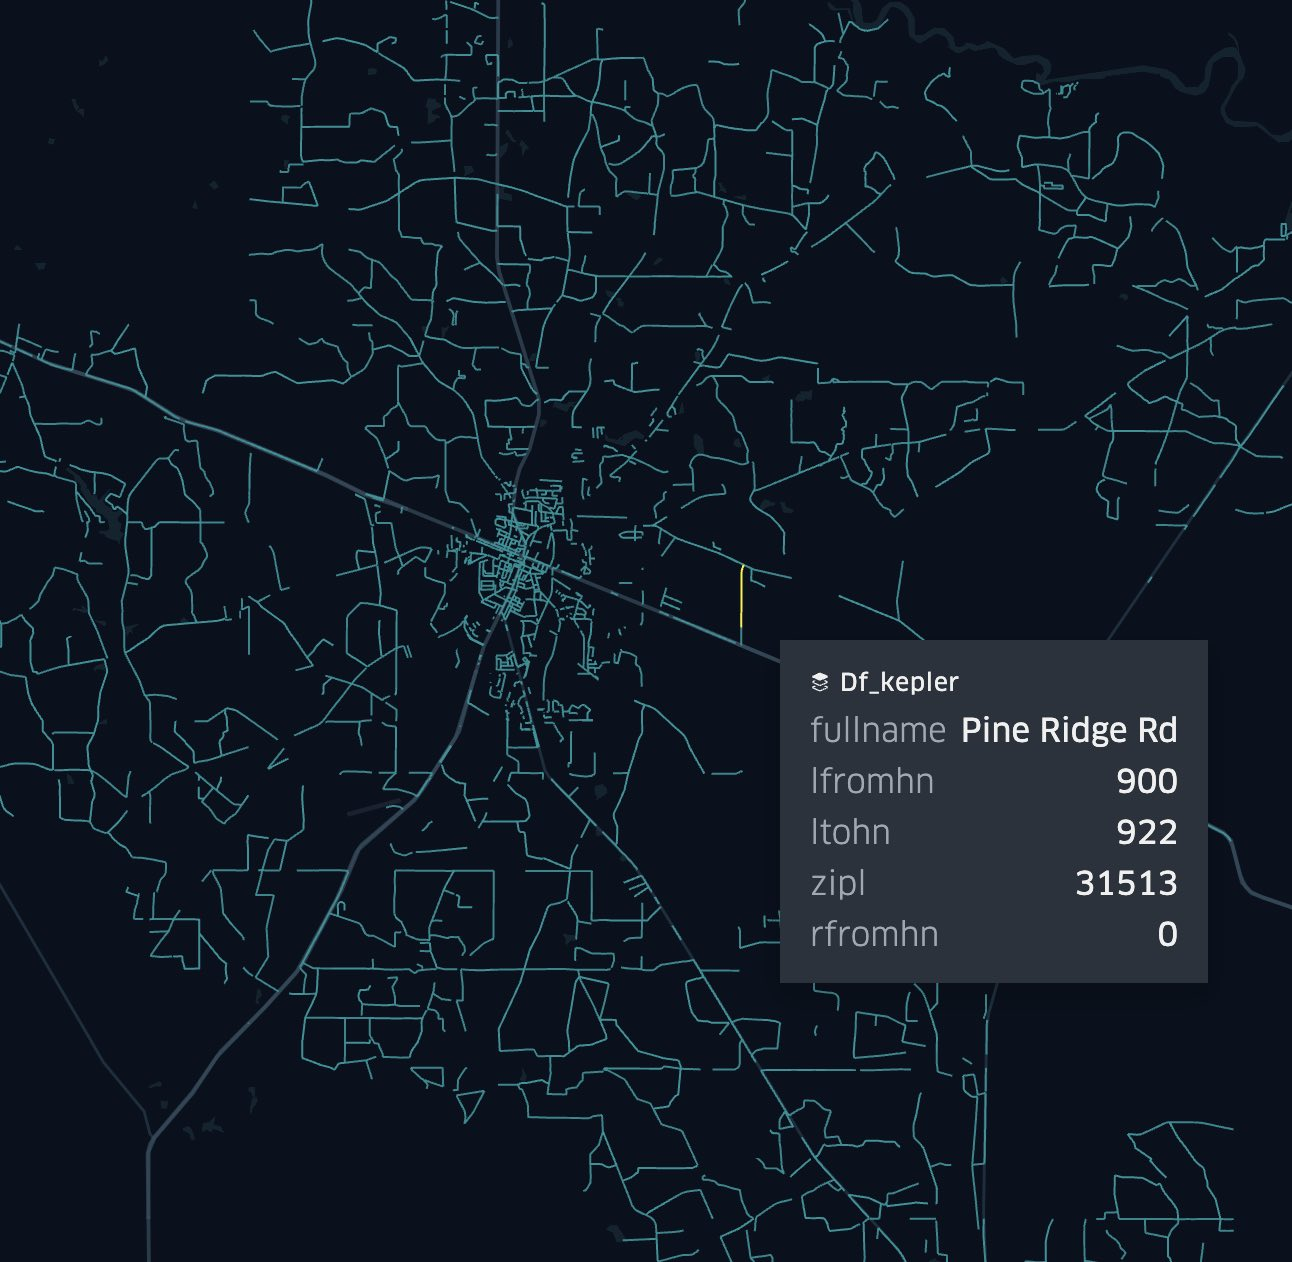

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAABQygAwAEAAAAAQAABO6kBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIBO4FDAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAQEBAQEBAcEBAcKBwcHCg4KCgoKDhIODg4ODhIVEhISEhISFRUVFRUVFRUaGhoaGhoeHh4eHiIiIiIiIiIiIiL/2wBDAQUFBQkICQ8ICA8jGBQYIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyP/3QAEAFH/2gAMAwEAAhEDEQA/APh+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOx8BJnxTbTE4WESSMfZUauRlfzJGkxjcScfWux8K/6Nputap3htfKB9DM20e3auLqnsjCGtST9F+v6hRRRUm4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2PgqKOe/u4JFDeZZTgbhkA4yD+lcdXSaLpviUwy6posLlFR0Z1A5Uj5gAeTx6DNVHcxr/A1ew/TtW0RbNLDWNNWYLnE8LGOUZOcnqGx2BwKvf2D4d1P5tD1RYnPSG+Hlkf8AbQZQk+griqKL9xOjreLa/rz/AENzU/DWuaRlr61dUAz5i/MmD0+Zcj9a357Pw5Y+FLKe9t5Te3qTOssb9GRsIGU/LtPfAzxXNabrmraQwbT7l4wDnZnKH6qeD+VdI+uaH4gURa/CbOYZ23FtnYCeu6M5/Ejk01YyqKppzbLt/l/w5wtFdPqHhXULSD7dZMt9adpoDuA/3h1Ujv6VzFS1Y6YTjJXizpdf/wBTbfQ/yFc1XS6//qrb6H+lc1RLccdgooopFBWzoK6W+pRw6xHJJDJ8mIjhgzcA8+lY1XdN/wCQjbf9dU/9CFNEVFeLJ9b04aRq1zpqtvEEhUMe47Vl10/jT/kadQ/66n+QrmKHuKjJuEW+wUUUUjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOm8O6PBeNJqeqN5VhaYaVv7x7IvqT+n4iszWdSk1jU59SlG0zNnHoAMAfgAK39cdk8MaLAnyo6yyMBxlt2Mn1OK42qfY56XvN1H6BRRRUnQFFFFABRRRQAUUUUAFWreJJgynhu1VacrMh3KcGgTFkjaNtr9aZW5pNrea1erp9u6LIysw3DrtBOB7nFZX2mbPX9BTsSpa2JrJm8woDxjOKkvYxgSjr0NSIV+0CRejrx9afdf6hvw/nQK+pj0UUqgsQo6mkaEsMDzHjgdzV/7PaqQrYz7mpflt4eeiisd2LsWbqaZG5qNZwsMKNp9azZYniOH/ADqSG4eI46r6VpyIs8WB35BoC7W5iUUpBBIPUUlIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9D4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiirtlp93qDulou9o0aRhkA7VGTgHk/QUCbS1ZSooooGFFFFABRRRQB2ln+68B30i9ZryKM/RV3fzri67S0BfwJfAnhLyJh9SpFcXVS6GFHefr+iCiiipNwooooAKKKKACiiigAooooAKKKKACiiigDrl1zw9bqJLPRo/Ox/y2laRBj/ZOM5PX8q2PDWualrPiWJr6UlVikCxrwi4jI4XoK85ro/Ck93b6wstlbm6kEcn7sMFyCpycnPQc1alqclahFQk1vbq/8znKKKKg6wooooAv6fqmoaVP9o06ZoX77TwfqOhHsRXQ/wDCZXDfNPp+nyyf89HgG7PrwQM556Vx9FNNoylRhJ3aOv8AFl2969vO6IhIIwg2jjHauQrpfEH3Lf6N/Suapy3KppKKSCiiipLCrFozJdxOvBDqR+dV6ntv+PiP/fH86BPY6Xx0qp4svwvHzg/moNcnXXePP+Rtvv8AfX/0Ba5GqluzLD/w4+iCiiipNgooooAKK6LRNEttTtru+vrr7Lb2mze2wuf3hKjge45qhqtjaWMyJZXaXiOu7egK4OSMEHoeKdupmqicuXqZlFFFI0CiiigAooooAKKKKACiiigAooooAKKKKACiiigDr9WIk8I6MwP+re5Q/i4NchU7XVy9ulo0jGKMllTPAJ6nHrUFNu5nThyq3m/xYUUUUjQKKKKACiiigApzo8bbJFKn0IweeabXaWGv2N/aJo3ihN8MabILlF/ew46D/aX2ppGdSTjqlc4uit7XPD91orRyllntZxuhuI/uOP6H1BrBoasVCakrxNjw/efYNbs7s9ElXd/uk4Pp2NO16xaz127sYwTtmYIB1IJyvbrgisWvYZIIf7Sh8b3ahreKyjuGz/FcY2In1BAOfaqirqxz1p+zkpd1+PQ5XUPB2s6Vam4ZoZ/s7DzRC+5o9wzhxgYrFlUtGyjqQaLHxHq2n6lLqsEuZZyTKGGVfcckMO4rqwmg+Its9hPDptyV/eW8xKxlvVHPHPp2o0exPNOH8TXzR54YJh/Afyq7bWzI3mP+Aru28HahEGe4uLSGNcgyPMAuR1HGT6fnVcQ+FNMcS3t/9tZOfJgQ4bGcAv0wSKOTuP61F/Dr6GbZaRDdRHU9Xk+z6fEcE/xysP4Yx3Pqe34HHHPs3ny87c8Z647ZrV1nWbnWbkSygRxRjbFEv3Y19B/U96yKTfY2pxlvIK0rFiVZD0HT8azav2J+Zh7UkXLYivABNx3FVat3v+uH0qpQNbBRVuK0dxuf5R+tS/Yf9v8ASkLmRn0VLLE0TbW/A1FQMKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/R+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq5p9/c6ZeR39m2yWI5U/oR9CODVOigTSaszrvEen208aeJNJVvsl2xMin/llLnlTjse1cjW/oOuvpErwzr51ncDbPCejKe49GHY0a9obaRMksL+dZ3A328w6MvofRh3FU1fVGFNuL9nL5GBRRWrZ6HrF+M2dpLIMZ3BTj8+lKxtKSWrZlUV2H/CE6tF/yEJbWy/67zKPp93d1pR4e0G3+a/1qHAPSBGkJ9sjGOO9PlZl9Yh0d/TUk0XFz4R1qz6vEYJ0HsGwx/AVxVepeG5PCUV+2lWD3Ur6hC9s7yhRHhhnhR82cgfT1rzGWNoZWhf7yEqfqOKcloiKErykref6foPt7W6u38u1ieVv7qKWPPTgV09t4F8TTx+dJbfZ4wAS87LGBnpkE5/SqFl4n13TbEadp9y0EO4thAAST1O7G79ayLm7u7yTzbyZ5n/vSMWP5nNLQuXtG9LJff8A5HWHwFrzgmyNvd/9cZkb+ZFc3f6TqemSGPULeSEg4+ZSB+B6Hr2qgCVIIOCK6TT/ABh4j01BFbXjmMDASTDrj0w2fWjQVqq6p/h/n+RzVFdsfFem3xP9taPazZ6vBmB/qSuc08aR4S1fCaLfSWlw3CxXgG0nHADrwMn1o5ezD27Xxxa/E4anKrOwRAWZjgAckk1oappGpaLcm11OFoX7Z6MPVT0I+ldzqmpQeD1i03QrZEuZLdHku3+aTMi87c/d/D8qFHuOdbZQ1uYsHhCSGAXPiC6j0tXx5aSjMjD12D5gB71S1fw4+l2cepQ3UF3bSP5YeEk/NjOCCPSsJ55Li4+0XjtKzNl2Yks3rknmt7Wdet7+yh0vTbQWdpA5kCby5ZiMbmJ7/wD6qelibVFJa+vb/M5qiiioOkKKKKACu18Af8jJH/1yl/8AQDXFVs6Dq7aHqK6gkYlKo67ScfeUj36ZqouzMa8XKEorsY1FFFSbBXTaNo9lcWNxrGsSyRWkDKg8sAvI552rnjIH86saHYaTrlodJP8Ao+ogloZSTsl/2GHY+hH/AOuW11nSxpkXh/XrSQpbSOd8DgNuJOcqeGI6DJ6VaXVnNUqN3jFa/p5HK3n2P7TJ9g8zyM/J5uN+PfHGfpVat/Xb7S7k29ro8Jjgto9u91USSMTksxHX2HasCpZtBtpNnS+Ifu2/0b+lc2FLdOwzXSeIelv9G/pWTZlVV2bgDFN7hF6FCilbG47emeKSpLCp7b/j4j/3x/OoKmt8+fHjg7h/OgT2Oo8ef8jbff76/wDoC1yNdd48/wCRtvv99f8A0Ba5GqluzHDfw4+iCiiipNwooooA7DRPm8L67EOpW3b8FkOa4+uv8PZbQ9biHeCNs/7r1yFU9kYUvin6/ogoooqTcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorT0fSrjWtSh0y1+/M2MnooHJJ+gpkykkrs6Hwhq0Sz/wDCPasd+nXx2Op/gc/ddT2OcZP49q5jUrGXTL+fT5/vwOUJ9cHr+NdfPqnhTRGa20ewXUJUbBubslkbHpGMDGent61Xm+IPimWQyrcLGW67Y05/NTVu1rNnLHn5nOEdH30+fU41VLsEXkk4Fdz4quZdN06z8IrLvFovmTkdPMfJ2j2XPH1rm7rXL+91GLVbsrJPEVIO0KDtORkLjv1qnf3suo3s19OAHmcuwXpk+mc1N7bGrg5Si5dPzKlFFFSbhRRRQAUUUUAFWLaURSZboRiq9FAma8kEVwRJk9McUJbQwnf1x3Pas6KeSL7vQ9jSSzSSn5jx6dqZPKy5LeDpD+ZqFLyVfvfMKqUUXHyo2QY7qLpx/I1kyIY3KHnFW7IkMR2NF3C5k3opII5x60CWjsUaKuQ2jMcyggfrUrWK4+RvzoHzIzqKupZSE/OQv61a+yw7NpHTv3osDkjIoq7JZOOYzuH61TIKnDDB96Q0xKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU0LopIkXKnr7VDTgjt91SfoKBMkmiEZBU5VuhqGrQz5DxODlfmGf1qrQCCiiigYUUUUAFFFFAH//S+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAoqzDbmZdwPQ4NOuzHuCp1UYNAr9CpRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAro9I1yO1tZNK1SM3NjL83lg4ZHHIZD29D61zlFNOxE4KSszsV8XmyP/ABJNPtbPHR9vmSf99t+HbrWVeeJtfvyftV7KQeqq21f++VwP0rDop8zIjQgnewpJJyeSaSiipNixaXDWd3Fdp96F1cduVOa6HxlbRwa/NNDzHdBbhD7SDJ/XNctXYa5/pPhzRr9v9YElt2P+zG3ye/AP+FUtmYT0nF99P1/Q4+iiipNwooooAKKKKAOs0rxVPa2/9matEuo2JGBDKeU/3G6r+H4YrW1+2/4St21vQV3JCgja2zmZETgNjnII9Ca89qe3ubi0mW4tZGikXoyHBH4iq5ujOeWHSlzw0f4EJBBweCKSu1/tzSddjWDxJF5VwOBewj5v+2iD731HPpWbq3hm+02EXsLLd2b8rPFyv/Ah1U/X86OXsVGtryzVmc5RRRUmwUUUUAFdHpnhPxBq6CWytiUYZDMQoI9RuIz+Fc5Xd+FNQvb7Vn+1ytIEtJVUHoAqYGB06VUUm9TCvKUYuUSu3gHxKq5EUTewmj/q1O/4V54w/wCfL/yJH/8AF1xVFF0HLV/mX3f8E9N8P+C/Eul6zbajf2oiggffI5kjwqgHJOGrzu8dZbyaROjSMR9CarUUNrZDhTkpOUnf5W/VmhpmlahrN2LLTIjNKQWwMDAHUknAA+p68V0v/CvPGH/Pl/5Ej/8Ai6g8FyZ1aSyDbWvbeW3Vj0DMuRn2yKxL3RtU02CK5v4GhSYkJv4J29eOv6c9qaStciU58/Iml6r/AIKN3xdY3enzwW15GY3Ck4PPBxyCODXH16N8QMlNIc97NV/I15zSmtS8PJygmwoooqTYKu6b/wAhG2/66p/6EKpVd03/AJCNt/11T/0IU0TLZm140/5GnUP+up/kK5iun8af8jTqH/XU/wAhXMU5bszofw4+iCiiipNgoqzaWd3fzi2sommkboqDJ/8A1V1q+HNL0lfN8T3gSQYP2WD55DzyCw+UHgjr+NNK5lOrGOj3IPDZzpetIOSbXOPYMM1yFd/ZeIvC1ik8MGmTKtzEYXPnZJU+2MA1d1u38G+HrpLObT5rmfykeRDMVCMwzsJAzkDHTsau11uc8arjN3i9fT/M8zortP8AhI/D8RxbaDAF9JJXkP5nFKfGMCk+RoumgH+/Dv8A6ipsu5t7WfSH4o4qiu1/4TP/AKg2lf8AgP8A/ZVBJ4uaRtw0rTU9ltxj9SaLLuCqT/l/E5Giu3eWDxDoN3MLWC3urFllHkJ5YaNvlbIHBIOD2P8AKuIpNF05817rVBRRRSNAooooAKKKKACitjSNNtdReRbq9isggBDS5+YnsMVujwjZzELa61YMTwA7lOfxBqlFsxlXjF2f6nFUV0V94U8QafIEltJJAwyrxDzFYeoK5rLGmakxCrbTEnoNjf4UrMqNSLV0yjRVq6sryxdY72F4Gdd6rIpUlSSM4PbiqtItO+qCiiigYUUUUAFFFFABXa/D/wD5GWP/AK5Tf+gGuKrtfh//AMjLH/1ym/8AQDVQ3Rhiv4UvRnFUUUVJuT21vNd3EdrbruklYIo9SeBWjr9jaabq9xYWTtJHC2zc2MlgPm6Y6HIqHSNUudF1CPUrQK0kWcBxlTkEcjI9a6aSOx8UWFzdWVqlrqFr+9dYixWWPoSF5wynGfXP5UldGE5uMk38Jw9FFFSbhRRRQAUUUUAFFFFABRRRQAUUUUAKrFTuU4Iq/HejbiQHPqKz6KBNXLkt478J8o/Woo7mWPgHI9DUFFAWRYa6nbPzYz6VCzs33iT9abRQFi1aylJNpPyt/OtGWJZl2t17GsSrcN20YCt8y/rTJa6oryRtG2xutMrX3W9yADyfToamSONPuKBRYOYwwrHoCaf5Uv8AdP5VtMyqMsQPrUQuYWfYD/hRYOZmNRW1JbxS8sMH1FZMkZicoe1A1K5HRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKciNI21Bk0gBJwOprWRY7WPLnnuaZLdhkNoifM/zH9KuVlS3bucJ8o/WoPOl/vt+ZoJ5W9zYlTehHfBx+WKw60bScsfKc5PY1WuU2TH0PP50DjpoV6KKKRYUUUUAFFFFAH//0/h+iiiusxCiiigAooooAKKKKACiiigAooooAkWWRF2KcA88VHRRQIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVsaToGra55n9lw+d5ON/zKuN2cfeI9DWo3gfxUp2myb8GQ/wAmp8rMpVoJ2clf1OZt7ee7nS2tkMkkh2qq8kk11figpYW1j4dUhnskZpsHI82Q5Iz7VdMT+CrHdIANXu1IUcEwRnv3+Zvr0/XgmZnYu5JJOST1JpvTQiL9pJSWy28xKKKKk6AooooAKKKKAL32FsZ3DNUmG0lT2qybyY9MD6CqvXmglX6hWtpGt6lolx9o0+Tbn7yHlGHoyng/z9KyaKaYSipKzPQTYaZ4wt5bnRoRaapH872yn93KvcxjqD7V59VqyvJ9PvIr61O2WFw6n3Bzz7etdjrWkjW7UeKdCiykvFzbxjJhk6EgD+Fuo+v5VuYJ+yfK3o9vLy/yOEorRTSNVkz5dpO2OuI2P9KuJ4Y8SOcDTrr8YmH8xU2Zs6kVuzCrsPBny3l7L08uxnbPpwBn9apr4P8AFDKXGnz4HquD+XWum8O+HdbsrPVZrizmjeS0aGNShyxkIzj8uaqMXc569aDg0pI81orTk0TWYv8AW2VwvGeY2HH5VQkiliOJVKn3GKmx0qSezI6KKKRRLDNLbyrPAxSRCGVlOCCO4qe81G/1Bg1/cSTlc7fMYtjPXGTxVOignlV7no/xA/1Oj/8AXp/WvOK9C8Ttc67Lp1lp8DySwwmPao3E4I546D+VYb+DfFEahm0+Y59Bn+VXJXehz0JxhBRm7P8A4JzNFT3Nrc2UzW93G0Ui9VcEEfgagqDpTvqgrR0dBJq1nG3Rp4wfxYVnVqaJ/wAhqy/6+I//AEIU1uTP4WXvFzM3ifUC3P79x+RxXO16FrPhjVtT1/U7tFWG3S4fdNOwRBk+p5xg54FX9L0bwdZQmS5v7e9uiPlWRmSIHnrxk8frVOLbOWOJjGCtrotjg9M0XU9YcrYQl1X77nhF/wB5jwOPxrfbTPDWhy41e5OoTKRmC14Qeu6Q49+Bz60/xNceIY4o0uJY/sEmRCLTAgwOwA579DXEUnZGkeaort2Xl/mdXf8Ai2+niNnpaJp1qePLg4JH+0/U9T6D2rlKKKTd9zaFOMVaKL+lRLPqdrA3R5kU/iwFa/jKVpvFOoO3aYr/AN88f0qHwpEZvE2nIO1xG3/fLA/0qprsvn63fTD+O4lb82Jp9DP/AJe/L9f+AZVFFFSbhRRRQB03hG8itdbjiuceRdBreUE4G2QY5/HHXisbUrC40u+lsLlSskTYOfTqD36jmqVdtqoGu+HoddXH2iy221yO7Kf9W3AA9R+VUtVYwl7s1Lo9P8jiaKKKk3CiiigAooooAKKKKANWy13WdOi8ixvJoY852o5Az9OlaJ8Z+KSCDqE3PvXM0U7szdGDd3FFy91G/wBSlE2oTyTuBgGRi2B6DPSqdFFItJLRBRRRQM6TTvCmrapZLfWoj2uxWNHcK0hXrtB64+tZF7p19psxgv4XhcdmGPyPQ/hXSa4TbeHNEtBw+yWY+vzv8p/IVTsvFms2kP2WR1urfvDcqJFP58/katpHNCdR3krNa/mc1RXZpdeENWO2+t5NMlI/1kBLxk+6EEgey1XuvCF+lqdQ0ySPULYcl4DlgP8AaU8g+3OKXL2KVdbS09f89jlK7PwIqtrMhP8ADazkf98EVxldr4D/AOQxN/16Tf8AoNENwxP8OXocVRRRUm51via2tbWz0hbeNEaSyWWQqACzMTycdenFVPCb3SeI7H7KxVmmUNt7pn5gfbGa0/G/yXenW3eDT7eP8gT/AFqHwIFPie2yOQJMHsp2Nyc+lX9o41L9w2+zMHWDCdWvDb/6vz5NnOfl3HHP0rOpSSTk8k0lSdUVZWCiiikUFFFFABRRRQAUUUUAFFamk6Pf61c/ZrBNxAy7E4RF7szHgAf/AKq6h7zwx4cPladAup3iLgzzYMAY9Sqd8dAfxqkjGdWz5Yq7MPRtIi1Gy1G8nZlFlb+Yu3u5IABz26+9c/XpUmv+F5NI1JraKS1ub+NVe3VQY96nduU/wrknIz+Fea0SS6E0Zyk5OSt/wwUUUVJ0BRRRQAUUUUAFSedL/fb86jooEKSWOWOTSVK0MyDc6MAO5BqxZxpJv3jPSgLk9nIWjKk52/yqven96B7VdwltEcdv1NZrJPK5cqcn2pkLe5BRVkWk56gD6mpRYv8AxMB9KRXMijRWkLKNRl2P8qURWY7g/U07BzIzKUAscAZrXH2UdNn6U8zQgffH50WFzGUIJm6Kfx4qQWcx64H1qdr4AkKuR61F9tl9BQGo8WJ/ib8hUoso+5Jqn9qnP8X8qj82U9WP50BZmqLaBf4fzprWkDdsfSsinK7r90kfSgOV9zQaxX+FiPrzULWUo+6QaiFzOBgNWhHdxP1O0+9AaoySCpwwwaStx445l+bkdjWPLE0T7D+FA1K5HRRRSKLVooabnsM1NfN91fxpliP3hPtTLxszY9ABTI6lWiiikWWLX/Xr+P8AKrd6oMYbuDiqtoCZwfTNT3rg7YwenJpkPcz6KKKRYUUUUAFFFFAH/9T4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtrQYZb3V7SxBYpJKoZQTjbnLdPbNYtdf4JAj1h78jIs7eWf8A75XH0796cdzKtK0GzN8S339oa9d3Ixt8wqmDkbU+VcfgKwqUkk5PJNJQ2XCPKlFBRRRSKCiiigAooooAKKKKACiiigAq/YapqOlSGbTp3gZhglDjI68+tUKKBNJqzOkfxh4okxu1CcY9Gx/LFU38Q6/IMSahdMPQyuf61j0U+ZkKjBbRRfbVdTdtz3UxJ7l2/wAa27SXW7zSr7U/7RnUWXlZQux3eY23rnjFcrXVaTcW8fhjWreSRVkl+zbEJAZtshJwOpwOuKaZFWKS0XVfmijH4m8RR/dv7g855kY/zJqHUtc1XV0jj1KdphFnbuA4z16AVk0UrstUop3SCtGbSNUtrRb+4tpY4Gxh2UgHPTr61nV2njmaZ9WUb2MMkMUiLk45QDOOmeKEtLilNqSiupxdA60Uo6ikanq3i7VbvRLOy0/TNsAurQSSyKMSNvJyN3XFebLqepJkpczLu64dhn6812/xD/1mlf8AXjH/AFqvNpXhXQ7e2TWzdXF1cwrORAVVEV/uj5hkn1rSV2zhoyjGCbV2yhD4uuZrcWWvQJqcIOQZiRKvssg5H45pJNY8LmNhDoYRyDtY3MjAHscEc49Kb4k0vS7O2sNR0jzRDeo7bZiCwKNt7Af1qLXbcfY9Kuo41TzrYLhAMEoxGeByx6nJJz+VK7KjGm7OKtfza/BEsOvaNBCkY0eB2VQGZ3YliB19s1r6N4mhbV7S2stMtLcTTxoz7CzgMwBwSeOPauOg0jVrkkW1pPIQcEJGxwcZxwPQ5rotA8N+II9ZsriWwuEjjuI2ZmjZQAGBJOQOAKE2FWFJRd3+JS8V6nqF7rV5BdzvJHDcSrGhPyqAxAwOnSuZrs9e8NeIZNZvriKwuHje4kZWWNjkFzgjArFPhzxCoJOnXQA/6Yv/AIUmnc0o1IKCSaNnwrewXCzeGdScLaXw+ViQNkwwUbODjONprl72zn0+8lsbobZYXKMPcHHHt6VbXRtcRg6WdyrKcgiNwQR+Fd5Jomo+MNOa7ltpIdXtVAcujKtwgGAckY8wYx15/k0m1YiVSNOXNfR7+vc8uoqzdWV3YyeTeQvC/o6lTxx3qtUHUnfVHaeAlVNf+3yDKWUEtwx9AqkZ/M1xrMzsXbkk5NdzYhtE8GXOokL5urP9miz1ESZ8xh9Tx+VcJVPZIwpe9OUvl93/AAWFFFFSdB13jhVTxA6oAAIouB/uCuRrsPHX/Iwyf9cov/QBXH1Ut2YYb+HH0Cu10Aed4U1+2HLbbeQA+iOdx/KuKrovDutQ6RPNHew/aLS7jMU0YOG2nkFT6iiL1HXi3HTyf3O5ztFd9feD9PVo5LHU4VjuUEsC3OUcq3QE4xnPFYq+EfELXbWn2VgVGWckCMDrnf8AdxjnrQ4sUcRBq9zm66DTvC+t6nGLiCApCQT5shCJj1ycZ/CthJtB8MBWhEWq3+DljzbxnPGBgFz75+mK5zVNb1TWJN+oTtIASVUn5Vz6DoKLJbi55z+BWXd/5G3/AMI9oUHy3+twK3fyY3mH5jFY2taU2j3gt94ljkRZYpFzh0fkEZrIrsNT/wBM8JaZffxW0klq5+vzr9MD86NGHvQkryvf0OPoooqToCiiigAooooAKfHG0sixJ1YgD6mmVu+GIRP4isIz089G/wC+Tn+lNIicuWLkaHjSVP7YGnxEeXYxJbrj/ZGT075J9K5KtLWZjcavdzMSS88h592NZtDepNGPLBIKuWOoXumzi5sJmhkHdTjP19R9ap0UjRpPRnYnxjK53z6Zp0rnlneDLE+p5FWbPxwbSXzo9LsUYgoxijKEqeo6nr61wtFVzMweGpvSx2qWXhbXZP8AQpzpU7f8spvniJ9A/BH41T/4Q3XRqUOnPF/rz8swOY9vUtuHYDn19q5avQdfv7nQdLsvDenyPAWgE11tY5Z5QDtPoAB046/m1Z6sianBqMHv36GV4ruY9Z8SSLpmZlGyCLZzu2AL8o9CelaLyW/g20ltYnWbVrhNkjL923U9VBzguf0/nkeFtYtNHvJJLtWAmjMazR43xE/xLnjpVm+8IaqW+2aX/wATG1l+ZJovmJz/AHlzkMO9PzRLSjanJ2ivxOQorZk8O6/DzJYXAHr5bEfniqcmm6jF/rbaVeM8ow4/KosdSqRezKVd7bXp8P8Ahe1u7eGGSa/mkLGVA3yR4XaM9RnmuEZWQ7XBBHY113ib9zpui2X92087/v6xP9KcdLsyrJScYvv+g1vGN2ylfsViMjGRCM/zrkaKKTdzWFOMfhQUUUUiwq1ZWdzqN3FY2aF5ZmCqo9T/AE9T2qrXbeFM2um6xq9qf9LtoFWLnBUSNtdx7qOn1ppXZlVnyxuh+v6lFpNmPCmjOpiQD7XMnWaTuM/3V6Vw1FFDdx06agrBRRRSNAooooAKKKKACiiigArsfBcZW7vdQVdz2VnLNHxnDjAU459fQ1x1XtO1G70q7S+sXKSIeD2I9CO4NNOzMq0HKLijeXxx4qU7het+Kof5rW7pGr23iq8j0vWLZPtUwYC7j+RiwBI3ADB6YrKkvvCuuPm+gbS5iOZYPniJ9TH1H4VJaaDBZ3Ud9Za3ZK0bB0YsQeORkEfmPwq033OWcYW+Hlfp+qObkvFjYoFJIODmqjXczdDj6V6Hq0nhK2kTUrjyry7ZCGgtciAyA5DscggEHkDvWJ42Ebanb3EcaRGe1ilcIMDcwOeKTia06yk0uXcz9I0rWtcE39mgSNCFLKSAfm4GM8dq6W18JCcFJtWtvMiUy3EcZ3eXEv3juH8Q9MfjVzwpPpegafqFxc38Je4jZI0QktlCwz7buCv1rB8Oqmn6Nqes3TbUmgeyiXu7yAE4/wB3AJppLQxnUm3Ll0StbTcbqNlpWm2ct0ymb7cP9CEjESRoG/1jADHzc45/DrjjavXeo3d7Db29y25bZNkfHIX096o1DZ10ouK956hRRRSNQooooAKKKKACiiigAooooAvWc2D5TdD0q7NEsy7W69jWJ05FXIrx0GJBu9+9Mhx6ormGUErtPHtSiCUkDaRn1FaS3cLd8fWpTLEBuLDH1oDmYkUSwrtX8TWRK2+Rm65PFW7i6VlKR9+pqhQEV1YUoBYgDqaSrVomZN56LzSKbLDEWkO0cu3es4kk5NSTS+bIX7dvpUVAkgooooKCiiigAooooA//1fh+iiiusxCiiigAooooAKKKKAD61ZuIUjCtHkhvWq1X4mE1v5JGWHA/x/CgllCippoGhxuIOfSoaBhRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArpLDRNPu7RLifVILd2zmNw24YJHOPXrXN0U0ROLa0djsP+Eb0n/oNWv5N/hVHVPD/ANhs11C0uor2Atsdos/I3bcD0z2rna3NG8Q6loTP9jZWjkGHjkG5G+o9ad0ZOFRaqVzDorsD4tjkJe50qwdj3EW39AaP+El0o8totrnvgsB+WaLLuP2k/wCX8UcfXYeFf+PTWP8Arxf+Yo/4SbTV5i0a0B/2tzD8s1ftb641rTdQkgittPW1tiXFtEFMqsQNrEk8cU0jOrOTjZq2xwFFFFQdYUUUUAFFFFABRRW5pXh3VdYHmW0YSEHDTSnZGO33j1+gyaaVyZTUVeTMOiu0/sDw2+LaHWU+0BclmQiIn0DduPrWfe+FNas4jcrGLiAf8tYGEi+/TnjvxT5WZqvB6Xt66HN0UUVJsFFFFABV62t0kQs/rgVRrUs5CyFMY2/1pky2IJ7XYAYgWHetvSbK2uPDmsXUkYaW3+z+W3ddzkNj6isuS8ReEG7+VafhjUrW11F4NSOLS9RoZvQBuh6Hofyprcyq83Jdf1qcxW/pOvzaZA9jLDHdWkrbnhlXgnGMhuoOOh7Vn6pp8+lahNp1x9+FiufUdj9CORRpum3erXa2Vku525JPAUDqzHsBSV0y5cso3lsTJay61qZh0e1KmU5SFTkKP94449zXZ6pq+l6bBZ6Zc20GpXNtAI5ZGOVXByEVlPO3OD/+usi+1e30e2bRPDsnDcXN0OGlPop7IO2Ov8+Oqr2MVT9pZy2W3f8Ar+mdh/wlNmOF0axx2yhJ/PNKPEmlkgtotrk9cFh+ma46nL94fWlzMv6vD+mz1DxD4tKSQJ/Z1lKiJsTz4/MZVXoASRxXCa1rV1rl0l1dJGhjjESrEu1Qq5wMc9M112peFNf1VIbqwtvMjKnB3oO/oWBrK/4QHxZ/z5/+RI//AIqqkpMxpuhDZq/qYcOs6jCbXEu5bIsYVcBlXdycA+9bbePPFJXYt3sXsFjQY+ny5oHgPxW2cWZ4OOXjH/s1SL8PvF7DK2Wf+2kf/wAXSSkVKeHfxNfgbMniDW7nwT9tjvJUnhvfLkZGKsUZMgkjB68Vz+ia3rVxrtglxe3EitcRKQ0jEEFxwcnpXV6Z4P1+20PU9M1C2Eb3Qia3BkQlpIyWwMNjJXOfYVl6L4I8T2usWdzPabY4p43Y+ZGcBWBJ4bPSqaloc8Z0Upq6/DsY+ua3rMGvXywXtwgS5lChZGGAGIwMHis8eJfEYII1G64/6bP/AI03xECPEGoA8f6TL/6Gaxqht3OynTi4rQ6H/hLPE3/QRuP++zUcnifxHKMPqNzj2kYfyNYVFLmZXsYfyo6y08YaikP2PVUj1G26eXcDJHurj5gffnFXYNF8Na/MkejXjWVxKQFtrlSwyeyyL29MjJrhq7HwDEkvi2yEoyql3Oeg2oxB/MCqi7uzMa1NQjKcNLf1sdR4o8L6tqVzFa6IYrm0sYlhiRJV3ggfMWBI+YnP4CvOL7R9W03Jv7WWEA43OhA/PoapSzSSzNcOTvdixPfJOc1vWPi7xJp42297IU6bZD5i49MNmhtMdOnUhFRTT/D/AD/I5yiuy/4SbTL4Aa5pMEzD/lrATA59228MfwpBpXhjUzt0q+e1lbpHeABc/wDXRcge2RS5exftmvji1+Jka/qq61qTX6RmMFUXaTn7qgf0rFr0LxVaaFobtpUemnzTEpjuvObDEjk7cbT3rz2iS1DDyUoLlVkFFFX9LsX1PUbfT485mkCZHOATyfwHNSbNpK7Oi8W4SDR4upGnxN/31muafUL+W2WyknkaBPuxliVH0GcVr+KtQTUNamMOBDB+4ix02R8A8evWucqpPUxoR9xXQUUUVJuFdjoeL3w9q2mN96NFu4/byzh/0Irjq2dB1U6NqkV6RuQfLIvHzI3BHINVF6mVaLcdNzGorofEGinS5xcWpEtjcEtbyryCv90n+8OhBrnqTVioTUlzIKKKKRYUUUUAFb/haTyvEdgx7zov/fRx/WsCtTQ3Ka1YuOq3ER/JhTW5nVV4tDdZj8rV7yLGNk8i4+jGs2tzxMgTxDfgf8/Eh/Niaw6HuOm7xTCiiikWFFFFAGno2ntquq22nr/y2kVT9M8nj0FaHi6/TUvEd5cxHMfmbEx02oNoI9jjNang0LZJqPiFztNjbssR6fvZflXHBHTP51xFV0OePvVG+2n36/5BU8F1dWp3W0rxH1Riv8qgoqTdq5rx+INdh/1d9cD28xsflmra+LfEiDAv5vxbP8652indkOlB7pHXJ4uurlRBr8EepQjoJBsdf911AI/WuYeSS6lUOx7Iu9shV7DJ6AVBRQ3fcI04x+FGnquk3ej3RtbodRuRx911PRlPoazK6nT/ABDALAaTrlv9stlOYju2vF67WweD6VZ/trwmCYv7E/dn+Lz33/X2+lOy7maqTWjjf0t/mcbRWhqbaW1znR1lWHaOJiC27v8Ad7Vn1JundXCui8N6vbaRdy/bo2ltbqF4JlQjdtfuM8ZGOK52imnYmcFJOLO5/wCERt9Uha58LXq3m0bjbyDZOB6Y6N9RXEOjxO0cilWUkMpGCCOoIpY5ZIZFlhYo6nIZTgg+xFdrD40mvGEHia2i1CBhtZiirKo9VdQOR+vrT0Zl+8h/eX4/5P8AA4eiuq1/w/FYwx6vpMn2nTrg4R/4kb+447EfrXK0mrGsJqaugooopFhRRRQAUUUUAFFFFABRRRQAV2HjP/j7sf8Arxg/ka4+ux8XZ2aWZ8C4NjH5gHIwM7T9SOoqlszCfxx+ZyUMrwTJPHjdGwYZ5GQc9K1dW1/VNb8sahIGWLOxVUKBnrwAKxqKVzVwTak1qFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBQCTgck1emxbwiFercmo7JQZST2HFQzsWlbd2OKZO7IqKKKRQUUUUAFFFFABRRRQB//1vh+iiiusxCiiigAooooAKKKKAClBIORwaSigCeWYzKobquc1BRRQIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVoRWivGGYnJFZ9WIbh4eOq+lBLv0IXAViFO4DvXY+GVVtG1wNz/AKKp/Jwa4yu/8FWV1qNhrNnZpvlltlVVyBk7umTgVUdzHEu0Lvy/NHAUV2bfD7xci7nswAO5li/+LoXwD4lZcmKJfYzR/wBGo5H2H9ZpfzL7zjKK7X/hAPEn/POL/v6n+NH/AAgHiT/nnF/39T/GjkfYPrVL+ZfecVXXeFY4UXUdRkjSRrS1Z496hgJCQFOD1I7VP/wgHiT/AJ5xf9/U/wAa1LfQdQ8O6Hqs+qCNFmhWNArqxLFh2BNNRfUyq14Sjyxkru35mN/wm2r9PLtsenkrisrU/Eetawgiv7hnjXogAVfb5VABx2zWJRScmbxoQTuohV/TtUv9JuVutPmaJ0OeDwfYjoQe4NUKKk0aTVmdh4ytbdb231WzQJDqMCXAVeArnhwB255/GuPr0HToE8T+GItFhlRb/T5XaFHIUPFJywBPcNz9KxtR8GeJNLtHv7212wJjLq6MME4BwrE4/Crkm9UctGrGK9nN6rT/ACOXoooqDrCtGx6P+FZ1TxTtCpCjk0EtaFmaC2Tq20np3rPpzu0jbnOTTaBpHpU0Wg6noFhreuSzpLGDav5Kgl/LyV5PAO3uev61gah4ht0sW0fw/C1rauf3jsQZZfTcR0HsDUtz8nge1U/x3rsPoFxXH1cmctGkndvo2FFFFQdYU5Pvj61qaVbaRcNINWumtQANhVC+fXp0rbTSPCZcIutMWzwxt3C/jzmmkZSqqLs0/uZR8Rf62L/dNc5XU+K4o4bxIopBKoBw4BAP51y1EtyoO6THFmbG4k4GBn0ptFFIsK0tG/5C9n/13j/9CFZtSRSyQSrNEdroQyn0I5FNEyV00bXij/kY7/8A67v/ADrBqe5uZ7y4e6uW3ySEszepP0qChihG0UmFFFFIsK7TwI4g1t7xhuW3t5pGXpuAXGM/jXF12Hhv/R9I1q/x922WD/v82P6VUdzDE6wa76ffoVPE2l2tjcw3enDFneRLLEMk7ezLk8nB9fWuarsoC+o+Cp4Tlm024WRf9lJcgj6bufX8K42iXcdFuzi+mn9fIKKKKk2Ot0zXreayGh+IQ01pn93IP9ZCemV9V9v/ANVVdW8NXmn/AOlWv+l2b8xzxcqQem7H3T7GucrR07V9S0mQyadO8JPXaeD9QeDVX7mDpuLvT+4zq7Hw+f7L0m/8QOPmKm0tz38yQckem1eadH4qtr5tniKwhukPWSNfLlHvlcZ+nFbN/aaJc+D5l0Gd5xa3AuCjjEkaOApB6ZAPORTS6oyq1HpCatdr0PM6KKKg7AooooAKKKKAOo0LXY7WF9I1ZTNp8/3l/ijP99PQiszWtLk0bUZbF2DhTlHHRkPKtx6isqvVdd0Gzv7XS9RvdQis5LiyhVRKrHeygZYkdB8w5NWldHLOSpzT7nlVFdrJ4C1thv01re/T+9byq388etc/c6Frdmpa7sp4lH8TRsB+eMUnFmsa8JbSMqilIKkgjBFJUmoV1fhHT0n1H+1Lw7LPT8TyuemV5Vfck9u9ZuhaLca7fi0iIRFBeWRuFRB1YmtHXtZs5EOjaHEINPikLDklpW6b3JPtwO35YpLqznqy5n7OO/Xy/roYF9dPfXs17J96aRnP/AjmqldDoWsWmneba6laJd2tzgSA8SLjOCjdiM/j7VpX/heK4t21XwvKb21HLx4xNF7MvcD1H/16LX1G6qg+WSsuj6HGgZIA712S/D7xcy7jZ7V7lpIxj6/NmuMpzMztuckk9zSVupc1N/A7fK/6o6W/8HeIdPgN1Lb+ZEv3niYSAeudpJGO/GK5itDT9V1LSpfO064kgbvsJAP1HQ/jXUv4n0zXHC+KbJSxwPtVr8kv1YHKtTsmZ81SPxK68v8AL/gjLo/2d4GtLdSQ+pXDzN/uRfIB9M8iuJrt/HrRRatDpdv/AKqwto4Vz1PG7J9Dz0riKJb2DDaw5u+v9fIKKKKk6AooooAKKKKACiiigAooooAKKKKACiiigDotA1pdNkezvk8/T7rCXEXtn7y+jL1H+SDxB4fl0aRJ4ZBcWVxkwTpyGHofRh3Fc7VoXt2LM6eJW+zl/MMefl34xnHriqvpZmLptS5o/P8AruVaKKKk2CiiigAooooAKKKKACiiigC1ZQfar2C2/wCesip/30QK3PGU/wBo8TXrdAj+WB6BAF/pWXo0scGr2c8vKJPGzfQMCaueKIJLfxFfxyjBM7v+DncP0NV0MH/FXp/kYNFFFSbhRRRQBp6LaR3+sWdlMCY5p40cDrtZgD+laXi27juNbnt7eGOGG0ZreJYwANqMRknuT1rZ0uysvC9tB4g1pWe6k/eWdsDg8YKyOQchc9B3rir26e+vJr2QKrTyNIwXhQWOSAPTnireisc0Hz1OZbL8ytRRRUHSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATW8vlSBj0PBqxdwtv81RkHr7VRq9DebVCSDIHcUyX3RRorXDWjDd8nPrikK2h67PzosLmMmitMrZDrj8zULWyuvmW5yPSgfMUqKCCDg0UigooooA/9f4fooorrMQooooAKKKKACir8lvEkPmc5AHQ8E1QoEncKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2Xh9c+HNdPpFD/6HXG12mgZTwrr8vUBLdf++pMVUdzDEfD81+aOLoooqTcKKKKACiiigAooooAKKKKACuz8Hssi6rp7kD7RYSlB0y6YZRnt0NcZRTTsZ1Ic8XEKKK3dL8PXurwNPbSQqFbaRJIFOcA9D25oSuVKairyZhUV2H/CFakP9bcWkY9WmXFH/CIbP9fqunJjqPOyw/ACnysy+sU+5x9FdePDmkr/AK/WrYY67AzflwM0v9j+Eo/9ZrZc9CEt36/UnkUcrD6xHz+5/wCQXv8AyJVh/wBfUv8AIVx9d/r0enReE7FdLleaH7RJ80i7TnHPFcBRIWHd4t+b/MKKKKk6Ap8f+sX6imU+P/WL9RQI3/EX+ui/3T/OslYEkt9ycuOv+Fa3iL/Xxf7p/nWJFI8LB8Haf1pvclbEFFTzCLduiOQe2OlJLA8QBbof5+lIq5DRRRQMKKKKACiiigArs9QU6H4bh0lsfaNQK3Mw7rGP9Wv1J59ulVPCmlQahqDXN/xZWamacnpgdF/E1laxqc2salNqM3WVsgei9APwFUtFc55Pnny9Fq/0/wA/uN3wl++TVLE8+dYylR3LpgqB+tcfXU+C5hD4ktVcZSUtEwJwCHUj+dc9NbyRXT2mCzo5TAHJIOOlD2Q46VJL0K9SvBNHEkzoypJnYxBAbHBwe+O9dTa+C9XkgF5qPl6fbd5LltnHsv3j7ccmpPE95pX9naboelTm6GniXfLtKqzSMGO0HsDmjl0uw9unJRhr38jjaKKKk3Cu58BCd9YNq8UklpexvbzlRkAMOCT0GDjn3rmtG0i51u/SxtsAn5nduFRB1Y+wrspfEUlrfWPh/wALztHa27qhkXgzyMw3M3P3Seg9PbGLiupy4mXMnTjv+RzcHhXXLq/k0+2tnZonKMxG1Rg4yWPHb/CsO4ge2uJLaQgtExQlTkZU44PcV2XjbWdTl129sGuJPs8cpCx5IHTHSuHpSstEXQlOSUpdQoooqTcKKKKACu08Vnfp+iSAcGxVfxViDTNLtdHstBbXNWtWvGkuPIjj8wxgALuLZUZ9qt+NJYbi20e4toxBC9p8sQOQuGOatLRnJKpzVIpLZv8AI4VWZG3ISCO4rftfFniWz/1F/PgdmYuOfZsiueoqU7HRKEZfErnar4/8RsNt28V0uMFZokII9DgA0f8ACX2zcyaLpxbvtiKj8s1xVFPnZn9Wp9Fb8Dq77xVLc2UlhZWdtYxz48026lS4HIBOelcpRRSbuaQpxirRCrlhqF9plwLvT5mhlHG5Tjj0PqPY1TopFNJqzO80/wASx6jqEEF/ptnNJPKqPKY8MdzAZwCBn8K5vxBaQ2GuXtnbjEcUzqo9ADwKj0T/AJDVl/18R/8AoQq74s/5GbUf+vh/51bd0c0YKNS0drHPU5ELuqDqxx+dNoqDpOt8dPv8V3pxjlB+SKK5Kuw8e/8AI2Xn/bP/ANFrXH1Ut2Y4b+HH0QUUUVJuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADijhQ5BCtnB7HHWm122jKmuaBc6CzBZ7Qm7tz/eAGHQ/wAx/gK4mm0ZwndtPoFFFFI0CiiigArQtdJ1S9ha4s7WWaNTgsiFhn8BWfXoOrahfaHoOi6fYTSW8jQtdOY2Kk+ax25wRngen51SXcxqzaso7s4a4tLu0bbdRPEfR1K/zqvXWW/jnxTbrs+2NIvcShXz/wB9AmrH/Cc6ieWs7Ev/AHzAuf8AIoshc1VbxX3/APAOLrr/AByd3iKR+7RxEk9T8g61L/wn3iEcRmFF7KsKYH6U9/HmqzndfW1ndN0LTQgkj04xxT0ta5m/a8ylyr7/AE8jiKlggnuZBDbRtI7dFQEk/gK6/wD4S60H7xdF0/zfUxkp/wB8ZxUNz448QzwG1gkS1iPVLdFT9QMjHsaVl3NOeo9o/iJH4QvoUE+szRadF/02YFz9EGSc/h0NP8nwLb/u5p765YfxwoiKfwfn3rkpJJJXMkrF2PUk5NMouuiD2cn8Uvu0O5+ILB9fVoyfLNvEUB/hXbwOK4au08d/8hiH/r1h/wDQa4uie7Fhf4UfQKuafYXWqXsWn2S75Zm2qP5k+wHJ9qp123gh2jn1SSMkSLptwYyOoYYxilFXZdabjByQr6L4SsHa11LVJJJ0JD/Z4tyA+gY9fqOKRfDOlaqrjw3qAnnUZFvMnluw/wBkn5SfauJpysyMHQlWU5BHBBFO67Eeylupu/yJLi3ntZmt7lGjkQ4ZWGCD7ioa7a28UWuoqLTxdb/bExhbhMLOn4/xD2P61S1jw01nbLq2lTC909zgSqMFD/ddeqkf5xmjl6oca1ny1FZ/gctRRRUm4UUUUAFFFFABRRRQAUUUUAFFFFABT45HibchplFAi8wS6G+Phx1HrVUwyjqp/KmAkHIrRguwflm4PrTFtsVY7aWTnGB6mryWkSrhhuPrTvtUH979D/hUDXwDEIuR60E3bP/Q+H6KKK6zEKKKKACiiigAzRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXa6H/yJ3iH/ALdP/Rhriq7Tw6PtHhzXrFP9Y0MU4x/dhfLcfQ/hVR3OfEfD81+aOLooq/Dpep3BAt7WaTPTajH+QqTdtLcoUVrv4f16PHmWFyuemYnH9KWPw7r8v3LC5I6Z8psfninZke0j3Meirt9pt/pkgi1CB4WYZAcYyPb1qlSLTT1QUUVYltLuBd08ToPVlI/nQFyvRSqrOwRASScADqTXbQaRY+Hrf7f4kUSXLDMFlnk+jSY6L7Hr09RTSuRUqKPqUtI8PLLENV1xzaaeBkMeHlP92MHkk+tZWr39tf3IaztktYY12RovXaCSCx7tzyabqusX2s3AuL1gdo2oqjCqvoo7Cuj0+w0/QLVdY11VluHUPbWmc5zyHkx0X0B61W+iMm3H3p79Ev6/E53VdKn0mSCOdlYzwpMMZ4D54OcEEYrLq7qGoXWqXkl9evvlkOSf5AewqlUvyNoXsubcKKKKRYUUUUAdjIPP8CxSd7e+ZMezpnP58Vx1dhpX7/wlq8HeF4Jh75YqfyFcfVS6GFHeS8/+CFFFFSbhUkX+tX6iprKa3gukmuofPjU5aPcV3e2RzXTxap4UaVJDpDq+4HaJztzn3HSmkZzm1tG/3f5jdWjR7hCwzhePzrnb1suE9B/Oui8Q3SC6MiIE3jKqOg5P8q5EksST1NNhBdRASDkVq+ahtg83O7isqns5ZFTsuf1qSmrjTjPHSkoooKCiiigAoorp/COnRX+spJd/8etopuZzjICRjdg/U4FNK+hFSajFyZq6z/xT/hu28Prxc3uLq79Qv/LND9OpHY/WuDrV1vVZta1SfU5+szZA/uqOFH4CsqnJ3ZFGDjH3t3uWLS4azu4rtPvQurjtypzXp3ijxFe6LfFtCghtIr6MTi4VQ0snmckljkDnPA9c968prtVlOq+CpI5hmTSZkKN38uY42/8AfX8hTi90jOvTTlGUldbff/wTk7u8u7+Y3F7K80h4LOxY/marUUVB0pW0QVe07Tb3VrtLGwjMsr9AP5k9gPWtvS/DE1zbDVdUlFlYdfNflmGcYRRyfy/Opr/xIlvbtpPhtWtLTdlpAT5svbLHsPaqt3MZVW3y09X+C/rsXNVv7Pw/psnhrRnEs0vF7cr0Yj/lmn+yO571wysyMHQlWU5BHBBFNopN3Lp01FHoGrWkPimwfxNprD7XEgN9BwDlRgyqP7pxk15/XQ+FLqW18Q2Rj6SyrEwPQrIdpBHfg1Q1mCO11e8tohhIp5EUeysQKb11M6ScJez6dP8AIzaKKKk6Aoop8cbzSLFECzOQqgdST0FAjrdV/c+EtIgPBleeUj23BRUuugXHhPQ7zOWQTwPjttfKj8qh8aOsWqRaUn3dPgjgz6kDcTzz1NS33/Ii6f8A9fUv8hWj6o4o7Ql3d/vucXRRRWZ3BRRRQAUoBPA5pKt2N/d6ZdpfWL+XNHna2AcZGDwcjoaBO9tCpRXYjxxrDkG8jtrrHOJYVPPrxjrSf8JNpk3/AB+aLaN3/dboufwJ49qqy7mPPNbx+5/8MYeif8hqy/6+I/8A0IVd8Wf8jNqP/Xw/863NMvvCF3qVtENMltmeVACkxcA7hjhu3rWJ4tOfE2oYGP8ASH/nTa0IjJurqrafqc7V7S7b7bqVtaYz5sqJ+ZAqjXVeColl8S2ruBsiLSsT0ARSc/nUpam1WXLByK/i25+1+JL6YHIEpQH/AHPl/pXO1LPM1xO87/ekYsfqTmoqG7sdOPLFR7BRRRSLCiiigAqQQymIzBG2A4LY4z6Zp9tbT3k6WtqhklkO1VXkkmvSdX1668KS2fh/TzFJHaQj7VGQGSSR+XDfTt/kVSXVmNSq01GKuzy+iuw13S9OnsV8SaCdttI+yaA/egkPOPdT2P8AkcfSasVTqKaugooopGgUUUUAFFFFABRRRQBf0vUJ9K1CHUbf78LBseo7j6EcGtbxPaW6XceqWAxa6gnnIM52t0dD7q2a5quv1kg+E9CA7fas/wDfwVS2ZhNWnGS66fg2chRRRUm4UUUUAFdr4rxe2Ok6zDyklqtu2OiyQ8Ee2c5Gf1riq7jQHbVPDup6FMTi3iN/CT0UxcOO/wB4HjGO/rVR7HPX05Z9v1OHoooqToCiiigAoorp9Fsbb+y9R1a/jDxRReVFnvM5G3GMdOp5ppXInNRV2cxRRRSLO08eZXXRE3WO3hU+/wAgP9a4uu18f/8AIySf9cov/QBXFVUt2YYb+FH0Cu18H/uYdYvjwItPlQE9A0hAHPTPoO9cVXbxAaT4ImeUFZtXmVY/+uUJyT/30ce9Ed7ixGseXu1/X3HEUUUVJ0BWzomu3uhXRntSGSQbZYn5SRe4YVjUU07EyipLlkdprWi2d5ZnxJ4bBNoTieA/egb+qnsa4uui8L642havFcuSbdzsnTqGjbg5HfHUVW1/S20fV57E4KK26NhyGjblSDz2NN66mNNuMvZy+X9eRjUUUVJ0BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0fh+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq9ZEDeOpOMCqkZQSKZQSoI3AdSO9dut14Ciuxd26alFtcOqKY9owcgcknH1OaaRlUnbS1x+o6F4W0u8ew1C/nM8ePM2RgrkgHjn3p2m3XhnRLn7fpt/cecqkAPCCrZ7Hnoe9cjq98up6pcagq7BNIzhfQE1nVXNrojJUHKNpyfnt/kdp/wAJ/wCJE/49ZIrf18uJBn8waozeMvFE4IfUJhn+6dv/AKDiuZopcz7miw9NbRX3G8nijxImduo3PPrKx/majm8SeIZxiXULkj08xsflmsWildleyh2R0tl4t1m0g+ySut3b5yYrlRIp9uecfjVxfE2lZ3PolqSevLAflmuOop8zJdCD1t+h3EXjK2s38/TNItIJx92QguV9wCeD71Vi8d+LIZPMW+duc4YKR+RFcjRRzMX1an1jf11/M7Q+PNaZlkkjtnkT7shhXcv0IxXI3FxPdzvc3LmSSQ7mZuSSahopNt7lwpRh8KsFdh4g/wBL0PR9THJELWre3lN8o9Ohrj67XQgmu6VL4YcAXClri1cnqwA3Jj3UEinHsRW0tPt+RxVFFFSbhRRRQAUUUUAdh4V/e2msW3rYvJn/AK5kH+tcfWvo2rHSJppRH5nnQPCRnGN4xnoelZFNvQyhFqUn3LH2Wf8Au/qKr9OK1zOkKAOfmwMgday5GDuXAxnnFBabYypIf9cn+8P51HUsH+uT/eH86Qzc8Rf8fEf+5/WueroPEP8Ax8x/7n9a5+m9xR2CiiikUFFFFABRRRQAV2ukf6F4Q1W/HD3DxWqn2PzMPUZH4GuKrtdT/wBD8FaXaDrdzzXLD/d/dr+n1qo9znr68se7/LX9DiqKKKk6ArrvCMkc9xc6HMQF1GExKxzxIOUJx2zXI1JDNLbzJcQMVkjYMrDqCDkGmnZmdSHNFxOuaw8IEmGe5urKeI7JEljDjcODjb059aVLzwno58/Topb+5HKNcDbErA8fKCCfxOKs6ra2/imB9f0n/j7RQbu278DG9PUetcHVN2MKcOde835o0tU1fUNZuTdajKZG7Dso9AOgFZtFFSdMYpKyCiitHUdMn0z7OJ2RvtMCXC7CThX6A5A54pA5JOxP4e/5D+n/APX1F/6GKPEP/If1D/r6l/8AQzV/wdbLP4gt5JOI7cmdz6CMbs+nUCsWe4+26jJdTf8ALaUu3/AmyaroZf8ALx+hSor0vXdeHh/VZtJ07TbFFt9qrI0O6QgqDksTz1z0rI/4T/xIn/HrJFb+vlxIM/mDTaS3ZMas5JSjHfz/AOAzmodL1O4wLe1mkz02ox/kK6zSdGTQGTXfEeIvKHmQWrECSRx0yvVQD1yK0fDfiLxJqOo/bNQvnFnaDzbgkhV24wBgYySeMV57e3L3t5LdyFmMrlsscnk9zRotSbzm3CWi8vyC9u5L+8mvZvvzOzn6sc11V9/yIun/APX1L/IVxddpff8AIi6f/wBfUv8AIUl1Lqqzgl3/AEZxdFFFSdAUUUUAFFFFABRRRQBteG/+Ri03/r6h/wDQxR4k/wCRi1L/AK+pv/QzSeHDjxDpx9LqH/0MUeIznxDqJ9bqb/0M1XQw/wCXvy/Uxq6/wxm2sdX1T/nla+UP96YhQf0NchXXwAWvgi4l6Nd3iR/VY13fzNEQr/Dbu0chRRRUm4UUUUAFKAWIAGSaSp7Wc2t1FcqMmJ1cDOPunPWgTO9uprTwVbGysdzaxNEvnTZGIA4yUT/a9T27GvPCSxJJyTXX+OYYU19riHj7VGlwykglWkGSOAK4+qlvYwwy91T6s6nwpq0On3j2WoZNjfL5NwMgAA8B+h+7nPFY2rabPpGpT6bc/fgcrn1HYj2IwRWfXc6iD4k8Px60hU3mnL5N0o4LR5HluAPTOD/hQtVYJe5Pm6PR/p/l9xw1FFFSdAUUUUAFFb1l4Y1/UObezk2/33GxfzbA7Vpf8Izp9nzrGrW8J7pDmZ/oQuADVcrMXXgtL/qcfSgEnA5JrsBdeDLAg29rcX7jvO4jTPsFycexo/4TXULYbNIt7axUdDFGC34ls5P4UWXVi9pJ/DH79DPsPCniPUsG0sZSp6Mw2KevdsDt613c/hKefwta29xe2sP2OaTe+/cq78EAlQQD3+hFecXuuaxqI2313LKuMbWY4/LpTtI1zUtDnM1hJgMMPG3KOPRl6GmmkZVKdWVmmrr+t/8AgG43gfU5l36RPbaio6/Z5QWH1DYP/wBauavdM1HTmC39vJAT03qVz9M12S2nh7xMQ+jsNL1HH+oc/uZD32N/CT6H8B1NUX8R+MtAuGsby4mV1xmOf94MdvvZ49MU2kFOpUbt17PR/qcbRXbf8JNod2M6todu7/37d2g/HC5BNJ/bXhCH57fRCzjp5s7FfxAHP0qbLuae1l1g/wAP8ziq7rwHC91d6lYxEebc6dPFGpIG5224AzXH3twl3dy3McSQLIxIjT7qj0FVaSdmXUg5w5djt28GJZ/NrWqWdoB1VWMsmO52L9PXrxVyz8O+Eb1ZxbalPM1rE0zkQ7QUXqQGOeM9OteeV13gdg3iCO0fhbmOSFvoyH+oqk1e1jCrCag5Oe3oO/sjwpN/qNYMZ64lgbp9QcZFL/wiBmG6y1OxmHp5u1vbgj+tcgylGKNwQcGm0rrsa+zl0n+R1Nz4M8SW0RmNqZEUZJiZX/RST+lTxru8DTIRhotQVj68x459q5e2urmzlE1rI0TqchkJB/SvQbPWbnxbpdxoN5t+3MBLFKFAMvljOxgP4sZwf8lqxlV50k5apP8AruebUVo3Gj6taDN1aTRDjlkYdfqKzqk6lJPY7Tx+QfEkmP8AnlF/6AK41VZ2CICzMcADkkmu08aW89z4sksrdGkl2xIFUZJOxelXY47fwPbPPJKkutSqUjRCGFsDwxY8jfjjH8xVNXbOWlV5aUEtXZFeDwhb6dELvxZdrZJxi3jIedv+AjIXg9ecdwKwfEGs/wBs3iyQx+RbQoIoIc5CIox+Z6mseeea5lae5dpJHOWZySSfcnk1FSb6I1hSd+abu/wCiiipNwooooAK7XxHi90HRtZf/XPG9vIT1byThT78Hr1+tcVXa+I8Q+HdBs+6wyy89f3r5/pVLZnPV+OHr+jOKoooqToCiiigAooooAKKKKACiiigAooooAKKKKACiiigD//S+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAmjgklBKjgeveoSMcGrsF15Y2ScgdKrSuJHLgbc0Eq5HRRRQUFFFFABRRRQAUUV3Edp4csNC0/UNTt5ppLzzsmOTaB5b7RxjuDTSuZ1KnLbTc4elVWdgiAkk4AHUmuv+2+Cv+fC6/wC/o/wpYtb0LS/MudDtJUu2UrHJM6sI89WUbevYU7eZHtZdIv8Ar5kNx4N1i106W/uPLRoRveHeDIqcfMQOB1HGc+1cpXWeFdX+z+IUm1ItPFeA29xuJJZZeDnuecE1h6tYPpep3GnSdYJGTOc5APB/EUNK10FOUuZwn6mfRRRUm4UUUUAFFFFABRRRQAV2HgTjxJDIOqRysPrsauPrr/AmW8TW8S9ZElUf9+2qo7owxP8ADl6M5CtXStE1LWpTFp8RcIMu5IVFHqzHgV0dr4astLhj1DxhI9vHICY7WMfv3we4Iwo+pH4VS1jxVc30H9mabGLHT0J2wxZG4H/noc/Mf0otbcTquWlL7+n/AAS62k+DtMRRqmoy3cxzuSxUFR24d+D/AJ4qMXngWMnbYXcuORvlUZ9jtFcXRRzeQewv8Un+X5Ha/wBueEI/9VoO4joz3Ln8wBik/wCEo0hP9TodoMdN5Zvzyea4uijmY/q0Ot/vf+Z6v4V1+31fWEsZtJ06NCkjApB83yqSOST6c1zv/CZrJ/x86RpsnuIdp/EhqT4egN4us0PRhKCPUeW1cXVczsYxoQ9pJW6L9Tsm8S6LL/rtDtvU7GZOfw7e1INX8JTHFxozR56tFO+fwU8Vx1FTzM2+rx6X+9/5nYf2b4Tv+bDUJLNj0S6TIz/vpwBn1pR4K11WSe0WO8iBB8y3kVxj25B/SuOqzZySRXUbxMUYMOVOD1ouuwezmvhl9/8ASN7xRbXNvdRi4jaP5f4gR3NcxXqk/irXbF1iWfzYWXmOVQ4OD789vWsJvE2h3vGraLAxzkPbMYD+IGQabS7kRqVFvG/o/wDOxxFFdk2meEtQw2majJZuePLvEyOv/PRMgD6j61XvPBmvW0X2m3iW9gPSW1YSqf8Avn5vzFLlZaxENnp66HK0UpBUkEYIpKk3CiiigArtfGf7n+yrEf8ALDT4dw/2myTXGKrOwReSTgV2PxAcnxVcxZ3CJY4wfoi5/XNUtmc89akV6/p/mcZRWto+iX+uXBgslGEG55HOEQerGqFzEtvcyQI6yrG7KHXowBxkexpWNlNX5epBRRRSKNnw9NdQa3ZtZuY5GmRAR/tEKRzxzmneJBCviC+W3UKizuMDpkHn9aj0Bgmu2DtwBcxE/wDfYqfXbeebxLfW8KNJI91LtVRknLEjAFV0MH/Fv5GDRXRN4S8SqNxsJfwGf5Vmz6Rqtrn7TazR4OCWRgP5UrMtVYvZmfXX+Mzi+tIyMFLKBT9dua5Egg4PBFdf45414xjokMSge2wU1syJfxI/P9B2gEWOg6tqx4do1tYzjvKfmx7gDtXM6fatfX8FmgyZpFT/AL6OK6XVT9h8KaZp2MNcu92//oCfmtR+CGWPxBHMwz5Ucrj6hGp21SM1K0Z1F5/hoV/GN0t54mvZlxgSbOP9gBf6VzVKSScnkmkqW7u50U4csVHsdn4Enb+3U05wjwXitHKjgEMoUsPxyK45tu47M4zxnriut8Bnb4qs3IOAXBIBPLIwHT3rm7vT76wcx3sLwsCR86kcj69afQyi0qsl5L9SpXbeIgYNC0PToxnMDXBx3MrZ+vAFcTXbeK8/ZdD29fsEePzNC2YVfjh8/wAjiipU4YYNJV+5jV1M6EH1xzVCpN07hRRRQMKKKKACiiigDX8PkDXtPJ4AuYv/AEMUviH/AJD+of8AX1L/AOhmodG/5C9n/wBd4/8A0IV6BrOreG73WbvTdesVg2Ssq3dqNr5B6uvIbPc/pVpXRy1JuNS6V9Dy2ur1m5t00DSdNt3VyqSTSbTnDO3APuAMdKvQeF9Bv5kg07W4neVgqJJE6EknAH1zxXH3lpNYXctlcY8yF2RsHIypweaVmilONSSt017FaiiipOgKKKKACiiigDtPHZVtajlUbd9tCxHT+Adu1cXXeS+J9F1kRRa/p2GRVT7RA5DgKMcg9R3xmsjWPD32G2TVdNmF5p8rFVlUEFT/AHXU/dP86uSvqjloT5IqnNWZzVbOj6u2lfakMYmjuoGgdCcD5ujd+VPSrmjaRBJA+s6xuSwgODt+9K/ZF+vc9qo6xq8mrzo5ijgjhTy4o4xgKgJIGep60ttTRyU24WuupkUUUVJsFWrG9udOukvbNtksZyrYzg4x0PFVaKBNXVmaN7q+qaiSb65kmz2ZiR+XSs6iimJRS0QUUUUigooooAK7C08UrLaLp3iO2Gowx/6t2YrKnsH67eOlcfRTTsZzpxn8R2n27wL/ANA+6/7+j/Cj7d4F/wCgfdf9/R/hXF0U+Yz+rru/vZ2g1TwUgwNHmf3a4I/HgVFqvhyJ7Z9b8Oubqw6sP+WkPs69cD+9/wDrrkK09K1jUtFuPtWmTNE/Q45BHoQeDRfuDouOtN6+bbMyug8KSCPxJYMe8yj8zj+tbo1Lwt4gUprFuNNu2/5ebcExk+rR5498cn1qay8I6jYaxYX9myX9kLqL9/bncAA4zuA5XHfsPWmo63RFSuuVxmrP+upif8I9qWq6pfxWKqxt5mV97BOrNj7xHoarap4Z1fR7Zby+jURM/lhldW+bBOOCewrsNa1fQ9TmvdM1tfs8sN65SaCJSzIu5cN3/wAeKNL1jw5pFq1lbX0rRO/mFZLdXG7GMjPtT5UZKtUSTt8rP8/+AeYVNb3E9pOlzbOY5IzuVl4IIr1xfE3hopJ9puEmjZGXyvsoUkkY+8OK8dqZK2zOmlVc7qUbHp2u67q621t4k0e6ljguspLHklUmAywAbIweSMehrC/4TS/nGNUtbW995Yhu/AriovDV1BOlx4dvmVIL5fkdsAJMvKMT1wTwfrXO3tncafdy2V0u2SJirD3Hp7HtTcnuZU6ME3CS1X5HSN4xv/t19qcMUUdzeAKJQDuiUDGEyeCQOT1rk2ZnYu5LMxySeSSabRUttnRCnGPwoKKKKRoFFFFABRRRQAVpahqtzqSW0dwFC2sKwIFGPlXuevPNVbe1ubssttG0hRS7BRnCjqfoKr0ybJv0CiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9P4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACirUsOyBG79/xqrQJMKKKKBhRRRQAVvw+FvENzax3tvZSyRSjKMg3ZH0HIrAq3Df31sc288keP7rEfyNNW6kT5vsks+kara/8AHzaTxf78bL/MVn10kHjDxRb/AOr1Cc/77b//AELNXz481+Uj7b5F1/11hQ5/ICnoZ81VdF9//AOMrsNb+XwvoUR6hbhvwaQYqT/hMVkObnSNOkPqIdpP1w1W5fF+h3lvFa3+hxyRwAiMJM6bdxycYBpq3cznKbcXybea7M4Ciu0+3eBZv9Zp91B/1zlDf+hCjyPAE3yxXGoQE8ZlSNgPc7ecUuXzNPb94v8Ar0OLruPF23UrLTfEqAbrqHyp8HJ82H5STn1GMewph0PwjLjyNd2nuJLdx+vStSS00zT/AAnfabNqdtc7pEnt1iJLbx8pyCOMrx7U1HcxqVU5Rkr3v2fX5fM82oooqDtCiiigAoorQsNJ1PVH8vTreSc852KSBj1PQUCckldmfRXajwna6flvEWpQWhXkwxnzpeOoIXgHt1P6Uf2t4U0sbdL043si/wDLa8OVPv5a8Yz684+pquXuYe3T+BX/AK7mPo/h+/1lmkiCxW8eDLPKQsaA9yTjP0FejeFbvw3pesxabo0f2ufa5lvX4+6pOI0Ocemc9PWvOdV8SaxrCCG7lxCvSGMBIx3ztHBOecmtPwFz4ptYz0cSKfp5bVUWk1YxxFOUqcnN9Hov17/kctc3M95O91dOZJZDuZm5JJqCiisztStogooooGFFFFAHYeAWZPF1iV4+Zx+aMK5SdVSZ0XgBiB+ddJ4KJHirTyDj97/Q1haiAuoXCqMASvgfiaroc6/iv0X5sp0UUVJ0BU1v/wAfEf8AvD+dQ1Nbf8fEf++P50CZ6F4vhtbPUYYYcIDAjYz3PXrXIPbwuPugH24roviEGGuIrdreMfpXDKzL90kfSrnuc+HTdOLuNq5ZahfadL59hM8D4xuRipx+FU6Kg6Gk9Gdqviu21HEfiawiuwfvTxDy5/qWHDfQilOg+HdUJbQtUWFjyIL4eWQPTzBlSfQVxNFVzdzD2Fvgdvy+43dT8Na7pHzX9q6pjO9fnTHruXI/WsKtrTPEWtaPkafcuiN1Q/Mp/wCAnIrfPiLQdXJXxDpqpI7Za5szscfVDlW/GiyYc9SPxK/p/l/wTktOlhg1C3muP9WkqM/+6CCf0q74hvotS1y8v4CWjllZkJGMrnjj6VvjwhbapIT4Y1CG6BzthlPlzcf7JGDx34rOvPCepWVtJdTSW5WMZIWVSfwAp8rsJVable+panb7J4It40ABvLp3Y9ysYAx9M81x1eiPpUuteGtKg06aD/R/O81XkCkM7A8g+1Zf/CE6t/z1tf8Av8tDiyaVaEb8z1u/zOPorsV8Da1IwSJ7d2PRVmUk/SuRkjeGRopQVZCVYHqCOoqWmtzeFWMvhZPYXC2l9BdOCRFIrkDqQpBrtNY8XQLNcf8ACMxm2+1nfNcNkTEk5IBBwoHTiuBooUmhToxk1KRqW+r38LZM0h995yP1roo/E+tRp5kd/Lgdy27/ANCzXE0UJsJUYy3R2H/CdeIz8s8yTp02yRIQR3BwO/fmnyeMTekHV9OtLpsBWkKlZGA45YHr+FcZUkUZllWIdWIH50+Zk/V6e/Lb8DsfHTodTtreJBEkNpEojHRcgnHr3781z+i6iNL1GO7cEphkcLjJVgVOM98HitjxzIr+JrpE5WMIg/4CgB/WuSok9RUIp0kn1R2H2nwPH8yWl5If7ryKo/Mc07/hKNPtB/xKdItoT2aXMzD3BbHNcbRRzD+rxe9382dZJ438TONiXXlIOixoqgfTAz+tMt/GXiGDKy3H2lDnKTgSA5+vP61y1FHM+4/q9PblR2K6x4Z1A41XTfs7N1ks2249wjZWtnVrXSPEcFimj6hEhtLdYPLucxscEnrjB464rzWijm7kPDq6cW1b5nQ3vhbxFp6M89pJ5YGS8fzrj1JXIx9a59QCcE4HrXoWkahqMfhFxoU7w3FlOZ5gCBmNhjI55AIGQRVE+M3vcJr9hbX4P3n2+VKfo6dPyptImFWpqmr2/rZ/5nLJbRPjEgPt0NQTII5Cg5Aru7DS/CPiW6Wx01rmwupAxVJMSxnAJwCMN271QHg25usto93bXo7KkgV/++Wxjt3pcr6FLERvaWnr/VjjqK27zw3r1gM3VlKoAyWC7lH4rkVikEHB4IpNG8ZqWsWJRRRSKNbQQp1ywD/dNzFn6bxTvEP/ACH9Q/6+pf8A0M1Do3/IXs/+u8f/AKEK7bW/DFqdavLnUdStrSOSZ3C7t8mGJOdg989+tWldHNOoo1Pe7HAWd3PYXcV7anbLCwdTjOCOnBplxPJdTyXMxy8rF2PTljk11if8IPZ7Vf7VfPxubiJPwHLf/WrX1v8A4Q3RNUm0yTSZZGhI+YXDDOQGHH40cum4nXXNpF3/AK7s83ALEADJNdTquh2+jaNbtfFl1K5bf5PTy4sY+cHkMT0/H0rQj8UaHpn7/QdJWK6Byss8jS7eMcKcDPP/AOuuMubme8ne6unMksh3Mzckk0tEUnObWll+ZBRRRUnQFFFFABXfeC57/T/O1CaYwaWmDOHUMspHRFBBBY+3IFUbPw9bWVt/afiZjBEVDQwKwEsuenHJVfUkVm65r0+svHGqC3tYBthgQ/Kg/TJ96taanLUftfcjt1f+Xn+Q7xBr02uXW5VENtFkQwrgKg+g4ye9c/RRUt3N4QUVyxCiiikWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXSeEb27svEdj9llaPzZ443APDKzAEEdxXN1teG/wDkYtN/6+of/QxTjuZVleEk+x1+u2mha5rN5DbSLYX6XEiFZD+6lIYjIbHyse+eprhdR0y/0m5NrqETROOmehHqD0I9xU+vuZNdv5D1a5lP5ua0tN8UT28H9n6tGNQsyMeVKeV90bqpqm02ZU4zhFcuq7f5HL0V2U3h2z1SFrzwtMZ8cvavxMg9uzge1chJHJC5ilUoynBVhgg+4qWrG0KilsMr0y1tk8Z6JJd6gy2t3Y7IxdyHCS7uFVz/AHvfnr71wel6bdavfxadZruklbA9h3J9gOTXQ+JtUtVjj8N6Mf8AQbMnc3eaX+Jz/Ie3tjFR2uzGuuaSjHfv2X/B/rYydR8Oa3pQ33tq6x4z5i/MmP8AeXIrErV07XNX0k5065kiGc7Qcrn3U5U/lW4fGEtzhdVsLS77Fmj2vj2ZcY49qWhfNUW6v/X9dTjqK9Ims/Bc2l2urXkFzY/a2dQsDiRVKHBJ3jOD7dKy/wDhH/DU/wA1nrsYHpNE6EfzBo5SViY9U/u/yucXRXaf8I54ei5udegVf+mcTyH8hij7D4Fj+/qF1Lj+5EFz9Nxo5SvrEeif3M4uiu0MHgHB23F+D2+SP/GlGmeCJv3ceqzxMejSQkrn3280cofWF1T+5kfgwH7XelhiL7FMJG/urjrntXHV3uoWyeGNAlso7iO4l1OQfPC2R5MeCPcFienpXBUS00FRfM5TWz/QKKKKk6AooooAKKKKACiiigAooooAKKKKACiiigAoorRt4IzEGkHJ/lQJux//1Ph+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAXc2NuTj0pKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK19I1zUtDkeXTnCGQbXDKrAgcj7wPesiimmTKKkrSR2n/Cea0/NxFazEdDJCpI+mMdKz7/xd4g1FPJlumjiGMRxYjUY9lx+tc3RT5n3M1h6ad1FBRRRUmwV2HgL/kbLP/tp/wCi2rj67DwF/wAjZZ/9tP8A0W1VHdGGJ/hT9GcfRRRUm4UUUUAFFFFAHQ+E32eJtOYnb/pCDPTqcVR1tdms3q4xi4kGPT5jUelTi21O1uSQPKmR8ngfKwNdh4j8Ja3NqVzqmn25uba4kaVHhIfIf5vuglu/pVpXWhzSmo1bydro4Cipp7ee1kMNzG0TjqrgqfyNQ1B0JhU9t/x8xf76/wA6gqe1/wCPmL/fX+dAM7b4jf8AIwj/AK4R/wAq4Ku8+I3/ACMI/wCuEf8AKuDqp7sxw38KPoFFFFSbhRRRQAUUUUAdd4D/AORtsf8Afb/0Bq5i5/4+JP8AfP8AOun8B/8AI22P++3/AKA1cxc/8fEn++f51XQwX8V+i/NkFFFFSbm14clig16ymncIiTIWZjgAA9STVXVnSTVbuSNgytNIQRyCCxwQaz6Kd9LEcnvcwUUUUiwooooAK2PD0H2nXbGAjIaePP0DAn9Kx667wLD5vim0z91C7sT2CoTTjuZVpWhJ+Rk+IZ/tOu304OQ08mPoGIH6Vj1LNJ5szy8/MxPPXk1FQy4KySCiiikUFFFFABRRRQB1ngqQf2/HaSAmO7R4JAO6up/DqB1rmJ4jBO8BOSjFc/Q4rrPDaLp1he+JXI326+Tbj/prJxn/AICOa48kk5PJNU9kYQ1qSa8kdb4HdU8Rwf3ikgTt8xQ4AJ7muSZWRijggg4IPUGnwzS28yXEDFZI2DKw6gg5Brs/EVmNZjTxNpS+YJ8LcRoCWjlxzkcnB7HpRuhN8tS72f6HPWmu61YY+yXc0YHRQ529c9Dx+lbI8baxIAL9Le8A7TxK38sduK5SSKWFtkyFG9GGD+tR0uZouVGEtWjsP7f8P3H/AB/aLFn1gkaP9ORRt8D3X3XvbRj/AHgsij8ua4+inzE+wS+FtfP/ADO/0rw7ps+pW0ukarDcFJUfy5FMTnDA4AbqetYfi6Ca38SXyzoULSswyMZUnII9jXOV32n6jB4nsF8PaywW7jGLK6Y9+0bn0PQGmrPQzlGVOXO3dHBAFiABkmuw8fjHi29GQceX0/65rVLQtJuG8U2ulXcZV1uFEiNjopyw546CqfiC8/tDXL28zkSTOVPP3c4Xr7YpdC73qq3b87f5GPRRRUnQFFFb2h+HNR153NqoWGLmWVuFUf1OOwppXJnNRXNJmRbWtzezrbWkbSyOcBVGTXatFpXhAMtxsvtVK8JgNFAffP3m/Dj+de612w0i2k0vwsGAk4lvG4kkHoowNq/rXGEknJ5Jp7GNpVPi0X4stX1/ealcteX0hllfqzfyHYD2FVKKKk3SS0QUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK3vCyB/EmnA/8/MZ/Jgawa3/Cu7/hJdO24z9pj6+m4Z/SnHcyrfBL0Kmt/wDIavf+viT/ANCNZdauvbf7cvtmdv2mXGeuN5rKoe5VP4UPjkkhcSxMUZTkMpwQfY11o8YT3KKus2dvfsg2iSRcPj3ZcVx9FCdhTpxl8SPV9BuV1rTtTh0CwhttQESJGIn2uyO2JMFyMADHPvXO/wDCvPGH/Pl/5Ej/APi64qiq5k9zFUZRbcHv3Tf6mtqmhavorhNUtnh3cBjyp+jDIP51k10mkeK9Z0aM28Egmt2GDBMN8ZH0PT8CK0WuvBmqZe5t59NmbvAQ8WfXafmA9QPTilZPYr2k4/Gr+a/y/wCHDxQFtdJ0TTlGMWn2g+5mOen4da4quq8WX1hd3VnBpsnnR2dpFbGQKVDsmckA8965WiW48OmoK4UUV2XiZEfSNDvY1AD2pjJA4JjYg/iM80ki5Ts0u5xtFFFI0Cit7Q9Cl1d3llcW9pAMzTv91R6e5PYVYnTRNU1aOy08pp9qo2LNKWJcjoz9hk/QAflTsZOqk2uxzNFaWqaTf6Pcm2v4yh6q3VWHqp7is2guMk1dBRRRSKCiiigAooooAKKKKACiiigAooooAcqlmCjqTitCW1eRsqQABgVat9E1eNftk1nOsIXf5hjYLg9DnGMVJTsZOaex/9X4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACut8CyJF4rsmkIUEuuT6sjAD8Sa5KnxyPFIssZwyEEH3FNOzuZ1Ic0XHuLNDLbzPbzqVkjYqynqCDgio69A1NPCuu3jarJqhs5J1VpIjbu+H2gHBB9az/+EZ02b/jy1q0b/rtui/mDTcexnHEKy5k0/R/5HH0V1F54VubWylvoLy0u1gALrby72AJxkjA4zXL0mrGsJqWsWFFFFIsKs291eWTia0lkhY9GRip/MVWrs9cQ3/h/S9Vhy4gjNpKccqyHKg9sYPFNIznKzSa3Eg8eeIUQRXjx3sYx8lxGrjj1PB7etSHW/Cl8MajpBgbu9pJt/JG47VxNFPmZH1aHRW9NDtzo3g++P/Et1drdjnCXcZ/V1+UVJB4E1rz45rWS2uYgwPmRTKV4Pvg1wlWLT/j6i/31/nRddhezmvhn96/4Y9K8Q+Jfsl+Le/0yzuZkQK0ki7mOCR1BxjisL/hLrP8A6Amn/wDfs/41j+If+P1P+uY/mawqbk7ihhoWWn5noGneINHvL+3tZtEtB50qoxXcMbmxwMn1rl/ENrDY67e2luNscU7qg9FDHA/AVFopC6zZEnAFxH/6EKv+LQR4n1EEY/0h/wCdDd0KEFGpZdjnaKKKg6gooooA6jwUSPFVgQcfvf6Gq1/oGtR3syixudu9tpMTcjJwelV9AkSLXbF5MFBcR7gcEFdwz146V0PiDxB4isNev7WG/uERLiTavmNgLuOAMnpjFWrW1OSfMqvu9v1OYfR9WjG6SznUepjYf0qP+zdR/wCfaX/vhv8ACtVfF3idW3DUJ+PVyf51L/wmnin/AKCEv5j/AApaGl6vZfe/8jmKKczM7F25JOTTak3CiiigAooooAK7TwH8mtvcn7sFtNI30CEf1ri61dL1afSftBt1Um5geBi2cqr9SuDweKcXZ3Mq0HKDiuplUUUUjUKKKKACiiigAooooA7PW1+z+FtFhi4WYTSuPV92M/lxXGV2viL/AJFvQP8ArlN/6HXFVUtzDD/D83+bCr9hqmo6W7SafO8JYYbYcZ+o71QoqTZpNWZev9SvtUmFxqErTSKoQM3XAycfrVGiigEklZBRRRQMKKKKAPVNG8V6bcx/btVV/wC17OCRIJkUsZcqQN2B95R3PbvXldehNIPBmkLFGoGrX8eXfPMELdFx2Zu/pXntXJ9zlw0EnKUdv628goq7p+nXuq3S2WnxGWV+ij+ZJ4A9zXaSW2i+DTi7C6jqq7WEZz5MDdfmwRvPt/KkkaVKyi+VavsZ+n+HILW0/tjxO72tuD+7gAxNN/ug4wv+1/8Arpt74x1J7mM6TiwtbdswwRYCj3b+8T3zXPajqV7q1299qEhllfqT/IDsB6VRo5uxKo396pq/wX9dzutR0608R2j67oSBJ0Gbq1HUHu6DuD3FcLV3TtRu9Ku0vrFykiHg9iO4I7g11mp2Fl4gspNf0RBHNGN13aj+H1dB/d9fSnuJN03yy26eXkcNRRRUHSFSwLG86JMdqFgGPoM81FRQI19e01dH1i501CSsT4Ut12kZGcexrIrsPGvz6lb3HUT2kMgPqCuM/pXH1UlqZ0ZOUE2FFFFSahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXReEpbSDxJZT3ziOJJQxZjgAgHGT6ZxXO0U07ETjzRce512reF/EPnS6j9n+0RzSM++AiQHcc5wpJx36Vybo8bFJAVYdQeCKsWl7eWEnnWUzwv6oxU/pXTJ4517btujFc4+6Zo1Yr9MAevenozNe0jpo/w/wAxbHSdJ03T4tX8Rb38/mC1jOGdQeWY9l9OhNB8YNH8lpptjFGOimLcfxJPNc3f6je6pcteahK0srcbj6egA4A9hWlo3hrVNcjee0CJDGQrSSuEUE9uep+lO/SJEqcUuas/8jd8QXn27wxp95cwwxzTTSlDEgTCJhce/NcHXp+q6f4fvLSx0461bxtZQ+WQqs6GQnLEOB0JrEXwppznKa3Y7c9WZgfyIpyi2yKFaEY2fn0fc4uiu2Xwto92fs+l63by3A6pKjxL77XOQ3t61gapoOr6NIU1K2eIZwGIyp+jDg/nUuLN414Sdk9fu/MyKKKKk2Cu18RD7L4b0PTnOZPKkuDnqFmbK49jiuf0XSbjWtQSxt8DPzOxOAiD7zE+gFaXi/UrfU9dlksjm2iVYYcdNqDHHsTkiqWxzzfNUjHtr+hzFT2tubq6itVYKZXVAW4A3HGT7VBRUm7Ot8R6hDCB4c0piLO0Yhj3llHDOeeRnpXJUUU27k04KKsjqdJ8QrHANJ1uP7XYNwFP34v9qM9vpVDXdIbR73ykfzYJVEkMuMB0YZB/xrFrs1dtX8HNE53S6TIGUdT5MvB9+G/T8Ka1VjKS5JKS2e/+ZxlFFFSdAUUVp2OkX2o21xdWih1tVDOuRu2nuB1IHemTKSSuzMooopFBRRRQAUUUUAFFdMng3xRJGsqWEu1xkcYP5ZyKd/whfir/AKB8v5D/ABquV9jH29P+Zfeek3F1c/2jfWTyuLRNF3bNx2K21cEL0z245rzW3tbq7jE1tDJIh43KjEfnivWoDaC5jl1PT7uCS8gSzmacoIAEXcQCDk5245xn2ry+Xxz4iWRlsrhbeEE7I4kVVUewIz+daTt1PPwvM7qC7f11P//W+H6UAk4HU0lOVmRgy8EV1mA6SJ4jhx1qOpXnlkXa5yPoKioBBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK6u38HarPClw8lvCsihx5kqqdpGQSOSKaV9iJ1Ix+JnKUV2H/CJwLxLrGng/7MpYfnij/hD36/2rpu3+95/GfT7vWnysz+sQ7nH0V2bQ+DdLURzvNqc/8RiIji6Z4PLH0/wpv/CT6bbjZp2i2aL/ANNwZz+bEd6Ld2Htm/hi/wAjjqK7EeKNPnyuoaNZup/54Awn8wTR/bXhaBc2uihn9ZZmYD8Ohosu4e1l/I/w/wAzjq3NJ8P6hq372NRFbJ/rJ5CFjUZxnJxn6CtX/hMGjz9l0zT4j2YQ5YfiT/SsjU/EOsauoivZyYh0jXCoMdPlGBx2zRoF6j0SsW/EmiWmjPa/Y7g3KXEXmbiu3uRkcng9q5quw8WfNDo7p/qzp0SjHTcCd34561x9Etx0G3BNsKKK1tI1d9IleQW8Fysg2sk6b1x7ehpI0k2lojJorshrPha7XbqGk+Sx6yW0hH5IeKqa14fWzgTVdKkNzp8v3ZMfMh/uvjoffvT5exmq2tpKxzFFFFSbBRRRQAUUUUAbvh/Wjot40kkfnW86GKaInG5G6/j/APq71p+d4F/54X3/AH0lcfRTTMZUU3zbHZf2N4XuyJLHVjCH4EVxGS4PoSvy/iKx9e0O68PagdOu2V3Chsocghv1Fa/g6C3S5utZuoxKum27Toh6GTICA+2ea5a7up765kvLpi8srFmY9yap2sRT5udxvdIr1v6DrX9mSvbXYMtjcjZcReqn+IejL1BrAoqU7G04KSszf17Q5NJlSeFhNZ3A3QTL0ZT2PoR3FYFdToGrQiN9C1ds2Fzxk8mF+0i/Q9fb9czWdGu9Euza3QBBG6ORfuuvYg02uqM6c2nyT3/MyasWn/H3D/vr/Oq9WbP/AI+4f99f51JszU8Qf8fq/wDXMfzNYVbniD/j9X/rmP5msOm9xR2HKzIwdCVZTkEcEEV23jXF82n+Il/5iFspkPH+ti+R+n4Vw9drbFNV8GzWQYfaNMlNwqnqYXwr47cMQetOPVGNbSUZ/L7/APg2OKoooqToCiiigByO8brJGcMpBB9CK7Hx7Go8SS3KLtW6jjmA9NyDP6g1xldh4z/4+7H/AK8YP5GqWzMJ/wASL9f0OPooqSWKWF/LmQo2AcMMHBGQefUHIqTYjooooGFFFFABRRRQAUVs2+jTTaNca07rHFC6xqG6yMeoX6DmsanYlSTvYKKKKRQUUUUAFFFFABRRWroulT61qMVhBxuOXbsqjksfoP1ppEykoq7N/wAT/Lo+hR9MWpbH+83XHvXF10HifVI9W1Z5bcYt4VEMA9I04H59fxrn6ctzOhFqCv8A1cKKKKk2CiiigAooooAntbW5vZ0tbSNpZXOFVRkmuv8ADmlCymudc1mPZBpnPluMF5v4Ewffk/8A16wdA1U6Jq0GpBS4iJ3KDjKkEH9DXX63qNn4j0lmtL+VPsZ3m2uyo3jGNysoG5ucYJJq4pbnJXlO/JbR9Tg7++udTvJb+7bdLMxZj/h7DtWrpWj2l1bNqWp3aW1rG+wgfNIzYzhVH8zxXP0VNzocdOWLsdfeeKPs8EmmeGozY2j/AHm/5bScfxtk/kK5Ciihu4oU1HYKKKKRoFXdO1G70q7S+sXKSIeD2I7gjuDVKigTSaszs9YsbLV7Q+IdBj2bf+Pu2HWJv7yj+4f0/PHGVqaRq93ol6t9ZkbgNrKeVZT1Uj0NLq9xpd1crNpUDW6soLoxyA/fb32+map66mVNSi+XoZVFFFSbHYeJf32laLedd1qYt3/XJiMfhmuPrtfECmLwvoFuwwwjuJOeDh3BHH8j3riqqW5hh/g+b/NhRRRUm4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFqys59QvIrG1G6WZwij3Jxz7etdP4rvYoWi8NWBBtdO+Ukf8tJv43P48CrHhkpomlXniqT/XL/o1oD/z1cfM3/AV/ma4cksSSck1WyOde/O/Rfn/AMASiiipOgK6TSPFes6NGbeCQTW7DBgmG+Mj6Hp+BFc3RTTtsROEZK0lc7hf+ER19juzo1y3THz27H+afyFV5/A3iCO6igt4luY52xHPCd0Z9ye341x9d3pl1c6T4IvrqB3Rr25S3UqxGAq72I57j5TxVKz3OepGVO3I/Kz/AKuM1m9s9Csm8NaJJvZj/plyuP3h/uKeuxf1/nw9FFS3c3p0+VWCiiikaBRRRQAV1ngy8ig1lbK6Yi3v1a2lx6SDA/XHPauTpysyMHQlWU5BHBBFNOzuRUhzRcSzfWc2n3s1jcDEkLlG+oOKqV2njlUl1WHVY1CrqFtFc4HTLDB/HI55NcXRJWZNGfNBSYVd07UbvSrtL6xcpIh4PYjuCO4NUqKRo0mrM7a/0y11+1fW9AjCSoM3VovVD3dB3U+nauJq1Z3t1p9wt3ZSGKVOjL1rpzr2iamTL4gsSbjr51sfLLn/AG16ZPciq0Zguanpa6/EyLLw7reo2n22xtJJot20FRnJ56DuBjk+tSXPhfxFaECewnGe4QsPXqMiu2g8Q3d/4a1ya1zaRWwtUt44iV8tTIQcEdz3PeuEt/EWvWq7be+uEX0EjY/LOKbSREKlWTei0/yTI7bQtavJPLtrOd29kbj6nGBXXaF4I1SPU7SfWBDaQiZDsncBpAGHyqoySW6DOK5u58VeI7uPyp7+cr3AYrn64xmn+Gme58T6e87M7G5iJJOScMMcn6UK1wq+15W20h/iLUtR/wCEg1AmeRCLiRcBzwFYgDj0rH/tLUf+fmX/AL7b/GrGvMz65fO3JNzKT/32ayqTeptTguVaFia7u7hdk8zyKDnDMSM/jVeiipNErbH/1/h+iiiusxCiiigByo7DKqT9BStFIo3MpA+lTW0wif5vunrT7m5WVQiZ680ybu5TooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB2qR/254T2x5a60liSOMmB+T6cKQfXH41xVaekapPo98l9AFYrkMrchlPBB+oroNT0K01CCTW/DJ8yAfNNbn/WQ+vHdfQj+hqtzmT9nJp7P+rHGUUUVJ0hWxpGuX2iys1sQ0cnEkTjcjj0YVj0U0yZRUlZno/2Pwpq2ijWrlH0tmufIJizImdu7O3qBj06Gua1Tw7NYWq6jazR3loxx5sR+6T0DDqpP/1quzADwLAR3v2z/wB+6ytC1mXRrzzceZBKNk8R6SIeCCD+lU7dTlpxmk3F7PYxaK6TX9Ht7Ly9R0tzNYXWTG/dWHVG9CP1rm6lqx0wmpK6CiiikWFFFFAHZ6ENnhTXrjjO23jGe+6TnH4CuMrtbX9z4CvJV4NxexxHPcIu7A981xVVLoYUd5vz/RBRRSgZOCce9SbiV33htLrxHZN4cu43kiXLW9wBkQOBnBOPut0I/wAiuj+E9CQOgOrXYwRuG2AdD06t1xzx7CsnUfE+salGbeSXybc8CCEbIwPTA6j65q1pucs+aorRVvN/5GbqWm3mk3j2F/GY5UPIPcdiD3BqtA/lzxyf3WB/I12en67Z6xAmi+KvmRRsgux/rIT23f3l9Qf/ANWBrmh3mg3htLsBlYbo5F5V1PRlNJrqi4VHfknv+fobOt6HrFxJHdW1nPJGU+8kbMMA5zkCsH+xNa/58rj/AL9t/hXSahrOsW9hbTWV5PEvHCSMo5GegOO1ZH/CWeJv+gjcf99mm7CXtelig2jawi7ns5wB3Mbf4UxdO1EHm2mweoCsMj8q0x4t8TAgjULjj/bNS/8ACaeKf+ghL+Y/wpaBer2X4/5Gg994Lkcx3elXNq45bypckH0w44H606KT4e2zi6RNQnMfIhm8sK5H94r2qHxrI013YTzczS2ELyn1c5JJxxzXGU27MinSUop3a+Z2x8ZpGS1lpGnwt2bytzD0wSf6VVXxjqMkskuoQ2175pG4TRA4CjAC4xjArk6KXMzRYan2Ozjm8I6tIsD2k9hNIQqtA3mrk8DKtzj6c1B42ljfxFPDCcpbqkIP+4oB/XNVvCNob3xLYwYz+9D4P+x839K2tS8Kanqd9c32nXFrfGWVpNsEyswDEnvgcVWrRjeNOrq+nXz/AOGONsbV769hso/vTSKg/wCBHFbnjK7W88S3kiHKIwjX0AQBePbIrX8MaZqGkancX1/bvC9naTTp5i4BZRjjPB69jXBEknJ5JqXojWLUql10X5/8MJRRRUnQFFFFABWhpWmXWsX8Wn2Yy8hxnso7k+wqgqs7BEBJJwAOpNdzeNH4V0ttKgOdSvEH2l1P+qQ8+X9T/F/+qqSMqs2vdjuzN8SahayGDRdLbdZ2IKq3/PRz95/xPT/69c1GjSMEXqaZShivKnFJu5UIcqsi5OlvEmzq/wDnrVKgnPJopFJBRRRQMKKKKACu4if/AIRzwyZAQL3VlwPVLcZyfqx/T3FUfC1rbLPLreoLutdPUSFf77nhF/E8/hWrb6rbeKbI6PrJigu4x/odyQEUY/5ZMR0XHCk9P53FHJWnd2tot/6/FnAUV0N/4U8Q6bG013aOI1BJdcMuB3yuRiueqWrbnRGcZK8XcKKKKRYUUVPb21zdyCG1jeVz0VAWPp0FAmyCrFraXN9MttaRtLIxACqMnk4/ma7CLwlbaai3Piy6Fmp5FvHh52HHbkLwQecn2qvP4sa1iaz8M266bCww0indO4/2pDyPXC4x61XLbcw9tzaU1fz6f16GZrOgXGhrEt7NCZ5MloUbcyAcfMQNvXPAJrCpzMzsXclmY5JPJJNNpM2gml7z1CiiikUFFFFABRRRQAUUUUAFFFFABV3TYLa51CC3vZPJhkkVZH/uqTyapUUCaurHX+Nfty6z5FzB9mhhQR2yDlfJXhSD3z1JrkK63SvEiLapouvxfa9PGQv/AD0hz/FG3t6Hik1PwrPDb/2no0n9oWLc+ZGPmT2kXqpH5VbV9Uc1Ofs7U56fk/8AgnJ0UpBUkEYIpKg6gooooAKKKKACiiigAooooAKKKKACtBtLvE0xNWdQIJJDGpJAJI64HUj3pumWE2qahDp8HDzOFB9PU/gOa2PFN/Bc3y2FhxZ2K+TCM5Bx95vqx79+KaWlzKU3zKKOZooopGoUUVe0u0+36lbWR6TSoh+jEA0Cbsrsdcand3Njb6dKR5Nru8sAY++cnOOv161n1t+JDbf27eJZxrFEkpjVVwB8ny5GPXGaxKbJp25U0rBRRRSLCiu68LXdzp+iavqGmsEvIRCVbAJCFjuwDn8c1F/wsLxY3Et0sg9Gijx/6DVWXU53Um5NRS08/wDgHFgFiABkmu28XbNNttP8MocvYxl58cjzZcMQPpTR43ugRIdO05pRyspgG8HsQc4yDz061yV3dT311LeXLbpZnLufUscmjRLQEpSknJWSK9FFFSdAUUUUAFFFFABRRRQB2niT994f0G8/vQSRf9+nx/WuLrtgrat4JCxcyaROxYd/Km7j6MOfzzXE1Ujnw+icezf53/IKKKKk6AooooA7XQv+RQ8QZ6Ytfz8w4riq7XQ/+RP8Qf8Abp/6MNc/pGi3+uXJtrBAdo3O7HCIo7sewq2tjmpyUXUb7/ojKrsfCmmMtyniK+k+zWVi6ytIerspyEQdySMe1XpdU0Lwxiz0aCHULtVxJdzDem7/AKZrnGBzz39xXN6v4h1PW/LS9dRHFnZHGoRBnqcDufWjRCcp1FZKyfX/AIBS1O6S+1K5vY12LPM8gX0DMSB+Gao0UVB0pWVkFFFFAz//0Ph+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq7p+oXml3SXtjIY5U6EfyI7iqVFAmk1ZndCLSfFqgW4jsNUJ5TpFMfb+6xPauMubW5sp2truNopEOCrDBqEEg5HBFdnZ63Z6xDHpPifLBcrDdj78eegb+8ufXmq3MLSp7ar8ji6K0NU0240i+exucFkwQy8qykZDA9wRUtjoer6lE09hayTRqcFlHGfQep+lK3Q15425r6G3c/J4HtVbgyXrsvuAuCfzrj67bxBb3Fn4Y0S3uY2hkBuSyOCpzvGMg89K4mnIzw7vFvzf5nSaBrFvZeZp2qIZrC6wJE7qw6OvoR+tM1nQJdNRb61cXNhKcRTp0+jDs1c9XReH9Yj0+WSzv9z2F0uyeMeh6MP9pTzQnfRhODi+eHzXf/gnO0Vs67o0+iX72sgJjJLQydnTsQRx061jUmjWMlJcyCiiikUdqnz/AA9kXp5epBvrmLFcVXbxD7P4BmM+R9qvV8kHvsX5iP5VxFVLoc9D7XqFFFFSdAUUUUAFdZo+uwm2/sLX902nv90jl4G/vp+fI7/oeTopp2InBSVmd/qWi3VhYyadcYkCDdDKv3ZE6qyn3HFcBXoHhrxAk1ofD+rlmhALW0g5MbAdPdT6fl7RXPhzwzazut1ripg/cSB2Prj06d6pq+qMI1XD3am/knr9xwla+gWYv9bs7Rl3LJMu4eqg5b9M10KaB4Uuz5VlrYSU9PPiaND/AMCJwPxqn4Omt7PxRbtO6bVLqrk/LuKkKfoTSUdVcc614Scd0uzRn+Jb+TUdcurhmDKJGSPGMBFOFAxx0rDq1fW1xZ3k1rdjEsblX+oP8qq0mbU0lFJBRRRSLO08F/6PNqGqd7OyldD/ALbDavt3PX8q4wEg5HBFdnpv+h+CdTu+93PFbD22/vD+Yri6p7IwpaznL5fh/wAE6Kw8W+ItOG22vJCv92TDjHphs8fStP8A4SzT7oY1XRbSb3hBgb8Sua4qijmY5YeDd7fp+R6S+n+CrrQhrxiu7NDcfZiiMsmG278/N2I/WsbyfAv/AD3vv++UqX/mnf8A3Ff/AGjXFU2/IxpU27+89zsPJ8C/8977/vlKPJ8C/wDPe+/75SuPrp/DejW9/LJqGqN5WnWY3zv03eka/wC03+ecUk79C5w5VzOTOx0zT/C2gQw+Jp5p8SlltUmjUnIH+s2g8hf58+lc5PD4QuZnuLjUbp5JCWZjEMknr3rD13WZtcvzdOPLjUBIYh0jjX7qj+vvWNTclsiKeHl8UpO/9eR2H2LwV/z/AN1/36H+NNW38EqSHub1vQrGg/mTXI0UubyNfYv+Z/18jsxB4Bx81xf5/wByOlMHgDHFxqGf9yOuLoo5vIPYv+ZnX/ZfBLn5bu8Qf7Uan+RpfsXgr/n/ALr/AL9D/GuPoo5vIPYv+Z/h/kdgbHwUV+XUblT7wg/1FS/2V4K/6DEv/gO3+NcVRRfyD2L/AJ3+H+R6TM/gv+yYdHi1GcRLI0spWE5dzwCckYAHAHNZP9neCXbC6pcIMfxQZ/ka4yijm8iY4drab/D/ACPS9LuPD+mSCSw1m9BQ8hYvkPblSSD+NYfi2fw1eXKXugF1eTPnIV2rn+8vpnnIrl4JzCScZB7UyVkeQunAPPPrQ5aWCGHtPnu/w/yI6K3rDQpbvS7nWJ5Bb21uMKzDPmSdkUZHPqe1W9V0ez/sm317SGLW7hYpo25aKULzk+jdQeOtLlZo60b8py1d6+u6/p3hy1OnRxWFrODGZYBiSVk4LM3UH8vbjiuCrTXWNQXS30bzM2ruJNhGcMO4PUU07Cq0+a2lzOZmdi7kszHJJ5JJptFFSbBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVoafqupaVL52m3EkDHGdhIBx0yOh/Gs+igTSasztB8QPFBJMk8chPdoo8/otPTx1fM2L2zs7iI8FGhUZ/EdK4iiq533MPqtL+VHabvA2ofvZBdadIeWRMSx/8BJ+b86P+KAt/wDoIXTD/rmin/2auLoo5vIfsP7z+/8Apnaf2l4IThdKnf3acg/oKn/4R7SNfjM3hafy7jPNlcMA/wDwBujfQ/ia4SlBKkEHBFHN3F7BrWEnf7ya5tbmyma3u42ikXqrggj8DUFdnY+LPNgGneJoBqNtjCux/fR+6v1/A/nUj6J4PuD5lnrRhU8+XPCxZfYleD+FHL2D2zjpNfdqcRRXaf8ACJWJ5XW7DB6Zcg/limt4Z0eMZk1y14+9tDN+WBzzRysf1mH9JnG1M8EiIJCOD+ldV/YHh7/oORf9+Xq0dP8ADgXy5NcQcDlbeR8/0o5RPER6X+5/5FXwd+5nv9RH3rWyldP94jaPbvXH16Xp1jo1lo+rzaXqP2yQ2u0jyWj2qWGeWODmvNKJKyQqMlKUpLyCiiipOkK7Xw9CujWT+LLsZKExWi5xulIIJP8AsqM1xVepatpK6tZ6fHBqFlaWdvbp5aTzBZCWALMVUH5j6Zq4rqc2JklaL2e55e7tI5kc5Zjkn1JptdofC+kRj9/rtoMddgZ/ywOaX/hHfDf/AEH4v+/L0uVj+sQ8/uf+RxVFdr/wjvhv/oPxf9+Xo/sDwrH802voV9Et3Yn9f1o5WP6xHz+5/wCRF4P/AHkmo2r8xS2Mu7/gOCCPcGuPrf0/U4NEvrtrYG5ililt0Y/ISrcBsYPbnFYFD2HCL5nLo7BRRRUmwUUVs6Ro0ustJFbzwRSoAVSZ9hkz2XPBPtTSJlJRV2Y1Fd1ceANSslQ6jeWVqX6LNLtP0+7g/gaq/wDCIf8AUX0z/wACP/safKzJYmm9Uzj6nW1unha4SJ2iX7zhSVH1PSuyj0vRNAge+1S5ttSl+7Db28m5Sf7zkAEAeneqM3jbxHJcCeG48gL92OJQIwPTacg/jmi1txe1lL+GvvOVVWdgiAkk4AHUmt6fwt4htbUXs9lIsWMk45A91HI/EVfbxpqe0vbwWsFwww1xFEFlOevzcjn2FZFpr2s2N0b22upBM33mY7t313ZB/GjQd6r2SRpeENXi0nVwt5g2d0pt7hT02Pxk/Q8n2z61l63pU2i6pNp04OY2+UnPK9iMgZ49q6JpNE8UDzLqRNN1AD5nIxBLjuf7rY/A1qeJbO2vfDlvfpcw3V5p+2C4eA7g0ZyIyxwDkYA596q2hj7S1RNq19H+n+R5pRRRWZ2hRU1vbz3Uy29sjSSOcKqjJJ9hXcLaab4QgE+oql1q55S3J3RwejSY4Lei/wD66aVzKpVUdN32Kun+G/s1uLzxLc/2fZygN5W799KB02x88Z7kcdenNVtV8TvcWo0nR4vsNgowY1OWkP8AekbAJJ9OlYWo6le6tdvfahIZZX6k/wAgOwHpVGm30REaN3zVNX+H9eYUUUVJ0BRRRQAUUUUAf//R+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorsNH03wvqRt7KW4ukvJyE4VTGGPT3xTSuZ1Kigrs4+irF5bm0u5rUncYnZM+u04zVekWnfUKKKKBhRRRQAUUUUAFFFFABRRW5pdtoE0LPq91LC4bCpGm7Ix1zTSJlLlVzpvD91p3iRLfw5r2VeMgW068MFHPlknsRwtZGva5qJvvsluHsIbTMcUCEoUHvg8se5qwL3wdppD2VrcXsqch5n8tdw6EBOcA84NaVyY/HkT3FuiQatAD+6UnE8Q6Yz/Go/MfpfSxw6RnzuPu+fT+v66nCXV9fXzB76eScqMAyMWIHtkmqtOZWRijgqynBB4IIptZneklsFFFFAzs9GubfW7IeGtTciQHNjKf4XPHlk/wB1jj8fwrkri3ntJ3trlDHJGdrK3BBFRKzIwdCQQcgjqDXZNrmh6sqTeIredrpFCGWBgPMA6Fg3cDuOtVuc7Tg7xV0zjKciGR1jHViB+dddnwCeSNTGew8rAq3p8XgmXUIFtpL9H8xAokEZBbPHTtRyg69lflf3EXjudk1hdGjOLfTY0hiXp/CCzYHGWPX6CuJrp/GXPia9fcrFpMnbnAOORz6Hj3rE0+KzmvYotQmMEDN88gUsVH0FEtx0PdpR9CnRXbf214Y0xfs2maaL0fxT3h+Zv91V4Uenf1o/tLwReLi70ye0bu1tLu/R+OlHL5i9tLfkf4f5nE0V2x0bwfdc2WsNAT0S5hP/AKEvHWmnwZvx9n1bTZM9B5+G/IijlYfWYddPkzi6K7Q+BNZILW8trMBzlJ1xj15I6Uv/AAgesf8APa0/7/LRyPsP6zT/AJkchbymCdJh/AwNbevwjzI7pOjjGfp0/StT/hCZl4n1TTYW/uvcAH9Aabf2mNNktPNiuGtTjzIW3ocDPB78GnyvqEa0ZP3WcZRRWno1iNT1a2sG4WaVVb/dzz+lSaykkrs3fGv7zU4Lxvv3NpDK/ruK459+K4+t7xNftqOuXM/8CuY0HoifKv6CsGnLczoRahFMKKK6Pw6ukQ3D6jrTZS2USRwDrM+cBc4xjPWkkXOXKrm7q+n39r4M0qBIJCsjyXErBSQCxCpk9iV+n415/XSt4v8AEX2+XUIbuSJpWJKqfkHYDaeOBx0rSHjP7bhPENhbX4P3pNvlyn6OmMflVOzOemqkFqr/AD/r8ziKK7d4fAE7m5Se9gTqYNis30VskewzTB4h0HTwP7F0pDKOk12xlIPqF4UY/nj0pcvmX7Zv4Yv8v6+RNqsQ0rwXY6XO3+kXlwb4p3VNmxc/XqPx9K4qEI0gV+h4q1qWpXmr3j39+5klkPJ7AdgB2AqiAWIAGSaG7lUoOMdd2b+naDNqt9HZWjYaQ8luijux9gOau+I9Xtmij0DRm/4l9p/FgAzSdGkOOue3tWtqkz+E9J/sCCTOoXaq9246xoRkRA9cnqfb2NcU0CSQB4VwfrTemhlD33zvbp/n/kUaKKKg6wooooAKKKKACiiigAooooAKKKKACrNnaT393FZWw3STMEUe5/p61WrtfDwGjaXdeKJOJBm3tM/89GHzMP8AdX+oppXMqs+WN1uR+L7y3W4i0DTmzaaavlAjjfJ/G59yam8Fsb173w9ISUvrZwidR5qDcpx6jBriSSTk8k1p6Jf/ANl6va6gekMqs3+7nn9KalrczlRtScFv+v8Aw5l0V3+qeDrqbUri4tri2W3kkZ0aSZR8rHIz19az/wDhDbo5VL+wZh/CJxn27d6OVjWJptXuchRWjqel3mkXP2W+UK5UMNrBgQfcE+lZ1SbqSaugooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHYeHvl0LW5R1EEa/gz81x9dh4c+fSNai65tlbH+63X8K4+qeyMKfxT9f0QUUUVJuFFFFABRRRQAUUUUAFFFFABRRQCQcigCc20wXdt4qCriXkiqQ3zE9Kp0CV+p0mm+LNb01fKWX7RCRtMM/7xCPTB5A+hFaSSeENaQrcK2k3RP30y8JJ/2eqj9B61xNFVzGUqEb3jo/I6HUvDGq6ahudguLbGRPAd8ePUkdPxrnq0tN1fUtIl83T5mjz95eqt9VPBrokvvC2sjGrQHTrg/wDLe2BMZP8AtR84/wCA0WT2Fzzj8Sv6f5f5HF0V1z+D7ydDNo1xBqCDtE2HHplWwc47VzFxbXFpM1vdRtFIvVXGCPwNJpouFWMvhZBV+01K7soLi2gYCO6TZICM5AOR+NUKKRbSejLVnZXmoTi1sYnmlboqAk/Xjt71148KadpQSTxRqCQEnm3t/wB5N6YOMqvfnkcetcja6hfWIkFlM8PmrsfYxXI64OKrMzOxdyWZjkk8kk1SaMpxnJ2TsvxOzk8U2embovClmtoDkG4l+ecg+hOQn0GfrXGMzOxdyWZjkk8kk02ik3cqFKMdgorp9B0fTb+xvtQ1SeSGK0EYzGoY5lYqCR6DuBVtvCCyYksdTspYSAS7SbCvruU5IxT5WS68E3FnG0V2H9keFrbi81Yyse1vESB/wI8UbvAkPIXUJ2HqY1U/lzRyi9uuif3HH0V1/wDaXg+LHl6TLN/10nK/+giga/oEfEGiQj/fld+Pxot5h7WXSD/D/M5CiuxXWvD9/wD6NqWmR20Z4WW1JV09yDkN+NOk8GzyuZNMvLW4t25R/MCkj3U8g+oo5ewe3S+NWP/S+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArZ8OgnxBp4HP+kxf+hisardhdvp99BfRjLQSLIB67TnH400RNXi0i54gIOvagRyDcy/+hmsiu81DQ4vEc7ap4YdZWmJkltWYLJGx5bAOAVz6Vxt3ZXlhJ5N7C8L+jqVP605Izo1ItKPUq0UUVJuFFFFABRRRQAUUUUAFFFFABU9tcz2c6XVq5jljO5WXggioKKBNX0Z6FusfHAwwS11kLwRhY7kj1/uv19j/AC4S5tp7Od7W6QxyxnaytwQRUSsyMHQlWU5BHBBFdiNa0rXIli8Tq63CAKl5EMsR/wBNFP3seo5qr3OdRdP4dY/l/wAA4yiutu/CVzsNxok8epwgAkwf6xc/3o+WH61yskckLmKVSjKcFWGCD7ik1Y1hUjL4WMooopGgVp6JCbjWbOEDO+eMfmwrMrp/BkBuPE9kmCdsm/j/AGQT/SmtzOrK0JPyKfiWRZPEF+6dPtEg/JiKxKs3k/2m8muP+ekjP+ZzVahjgrRSN2+0G4tNPh1WGRLm2lwC8Z+4/wDdYHBBrLu7O6sJ2tbyNopV6qwwea9A+H26b7ZazfNbMYCykZ+fzRtOPzyf8K4/xFKZtevnJyPPkA/3QxAH4AAVTWlzGnVk5um+hjUUUVB0hRRRQAV0fh6TfM9mRnzBwPU9Mfjmucq1ZT/ZruObsDz9DwaaJkro6hvBGqwsft0ttZLng3EqrkdjgZPNa2iaDZaPqlvqV7rFgVhcOVikLkj8B1rlfEMTC8FwST5o5J9Rx/LFYNVdJ7GDpznGzlv5Hd3Ph/QZbmS4k123VZHLDajseTnoKgGieEEGZde3EdVS2k/Qk4ri6KXMuw1Rl/O/w/yPR9J8NeEtYvV0+y1C5kkILFvJ2qABkkk9B2571zPiPVIb+7W1sQEsrQGK3Uf3c/ePqW61rI7+HfDG9DsvNX791t1/lvP5iuIpyeliKMG5OTd0tv1/yCiiioOsKKKtWN2bG6S6WOOXYfuSruRsjGCO4oE9tCrXaeF7SGxt5/FeoRh4bPCwI3SSc/dH0Xqan06XQPEV5Hp8umNb3EzYD2j4H4o/AAHJwe1RDUtIRH8Naqry2VvNJ5FxCx3rk9cH5WH4euKtK2py1ajkuSz8/Q5C6uZr25ku7ht0krF2PqScmhLiRE8sHjpWzq/h+bTkF7auLqxk/wBXcJ0+jD+FvY1z9SzohKMl7uwUUUUiwooooAKKKKACiiigAoors9PtYNa8NTWNpGqXtixuCf4pY8EMPXK8f5NNK5nUnyq7OMooopGhJDE9xMkEQy0jBVHuTgV1Xi6VLa4g8P2zbodOj8vI6GRvmdvzOKk8HwRW8t14hulzFpsW9c9DKx2xj865CSR5pGllJZnJZiepJ6mq2Rh8VT0/N/8AA/MZRRRUm4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAdj4NxJc39o3IuLGZPYHAOf0rjq6vwTKIvE9oGGVkLRkf7ykVzM8RgneAnJRiufocVT2MI6VJLyX6kVFFFSbhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAPjkkhcSxMUZTkMpwQfY11MXiy4uIxa6/EmowDgeZxIv+7IOfzzXJ1LBBNczJb26GSSQhVVRkknsKab6Gc6cZfEjT1WLRF8ubRppXEmd0Uq4aP8A4EDhs+wrHrtPEXhNfD+l2l1LcB7iVmSWMchWAyQCOu3ofeuLpyVnqKjNSjeLuFFFFSahRRRQB2Gjf8inr3/br/6MNcfXWaVNDF4W1mJ3UPMbcIuRuO1yScelcnVPoY0vin6/ogoooqTYKKKKACiiigD/0/h+iiiusxNq+0pbLSrHUDIS94JDsxwoRsA596xa7Dxd+6/syyH/ACxsYtw/2myTXH1UlqZUZOUbsKKKKk1CiiigAooooAKKK7eCy8OWegWWoapDPK920oZonClDG2AMHg5FNK5nUqcttNziKK2tZtdIhaO40a4MsU2T5bjEkeMcN2PXgj0rFoaKjLmVwrR0nTLjV7+Owt+GkPLHoqjqx9gKzq7u7RvCej/YPu6lqCAzEdYoT0T2Zu9NIirNr3Y7s428ihgu5YbeQTRo7Kkg43KDwfxqtRRUmiCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoJByOCK6mz8XanEn2bUguoW2MGK4G7j2bqD71ytFNOxE6cZfEi1fPaSXcj2EbRQE/IjHcQPrVWiikUlZWCiiigYUUUUAFFFFABRRRQB1yaJ4bmRWi1pVbA3LJA649eckGnf2B4e/6DkX/fl64+iquuxh7KX87/D/ACNzVdN02yiSSw1BLwscMqoykD1561h1ra3pLaLfmxaQSgKrh1GAQwB4zWTSZdN3ine5Pb3NxaTLcWsjRSL0ZDgj8RXbWurWvikf2Z4gEcd24AgvQoU7h0WTGMg9Pb9a4KihOwqlJS169y5f2F1pl3JY3iFJYzgj+o9QexqnXdWZtvFlgmnXLhNUt1228jHAmQchGP8AeHY//Xrh3R43aORSrKcEHggjqCKbQU5392W6BEZ22qMk12uk79A0G71pwVuLr/Rbf2B5dv6A+tcXHIY3DjtXa+MFktYNO0wIwjggDs2ODJL8zYPQ4GORRHuRW1cYd/0OHpwR2IAB56U2tISmK0Vl6nipN2zp/C2t6bo9rPFes6SNPDJhF3blibOOox68/hzXJajOl1qFxcxZ2yyu6564YkiqdFNvSxnGkoyc1uwooopGoUUUUAFFFFAHT3X+m6LHP1aLGfw4P+NcxXSaE6yxzWT9GGfz4P8ASuekRopGjbqpIP4U2THsMrT0bTn1bVbbTo+DNIFJ9B3P4Csyuz8EboNSudTXrY2c0wPuF2j065oirsitJxg2tzP8Wagmpa9cSwDbDERDEoOQEjG0Y9jjP41zlFFDd9SoQUYqK6BRRRSLCiiigDtNFY6P4cvddUYmncWkD91JBZz/AN89DXF12F38vgmyUdGu5GP1AArj6qRhR1cpef5GzpGu3+jSE2zBon/1kLjcjj0I/rW6+leHtaIn0a7WylcnNtck4B/2Hx0OeAea4mihPoOVK75ouzLuoafeaXdPZX0ZjlTqD/MHuKjtLO7v5xbWUTTSN0VBk/8A6q6Wy8Q29zZDSPEcbXEC/wCqmXHmxduCeq+xpk3iGKzsv7O8PRm3RlKzTMB5suT0J52jHYHrRZE88/htr+H9eRLJ4R+y5j1DUrKCVThozIWYfUAHmmJ4Zsnzt1iy49WYfzWuSoouuw/Zz/m/A68+FIWIWLV9POf70pX/ANlpf+EOmb/Valp0nrtnHH6CuPoouuwck/5vwOw/4Qy7/wCf6x/7/j/Cj/hDLv8A5/rH/v8Aj/CuPoouuwclT+b8DsP+EMu/+f6x/wC/4/wrQ0rQrnSL+LULXWNMDRsCR9owGHdT8vQ15/RRdCdKbVnL8D0LXvB0kt7LdeGTFd2x+fZA6syZ7Yzkj0xmuAkjeGRopQVZCVYHqCOoojkkhcSxMUZTkMpwQfY1LBb3N5N5VsjSyEFsKCxOBkmhu+xVOMoq0nc7690/UbXwZY2OmRPcJeubq4eIbwDwEQlc9Mcg9687ZWQ7XBBHY1estV1PTjmxuZIfZGIH4joal1TWtR1lo31KQSPGCobaAcH1wBmhtMmlCUG09jKoooqToCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDW0GQxa5YyD+G4jP8A48Kk8SRiLxBfoOn2iQ/mxNVdJcR6paueizRn8mFaHitSniS/B/57MfzOaroYf8vfkc/RRRUm4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADlVnYIgLMxwAOSSa9AVB4Gs/Ocg61cp8i9fs8bdSe289vT+cVgkPhCxj1m8RX1O5XdaRNyI0P/LVh6n+Ef5HE3NzPeTvdXTmSWQ7mZuSSavb1OV/vXb7P5/8AA/M67VHln8F6dPM5Zhczgk8k7sEkn61xVdpff8iLp/8A19S/yFcXSkVh9n6v8y5p1vFd38FrPIIUlkVGc9FBOM1vXvgvxFZvL/orSJGWwyYO5QcbgoOcfhXK1v6Laa9qF1v0lpA8YJMu4qqDqct0HShdiqrkveTSXmZ8mlapChlltZkRRksyMAB7nFRWtjfXpK2UEk5HURqW/kDXpVx4sh0QG3W6l1e5Gd7u5Fv83YKD84HTnjv7VyVx4x8RTjYlyYExgJCBGB9NuD+tNpIzhUqy+yZt5oesWCJJeWssSyZCllPOOtVI7G+l/wBVBI3OOFJ5/Kte28V+I7QMsN9Lhzk7zv5/4FmpX8ZeJ3OTfSfhgfyFLQu9Xsvx/wAhtt4Q8TXf+qsZR/10AT/0Miro8GXUZ/069srUdxJMM/gBnJ9q5q41C/u932q4ll3YzvctnHTOTVOi6DlqPeS+465tI8L2o/0vVjM/923iJH/fTEDmuSbaGIQkjPBPBx+tJRSbLhBrd3CiiikaH//U+VdU8DapZRfbLEre255DxHPHuK5KG2kluo7UqQ7uE29DknFdlBo/jfw5i7skkCHr5LCQHHqqk8fhXU2Mt/rV7pd9qumqgaRWE0aDDFW6vjleneu/lueZ9YcVdtNdzO8U6/pX/CQ3On6jp0NzbwERq6EpKNqgH5weQDng1z48P6NqqGXQL9VkJ4trrCP9A2cMa3Nd8H3WsXtzq+hXEd8ksjOyoQGUk5xj+Veb3Nrc2kphuo2jccEMMGiV76oWHjHlSpys1/WxNfabf6ZL5GoQPC/YOMZx6HoR7iqVdNYeLNWsrf7FMUu7Y8GG4G9ce3ce3NFrpUevXFze23ladaRbSxkZiqluAoOMnJ/IVNux0KpKP8RfM5miusm8Fa8sf2i0jS8h7SW7q4P06E/lXO3dleWE32e9ieGTGdrgg4Pfmk00VCrGXwsq0UUUjQK7GTE/gWNsc218V/B0zn8646tu91y4u9NttJjRYbe3GSqfxv3dvU1SZlUi2427mJRSqrOwRASScADqTXV6b4J8R6k6bbYwRuQC83yAA98H5j+ApJN7FTqRgrydix4Ws7eygm8VanHvt7IgQoePMnP3R9F6n+tctf31zqd5Lf3bbpZmLMf8PYdq6fxberC8Xhmz3La6b8nzLtLy/wAbke56e31qjYeEfEWop50Fo6xDOZJMRqAOpy2OB7VTXRHPTkl+9m7X29Dm6K9AsPB2ly3Sade6vCLuU7VigUyjd6Fx8ox/PPpXBzRPBK8Mn3kYqfqOKlxaNoVozbUSOiiikahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdFpR8P3Nq1hqoa2mJJjulywGf4XX09xzXO0U0yJx5la50t74S1u1dPIhN3FL/q5bf94jD6jp+NXbXwhc23+meJD9htFBY5ZfMfH8KLknP1Fc9aavqthG0NjdSwo3UIxA/SqUksszb5mLt6scn9ad0ZctR6No7abQrHXrKO88LRbJUJjltWfLnB4kBYjOQRkDgVxtzaXVlIYbuJ4nHZwQf1qKOSSFxLExRlOQynBB9jXT23jLW4kEN263sI6x3KiQEehJ5/Wi6YKM4bar8TlaK6zxJZW32ex1uwhEMF7FllT7qyqSHA9B6CuTpNWNac+ZXQUUUUizttcWDWdGt/EFsxElusdrcRkdwDhge4P51xNegeHrWyvfCuoQX10LSJZ4maQoXwMHHA5OTVNpfA2n5EMNzqb+sjeTH/AOO/N7/hVtX1OOnU5bwSbs/612OLortx41aIeRbaXYpbHOYjHuznqSxOSfSmmy8Ma7g6bN/Zd03WC4OYSfRZOo/4FS5ezNPbNfHGy+84xHeN1kjYqynII4II6EGu812KPX9Ai8VwIq3ETeRfBBjLfwyY6c8A8dT7Vy2q6JqmiSiLUoTHuGVbgqw9mGQa1/CGpxWl+2nXxJstQXyJ1+uQrdCcqTximuzFV1Sqw1t+K6/13MbR9Lm1nUI9OgYI0mTuboAoJJP5VsWvjDXbGP7E0y3duvAjuFEiYXgYzyMdsGtbT9OuPDJ1u4uOJbOP7NGenzTHAcdx8vI+tefUbAuWq3dXWn9fkdsPFOjXA/4mWhWrnn/j3LQdfpmnrL4J1XFqY7jTH6JJv82MH/bB5x9K4ailzdx/V4/ZbXzf/DG/rPhvUtFxLMFmt3AKXEJ3xsD0+YdM+9YFbWk+IdW0Vs2MxCH70bfMjfVT/Tmtg6v4X1H59V05reUnLSWbbQf+ANlRRZPYFKcdJK/p/kcbRXYf8UB/1E//ACDWnLYeCrfSINVkjvds7siLuTcQnVjxjrxRyg8Qlb3WeeUV2H2zwSOBY3Rx3Moyf0o+2+Cv+fC6/wC/o/wo5fMftn/K/wAP8zj6K6Er4ev9QVImk0+3MeCz/vcSZ74wduKbqHhrU7BBcIoubZvuzwHeh/EdPxxSsV7VXs9DP0yf7PfRuehO0/Q8VZ1uDyr4uOkgDfj0NY9dPqf+maXDejkrjP48H9aFsW97nMV2mjD7J4T1i/6PMYrZD06tucfiBXF12t9/oXgewtujX1zLcH1xGPLH4dxTj3Mq+vLHu1/n+hxVFFFSbhRRRQAUUUUAdLeXts3hix0+OQNKk0ski4OVBwBz05rmqKKbdyIQ5dEFFFFIsKKKKACiiigAooooAKKKKACiiuwj8KRXdsG03UILi5EXmtByrdM4XP3jjr0xTSuZzqRj8Rx9dppf/Em8N3erSDEt+Ps1se+3nzG+nbPrWDoukz61qCWUPyj70jnoiD7zH6fzq94n1aDU71YbFdlnaL5MC/7I6t9WprTUzqe9JU16v+vM5uiiipOgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigByO0biRDhlOQfQipbm5nvJ3ubly8jnLMepNQUUCt1CiiigYUUUUAFFFFABRRRQAUUUUAFFFaulamumSu72sF0JF2lZlLAc545GDTJk2lojKorsmXwfqwHlmTSZupBBliP453Z/IdqQ+CtRkHmWNza3UXd45VwPrnGKfK+hl9Yivi09f6scdRXYf8IbdJj7Tf2EBOcCScA/oDQPBd9MStheWV24HCQzgsfzAo5WH1in3OPorUudE1izkMVzaTIw9UOD9COD+FZhBBweCKVjVST2Yru8mC7FsAAZOcAdBTaKntrW5vJlt7WNpJGIAVRk8nFIex1mo8eCdLCEkG4nLex4x+lchDDNcSrBbo0kjHCqoJJPsBXqk+jWun+D7aDxPK9v5d0zqkQDOwdAdvop7/NXNP4sFhGbbwzbLYoww0hAeVunVjnvnp68YrSS7nHRqtpqCvq/TcSLw9ZaSn2nxTN5TbcraRMDMx6jdjIUH3/nWp4q1Vn0LTF01BY21ykjPBEcKcMANxGN34155JJJK5klYux6knJrrNbyvhjQkHK7bgg+5kGR+FJPR2HOm+eDm7u/y2ZyFFFFQdgUUUUAFFFFABRRRQAUUUUAf//V+KbS9vLCTzrKZ4X9UYqf0r0vRPFer6jYah9uYAW9ox8+MbJNx4XkYGSfx44ryqvSLTQLdfCT7ZpF1C8ia5EAJCtDEwxlehPUr39K7oX6Hm4uMLLmWtzg7S/vbCcXNnM8UgOdynB/+vXcweOIdQUW3iu0S8Tp5qALIPy4OK86opKTRvUoxnq0emeGtG0W+1Zrq22zJHHI6W8mCHbBCqc9OufwrO8RWtxoWg2WgSRlZJGN1cN23HKoufYdRXDxySROJImKsOhBwa7jT/Hd6kQtNbhTUYBxiT74+jVSatYwqUpqSmtV2OJhnnt23wO0beqkg/pSz3FxdP5tzI0r4xucljj6mvSRpXgfXgG066+wzt/yylOBn0yeKy7/AOH2uWqmS1C3Kdihzn8s0uV9DRYiF/e0fmcJXU67a21jpOlW6Rqs8sJuJHA+ZhIfkyfYD0rBuLG8tH8u5hdGzjBB610njciPWlsV+7ZwRQD2CqDj079qS2Y5u84peb/r7zkK7nTl0ax8Lrq11YreyNdGFi7lNvy7gBjrxXDV2k0bWPglILzAe7uhPAmfm2BdpcjsD0FERV9bLzI28YXNuhTRbW30/cMM8SZc/wDAmz+Fc3cajf3conuZ5JHB3BmYkgjuMmqdFJts0jSjHVI7RfH3iJI02vF5yLtFwY1aUgdMsQc8cdP15rnL/V9U1Rt2o3Mk+OgdiQPoOgrOoocmxQowi7xijT0W7Fhq9pet0hmRz9Awz+lXvFln9g8SX9sBgCZmUdMB/mH6GuertfGpNzNp2qA5F1ZRMT/trlWHrx601sRLSpF90/6/M4qiiipOgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDs/DsqarY3Hha4PzT/vbUnosygnGScAMMjp3rkZ4JraZ7e4UpJGSrKeoI61GrMjB0JBByCOoNdtrtw+qeG7DVrwK10ZXhaUDDMqjjdjqRVbo537k9Nn+ZxFFFdH4Z0mHUr5pr07LO0Xzp2P8AdHRfqx4/Oklc1nNRTkzQvQui+FodOJ/0nUmFxKv92JfuAj1Y81xlaWr6lLq+ozahLx5jfKv91Rwo/AVm0Nk0otLXdhRRWto2kSazdNbJKkIjjaV3k4VVUck0JFykoq7NHR/E1xp8J06+jW9sHPz28vIHuh6qfpV9n+HbsX2anHk52p5WB7DcSfzNQ/8ACHXCc3N/Ywr2LTDkeowDn2oOi+GbYBrzWBJn+GCJmP5nir16nJJ027xb+VzoPEeqWut+FI/7HEhisZkSczbfNK7dsbsV4I6j1zXl9eiaXrPg3RpJFt4by4SdPKlExTaVJ67R6YyO9c74i0B9FnSSFxPZXAL28w5DL6H/AGh3pS11DDtQfs7W7XOdoooqDtCiiigArsPFH+j2ekaaOBFaCUj0aYlj/KuRTZvHmZ255x1x3xXYeOYpG1r7epVra6RWgdDkFFAXr68c1S2ZhP8AiRXqcbRRRUm4Vp6drOqaSxbTrh4c9Qp+U/UHg/lWZRTJlFNWZ2J8banP/wAhKC1vexM0Sk4+oxW1rFla2+ralo1quyNSrIvYeYgbA9gTxXmle36rp+l6h4ln+ySSpqEkKSeW2DHIuxfung5x/Krjdo46nLSmrKys/wBDyKCBUjLzLz79sV0fjT/RpdP0kcfY7ONWHpI/zN7c5HT86zb6ymTXhp8xMYllVSCcAbjg5/HNb/i/Rtd1PxJeXtvZTSRu4CMqkghVCggjscUraMuUl7SLb6N/l/wTz2itK90fVdOjEt/bSQqx2gupAJ9Kzag6VJPVBRRRQUFWrOyutQuFtbKNpZWzhV68DJqrXYeE/wBxHqepL9+3tH2H0Z/lz/k00rszqz5Yto4+iiikaBRRRQAUVoaTaJqGqWthISq3EyRsR1AdgDj866TXpvDdg15o2n6e3nRyNH9ollJKlHwcKBjGAevPPtTS0uZSqWkopXOLooopGoUUUUAFFFFAD4yFkVj2Irt/DU0Sa9DbynaLuOS33dwZBhf146jrXKabfDTroXLQRXIwQUmXcvPtxz6GvWdOh0WHT08RTQ2+l3sin7OJZS4KnjzAh5+g/GrgjjxdSys1ucjqjp4X01/Dtq6yXlzzeSqchQOkY/r/AJxwtdwfBep3xa5sr2zvWc7m8uYbvm5ywYDB9aqnwH4tEgj+wvknH3kx+e7FDTfQdKrTitZK/Ug8M6Rb39xJfamGGn2S+bcEcZx91AeOWPH+FXjrfhS8JF9o/kdg1tKQQP8AdPBIGPryaTxLd22nWsXhXS3V4rch7iVDxLMRz+C9B/8AWri6G7aDjD2nvyv5dP6udr9j8CXYzDfXdkfSaMSDn/c9KVvBUtyf+JHf2t/kDCLIEk5/2W6fnXE0UrrqivZSXwz+/X/g/ibV34c16xYrdWU6477CR+YyKpQ6bqNwwW3tpZCTgBUY8/gKu23iPX7NQltfTooxhd5wMexOKuzeNPFM4KvfyjIx8pC/+ggUaD/e+X4k1v4I8RSp51xCtpH/AH7hhGOecYPPT2qwfCmmKdj65ZeZ0IBYrn/exjHvXJXN3d3knm3krzP/AHpGLH8zVei67C5Kj3l9y/zudqfAmqSkjTbi0vvTyJlJ/XH0rIu/C/iKxJFzYzgDuELD16rkVhAlSCDgite18Qa5ZAC1vZ4wOwdsflnFGgctVdU/kZLKyNtcEEdjTa7WPx9r5G2+8i9X+7cRKw/QA0v/AAk2g3K41LQrck/xW7tDj8Bmiy7h7Sot4fc/87HE0Vc1CSylu3k06JoIT91HbeR684FU6k3TurhRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK0NO0rUdXuBa6bC00h7L0H1J4H4mgTaSuy5beJdfs4xDb3syoOg3EgfTOcVs2/iCy1eH7D4oi34yUvIx+9TP8Aex95cn/JqyND8PeHju8Tzm5uRn/RLYg4IOAJHzxnrgYI/SsjV/E82o2x02zt4rKyzkQxgEnBJBZzySCT0wPatNVuzjtGo/cj89vu7/kaSaB4b04fbNX1RLiI8xxWvMjj3z938fzqvd+LpY4jZ+HrdNNgxjMfMrD3kPPYdOfc1x1FTzdjVUE3ebv/AF2Ox1VmfwhpTuSSZbgknqTuFcdXX6oceENHU9WkuCPoGArkKJDofC/V/mwrWXVX/sdtGmQOnmiWJs8o3RvqCO3rzWTRSuauKe4UUUUigooooAKKKKACiiigAooooA//1vjoaDfW9/FaarG9mjyBWlkBCqCeTu6HH1rodT8UmPxiNUs8fZrNhBGqHgwpxgezckfWpNH1PUrXwzqF3fTPLbSJ9kgjkO4eY45IznG1efSvP67m7bHnRj7ST5+mn37m/wCJtNTTNYljgH7iUCaE9jG/IxwOB0/CsCuykb+2vCiMoBuNJba3qYJDwffa3B46c1xtKRrRk+Wz3WgUUUVJsFadjrOqaY2+wuJIvZTx+XSsyimJpPRnotp8R9VUBNRjjuVH95R/k/nVe7utC8QXD3d03lzynLE/If8A4muCop876mUaEIu8VY9J0PwbBdatEXkE1umZGQjlgvRR2OT9OK5rxLFrsuoyXmsW8kTN90EHaqjooPTArFtr27s2D2srRkc/KcV2Vj8Qdat18m9CXcXdZBnNO6tYzlCalzrU4OivTxqngTWuNQtGs5T/ABxHHP8AL86hl8BW94vm+H9QiuFPRJPlajk7FfWEvjTX9dzzait7UfDOu6UT9stXCj+JRuX8xWDUtWNoyUleLCu6sPL1zwhc6c5H2jSSbmHgkmJj+8HfgHBPA5x71wtbXh7VDo2rwX55RW2yKejI3DA8HPB9KcWZ1oNxvHda/wBfkYtFdB4n0b+w9YltI+YHxLA3rG/K/l0PuK5+k1bQuE1JKSCiiikWFFFFABRRXTeGNGttVuJ7jUGdLOyiM8xQZJA/hHoW5/KmlfQic1FczMWx0++1OcW1hC00h/hUZ6c1uf8ACF+Kv+gfL+Q/xqW+8WXRifT9DjXTbInGyHh3HbzH+8xx74+tc/8A2lqP/PzL/wB9t/jT0Mr1XqrI138IeJ0OG0+f8FJ/lTP+ET8Tf9A64/74P+FZ6avqsefLu51z1xIw/rT/AO29a/5/bj/v43+NGg7Ve6/Evf8ACJeJsZ/s64/74NRv4X8SJjdp1zz6RMf5CqQ1jVw5kF5PuPU+Y2f51MniDXo8+XqFyueuJXH9aNA/e+X4liLwt4lmfYmnXIP+1Gyj8yAK2G8JWem/N4i1OC2YZzDFmaXjsQvAJ+uK5+TxBr0q7JdQuXX0aVyP51kUXQuWo95W9P8Ag/5HcJpngq/zaWGoT21wPuyXaqIXPpleV+rVg6x4e1XQnUX8WEf7kincjj2Yf/rrFro9I8Uaro8RtI2We1b71vMN8ZB5PB6fhRdPcOScdYu/k/8AM5yiu2Nn4Z18ltOl/su6b/lhOcwsf9mT+H6EU0fD/wAUjJlt0jQfxtLGF+ud3pRyvoH1mC+N2fmcXRXa/wDCEXKcXOpadA392S4AP6A0f8ItpSf6/XLMd/k3Px+AHPtRyMPrMOjOKortf7F8Hw8z64ZCOqxW7/oxOKUWHgR8xLqN1Gx6SNCCg+qj5j+FHKH1iPZ/c/8AI4mux0jOreHbzQkG6eBheQDu2BtdR745A5zT28D6lcYk0OaDUo26GFwGAPQurY21beXTfB0GyxkW71eRCHlUho7fOQQhHV8EgnPH82otbkVKsZq0NX/W/Yo2vhiK0iF54pmNjEcFIhgzSD2Xqv1I/CqOra8Lu2XTNMhFnZJgmMHLSMP4nbAyf5Vh3N1c3kpnu5GlkPVnJJ/WoKV+iNY0m3zTd3+AUUUVJsFdh4Q/5i//AGDLj/2WuPrsPCH/ADF/+wZcf+y1UdzDEfAzj6KKKk3Cut8PapaPC/h7XWP2C4OVfqYJezr7dmHp+OeSopp2IqQUlZmprOkXOiX72NzgkfMjryroejD2NZddrpmo6drOnp4f19xC0IP2S7P/ACz77H9UPb0+nTD1jQNU0OQLfxYR+UlX5o3H+yw4/DrTa6ozp1deSe/5+hjV2c3hua68PaZe6VaSSzS+d57Jub7rgJkdBx6YzWJoWkvrWpx2IbYhy0j/AN1F5J/z3rqm8bpp0sllotlbCzVjsJVg7D+8SGHJx6dOKcUupFecrpU91r/X9dDgp4JraZre4QxyIcMrDBB+lb2neKdU02zFhH5csKEsiyoH2E9duemf6ms3VtTuNZ1GXUroASTEEhegwAAPyFZ1Te2xs4KcUpomuJ3ubiS5kADSsXIUYGWOeB2FQ0UUi0gooooGFd3qPmav4btPEULH7Vp+LW5Iznb/AMsnJ9f4ScnORXCV0nhbUoLDUvs9/wD8ed4ht7geiPxu9ipwc9aqL6GFaLspLdDtb/0q2h1AclvvH/e5/nWUNY1ZQALycAf9NG/xrqJ9LubKK70K7B8y3YhTjG5eqsPY1w1DKhyyRauL6+u1CXU8koByA7FgD+JqrRRUmiVtgooooGFdj4TxLb6vaEffsJHHrlCCAK46ux8FA/2hdP1VLOZnHqMY/maqO5hiPgZx1FFbOj2Gl3rSf2pfixRAMExtIWz6BfSkkaykoq7Maiu8i8N+HdQt7qPRtQlubq2gacAxFFcJjIAPOTngVwdDViadVTvY2vDf/Ixab/19Q/8AoYo8Sf8AIxal/wBfU3/oZqTwum/xJpy5x/pMR/Jgag8QP5mvX8mMbrmU4+rmn0M/+Xvy/UyKKKKk6AooooAKKK0tI0u51m/j0+0xvkPLHooHVj7AUyZSSV2bHhrR7e7Mur6r8un2WGlPTzG/hjHu3f0HpkVl63q9xrmovfzgJnCoi9EQfdUfStfxLqtq6Q6Do75sLLo2MebJ/FIf5D2qjo/h691VhOw8mzQ5luH4RVHXBOMn2FU+yOeL/wCXtTTt6f5v/gGRbWl3eyeVZwvM/wDdjUsfyGa2honiwRGEWV75Z6r5cmPyxWhqfiiSE/2f4aJsrOPADR/LJJj+JmGG59M1s6jrmtap4eh1uzvLiKW1IguljkdQc/cfAwBnoceooSRM6lTR2ST7nH/8I14j/wCgbd/9+X/+Jo/4RrxH/wBA27/78v8A/E0f8JL4j/6CV3/3+f8A+Ko/4SXxH/0Erv8A7/P/APFUtDT975fiQXGia1aRGe7sriGNerPGygfiRisuujtfFviS0nWcX08u08pK7OjD0KkkEGtqew8PeJcXml3EGlXBH763uDsiz3MbcgD2xRZPYPayj/EWndHBUV2v/CF/9RnSv/Aj/wCxq3B4TtoF3TavpnHdZ9x/LFHIweKh3OAIKnBGDSV1OreHfsdq+owX9pdorAOsMmWXd04IBIrlqTVjWE1JXQUUUUiwooooA7Xxn/zBv+wVb/8As1cVXp2ueHtZ16DSbnSYBPEmmwRlg6gblzkckcgnpWTa+CryC4WTXpIrS1Q7pSZFLbRyQACee3+NaSi2zio14Rgk3qcPRXsN94b8F3iMLS4gsgYwYZTcA7jgH50bkfga47/hEP8AqL6Z/wCBH/2NJwaLhi4SWuhx9Fde3hW3x+71jTyfeQj/ANlNL/witp/0GLH/AL7P+FLlZf1iHf8AM4+iuw/4RW0/6DFj/wB9n/CpP+ESs/8AoN6f/wB/D/hRysPrEO/4M4uiu1/4RGz/AOg3p/8A38P+FUL7wlrVqomt4vttu/3Zrb94h/LkfiBRysaxEG7XOZorU/sTWv8AnyuP+/bf4VYtPDWvXk628VnKpPd1KgDOMkkD1pWZTqRWrZh0V2H/AAiGPkk1XTkkHVWm6exOMZB7Vl6t4d1HSES4mCy28n3J4Tvjb/gQ/rinysUa8G7JmHRRXR6f4ZvLy2F9dSxWVs3CS3DbA59FHU0krlTmoq8mc5RXYf8ACK2n/QYsf++z/hR/witp/wBBix/77P8AhT5WZ/WId/wZx9FdknhfTGGG1uzDZwB82PzxTj4IvCP3V/YSZ6bZxz9MgUcrD6zDqzi6K7D/AIQnVv8Anra/9/lpjeELu0eGXVJ4oLSRyj3CMJAhAzghecntRysPrFPuclRXcyav4NtlWxt9Ka7iUfPPJIY5Hb1AXIA9v0FRf2Z4S1TjTL97GT+5eAbeP9teB+NHL2Yvb9ZRa/ryOLorr/8AhC9QbmG6s5R6pOppw8D60+RC0EjYJCpKpY4GeBRysf1mn/McdRRRUm4UUUUAFFFFABRRRQAUUUUAFFFFABRUkUUk8qQRDc7sFUDuTwBXbtFpfhDelwEvdU2jCkBooCfXP3mH04ppGU6nLotWUrPw9BaW41PxLIbeEgNHAMedMPYZyo9yP8aXUfGN/PEbHSkTTrTGPLtxtZh/tMOT1OegPeucv9QvNTuWvL+Qyyv1Y/0A4A9hVOnzdESqN3zVNX+CCiiipNwooqSGGW4mS3gUtJIwVVHUknAFAjrNZ/5FPQf+3r/0YK4+u68RwSTXVn4W0pDO2nxFW2ZO6RvmkIH1FcRJHJC5ilUoynBVhgg+4qpbmGHfu/e/vbGUUUVJ0BRRRQAUUUUAFFFFABRRRQAVs2+mI8QeckMece1VrG3VibmbiOPn6moLi5knlMmSB2HoKaJeuiP/1/lDxURp0dr4ZhbK2ab5sdDNJyfqACAK46pZ55rmZ7i4YvJISzMepJ61FXY3c5aUOWKTOv8ABNwF1r+z5SfJvo3t3A9GBxx9a5SWNoZWhf7yEqfqOK6Tw5DpMcqanqGo/Y5LeUMiLE0jNtwc8cAfWpPGVpbxawdQsiXtr9ftMbHvv5b/AMezx26VVtDJTSqtd1+RydFFFQdIUUUUAFFFFABRRRQAVLFPNA2+B2Q+qnFRUUCOy03x14g07C+d5qej88fy/St4eJ/Ces/LrempHIeDJF8p/SvL6KpTZjLDQbvaz8tD0ybwPp2qIZ/C14JO/kzY3fgw4NcBf6deaZO1texmN1OMGobe5uLSUTWztG45BU4r0qw8Y6drUA0zxbCr54W4A+Ye5NPRkP2lP+8vx/4Ji+JmY6BoK3BLTi3kJJ6+WW/djHoAOK4ivVvG3h+4uY7W/wBHxcWNtbJAuzkjbnkj3zzXlRBBweCKJrUeFknDTz/MSiiioOkKKKKACu3hX+zPAs1xnEmqXCxDp/q4eSR3HzcGuIqzLeXU8EVtNIzxwZEankLu5OKadjKpBysvP+vxK1FFFI1CiiigAooooAKKKKACiiigApSScAnp0pKKACiiigAooooAfHLJE2+JijeqnBplFFAgooooGFFFFABXYeEP+Yv/ANgy4/8AZa4+uw8If8xf/sGXH/stVHcwxHwM4+iiipNwooooAK6XR/FF/pSfZJQt3Ztw1tN8yH6ZztP0rmqKadiJwUlaSPVdJj8P3keoXHhwvDeXFq8S2cpGQXxkxuTyMdjzXljo8btHIpVlOCDwQR1BFCO8brJGxVlOQRwQR0INd1HJb+M4hBcFYdWjU7HwAtwB0VugD+h71W5go+ybk9V+X/AODopzo8btHIpVlOCDwQR1BFNqDpCipIoZZ38uFGdvRQSf0qZ7G9jx5kEi56ZUj+lAXWxVorRh0jVrhgtvaTyEjICxsePwFbUHgfxXc/6uwkH++VT/ANCIpqLIlWhH4pI5SiuxuPBWoRQSNDc2txPEu97eGTfKF9cY5x3wf51x1DTW4QqRn8LPVtMmHiPS47iIFr+wjEU68ZkiGdrjuxXAB+ua821GD7PeyRjpnI+h5p+l6je6VfR32nuUlQ8Y7+xHcH0rofF8F01zHqF3GY3nG4gjbweRx+dU3dGVOLhLl6PY46irtjpuoalIYtPt5J2UZIjUtge+OlaMnhfxJEu99OucD0jY/wAhU2Zs6kU7NmEAWIAGSa6Q+DvE4AJsJRn1FdBZW0Xg7SI9cv4N2p3RItYpRxEF/wCWhU9/T8K4qXVtTnkaaW5lZnJYneep5PeqsluYqpKb/d7Gp/wiHib/AJ8ZfyH+Na32S58L+H7lr5PKvNRPkJG3URDl2/E4FQeF7W51O5ku9SuZY9Ps18y4fe3QdEHPVunHPpzWN4g1qfX9Uk1CYbVPyxp2RB91R/X3zRolcj35z5Hay3/RGLRRRUHYXdP1G90q6W90+UwzJ0YfyIPBHsa6z/hI9D1dFi8R6cqyE/NdWmI5PqVxtY/X8q4aiqUmjKdGMnd79z0vw7oOmy63aajo2oRyxRTK5hmIjmCqcnjkHHqDzWLq3hjxFPrN00NhcMsk0jK2w7SCxwc4xXHVqf23rQhFuL248tRgJ5jbQPpnFPmVrGXspqXNGV/U3YvAXih08yW2ECf3pXRP0Jz+lSf8IW0X/H5qunwn+6Zst+QFcdLNLO/mTOzt6sST+tR0rrsVyVHvL8P+Ca+r6XDpciRxXkF5vGSYCWC+xJA5rIoopM2imlZsVVZ2CICSTgAdSa7u8kbwlpR0iH5dRvUzdN3jjPSMEdz3/wD1VmaNbS6bZHxS7KvkSBLdHXcJJMc8ZGAo5z6/SubnnmuZnuLhi8khLMx6knrT2MZL2krdF+ZFWtqGu6vqiiO+uHdAAAmcKMdOBx269ayaKVzZxTd2grsdDJt/DWtXWc7lihC9vmbkn6DpXHV2WhKbzw3q2nQfNOfKmVO7LGTux64px3MsR8PzX5nG0UUVJuFFFFABRRRQAUUUUAFFORHkYJGCzHoByTVq2tw7EyDheMe9Amytsf8Aun8qGjdFDMMA9K2yVQDJx25qhfMCUA96diVK5SLMQFJJA6D0ptFFIsKKKKACiiigAooooAKv2OqalprFtPuZYN3Xy2K5+uOtUKKBNJ6M6IeK/E7EAahcEnp85rpvGesajBaWXh6S4kaWKHfdkuSWkk52t7KO3vWR4Lt7Y6hcardqHTTbd7kIejMv3R+Zz9RXK3VzNe3Ml3cNuklYux9STk1d3Y5fZRdTRbfmQVvaN4gu9I3wFRcWsw2ywSfcYH+R96waKlOx0ygpK0juQ3gi1L6pB5twxA8qykUgK3q75wyg9vzzXM6rrF9rNwLi9YHaNqKowqr6KOwrMoptkQoqLu3d+YUUUVJqFFFKqs7BEBJJwAOpNACVqf2rKNG/sUIoQz+eWHUnbtwfatuLwzDY26Xvia4NmsgykCrmdgDj7pwF/H8qztU1GwnsoNNsImCW0khWV8b3VyCMgAYx9aq1jD2im0krmDRRRUm4V1Xgn/kabL/eb/0E1ytaGl6lPpF/FqNsFaSEkqHyRyCOcEHv6009TOrFyhKK6oq3H/HxJ/vH+dQ053Luznqxz+dNpFoKKKKBhRRRQAUUUUAFFFFABRXX6R4ch+zx614hk+y6eT8v/PSXHZFHPPrWbresRakY7ezto7W0t9whRRlsE5yzHJYn64qrdzFVby5Yq/mZFvPLa3EdzAdskTB1PoVOQa7vVNLi8VRSeI/D6gzkbru0H31fks6j+JW/PP5Dz6p7W6uLK4S6tJGiljOVZTgg0J9GFSm21KL1RCQVJBGCKSvQ1l0zxuzJMq2esMPkcHEU5HYj+Fz29f0rhryyvNPnNrfRPDKvVXBB+vPb3oaCnV5vdas+xVorQ07StR1e4FrpsLTSHsvQfUngfia6pvCui2JFrrGsRQXbHGyNGlVDwfmYEdc/QUKLY51oxdm9fvOFrtPC0cOnW114oucH7GPLgQ/xTOMD/vkc/r2rP1fwrrOjp9omi822P3Z4jvjYdjkdM++Kva+Tp+haXovAZkN3JjHWQnbz7LTStqzKpNVEoxe/9P8AyOT+0T+eboOwlLbt4OG3HnOfWuwg1yw10rZ+J0UORtS9QYdSOBvHRh61xNFSnY2nSUjV1jSLnRrv7LcFXBAaN0OVdD0YfWsqur0rW7V7L+w9fVpLPOY3X78LE9V9R6iqeq+Hb/TJFKD7TBLzFPECyOD05HQ+optdURCo0+We/wCZgUVJJFLC2yZSjejDB/Wo6k2CiiigYUUUUAFX9M0651a+i0+0XdJK2B7e59hVADPAr0hAvgrQfOJA1bUU+Qd4oT1b2Y9B/wDWNVFXMa1RxVo7vYx/Fcul2rRaFpKhlsxtmnHWST+L8Aen+SePoopN3Lpw5Va5/9D4fooorrMQrtrXZqvgu5tmXM+lSiaM5/5ZSnDAfQ8muJrtPB379NV07+K4sZCg9XTDAfz74qo72OfEaR5u1n/XyOLoooqToCiiigAooooAKKKKACiiigAooooAKKKKAOi0LxPqmgy5tn3RH70bcqRXbva+G/GyebZlbK/xkoeFY+1eTU5HeNw8ZKsOhFUpdGYTopvmjozU1bRNR0acw30RX0PY1k16PpPjdZoBpviaIXUGMByPmX8aTVvBSTQHVPDcgubc8lR95afLfWJMazi+WqrefQ85oqSWGWB/LmUow7EYqOoOgKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUoBJwOSaAEr0rwtpaaMk2peJf9GtbuE2qKxIdvN25YAfwgdc9PwqlYWI8KWf8AbmqqFvXUi0t3HzKf+ejA9Mdq4u7vLu/nNzeytNI3VnOT/wDqq1pqzlneqnGL07/5E2qafPpWoTadcffhYrn1HY/QjkVQrtrsp4i8PJfIP9N0xQk+cDfFyFbPUlcAGuJqWjWlNyVnutwooopGoUUUUAFPjkeGRZYiVZCGUjqCOhplFAju9dhTXtFj8WW6qs0bCG9RBgbs/LJ/wIEA+9cJXQ+GtYTSNQzdIJbS4HlXEbDIMZIyceo6iq+v6UdF1abTwxdEIMb/AN5GGVIxkdDVPXUwpe4/Zv5en/AOh8HXctlZazc2rmOdLQMjDqMMM4qgnjjxXHnbfyHPqFP8xU3hhCdM1uTsLPH5uv8AhXHU7tJWIjShKc+ZX2/I6Sbxh4onUq+oTjJz8rbf/QcVj3GoX93n7XcSy7jk73LZP4mqdFS2zeNKMfhRc0++n029ivrU7ZIm3A/59RXW3em6Drtw1/puoRWbzHe8FzlQjHlgHxjGTxxXDUUJinTu+ZOzO6hXSvCkZvBPBqGo5xCIjvii/wBsnjcfT0NUdduri8063uLqRpZG2ksxyfu1yddLqnGk2oPXC/8AoNVfQmNOz5nqx974u1e4hW0sythbocrFagxr9SQck/U9ada6zrCICl9cB+pIlbPP41ytKCVOQcGlzMfsYJWSNq9F1qFy11e3DzSN1Zzk49M+lJb2H2+6SwsUEk8jBVXJ6n/PPpVBLyVRhsN6V1nheT+ztL1XxApxcQRpDA3cPMSCR7gDrQtWTUbhHT5B4lvYNNtE8JaW4aKA7rqRf+Ws3f8A4CvQD/CuIpSSxJJyTSUm7mlOnyKwUUUUjQKKKKACiiigApQCTgck0lddodrbadYP4m1BQ/luFtY8/flBByR/dXvTSuZ1J8quckysjFHBBBwQeoNaejaTc63qUOm2o+aU8tjIVe7H6CqV1cy3lzJdznMkrF2PuTmu1sRLpng2W+08M1xfzG3kdR9yJRkqMc/N39qaRNWbjHTdlXxrJLBqY0VY2htbFRHCjdx3f33HvXJyx+Xt91yfrXVazfw6l4f0cyzK1xb+bDIpOW2AjYcdcY45rmbqZJSNmeM0S3Jw91FJr+v+CVaKKKk6Aq7p+oXWl3kd9ZPsljOQf5g+xqlRQJpNWZ3Go6bZa/Zy69oS7Jky91a5yVzyXTpla4er+maldaTex39mxV4zn2I7g+xrd13TbGa1XxDonFtM22WHvDIedv8Aunsap66mEW6b5Ht0/wAv8jk6KKKk6AooooAKKKKAOk8If8jNY/8AXUfyrJvndNQuNhxmR/5mtnwZv/4Sex2dfMP5YOf0rAuypu5Sgwu9sD2zVdDBfxX6L9SFnd8biTj1ptFFSbBRRRQMKn+y3H2X7b5beSH8vfj5d2M4z645qCu8uGt7DwFDY3K4uL25NzEAT9xRt3NxjsQBnvmmlcyqVOWyXVnB0UUUjUKKKKACiiigDsfAsiHXhYSnEd9DLbMevDqccd+QK5GWN4ZGikGGQlSPcdat6Zdmw1K2vQceTKj5/wB0g1s+MrQWfie+iUYVpPMXHTEg3cfnVdDBaVX5r8v+HOYoooqTcKKKKACtvR9Avta817do4ooceZLM4RFz0yT9CfwrErs4d1r4DnkHBvL5Iz7rGhb+ZqooxrSaS5d2P+x+DdJUm8uZNUmGMRwAxxfQueTx6euKiPiyKzUjQdPhsHIK+bkySAHI4ZunWuOpysUYOvBByKObsL2Cfxu/9dth0001xK09w7SSMcszEkk+5NR11njiKOHxNcpEoQYjJUdFJRciuTpNWdi6cuaKkuoUUUUjQKKKKACiiigAooooAKKKKACiitjRdFu9cuvs9vtREG6WVzhI17sSaaRMpKKuzMhgmuZVgt0aSRzhVQEkn2A5Nd1DpemeE1S88RKt1eum6KyxlVz0MpPH/Aealh1C30s/2V4Kia6vW3LJeFMsR0/djJ2r7n/69Zx0bS9IczeJ7nzZzkm1gO+TJ/vvnapB6jk1aVjknUctHou3V/5L+tCxY2GuePrua6u58CBcKSBtB7Ii8AdP8a4SvR9H8Rzalr+nWNrClnZxzblhi9SDyx/iP5Vwd+AL6cDgCRv5mlK1rl0XJScWrLouxUoooqDqFBKkEHBFdnaeMGayFlr1quqCJt0DTOQUOMEEgZYH0J9PQVxdFNNrYzqUoz+JHV3vjPXbqA2kMiWcB/5Z2yiJcenHOMcdelcpRRQ23uOFOMNIqx1fhG/1qLWLWx0y5kiWSUbkDfIR1bKnI6Z7V1eoXei+LdS1BLi28mW1jldbpH4ZY+F3L0PbvzXN+EgLRdQ14kA2Nudh7iSXKrj9awtI1i60ad5rdY5BIhjkjlXcjKexH4VadlZnJOlzTlKO6Mqiu0W68M678l7CNKuD0lhBMJPoU/h/D8ay9S8NanpsZutq3Fr2uIDvjx7kdPxqeXsdEayvyy0Zz9a+n6/rOlxmKwupIkOflByvPcA5APuOapLZXjjKQyMPZSf6VZj0TWZf9VZXDcZ4jY8flSV+hU3Bq0jovFF1cahpGj6jcuZHkilVmPco+K4qu01aGaPwhpi3CNG8M86bWBBwxB79K4unLcjD25bLu/zCiiipNwoorV0XSbnWtQjsLYZLnk+g7mmkTKSSuzofCmmWyJL4l1dc2djyF7ySfwqPxrm9X1S61rUZtSvDmSVs4HRR2A9gOK6DxbqttI0Wg6Uf9BsPlBH/AC0k6M5/kK42qk+iMaMXJ+0lu9vJBRRRUHQf/9H4fooorrMQrS0fUZdI1S31KEkNC4Y47jow/EZFZtFMmUU1ZnceIPCd+uqSy6JbST2U+JoWjUldjjcAOO2fyrBbw54gU7Tp9z+ETH+QrqrC51DVfBssVpcSJcaO+8BGKloH+9nGM7SM57DiuSXX9dQbUv7kAdhK/wDjVNLc5aUqlnG600F/4R7X/wDoH3X/AH6f/CrS+EvEjjIsJvxXH86q/wDCQ6//ANBC6/7+v/jVV9T1KQ5e5mY+7sf60tDX975Gm/hPxImM2E3Pouf5Uz/hF/Ef/PhP/wB8Gs9NT1KM5S5mU+zsP61J/bOr/wDP5P8A9/G/xo0C1Xujci8KS20Iu/EM66dCegYb5WznGEXnseTiiTwvHeRmfw5dLfhfvRY2SjHfYeo+lcrLLLPIZZmLu3VmOSfxNJHJJC4liYoynIZTgg+xouuwck9+bX00/wA/xOq0zRSdL1W41G3dGt4VaNnBUhi3vjqK5Kta813WNQgFte3UksYOdrNkZ9/Wsmk7dCqcZK7kFFFFI1CiiigAooooA6DRPEEmjR3Fs0EdzBdKFkR8g4B7EdM9/wAPSum0rVdBgm87SbufSZT1SQedCQPp83Nec0VSlYwnQjK77/16HtGoQzavCstzbQXKgHdNaHep9yB8wOOelYLeAVv4RcaLdxSEjJiLfMD6VyvhaeWHxBZCORow88attJGRuHBx1BNQavNcW+uXpjYxsLiTO0453H0qnJPVmMYTi+SLJ7/wtrumk/abZ9o43KMisFlZDtcEEdjXW2HjnxFYAKJzKg42ycjFby+M9F1ECPXNNif1ZBg/XI/wpWT2Zrz1I/FG/p/wf8zzKivT/wCwvBWsf8gy8e1kPRZOR/iKx9S8BazZRm5ttl3CP44jnj6UODGsRBuz0fmcRRUkkUkLbJVKsOxGKjqDcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiius8Hx6TLqbDVPLLeWfs6zZ8tpf4Q/B4+v600r6EVJ8sXI5Otrw4VHiCw3qGBuIxg+7AV0eoa/eaXdPZX2i6bHKnUG3/AFB3ciqieMpIpFli0rTUdGDKywEEEHIIIb1qrJMxc5yjpHfzMTxBv/t2+EjFyLiQZPXhiKyKnurmW8upbyfBkmdpGxwMscmoKlm8FZJHU+DbiOLXYrac/urxWtpB6iQYA9PvY65rAvbSawvJbKcYeFyjfUGqysyMHQkEHII6g12H/CYSTqralYWl3MAFMsqHewHTcQeTTVrWZlJSjLmir3OOorsP+EqtP+gPY/8AfB/xpNbsbO80qHxJpcPkRu5huIlOVSQcgr6Bh27cetFuwKq00pK1zkKKKKk3CiiigArtPFf+l2Gj6x1Nxa+Ux9XgO0n1zyP6Vxddgx+1+B0x96yvCD/uyr1/MVS6owq6SjLz/P8ApDPBNzHD4gitZ/8AU3qtayD1EowB6fex1zXN3ts9leTWcn3oZGjPblTiktLl7O7hvIwC0LrIM9MqciuyuPFmj3s73N9okEkkjFmYSOpJPUn1oVmrEy5oz5oq6aOFortf+Ei8N/8AQAi/7/PWtpMvhHVYrsjRPLe0tmuOLmQ7tmMj26+9Cj5hKu4q7g/w/wAzzSiuw/tnwn/0Af8Ayak/wrWu7jwnZadZ339iKz3e9gn2mQ7QjADPruo5fMbrtWTg/wAP8zz+3iM86Qj+JgK6PWFE86W4OBGuePf/AOsK29P1XQ713W20aO3dVOJBK7FSeOh4rjLu8dryaRMYZsA+w4FFrIqMnLdWKc0XlPszmoqUkk5NJUmoV2tj/wAiJqH/AF9xfyNcVXVaJ4gsdO0640rUrH7bBO6yY80xYK+6gk1UTGum4rlV9UcrRXTalf8Ahie0aPTdOktpyRtkaYuBzzwR3FczSaNISbV2rBRXoy+G9G02/wBVTUPNuobCKJ0CEKzeZgk59s1m+L7LQNOkjtNKhljkKpIWd9wKOucY7EGm4NamMcTGUlGK/r+mcXRRRUnSFFFSGKQLvKkCgRHXV2OkW3/CL3usaiCnzJHZksRufPz4Xvx36de/TlK62xGpeLLi2sbqQR2thF8zgBUiiHLMRwMn9cVUTKs2le9l1KOm6GbvT7nVrxzBawKQHxkvJ2VRkZ9/SqdhrOqaWkkVhO0Sy/eA6HH1rvdd0yDVhBZ6PqVillapthhaXaxJ5LHI5YnOf8c1xeq6Be6REk9w8Lo7bVaKQPk9e3NNq2xlTqxnpPr0MOiiioOsKKKKACiiigArsfCOLs3+iv0vbZtgHOZI/mXjv37Z9K46tbQr7+zdYtb4/dikUt/ung/pTi9TKtFyg0jJorf8SaXNpuqz/u2WCSRmhfB2spORg9DxWBQ1YuElJKSCiiikUFFFFAHS+DyR4msSDj97/Q1iXoUXswT7okbH0zW54Ncp4nsSP+emPzBFYN2pS7lQ9Vdh+Rquhgv4j9F+pXoooqTcKKKKACu60gjXfDF5oszbZNNV72AnJGwD94noOSCPcmuFr0do7Xwz4aS9sUF3JqsDwS3Af5Y94yYwnr6k+nvVxObEvRJb30POKKKKg6QooooAKKK6PT9N8P3Nqst9qptZSTmMwO+P+BKcU0rkTmoq7/zOcrtPFv8ApdppGs/8/NoI3Pq8J2sf5cY4qP8AsDw9/wBByL/vy9a2s2drH4KgS0ukvBa3bDdGCMLIueQeRyKpLRnNOrFzg137Pr/SPOaKKKg7AooooAK7LXttt4a0Sx/jKS3Dj/row2/oPWsDSLW0vL+OG/nW3gHzSO390ckDHc9qs+ItY/trUmuUURwxqIoUH8Ma9B/WqWxhNc04rtr+gzSbLSbsSNql99jCY2gRtIXznOMHjGO/rWyIvAsTGF5byYHnzVCrjHYKeufU+1c7p+lahq0ph06FpmUZIXsOnJ6V0P8Awg+tRqHvmgtAeczyquB6nGaav0RFVxT96dvLT/hzK8S6rDrWt3Gp26skcpXaGxnCqF5x9Kw62dV0qDTBGI72C7dshhASwXGO+ADmuhn8NaBp0NqdU1No5LqBLgBIWYbXzjn8O+KVm2UqkIRil8tH0OForsP7E8LtxFrqk/7VvIo/PNKvhnSpTi31u0x/003J/MUcrH9Yj5/c/wDI46iuxl8H+XG0n9r6W20E4W4yTjsBt61x1Jq25cKkZ/Cwooq5YWqXt2lrJNHbh8/vJThRgE8n3xikW3ZXZTorsP8AhFbT/oMWP/fZ/wAKP+EVtP8AoMWP/fZ/wquVmP1iHf8ABnH0qqzsEQEknAA6k12H/CL2CgmTWbIAf3WLH8sU/wDtXRvD6tHoCm6u/wDn8mUYQg/8s0IOM+pNHL3D26ekFdmJqOg3+lWkF1fhYjOTtiY4kAHcrjgVFpWsX2jXBuLFwNw2urDKuvow7iqNxcT3c73Ny5kkkO5mbkkmoaV+xajeNp6nqV1c3mr6IJvB6rbIq/6ZaW42y7s/eyPmZCD26fy8vbduO/O7POeuauabPNb38MsFwbVgw/ejPyjPU45I9q7jWtc8M69fvFfxPHs+RL2IDc+OCzpgAgnnjnFU9TninSfKldfj/wAH8zmPCzmPxFYsCATMo56cnH9az9VjaHU7qJ+SkzqeMchj2rr9L8J6mmp2uoaQ8N/BFMkgeN1HCsDyrEEH1FXdd8BeKLnWbu6s7TzIpZnkVvMjGQxz0LA96fK7bC+sU1Uu5LY80ortf+Fd+Mf+fH/yLF/8XR/wrvxj/wA+P/kWL/4up5H2NfrVL+dfejiqK7X/AIV34x/58f8AyLF/8XUJ8BeLgSDYNx/tJ/8AFUcj7D+s0v5196OQorrT4E8WgEmwfj/aX/Glj8B+LJMYsXGTj5io/PJo5X2D6zT/AJl94+cf2f4Lgj6PqNw0h9SkXyjPQ/e57iuOr1LxP4V8QX+oR22nWrPbWcKQRMSi5Cjk8sO9cwfBHikHBsm4/wBpP/iqcovsZUK9Plu5LXXc5StLTdY1PSJfO02doSeoHIP1ByD+IqTUdC1fSQG1C2eJT0YjK/mMismp1R0+7Nd0dM/jLxO5yb6T8MD+QqrJ4m8RSfev7gc54kYfyIrDoo5mSqMFtFHYQ+OvEUcQgnlS5jH8M8avkehJGf1q61roniq3DaYkOm6khwYC22OYeqE8K2e1cFRT5n1IeHitYaMt31heaZctaX8TQyr1Vh+vuPeqld1fXE1/4Ft7rUGMs8V8YYnblhF5eSufTd61wtJqxdKbktd0OVWdgqjJPAFeizkeDtA+zJxqeop8x6NFCf5Fqq+FrC20+1l8V6suYLbiFD/y0lP3V/qfauQ1LUbvVr2TUL598spyT29gPQAdKpaK5lL95Ll6Lf17FGiiioOoKKKKAP/S+H6KKK6zEKKKKAOi8K6qdJ1qGZuYZf3My5xujk4P5dR7iqWt6adH1e50wtuEEhUE916g/lWVXbeNx9ou7LWBz9vs4pGP+2BtYH1xgc4FV0Od+7VT7r8v6ZxNFFFSdAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATW8zW1xHcJ1jYMPqDmum8bW3keJLmRQfLn2yo2OGDqCSPxNcnXUWfjDXbK1WzjlV1j5jMiB2Q/wCySD07VSelmY1Iy5lOJzRjkVQ7KQD0JHFMr0Sy1rU/EGj6tBq0v2gRQCVAVUbWVhyNoHSvO6Gh05t3Ulqgrc0zxHq+lSB7WZuOxOaw6KSdi5RTVmepp4u0LXgIfEloFY8ebGMH6+hqK48CWmoobjwzdpMuM+Wxw3+fevMasW93c2j77aRkPtVc99zD2Dj/AA3b8i3f6PqWmOUvYGjx3I4rMr0Kw8f3gjFrrMa3cPTDDn8+ufxrVGl+CvEiF7GY6fcHnYxyv+P50cqezD20o/xI/Na/8E8oorsNW8D67pSGfy/Pg7SRncMevFcgyshKsCCOoNS01ubQqRmrxdxKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFAHZ2Ot2mrQR6P4m5RRthux/rIvQN/eT/P053VdMn0i/ksbghimCrL0ZTyGHsRWdXY3pGr+Fba+Ubp9Nb7PMe/lNzGT7A/KKrc52vZyTWzOOoorrvBdtbXWqyx3UaSqLaZgHAYZC8HB7ikld2NKk+SLk+hyNFFFI0Ct/Qddk0eZ0kQT2k42zwt0Zfb0I7GsCimnYmcFJcrOw1HwvJLjUPDYa9speV2DLxn+6y9cj1xzXOTabqNtGZbi2ljQfxOjAfmRTLS9vLCTzrKZ4X9UYqf0rvvD2t3d5Yaq+ss1/FDAHEUzEqSGGP1qkkznlKpTV91+JyGk6FqGslmtQqRR48yaRgsaZ9Sf6ZNa/wDYnhmD93d60vmf9MYWdR/wLjP4Vm6v4i1DVwIXIhtk4S3iG2NR24HU+5rBpXSL5Zy1bt6HYf2D4cbhNcjJP3cwuB+J7VuWehpbeHtXtkvbW73xJMqwPudfJbJO0gYGDgmvM667wU6trLWEhwl9BLbtnp865Hv1A6U4tX2Mq0JKLfNe2vTpqcjRTnRo3MbjDKcEehFNqDrCu68BWdzdapIqxs1tLC8E7jookU4z9SK4Wu+8+30fwVEIvN8/VWZtwbCoYJMcYweVODyaqO9zDEtuPIt3ocJIhikaNsZUkHHTippry5uIYoJpC0cAKxqeig8nH1qtRUm9u502mf6Jpc94eC2cfhwP1NczXTan/omlwWfQtjP4cn9TXM02KPcKKKKRQUUUUAFFFFAHpd3rel3k+qPHOP8ASbBFUkEZkQDKgECuLuL641iSL7WRmCBYUIGPlTpn1PrWRXS6H4budaieeC6gt2RwirK+0sxGcDAP/wBeru2cypwpLmb/AK2OfMMy9VNPigL4ZuFJx7n6Vvajo3iLRQzalausanBfGU64+8vHNZqXsZ++Cv61Nu5qp8yvHUsJFHH9wAU0zwhthYZqrLciVxEjBFJALnPH5AnH4ZqbWNHutFuvs1zhlYbo5F5V1PRlNAtL2b1Ks8Ss3+jgtwWYLyAB3rbvNYtYdFh0XR9ypIA907ABpH/u8fwr2rDtL+8sPM+xytF5yGN9p6qeoNVKLjcLtX6BRRRSNAooooAmt0WSUK3Sp7i12DfHyO49KitSBOua1ZAWjYDuDTRDdmYVFFFIsKACTgUVNbsiShn6CgR2Hhy7uL9G8J6g7GC7QiDdz5co5UjuASMED1+tcbLFJBK0Mo2uhKsPQjg1pSzGGSK7t3xJEwZSD3ByD+BFa/i+CKS9i1q1TbBqUYmHpv6SD6huT9ap6owj7s/J/n/X5HJUUUVJ0BRRRQB0nhD/AJGax/66j+VY+of8f9x/11f+Zp2mX8ul38OoQqrPC24Buh+uK6RvFGmvKZG0a1O4ktndk55654qla1jnlzKfMlfQ42iu1/4SbQn4l0G2I/2XdT+dT23iLwzNMtpeaNDBayfK7ozNIgP8QY88Hn3o5V3B1Zr7D/D/ADODorY17SJdD1OSwkYOo+aNwQQyH7rcZ6isek1Y2jJSSkgrtrlt/wAP7UuBmO+dVI44KZOfU571Bo+jaQdGl17X3uBbiYW8a2+3eXxuJO/jAHpUHiDWNOvbSy0rR4pI7WyD7TMQXdpDkltvHbiqSsjnnLnkoxWz/Q5eiilALEADJNQdQldJHYWh8Jy6m6fvxdrEr5P3dmSMZx79M1VtfDmv3nNtYzuD/FsIHHuRiu7bwrqUHhFNL1B4LOZr37RiaRVAj8vbkkZ71cYs5a1eKsubqeVUV2H/AAjmjQf8f2t2644Pkq0vPtjGR71ch0XwqtnPqz3NzcW0BSPEaqjF2z/e/hxj3pcrKeIj5/czg67Cy/5Eq/8A+vqL+Ro/tHwbB/qtLmuO372cp+PyDrXT2mp6B/wid5dQ6SFiS4jVommdgxI4OTyMelVFeZlWquy917rt39TyirtlpuoajJ5VhBJO2cfIpOPrjpXf+GtZ0/UdcttPTSLNElY7iULsMKTxk8dK5/UvGPiC832y3JhgBIWOACNcH/dwSD7k0rLc09rNy5VG3q/8iVPBl5AA2s3VtpwIztmkBk/BFye4z6U4J4H04nfJc6o/+yvkR/qS3oPzrjmZnYu5LMxySeSSabSuuiK9lJ/FL7tP+D+Jf1K5s7q7aawthaREACMMXxj/AGjyaoUUVJslZWJYp54CTA7IT12kj+VRkknJ5JpKKAsFdrrv+l+FtF1D+KMS2z/8AbKe/Q81xVdrp3+meB9StT/y5XMNyvv5mYz+Qqo9UYV9OWXZ/np+pxVFFFSdAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2vxA48TSqeqxRAj0Oxap+ErKzuNQkvdQXfb2ELXLp/eKYwv0JrE1PUJ9V1CfUbn/WTuXIHQZ6AewHAquhz71dOi/O3+RRoooqToCpVnmRdqOwA7AmoqKBE/wBpuP8Ano/5mut8Iyyrfz6zdOzx6fC85DE4Z8YRc+pJyPpXF12d050nwhb2K4EupyGeT1EaEBB9CRuFVHuYV1dci66f5/gcpNdXFw7PK7NvJJySeTzTBPOBgOwA9zUVFSb2Rvab4l1jTAY4ZjJCww0MvzxkH/ZPT8MVqofCmtnM27Sbgjqo3wE/Tqv06VxlFUpGUqKbutH5HS3/AIU1eyhN3Ei3VsOk1uwkUj145H4iuaq/Y6pqOmP5mn3EkJzk7CQDj1HQ/jXQ/wDCSabfc65pcMz/APPWAmFye5bbwxP4UaCvUjur+hx9FdeNT8H850iT2/0hv8KUP4FmGHjvoGJ6qUcD88Gi3mHtn1i/w/zJdjP8O9+CfL1Pr6AxD+uKyfDmhT69qC28fyxr80jn7qqOpNd54VtfDclxLo8OpNcwX67HtpY2TkfMGDcruXHHr+VUPE5Twnpw8Laer75wHubkgr5g/uL7ev5VfL1ZyxrPmdKO71+X/AOf8Va3BqE0enaZ8thZApF23n+KQj/a7e1cnRRWbd9TupwUFyoKKKKRYUUUUAf/0/h+iukv/D8Gn2j3B1K0ndcYjgcuTkgccDoOa5uuxqxzQmpK6CiiikWFdvcD+0fAtvOMtJpty0R9o5RuBz6buO5+griK19I1zUNFkdrJhslAEkbgMjgdmU9etVFmNWDaTjujIoruRf8Ag/WXC6haPpkrYUS2xDRZ4+ZkPIA9qwrldEi0ny7ZzNeG4b58MoEIHHB4yT9cUNBGrfRxaZh0UUVJsFFFFABRRRQAUUUUAFFFFABRRXYw6bYaDYxanr0JnuLgZt7UkqAo/jkxzj0Hf88NK5nOoonHV2VhZ2uiaUuvarCk81xxaW8nKkDrI47qOw7/AI0ieJtKRg40W1ODnksR+RqTxoj3V3BrsGWs72FTDxxGVGGi4wMqQapK2phKcpNQkrJ/1Y5zVNQTUrhbhLaG1woUpAu1Sck5xk881m0UVJ0xikrI6/wZmS+u7JeWu7KeEDuSVzx6niuQrpfB0xh8T2Lg4zJt/wC+gV/rWLfwm2v57cjb5cjJj0wSKb2Mo6VGvJfqVKKKKk3CiiigArUu9MuLCzs9Qd123asybScjacHPFZddh4q/d2mjwdMWKPj/AHyTn8aaRlOTUopdSDSfGGuaQQIJ2ZAfusciuuHiLwn4j+XXrQQTH/lpF8pz/KvKKKamyZ4eEnzbPuj0q8+HxnT7R4du47tTz5ZO1wPpXBXunX2nSmG+heFh2YYpbPUr7T3ElpKyEcjBrv7L4hG4QW3iK2S8jxjLAZH44yP1p+6/Ij97D+8vuf8Al+R5lRXqz+GvCfiBDNoV2LSU/wDLKX7ufr2rj9X8I67o3zXUBaM9HT5l/Sk4tFwxEZPl2fZnM0UdODT443mkWKIFmchVA6knoKk2GUV0HiSzsNOvk0+zHzwRIlw2cgy4+YjPT0rn6bViYS5kpIKKKKRYUUUUAFdV4SvoINQfT7zH2fUIzbuSPulvut26H39+1crSqzIwdCQQcgjqDTTtqRUhzRcWaX9j6kdSfSYoHkuY2KFEBJ4OCfp79MV2IOm+CUni8z7Xq0sJiITHlQbuGBOfmb8Kv+KfEN3DZ2txpKJbpqcG+aaNQHd+FdS3bGBnHr+fllU7R2OaClWinPRdgoooqDsCiiigArsPDf8AyCda/wCvUf8AoQrj67Dw3/yCda/69R/6EKqO5hiPg+78zj6KKKk3Cr2mXbafqNveqceTIr/gDk9PUVRooE1dWZ0XiyzWy8RXkKDCtJ5i46Yf5hjHbmudrtmUeKNG85SP7S0+PaUA5mgXADe7L39RXE1Uu5lQl7vK90b+maPZ6lbMft8MFyGIWGUFQwA4O8/LknIxXaaeusaLaLaS6xYRWyElRlZmGTk7Rtz15ryyihSsTUouejenoj2VtS8R32nLdeFr57po5jDKvkxKDxuV1BUFV7HdzmiG5+INun2vVbpII0/gYRb27cBVPevHo5poc+U7JuGDtJGRXTs76bpW5yTNL69Rn/AfrVqZh9US0svu1MvWr03t8zZyFJGfU9z+dZFFFZs7kraBRRRSGFdNoGkmdTrNxcxWlvbSKN8ilwX6hdo6+9czXdeDNXurFprb7RaRWxG5kuxkFjgZXHJOB0ziqjvqYYhyUG4l/XLjSb3TZF+2WDzAbg0Vs0crkdF3Zx7dK82rvL/StDvL2W+uNXtofNYttgidgPXAH+TXCsAGIU5APB9acicNZRsr/d/wENqVIJ5VLxozKvUgEgVGAScDkmvRNS1LU/C+laZpdnMbe6RJHuEXBI3tlAw5GQM0kjSpUaajHdmb4dvPFdrODYwT3cB+WSF1ZomB7MDwPY1NeeDdfv7uS503S2toW5WIyKSvHIBYgnnPasS68UeIb1SlxeylT1CttB/BcVkGW5uJFLO8j5+XJJOfandbGSpzvzKyfz/4BPcaZqNrcrZ3VvJFM5AVHUqTk4GAetdD4gtYtMsLfSby4kuL+Lll3ZjgVhnYB3Y8EkV3ukalqWjWy6Xquoxm/nAkSO7JdIQMYDN1DMDwM4GPzwNX0/S2utviS1bTJpiSlzbnzIZPcg5P5c9zVcuhgsQ5TXMtF26/8D0ueZUV1Go+FNQs4Te2bJfWn/Pa3O4DH94Dke/865es2rHdCcZK8WFFFFIsKKKKAHxRySyLHCpZ2OAFGST7Yr0CHwh4geJTJCquR9xpEDflnqfSqdjMPDWgJqsI/wBP1EukL/8APKJDhmH+0x6e368XJJJM5llYuzHJZjkk+5qtFuczcpt8uiRoX+i6tpfOoW0kIzjcy/Ln/e6frWZW/p3ijXNMHl21yzR945PnX8mzj8K0f+EveT/j60zT5j3Yw4b8waLIrmqLdXOPorsft3gy9GLqwnsm/vW8m8fk/wCHSg+HNMvznQdTilY9IbjMUnsATwx+mKOXsHt0viTX9eRx1djekp4JsEl+YyXUrxn+6oGCPxbnv9aybvw3rtk+ye0l64DKpZT9CuQetdHrGnXdt4O05bxPIkinkXy5PlYiT5gcHsO+aaT1IqVItws+v6M4Giruoafc6ZdG0uwA4AYYOQQwyCD3GKpVB0ppq6CiiigYUUU5VLsEXkk4FADaK67xuVTxDJax/dto44gfXag/xrkabVnYinPmipdzs7fXdG1HT7fTvE8M7/ZFKQz27LvCdlKtwQOx61JP4RGoIt74UlN9AzBTG2BNFn++vce44rmNP0nUtVlEOnwPMxOPlHA+pPA/E16BolrpXg6W4vNcu1+2BCkcVsd8iFsgk/whsdM8etWtdzkqtU/4b17b/h0MPxTcW1jb2/hWxZZI7IlppV/jmb734L0/Sq9p4P1KSL7Vqbx6fBjdvuG2k/Rep6j0/PipbjxNZ28bQaBYx2wkQo8sn7yVgwIPzHpnP+elHiYnVbS08TIc+cognHZJox0HYBl5AHvQ7bjhzxSjtfr1ucnOkUc8kcL+aisQr4I3AHg4PIz6V2Hgc+Vd6heoB5trp880RIB2uuMEZ+tcVW74f1dNHvXknj823uImt50BwTG/3sHseMipi9TevFyg4oZdeI9fvOLm+ncH+HeQOPYHFYxJYkk5Jrd8S6Qmi6vJaQktAwEkLHqY3GR6fQ8dqwaTv1KpcvKnBaBXaQR/YvBNw90yj7fMn2depPlH52x2HbNc9pV9b6fdGa6tY7uNlKNHJkcHHKkdG4681qeItY07UorO00qF4ILRGUCQ5OWOTzk8Z6U13M6t5SUbad/Q5iu1GLPwE3mfevrz5B/sxLyfzOK4qu11z934Q0GLoW+0uw+sgwfyoj1Ctq4Lz/Rv9DE8P6quiarHqTRmTywwABxyylc9+maxaKKVzZRV+YKKKKRQUUUUAFFFdnZeF7e1t11HxTcGxgcK0cS4M8oPdVzlQPUj8KaVzOdRQ3ORggmuZVgtkaSRzhVQEkn2A5Nd4LM+FfD19DqbKt9qKpGluGBdEByWcDIGR07/AK4o3PixbSE2Xha3GnRMMPKDmdxgdX6jnJ4I/CuOZmdi7kszHJJ5JJqtFsZOMqnxaL8RtFFFQdIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB2NqPsPgq7uCDuv7hIB/uxjeT9CeK46ux8Tj7Hp2kaPggxW/nv/vTHJH1GK46ql2MKGqcu7/4AUUUVJuFFFFAGromlTa1qkGmQdZmwT/dUcsfwFXvFeqRatrcs1sAtvFiGEDoI04GPY9fxrV0Jn0Pw9e+IlOJrg/YYMdQWG52/ADj3rh6p6Kxzx96o5dFp/mFFFFSdAUUUUAFFFFABRRXR+GtFbWL4CQ7IIhvlc9FVeSTTSvoTOainJm7pKHwzoMniGT5bu6zDag9QD95/wHFY2neJ7q3jFlqaLf2ZPMU3JGepRuqmofEusLrGo77fK2sCiKBD2Re/1PU//Wrnqpy7GEKPMnKotX+B2jeHbDWQZvCs+9gMtaTkLKP909GH8u9c5Lo+rQ/66znT/ejYfzFUY5JIXEsTFGU5DKcEH2NbieKvEcf3b+c8Y5Yn+eaV0Vy1I6Rd15mQ1pdocPE6n3Uim/Z7j/nm35GuhTxn4nTO2+kOfXB/mKf/AMJv4p/5/W/75X/4mjQL1ey+/wD4ByxBBweCKStTVtXu9auRd3uzzNoUlFC5x3OOprLpM1je2p//1PkoeBvFZkEQsJMn3XH55x+tW20LQdFO7X74TyqAfstp8xyecNIflA6Zxz6dK5I3l40ZhM0hQ/w7jj8qrV23XY4eSo/il9y/4c7ZrrwLqDGNrS40znCSRSecD7ur88eimmnwc15g+H7631AHogbypMe6PjH51xdFHN3Q/YtfBL79f+D+Js3nh3XdPJF3ZTIB1bYSv/fQyP1rIZWRtrggjsa2bPxJr+ngLaXsyKvRd5K/kcitlPH3iPG26eK6XoVmiRgR6HABo0C9VdE/nb/MyfDGlx6xrtrYT/6p2zJzj5FBZue3ArIufI+0yfZc+VvOzd1254z74r0PS/FfhiG8/tC401rS4KNGWtSNmHGCwQ42kDpisVvCiXjn+wL+3vASdkZby5SP918c0+XTQzjWam3NWRkaRd3Wmzi/sijSAFSjqGUqwwQQfUcV0Kal4T1nMOsWf9lzH/l4tQSgP+1FzgfTJ+lc5eaPrOktuvLaWHtuKnb+fQ0wIl3EHbhumRSTa0LlCM/eT+aOi/4Qi6u136Le2l+D0VJNsn4q2MdR361j3HhfxHasVm0+4GOpWNmH5gEfrWIQ0T46MprvfBOr6qdWET3czQRwyMYzIxX5UOMDOOO1NWehE3UhFyun/X9dDg5IZYTiVGQ/7Qx0qOuxi8feK48BrvzV4ysiIwOPXIz+tSHxLouofLrekQ88ebaEwuO2cchuOx4pWXcvnqLeP3P/ADscVRXZ3nhJpoG1Hw1MNQtgMsi/66P/AHk6/iPyxXGkFSQRgik1Y0hUjP4RKKK3NA0Y6xdlZW8q2gXzJ5T0RB1/E9v/AK1CVypyUVzM0fD+m2sNu/iPWAfslswEadDNL1Cj2Hf/APXWDqepXWrXsl/eMWeQ59gOwHsK0vEOtDVbhILUGOythst4+mFHc+571z1NvojKnFt88t/y/rqFdLo3iSbTYTp15Et5YSNl7eTpn1U9VP0rmqKSdjScFJWkdH4i0u1spIL/AEwsbG+j82HdyVIOHjJ7lDxXOV3Glv8A2t4SvtIZQZbAi8hOOdv3ZBxzgDnv744rh6cu5FGTs4y3X9ItWF0bK+gvVGTDIsgH+6Qa6XxRpqyTP4i01/PsryRn3Aco7HJVx2OTxXIV2Phs/wBo6ff+HAV8y5VZYN3H7yM5IHuwoWugq3utVF039P8AgHHUUrKyMUcEEHBB6g0lSbhRRRQAV2XjRdlzp0fZdPgC+wwa42u08d8avAo6LaQAD0G2qWzMJ/xI/P8AQ4uiiipNwooooAekjxMHjYqw7jiuw0jxzrel4jaTzohxsfkY+nSuMopptbETpxmrSVz1kX/gnxQf+JjF9guG/jj4BPuP8Km07wauh3g8QR3MV3bW6u8ag4ZpMHYpHY559sV5BWlaatf2XEMhK/3W5FWprqjnlhnblhLTsQX32t7qSa9UiWVi7ZGMljkn86qV2sOv2N6vk6lEFz3xkf8A1qjuvDkE6efpkgIPIUnI/A1NuxupW0Zx1FWLm0uLR9lwhQ+/T86r1JYUUUUDCiiigDrrb7drXhsaXa2sk72Epl8xOQsbjlcdck5PHp0rkiCDg8EV3OmXE+jeDbnUbVzHPeXccKsvULEN+c+5496cNT0bxQoh10LZX38N2gAR/aRf6/yHFW1c5I1HFystL/1+JwdFb994X12wlEUls8gfGx4gXVs9MFc9fzq9F4L1jylnv2gsEb7pupAmfw5P5ilys2deFr8xyVFdh/wiKLzJq+mgf7M+T+W2k/4RrTVJEms2gI/u7mH54o5WT9Yh3/M5Cuw8N/8AIJ1r/r1H/oQrU0rQfCVxJNaveTXcqQvIzxLsjQIMk/Nkt6DA59PTL8N/8gnWv+vUf+hCmlZmdSqpxaXS35nH0UUVB1hRRRQBd0/ULrS7yO+sn2SxnIP8wfY10PiKxtbiNfEejgm1unbzEI/1MvUqe2DnI/8A1VyNbmjatJY+bZTP/ol2pjmUrvAzwHC5HzL1HIqk+jMakHfnjv8AmjDora1fR306RpYHFxZlykVwv3Xx6fToe3vjFYtJo0jJSV0aWk2wub1VblV+Y/h/9epNZujcXjIPuxfKPr3q/oaiG3nvW6KMD8Bk1zbMWYs3UnJo6B1Eooq7babqN6jSWdtLMqfeMaMwH1IBxSG2lqylRVyXT9Qg/wBfbypn+8hH8xVV0dDhwVPuMUAmnsNooooGFFXdO0+71W8jsLFN80udq5A6Ak8nA6CpNS0jUtHmEGpQNCx6Z5B+hGQfwNO3UnnV+W+o/Q2C61YsRkC4iOPX5hVjxNvHiG/3nJ+0SfluOPyFZthcLaX0F04JEUiuQOpCkGtzxjbm38SXnORI/mqfZwG/rT6GT/ir0MbTtOu9Vu0sbFC8jngdgO5J7AV1kl5pvhRXtdLK3WpZw10VGyL1Eec5PUFquabfaI/h9dNtr0aXcOD9pcxFjL2xvB4XB6f5PP6roNtZaemradereWzy+Tu2NG27GT8rdsd6drK6MnPnlyz0Xbv8/wBDnpZZZ5Gmncu7nLMxyST3JNK888saRSSMyR52KSSFz1wO1RUVB12LljqF7ps4ubCZoZB3U4z9fUfWupGq6L4hJXxAgtLpul3CvBP/AE0QdfqK4qimmZzpKWuz7nVXng/VoE+0WWy/gxnzLZt/HuOoP4ViXWl6lYxJPe28kKSEhS6lc4+tRWl7eWEnnWUzwv6oxU/pTrvUL+/YPfTyTkdPMYtj6ZPFN2FFVE7NqxToooqTY7bU2h1rwzb6oqmObTtlo442svJUgDofWuJrsNI+fwjran+BrZh9S5FcfVS6Mwoac0ez/wAn+oUUUVJuFFFFAGpa63rFjH5VpdzRJ/dVyAPwqlcXNzdyeddSvK5/iclj+ZqCinclRSd0jr/GYBv7SZeBNZwuMdOR+vSuQrr/ABMd+naNI3L/AGMKT7KxAH4VyFOW5lh/gSCiirVpY3l/KIbKF5nJxhAT1+nSpNm0tWVa3fDEQm8RWCEbh56HH0Oa1P8AhGLXTCG8TXiW3/TCH95KfrjhR7nPSnr4m0/SBt8M2YhkAx9pn+eX6gfdB4HqKtK25zzq86caav8Al/XoWL3wvq+oald6nfbbK1eZ2+0XJ8tSCxxgdSSOgA5/Gq+7wfo3y7ZNXuF53ZMUAPoB95gO/Y4HY1zF9qV/qcvn6hO879i5Jx9PSqVJtdAjRk0lN/dp/wAH8jr7vxxrtzavYxmK2gYbdkEYQKuScDuBzXIUUUm29zWFOMNIqwV2XhZv7Qt73w0+M3ke+HOOJo+Rz7jj+lcbXdWGkadpVzBq82sW4jiIkUQkvKSOcbMcZ6HNOO5niGuW3Xp6nDMrIxRwQQcEHqDSV1ni6wgivl1bT1Is9QXzosjGCfvKfcHn6GuTpNWNac+aKkj0Gyjl8XeHTp4Hm6jpePs6ggF4GwCvPXZjP4gVwDKyMUcFWU4IPBBFdl4KtNmoNr90CLTTVMsjDjLYO1R7k/4HrXJXM73VzJcyfelcufqxyab2TMaWk5RW3+fT9fmal1pAt9Ds9ZEm77VJIhTH3dmMc579axK7WYF/h9BJKMGPUWSPtlTHk/X5u9cVRJF0ZNp37sK7TWv9I8IaJcr/AMsjPC313Bh+nWuLru7GJdb8Gy6bbEteafM1yI+7QsAGI9wTn/8AXRHqia7tyy7P/NHCUUUVJ0BRRRQAVJDDLcSrBAjSSOcKqjJJPYAda3tJ8N3mpwm/ldLWyVtr3EpAUH0AJBY+wral8RaZoCPZeEo9znhr+UAyEEchAQNg/X+dUo9WYSra8sFd/wBbkq2WneDrZLvVEW51ZxujticpCCOGkHdu4H/664q/1C91S6a91CVppX6s38gOgHsOKrSSyTSNLMxd2OSzHJJ9yaZQ32HTpW96WrCiiipNgooooAKKKKACiiigAooooAKKKKACiiigArQ0qyOo6nbWI/5bSKh+hPJ/AVn10PhS8Fh4htbowvPtYjZGNzHcpHA7kZzTW5nVbUW1uL4svBfeIryZRhVk8tR7R/L/AErna7WfwdPcTN/Y91Dd/MV8tnEcwI6hlfHIPHWucvtH1XTCft9tJCAcZZTt/PpTknuRRqQsoxZm0UUVJuFFFFAGvPYXEGi29+0v7q4lcLHz1Tgt6d8VkV2Gp/8AInaT/wBdZ/8A0IVx9NmVKTabfd/mFFFFI1CiiigAooooAntraW7nS2hGXcgAD3ruPEF1DoOnDwtYY81gGvJB1J6hAfQd/wD9dV9DurLw7ZzapMQ1/t228ZGQCf4j2+X+dcXJJJNI0spLO5LMT1JPU1eyOdpznrsvxf8AwBlFFFQdAUUUUAFFFFABRRRQB//V+H6KKK6zEKKKKACiiigAooooA3LHxJrmnfLa3cgTpsY7l/75bIrc1G5/tHw7Hr7xRxXC3Zt5DGu0SApu3EDgMO/HNcPXpvh/R017wXNp6TLFOL7fCG4Dv5YAXPuM4q43ehyV1GFp2tqcPcRrLF5o4IGR9K3fAaiTxAIW+68Eyn6bDWNEWIaGZSrxnaysMEEccg1r+GriDStc+3TtsjSKQjgnJZSAvAPc0R3RVa7pyS7HH0UuDnbjn0rotJ8OXurJK0JjhjhXdLPMdsaDsCcHk1KVzac1FXkYtpeXVhcLdWUrQyp0ZDg13GpXFvrvhmXX9TgiivVmWGOWIbTMeC29ehIB6/hWDqXhTXNMRZ54N8Dn5ZoiHjOehyOgPvir/i5ks2tPDsQAGnxASEHhpZAGc1Suk7nPNxnKLg9e/kjmtP0+61S8jsbJN8shwB/Mn2FdJ4gvrWwtR4Y0ghoYiDcTDrNKOv8AwFT0/wAk37gL4Q0RbYKP7U1KPdIx6wwnoo9Gbv8A/WFef0PTQqP7x83Rbf5/5feFFFFQdIUUUUAdh4EuFh8S28MhPl3IeB8dw6kD9cVyk8TW8zwPgtGxU46ZBxVjTbr7DqNte9PIlST1+6wP9K3/ABrp0mn+Irl9m2G4czRMOVZX5yD06mq6HPtV9V+X/DnJ1LBPNbTJcW7FJIyGVh1BHSoqKk3Oy8TKupWdn4miUA3A8q52jA85O5H+0OePSuNruLK1ltvBeoSX+I0uXha1DHBdlb5yB1Py/hXD1Uu5jQejiuj/AK+7YKKKKk3Cu08d/wDIYh/69Yf/AEGuLrrfGo265sDbgsEIB9tgqlszCa/eR9H+hyVFFFSbhRRRQAUUUUAFFFFABVq1vbqzffbuV9R2P4VVooEdnbeIbW7TyNUjHPG7GR+XakufDttcp5+lyDB52k5H51xtWba8ubN99u5U/ofwqr9yeW2wXNnc2b7LhCp/Q/jVavTdJ+361pb3ktp58MbmNynzEEAHJTrjntmqCeEodWlxpMyRk5OHPy/TPXNPl7Ee2ir3exwNFdTqPgvxLpmTcWjso/ij+cfpXORW8s1wlsinzHYIAfUnAqWmi41IyV4u51/iP/RNA0PTP4vIe5b/ALbNlf0H/wCuuKrsPHM0b+IpbWE5jtEjt0+iKAR+eetcfTluZ4b4E++v36mpZ63q+nR+TY3UsScnarEDn26VQmnnuZDNcO0jt1ZyST+JqKilc1UUndIKKKKRR2Ogj7HoGr6oxwXjW1TPcyH5gPoBnr+FJ4b/AOQTrX/XqP8A0IVyO99nl5O3Ocds+uK67wj/AKSb/SB9+8tXEfu6fMB+OD05q4vVHLWhaMpeaf3WOPoooqDqCiiigAooqWGPzpkh3Km9gu5jhRk4yT2A70CNnQbCLWLwadPKysVYwJ/CzjnaSfu7gMZ9a7qx/wCEN3TXVzCmm3FnHJE9rNmTe2MKyls/MD2GT/OuMvPDOo6fCLuKWGcK6qTbybypb7ucdMnpXea14XttTi+3ahf20F5ax/6aYiZcnICsVGCD68f41rFPsefXnFte9o+39dTktTsl0nREhjninMoBLRHcASc4z9K4uvRPFMtja+HrHR7KXz/Lfe0gXaD8uBjPPeqsmladNHoEpXyrW7HlzyAhTvD4cljgDHbjoO9S466G8K1opy63OFq/a6lqenbksriW3ycsqOVBI9QDXSp4isNKuDb2mnWsyW8hEczAl2Ctw24Hr712OqPaX3iKe1ttMs5GeNbjzJ3MZYMBnPbOT/WhR7MmpXa0lHT5HEaZ4l8TT3SWqamYfMJG+dhsHGeSQcdK7SC68SThYbfxJYO8uAEcrkk9uYz+VUNXfwzpupWumppkE8kscZmMcrFUkc4KjB7dR9ak1EWnhy+edNB3QWrrsuHZsEg8N029elWtN2c03GduWFr+UTiPE8GrW+szJrW37RxkpgKVHAIAxgEDPQGufrX13V5tc1SbUpsjzD8qk52r2HbpWRWT3PRpJqKUtzsPA3y+IFm6eXFK2fT5DzXNCK9ubZp8O8NuACSchAx4HtknpXS+C/8AkIXWPv8A2ObZ/vbamsIJW8D30tuAxa6QS8j5URcg8/7Rx71SV0YSnyzb9F+Zj6Dob6xO7SuILWAb55m6Kv8AiewpfE2qW+r6u93aKViCrGm77xCDGT7msNZJFRo1YhXxuAPBx0zTKm+ljbk9/nbCrcl9dy2cVhI+YYWZkXA4LdeevNVKKRo0nuFFFFAwooooAKKuafZvqN9BYRkK08ioCeg3HGfwq3rlrp1lqD2emvJIkPyO0gAy68NgD+H0zzTt1I51zcpqw6Z4UMKNcas4kZQWVYGwpI5Gc849ak+w+C14Oo3DH1WHA/U5rj6Kd/Ij2T/mf4f5HpNvDoSeGNZi0ieaYlIWfzFCgbX4x39a82rUsdUksbS8s1QOt4gRskjG05BrOjjklcRxKXY9ABk0N3FSg4OV3/VkMorp7fwZ4nuhujsZBxn5yE/9CIqz/wAITqy/6+W1h9d8yjH1xmjlfYbxFNacyMy70ZYdHt9ZtZvOilYxyjGDHIOdp9eOhrCr0A2ltpHhrULK7v7S4a4MbQpbyeYwdTznA44rz+iSFRm5X9Qooq7p1hPql/Dp9sMyTOFHtnufYDk1Js2krs6LxEQ2jaK4P/Lu6478Pis/T/DOsahELlYhDbYyZ5j5cYHrk9R9M11Gr+LYLC4XTtFtbd47EeTHcSrvc7erLngZOfXNcRqGralqspm1Cd5mJz8x4H0A4H4Crla5yUfactkrf12Ojjj8J6K4e5dtWmHISPMcI9MseWPTpx65qpd+LtVmtjY2Wyxts/6q3Gzj3bqffnnvXL0UubsbKgr3lq/P+rCkknJ5JpKKKk2CiiigAooooAKKKKAOk0fxNe6VCbGREurNz80Ewyv4eh/ziuksNO8C65cCVJpbFyD/AKK7ABm7BZGBABPrz9K83oqlLuc86Cd3F2fkd94vlksLS38PWtnNZ2kLNITKQTK57kr8pwOlZGj+H7e9sJdW1S7+xWkbiMPsLlnPYAEHjqaNH8T3mnqLK8/0uwbh7eT5hj/ZJ5UjtjitPxmqQw6dBpoK6YYfMgyc7mY5ct/tDIB9KrR6mKUo2pbX6/nv1M/xPqtndG10vSWLWNhHsjYgrvY8u5B6bjXK0UVDdzrpwUFyoK0tI1S50bUYdRtCQ8TAkZwGHdT7EcVm0UDlFNWZ03i7ToNP1pzZ821yq3EJH9yQZ/Q5FczXdyh9c8FRzKoM2jSbHI6mGTkHj0bjp05z1rhKct7mVCT5eV7rQkhieeVII8bnYKMkKMnjknAH1PFdwlt4d8LgTag0eq36ni3Q5gTj+NsEMQew/GuDopJ2KqU+bS+htaxr+p67KHvpPkXASJeI0wMfKvQVi0UUN3LjFRVooKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeialqEvg2JNE0cCG8eGN7yc8yB2+bYp6BQMfX+fnqOY3WQdVIP5V2/jKFdQeLxbZAm2vwA+eqTKNrKR7hciqjs7HNWSc4xlt+vT9TipZpbiVp53aSRzlmY5JJ7knrW1Y+J9e04Bba7k2gY2Od649MNkVg0Urm0oRkrNHVz67pGoQSC+0uJLgowSW3JjAbHBKdDzya5Siihu4Qgo7BRRRSLOmv761l8M6bYxuDNDJMzrzwGIx7c1zNFFNsiEFFWQUUUUiwooooAK6Tw/or6k013IyxQWqGR3foMdKxbKznv7pLS3Us7kAAV2Pie7h0u0TwppzZWIhrpx/FJ/dz6L/OqiurMKs3dQju/yOKuJ2uJTK3foPQVDRRUmwUUUUDCiiigAooooAKKKKAP/1viOFFklSN2CBmALHoAe5x6V1V34K1qGI3ViI7+ADd5lq28Y9xw2fwrkatWl7eWEnnWUzwv6oxU8c9q7Fbqcs1PeDK7KyNtcEEdjTa7QeMprwCPxFZ2+pL03svly49BImMflSix8Hark2N3Lpsv/ADzuRvjJPZXXkAerCnbsZ+2cfjj92v8AwfwOKorspPAPidSDBbrcRsMrJE6spHscisTVdB1fRGRdUt2h8wZUnBB/EEjPtQ4tFxrwk7RkjIoooqTUK7LRneTwvqkEDFJbd4blSDg4BwcHjG3rXG113guRDq7adL/q7+GS3OenzDI6e4qo7mGIXuN9tfuNi6MfiuxbXLKILqVt/wAfkSf8tY/+eqj1BHIH+GeYBBGRyDUeltrWl3Mmp6arq9kwErKMhckjDY7HBrodbS3u7GPxRpiKkU7bLmBTnypjnkeiuBke/wCVPfUyXuPl6dPLy/yObECpI0w5J5Artb+CbWvDNrbeGXDxWse+8tlGJfNPVyON49MDj+XJdaIGls7pL2zcxTIdwKkjP1wQcHvQmVUg5Wa3RW03XNZ0Rz/ZtzJBzkoD8pPTlTlSfqKXSo5NW162iuiZWuLhBIWP3tzDOTXd3174DvLlr54Zria/fdMq7kNvkDcRkbXO7J/H84dI8MPYeJNMv7F/tlhLMCkygjaRztcfwkfrT5TN148rk42djlPFl2bzxHfS5yFmaNfZU+UY/AVztXNRfzNQuJAc7pXOfXJNU6hvU66cbRSCiiikWFFFFABXX6V4ht3sRoPiJGuLL/lm6/6yA/3kPceqn/6x5CimnYzqU1NWZva9oUuiTptcT2twN9vOv3ZF/oR3HasGuy8Naja3MR8MayC1pdOPKcctDKeAy+x6Ef8A188xf2klhezWUv3oXKH8Dj3ptdUTTm78k91+JFJcXEyJHNIzrENqBiSFHoM9BUNFFSa2CiiigYV1/jnI8RSK33liiB+uwdu1VfC1hDdai11djNvYxtcyj+8E5C/icVjahfT6lezX9ycyTMWPtnt9B0FV0MN6mnRfn/wxToooqTcKKKKACiiigAooooAKKKKACiiigC7Yajf6XOLnT5nhkHdTjPsexHsa7mLWJvEmlXs1yiJqNnGJ1niG1pFBw29RwcA9ccfz85rqvBk8cWvwwTHEd0rW7/SQEDrx1xVRfQ5sRBWc0tUaWi/EDWdJ+R8Tx9NrE8fTnFdvB478K6o6y6lZKk6sHVmVSQw5B3cdxXj8M1zoeq+ZGAZrWRlw4yMjIOQa0tavrrVLWO+uNPS3Jc7p40KLISMgc8Egc5BqlNpGVXCwlJO2/VOxtano8Or3MuoRSYlncyN3BLHJ4P8AjXJ3ekX1nkyRkqP4l5FU4bq4tzmB2T6GugtfE91H8tyglHr0P+FTdM6knHRHMUV6hrWn+GzNDDIfJlkgSViTtOXGfp+B5rjLnQrmP5rciVfyNDjYIVVJXMKinvG8TbJFKkdjxTKk0Cr+l3z6bqNvfp1hkV+mcgHkfiKoUUCaurM77UfDEOp6hPdaJf2cqTOZEiMu2T5ucbSPfHWuc1Pw5rWkJ5t/bskZOA4IZeenKkjmsSuh0LxBPpDtBMv2izmG2aBvusD3Hofequmc/LUgtHf+u5z1FdLr2iRWapqmlMZtOuD+7fuh7o/oR+tc1SasbQmpK6CiiikWdJo+s2+m6Xf2ciM0ly1uyYxt/dPuOTnIyOmAamj1XWb7V7zUtLgYvdo0ciIpkASTgg8e3cVytekeB5L06Vq0Fm7xtiF1eMkMCHxjjnBBOfSrjroctaMYJztq/wDgIx/FsVvbPbW0DlyqEyZG3DH+HB9MYrW8If2hNp0vmxWzWFszSiW6QuqPgZwAcn5ecfjWh4ls/CEepvYajcXcVxGBmYBXQ7vmyR97Iz2pukafoltZX8Wm61DKbyAwokwMOC2OobvxjIqranPOqpUktfuND+1bE8nWLAE9hZtgVdW8WSeDUr5bHUdK3eVNLHbkNHgELuDZwoOOfSuTvPDVxpfhHF1bo91cXqLA8eJGZSp+VSuTyR0rs9OOp2/glG01HNzBC0ZQLlg6zfMpUjOcdiKpN9TmqRgleLvrbp+iOd1mW70hDPfaBp725YATRL8rZ5BGGyAfcVJMbnxX4VnuLSwZHSZI4likc5xgsWDHBABGPeodOsdJ12ZrXW7KbTrogkLDmNJj7K/yq2fwNT2zaQ1p5Fv9oGmaMkktyW/dPLNKcLGcEEEfdzx0+hoLbStZar1/z67HJ+KtPTTodNi8lYJfso81QAG3gnJbHc1yFdl4oi0+ax03WtPha3W8WUNG0jSEGJtv3m5PWuNrKW56OHd4K/n+Zp6Pqk2jalDqcADPCSQD0IIII/I1QZ/nZo/kDZ4BPQ9qjopXNeVXuFFFFIoKKKKACiiigAoorq/BdvBc6/HHKiysEd40bozqpK5/LNNK7sRUnyxcuxc0bSV0VofEGuyfZliKywwDHmykHjC5BC56k1yd/ci8vp7wDb50jSY9NxJxT9S1C81O8kvL9y8rnnPb2A7AelUabfREU4O/NLcKciPIwSMFmPQDkmm11sfiK20qzSDw/bmC4ZR5tzJtaTJGGVOPlXPfr9KS8ypya+FXJo/D1hpMf2nxTMYnxlbSIgytxkbiMhQfeo5fGF3BF9m0KGPTYfSMbnOD3cjJ7flXKTTTXErT3DtJIxyzMSST7k1HT5uxCo31qa/l9xaub29vG33k0kx9ZGLH9Saq0UVJslbRBRRRQMK6/wAEz20OtGO5cRGeGSGOQnAV3GAc9vTPvXIUU07O5nUhzxce5ZvLO4sLqSzu0McsTbWU+v8AnpT4bQyJuY7c9K7WLU9K8WWsdj4il+y38Q2xXpHyuvZZf/iv165yNb0++0GRYLqL7wyjrzGw9Vboabj1RnGs2+SWj/rY52S2lQnjIHeo0ieTOwZxT3uJnBBbg+lLavsmHvxSNtbEBBUlT1FJWnNaB2LocE9jWcylGKnqKQ07jaKKKBhRRRQAUUUUAFFFFABXY6DLBquny+GLs4eRvNs24wJcH5ST0D8fjXHUqsyMHQkEHII6g007GdSHMrEtxbz2k721yhjkjO1lbggioa7b+1tE8QLGPEhlgu40Ef2qLDBgDwXTGcjPUcmsLWdGk0iSIiVJ4bhPMilToy+4PIPqKbXVEwq3fLJWf9bGNRWzpOh3mriSWIrFBAN0s0hwij685PsKxyMHB7UrGikm2kTRXNxDHJFDIyJMArqDgMAcgH15qCiikOwUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACt7RPEFzopeLy47m2mx5sEoyjY7+x9D/ADrBopp2JnBSVpHY6xpmkXWk/wDCSaGHgi87yZbeTnY5G75GHVcevNR+E4bYvf3txEs/2W0kkVHGVLcDkfQmrD/u/h8gH/LXUiSfZYsY9/WovCv/AB6ax/14v/MVfU5G37OSv1scfRRRWZ2hRRRQAUVZs7Sa+uY7SDHmSHau44Gfqa3Ljwd4lthl7KRx2MeHz/3yTTSZEqkYu0mc1RV+XStTg/11rMmM/eRh069RWppPh24vf9Lvz9jsoz+8nk+UdM4UHlmPYCizFKpFK7ZzlHXgV02r6vYPZLoujQeXaRybzJJgySsMgMTgY4J4FW/CekW9zJJq+qfLY2Q8yQ/3iOij3J/zmnbWyJdW0eeSsaljs8IaKNVkAOo3oItwedidC5/p/hXnjMzsXckknJJ6k1qa3q8+t6jJfzDaD8qIOioPuqPpWTRJ9EFGDXvS3f8AVgoooqTYKK3tJ8Pz6zE7Ws8CyqSBDI+12AGSQD2qtf6Hq+ln/T7WSIf3iMr6/eGR+tOzM/axvy31MqiiikaBRV620zUr3Bs7aabPTy0Zs469Aa6SDwTqaRi51mSLTITnDXLAMxHZVHJP5U1FsynWhHdnG1YhtLu4XfBC8ig4yqkjP4V2B1HwjopZNLtDqcoPE13xH+EYxkdPvYPXtVWbxz4nlcGO7MKgYCRKEUD2AFOy6sj2k5fDH79P8z//1/h+iiiusxCiiigCRJpYxiN2UexIpGlkdQrsSASQCe56/nTKKBWCiiigYVasrqSxvIb2L70Lq4+qnNVaKBNX0Z6Te3kHh/xjcyTjzLHUF3SrgndHMNxOCeobNZkVw3hDW77Rr0GeylBinQYyyMMow9GAYH9Kh8P376rrml2WrhbiCH9yiOBjaQcAnHODjANY/iC/n1LWLm5uMbt5UBRgBV4AH0ArRvqjihS97kl21/Q3dWsNKh0eDXdCkn8mSYwvFcbSQQM8Fe1Y8ciyLuU1PpviWbT9OOly2sF3D5nmqs67trEYJGCKzbebzrmV9qp5hLbVGFHPQDsOeKltGsIyV1ItSyCJC55xXQeAtZ1C18RQ20Mh8q6JWSP+E/KcHHqMdetYLorqVbkGtfwLEg8WQO/McAlds+io39acd0TXSdKV10ORueLmUZz87c/jUFdifFdqxJOj2JJ/2D/jWhpl9pniOd9Hm061tnmjfyZIgVYSgZXnOO3Q4zSsn1LdWUVeUdPkefUVfg0vUbm6ayt7eR5lbYyKpJDdMH06d67GHQrPwvZ/2n4piElxICLez3dePvyYPCj0oUblTrRjpu+x5/RXa/8ACXWf/QE0/wD79n/Gj/hLrP8A6Amn/wDfs/40WXcXtJ/yfijiqK7P/hKdOdt0uiWR4/hDL/Wl/wCEn0f/AKAVr+bf40WXcPaz/k/FHN6QwTVbR24AnjJ/76FX/FSlfEd+G/57sfzOa3rPxLpD3kKLolqpMigEFsjnrV7xLr2m2+u3cMuk28zLIQXYtlvc4qrK25j7SXtF7vTyPNKK7D/hJNJ/6Atr+bf40f8ACSaT/wBAW1/Nv8amy7m3tJ/yfl/mcfRT5GDyM6qFBJIA6D2plSbHXeEWW5mu9EcgDUIGRT/00X5k68dR3x9a5JlZGKOCCDgg9QantLqayuo7u3O2SJgyn3FOvryXULyW+mCh5mLsFGBk9eKd9DNRam30ZVooopGoUUUUAFFFFABRRRQAUUUUAFFFFABU9tO9rcx3Mf3onDjtypyKgooE1c9C1K2th49tpNuYLyaGZR6iXBOccfezWD4p1LUr3V7q3vZ2kWCeREXPyrtYjgdPx61r3FzBc6DYayszQ3enAQoGQkOytuTD8j5Vzwahm8Q+GrqZ7q60MPNKxeRhcyAFmOScY4ye1aM4ad00+W9tP6vY4qiu90688I6lfwae2jGH7Q4jEguZGKljgHBHPNcbqFt9iv57M/8ALGR4/wDvkkVLR1Qq3fK1b7v0uMuru5vZfPu5DI+ANzcnA6U+2vrq1P7lyB6HkflVSipNLLY6VNZtblfL1CIfUDI/xFK+j2l0vmadKPoTkf4iuZpyO8bB42KkdxxTv3Fy9i1c2F3a/wCuQ4/vDkfnVOty2125i+WcCVffg1c26NqX3f3Mh/D/AOsaLBdrc5eiugm8N6ksT3FshnijxuZR0z0zWCysjFXBBHY0NApJ7Fm1S9umXTrXe/mtxGDwW+nTNVWVkYo4IIOCD1BqzY3ctheQ3sJIeFw4xx0Of1re8YWkdtrck9v/AKm8VbmP/dkGT+uelFtLkc1p8vc5epIopZ5VhhUu7nCqOSSajrY8P6hFpWtWmozgtHDIGYDrjvihFzbSbR6Y3wvtTbib7RcRHHzKY1kKnGeiNmsFNE1rwn4mtbK0ncpcPEDIqlVYM3IOcjIxUFz4enu7x9Q8Magl5JIzOUVvJnUkkn5WIJx9fwr1a01gr4luNNvbgxyXEcE0cRBYIQh8xCRkL0B59a2ST6WPHnWqRWsubTa1v+CeefEywR7uLXLYAxT5jYjpvQlT7dq8tr6TsoTq2l3Nv4gitbu1VxJFLbsdrhupO07g2epA65rk7vwr4MunjS0W5ieZ1RRCS4Ge7eYuRjnv0GaU4X1RphsYoR9nJPTqUPCCF9C09R/0HFP5Q5qjpl1Oo8TSW8rxcGRSrFSCJcg8d66LSJfC2kxw6VFqgD2uo/aWEyMnRDGVzyvHXOawYdN8U6RrF1NoTRSQXKiXzzsMZidiVJLdDkcjt9OafRE8ycpX0vtfTrc6HWNQ1W2u7WSPW4bRZYowY3w7KdhO5gVOASMZ9SKz/Fniq/02+ay8m0u7S7jScb49wcEY3dfUZBNaR0+TxKqWWuatb3LNIQIrRI95ZE3cSEenXjHqa8u17WLbUxbW9jCYYLSPy03tuY5OeTwOOg/nRJ2DD0Yykk1e2/6dmb/iS9i1Pwxpl5Fbx2wSWZPLiGFGcH5RzgHv71xE1pc28UU08ZRJgWjJ/iAOMite/utPm0LTraDAuYDN5wCkZDNlST0PFaVx+98C2zzD54b144j/ALDJub/x6s3qdtP92kkur/Uhgi8FmCM3M16spUbwqoQGxzg+makFp4Kbn7bdL7GIE/oa5CilzeRr7J/zP+vkdh/Zvg48jVZRnsYDkfrR/ZPhB/u60yY/vWznP5GuPoov5C9lL+d/h/kdeNC8Ntkx64mP9qCRT+VL/wAI7orcxa3bkf7SMp/KuPoouuweyl/O/wAP8jS1OwhsJliguortWXduizgckYOQOeKzaK0ZdMuIdMh1VyoindkQZO75epxjGPxpGidrJszq1tBu0sNas7uRgqRzIXY84XPzH8s1b0nQ7fU7Zp5dRtbQq5XZOxDHAByOOnP6V0el+E/Dxux/amt2pjUjKxtjd043NgD3PaqUWY1a8EnGX5M519Kutd1+6t9EjM6tO5VlHyhCxwxPQDFU9Y02HSrkWkd1HdOo/eGLO1WBwVyQM/Wuu8UXGt6fbNp1rapZaVJwht/nWVc8FpeSx9sj6V53SloFByklK+n9bhRRRUnSFFFFABRRRQAUUUUAFFFFABXS6N4ov9KT7JKFu7NuGtpvmQ/TOdp+lc1RTTtsROCkrSR2l/omnalp0mveGsrFD/x8WjnLxf7QJ+8nv1/XHF1o6Xql7o96l9YvtdeCDyGB6qw7g10Gt6XZ3enr4n0VRHbyNtuIAcmCQ+n+w3b/ACA3rqjKLdN8sno9n+jOS82UdGP51HRRUm4UUUUDCiiigAooooAKKKKACiiigArsdO1XRr7TU0fxGHUW+TBcRDLqCclD6g9vSuOopp2M6lNSVmdHrGvm+hXTNPj+y2ERykQ6sf7znu1c5RRQ3ccIKKsgooopFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAdzYSaVq/hyDQ7m9SyuLed5FMqnYwYD+IdPxrV03w7faLpmrXk8kMttJZsiTQyK6MSRjHfnp0rzGnBmClQSAeo9atSOWVB6qMtGNoooqDqCiiigAq1b319aHNpPJD/uMV/ka0NKstHu1kOqah9iKkbR5TSbs9fu9MVqnRvCmONd5/69ZP8apJmM6sU+Vp/c/8ijF4s8SQ/cv5jjH3m3dPrmqOo61qurlTqNw823oCeB9AMDP4VuHw/oRwI9bhJ/2o3UfnS/8ACOaQCM61b4z2VyfyxTszNTpJ3S19H/kcva27XMojHTqT6Cui1rXIp9Pt9D0xTFaw/NJnGZJe5JHUDt/+qp9e0geGooreOdJ2uk8wMvBCnpkHkZ7fjXHUnpoaR5alp9AoooqTYKKKKACtuw8Sa7pg22V3Ii/3Sdy+v3WyP0rEoppkyipK0kdh/wAJzrzf68wy/wC/Eh59eAOaQeONdXPlmFAeyxJj+VchRT5n3Mvq1P8AlRtW/iLXbSzWwtLyaGFM7VjYrjJJPIweprKmnmuJDLcO0jnqzEk/maiopXNVCKd0gooopFH/0Ph+iiiusxCiiigAooooAKKKKACiiigDrfBFr9o8RQ3DcRWYa5lPosYz/PArnL64+2Xs93jHnSM+PTcSaW2vruzSaO2kKLcJ5cgH8S5ziqlO+ljJQfO5sniEBB80kH2rRhgij+dOc96x6njuZYhgHI9DQW0bNbnhKE20+qXbNnydPmYeuTgD6fWuXivFkbYy4Jro/D7ltA1+f+LyYh+BfkVUdzmrp8jXp+ZxFKrMjB0JBByCOoNJRUHWeleGfFviLUvEFjZ3l2zxNKAVCquR7lQCa4PUyW1K5ZjkmZ8n/gRrZ8F/8jTp/wD11H8jWLqX/IRuf+ur/wDoRq27rU5YQjGq1FW0X5spUUUVB1BRRRQBc0//AI/7f/rqn8xWx4v/AORmvv8Arqf5Vi2LKl7A7kACRSSegGRXQ+NLWeDxDczSoRHcN5kbdQynuCKroYN/vV6P9DlKKKKk3CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOxtMzeB72LqILuOX6b121x1drooaTwbrqD/AJZtav8Am5BriqqXQwo7zXn+iJreZra4juE6xsGH1BzXSeNYVh8S3TR8pKVlU+odQc/nmuVrr/FB+02mk6n1M1qI2PYtESpOfX1oWzCelSL9V+v6HIUUUVJuFFFFABRRRQBsW19rFha74jIttKdvzA+WxXnHpke1Xl1axvFEeoRAH+8OR/iKvERN4OsmuCdiX7Kcf3SoJqXxVodook8QaLNA+nu6RqkZ+ZGKjhhjGePWrszlVWPNZruVr3wtLHDFdQHak67493IYeoI/rXXaTpi32kWeoamoxorSeapAw8eN6ex54/nWTb+IdS0nR9Pj1iKG9sLhH8qP7siBGxwwHHt1yOOK19E8QaVfzf2e0ohtdgUQXTFRI7Elv3iDGFwMbhk5q42uc1aU3HVbdV9x5LPKJp5JgoQOxbavAGTnA9hUVe26t8PtNu8z6extCSNokI2NnkbGGQQfTr61wMvgfX0vRZpFuJJAbOF4GTz06VDg0dNLF05LRnp2y7vtCspL62TULl08+48hhFcopwUZQMEnHX1NZNtodpod3c+IILmRjHZySmG6GJ0ZwVXd2OeeDg07SfCrxC1/t+3lmvbqRx56zEeRDEq4O5SRnj5fY1uQ6nNry2+n30IuI9VkeTy2+Qx2kf3WJXDZJGRk85xW1u55Lly3UHp1/wCB9z7HmPhrxBqfh5YYmhKWtxOspcqRuABUgHgEf1Fej+JLe/n1BF8Pas0M8iCRLeV9qyBunlseCfY/pWfe+G0vbW30e3vZ7GK4mfyrO6UMSIvvFWGSAAcgE4P61qSyaJ4njOoOMJoczyAD+OKMHjnHBKg+w+tJJ2saVakZSVRLvf8AT/LT7zhNE8Er9qR/FEn2cMrSeQCfMIT7xY4IVffPNc7r/iO61eT7NCTDYw/JDAuQoRfukjucd67S0uBe6Zfa9rl6tnNrBMELFS4Ea/eAA6D+H/EmuL1Lw4LC0N7Bf2t1GpwRFJl+Tj7uKzktNDsoyvO9R67Lt52/ITwjDfTeIrRNOdY5g5YMwyoABJyBjPHvW9qWradpN/Np11o1tNNCxWSQs53t3YemeuO1Z3hlvsWnatq5JBjt/IT/AHpjgH8MU/x0BLrEOogf8f1rDcfXcuOnbpQtIlSSnWs9rfjv+psaBqmka3q0ejy6RaQxXAdSyg7x8hPDE8HIqCDU4NM8I2HmWkV5HLPL5iy5OCp42nOAcH0rj9D1L+x9Wt9SKbxC2SvqCMH8cGus1Jf7b0iC08NWN08EcryMzjd8zdQCvp1/GhPQmpSUZpfZ06+v/AOM1G4tLq6aaytxaxkDEYYuAcc8nnk1Rq0tlePcPaJE5mj3bkAJYbPvZHtjmqtQd0bJWQUUUUigrptM8PLcacdb1O4W1sVfy9wBd2brtCjp9SRXM1t6R4g1HRPMS0KtFNjzIpVDo2PVTTVuplVUnH3NzWL+A4jsVL+XH8RMa5+g9PrXSat/wif/AAjmjtMl4tu5uDGIym7hwGLZGDz0x2rn/wDhN7z/AJ8NP/78D/GtC88eyS6bZw29rbrPF5nmZhXYu4gr5YycZH3vetE1qcc6dRuOj37+TOb1/TtLs/s1xpEskkNzHv2y7d6EHGDt4rnquX97LqN295OFV3xkIAq8ADgD6VTrNndTTUUpHoWianLo3hG4umVZo7i6WHyZeUKhdzYHv61VfR9H8RZl8Mt9nuQMtZzN1/65uTg/Q/pUGpjyPB2kxJ92eWeV8c/MpCj9K5/SdNutWv47G04dznceigcliewFW30OWMPiqJ21f4aa/cVbi2uLSZre6jaKRequMEfgagr0vVPFektINGurVdUs7ZRGszuVlLDqwcZ4Pp3rJOi+GdV50PUPsz94b7C5J/uuvHXjB+tJx7FxxDtecbHFUVvap4Y13RxvvrVxHgHzF+ZMH/aXIrBqWrbnRGakrxdwoorQ1LTLzSbgWt6u1yiuMHIKsMgg96Q7q9jPooooGFFFFABRRRQAV1PhLVHsNVS0kRZra+ZYJ4m5DKxxn6jORXLVt+Gv+Rj03/r7h/8AQxTjuZVknBplbWbBdM1W505GLrBKyBjwSAcVm1t+Jf8AkY9S/wCvub/0M1iUPcqm24psKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFatigtk/tCX+H7g9TVS0tjcy7f4Ryx9qkvbgTOI4+I04XFNdyXroJqGoXeqXb3t85klfGWPsMDp7VSoopDSSVkFFFFAwooooAKKKKACiiigAooooAKKKKAP/R+H6KKK6zEKKKKACiiigAooooAKKKtWNs17ewWafemkWMfViBQJu2rKtFdX41lWfxLeNCu2KJxCuBwPLAUj8wa5Sm1Zk05c0VLuFFFFIsK7Twr++0vXLIclrMzY9omBPPtmuLrtPATb9f+wk4F7BLAT25Unn8RVR3MMT/AA2+2v3anF0UpBUkEYIpKk3On8F/8jTp/wD11H8jWLqX/IRuf+ur/wDoRra8F/8AI06f/wBdR/I1i6l/yEbn/rq//oRquhzr+K/RfmylRRRUnQFFFFABXbWjLrnhaexlINzpQ86E4+YxE/OM+gzn247VxNdp4GjZNXbUZeLS1ic3DHptZSAPqT0HtVR3sYYjSHN21/r12OLoooqTcKKKKACiiigArc8Pz6ZFqCxavCJbeYeUzEkGPd/GPpWHRTTJlHmTRoarp02k6hNp1xy8Lbc+o6g/iOaz67HxSftVppOrHrPaiNiOhaI7Sfr61x1ElqRRk5RTe4UUUUjUKKKKACiiigAooooA19I0PUdckePT0DeUMuzMFUZ4GSSOSeBWxL4D8WRcmyZh1BRkYEfgxqfTiV8Dap5Z5a4gD4/ujkZ/GuPiuJ4DmGRk/wB0kfyq7JbnMpVJSlytaeX/AAT0XwnoOtxT3umXtlPFHfWkkYZkYKHHzIS2MdR0JANeakFSQRgiuq0PxNrFrqtq817O8IlXehkYqVJAPBOOnrWXr9oLHW7y1X7qTNt+hOR6dqHa2gqSkqj5uv8AX+RkV2LA6l4MTZy+mTkEdcRzc546fMO/59q5e0s7u/nFtZRNNI3RUGT/APqr0vQNDttBujbeJbyKL7fGbdrVDuf5yNpYgELjqD29etEUGJqKKXdanliqzsEQEknAA6k11kXhC9igW81uWPTbdu833zj+7GPmJ9uK0NT17+wLmfStCs1sWiYxvK3zzErkZycgZyenbpisnT9Gv9bDapqVx5FqpIe6nbPPXCgnLH2H86LLYHUk1zbL73/X3lov4Htf3ax3d4c8uSsa+20dfzrQ0vS/CfiK6+w2KXdrMVZgWKtGAo6seuOlc/qfhy7sbcahbOt3ZucCeLkD2YdVP1rYgT/hHfC73pOLvVgY4x3WEfeP/AuP0przRnO3LeEnd6b/AKHKQaddXc00NmBMYEeRip42J1YZwT9OvtWj4WYp4isWEfm4mXK+3f8AIc1n6fqVzpkkktqQDLG0TZGcq3WtHwteWWna5b31+22KHc3QnnaQOgPepW6N6vNyy9D0Gfwjrl/YzaQERVW+edZi64KMMYCjnd35xVa7sv7BtIfD+lbNUmF2LmRNuGKqiEKUyTtOc815lbTyi9SZGKMXBypx3zXS+MLi4tfFl7LbSNE+4DchKnG1e4quZWucvsZ8yg3pvt1MjV7TVLe9NpfRGJxmRYVORGsh3YABIUc9Kxq9a8I6Lq1pq0GsX87bpIPNC/M7OhBPzsfuAEDr1zgVU0fXvF+vM6RW1tcxoPmeaFRGmBnluAOlHKaLEtXSs0t3exlXF/qPhJLEaPcyILu0jnlRsOhL56KRjt/9eug0n4hWqxeTdxmzc9TCoeE+uYyeB67eTVnVNT0C+t/s+o20Go3oQIi6ajqIwOB8+TkDtwfpg1zEHh/QfEAmk0C5a1kjG8w3Q+UKO/mDIA6darVPRnOlCcb1Ytef9fqj2CwvNOubVrrTbpFSIfOIW3RhcZJeJvuj2HPvTLqDTtRtbi7sXAMkX2SOe0PmbIupGwHA5GDgZrzO10zRvDNpHH4ptWnuLiR9wglOY4goHOxsEHOevI+mK67wp9ktlurvwyiXtsmWSL7lwrtgbSzHBXAq1K+jOKpSUbzi369H8/8APQz9F8K6lb3C6s2qPN5Z8qBo1MrKX4JZX6ADqOo/Cta9RBol9b2UkVxLLKLVfIiMOZCdpDEEhh69qzzr9/qWpPpV5ZmCNUzFJdEwy7mAHJUbWLHoMDIHWt7R7a103TfJmItHsnMnzDcm+RSqng84z0HtQrbIubl8c99NNP0/rU8H1e41DzI9Lv8Aap08NAFXGAQxz04Jz1PtWRXoUvgDXp79GV47uGeTL3ETbsbjyWBwc9653xLqMd/qZW2XZb2yiCFcY+ROAT7msGu569KrF2jDXuI2qW6+Gl0aJT5r3JmkY9MBcKBz/hWj4yJE+nRdo9PgUfTBrkACTgck113jb93rCWmcm2t4oj0OCq89PrRfQTilUjbzf5HIVcg1HULVPKtriWJc52o5UZ+gNU6Kk6Gk9ze0DW7jR9Zj1PeTlsSk8llY/Nk8n3roIPDllbaxdXV423TrIpPhgSzxSH5Bgc898498VwsUM07+XAjSNjOFBJwOvSvTNCvH8Sm6sVRYvL0kW43PwzREbW6AKMnkdquOujOTE3j70fn/AF955nKY2lZohtQklR1wOwqOtTVtJudGuVtbpo2ZkDgxsHGCSOo78Vl1LOqLTV0FFFFIoKKKKACiiigBwLsBGMkZ4Hufb3ruLxl8K6SdLiyNSvUBuG7xRnkRj3Pf/wDVXPaHqNppV79uubf7Q0akxKT8ok/hLDuBWbc3M95cPdXLl5JGLMx6kmqTsYzi5Ss9l+JBRRRUmxr6Zr2s6OwOm3UkIBztByhPupyp/Kt//hJtI1IbfEOlxSORzPbfupMnqxA+Vj9a4miqUmYyoQk721O2bw3o2pHPh3UkZiABBdfupC3oD901varaWl15Fv4ttLjTJreNLdbuMeZC4UYGRjj8CfevK66DSfFGuaKVFncN5Q48pzujI7jaeB+GDTUkY1KE91K9vv8Av/zRkXkMNvdywQSieNGKrIBgMB3A96rV25vPCuvMBqEJ0m5brNAC8JJ65jPK/gap6n4O1awt/t1vsvbQ8ia2O9ce46j37D1pOPY0jXStGej8/wCrHKUUUVJ0BRRRQAVv+FVVvEunBuf9JjP5MDWBU9rcy2d1FdwHEkLq6/VTkU1uRUjeLSL2uktrd8zHJNxLk/8AAjWVVq9vJtQvJb64x5kzl22gAZJyeBVWhjgrJJhRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnKrOwVRkngCm1q2iLawm9lHJ4QU0hN2FuGFlbi0jPzvy5rJpzu0jl3OSTk02hgkFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0vh+iiiusxCiiigAooooAsWtrc3s621pG0sjnAVRkmpbrTtQsTi9t5If99Sv8xXT+GBJYaZquurlfKg8iM9PnlIGQfVRzWda+LvEdmNsd7Iy9MSYkGPT5s1Vl1Ofnm5NQS0Ocqa3uJrWZbi3YpIhyrDqD6iurGuaDqZ265pwjc8GezPlkD/cOVP1qK98OWjWk+p6Fepd28ADOjApKoJxypHIHrxRbsP23Sat+RYTx1rM0uNX2X1s2Q8DqqgjnoQuQRng81H9t8Fnk6fcjPYSjA/SuPoo5mH1eC+HT00OmvLnwpJbOllaXMU2PkYyBhn3GOlczRRSbNIQ5dAre8LXH2XxHp8x6C4QH6McH+dYNX9KRpNUtY0GWaZAB7lhQtwqK8WmT69b/Zdcvbbr5dxIAfUbjismvQfEXh3WtX16/vtOtmmh891DAjkrwcZIJwRiuJvLG80+XyL2J4X9GGPy9aclqZ0KqlFK+tjc8F/8jTp//XUfyNYmokNqFwQcgyv/ADNdH4CBPi2xAGfmb/0Bq5e5/wCPiT/fP86OgL+K/RfmyCiiipNwooq9p2m3mrXaWVjGZJH9OgHqT2A9aBNpK7KSqzsEQEknAA6k12+vN/YuiWnhpPlmkH2m7H+033VP+6O30qUXGi+ET/oZXUNTXcDLyIoW6fKCPmI9f/1Vw8881zM9xcMXkkJZmPUk9arY51eo07aL8SKiiipOkKKKKACiiigAooooA66ZRdeCoJV5azu3RvULIobP0yPzrka7DQf9L0DWNN6kRJcp7eU3zHHuDXH1UuhhS0co+f56hRRRUm4UUUUAFFFFABRXXJ4M1ONRLqkkFgnUmeQBseoUZP0FKbPwfYf8fN5PfuP4bdPLXPoWfqOOo65FVysw9vH7OvoT+EAb231XQwMm7tS6eheE7lGPz57VzNlpOp6kcWFtJN7qpI/E9K6WHxXZ6VIJfD+mw28iZCzSkyyYIwTzgAn/ABFZN74o1/UAVuLuTYf4EOxeOnC4FN2sZxVTmbSsn3/4H+Zo/wDCIXVn8+sXdvYEfwu4Z8+ypn279xSeOlJ8Szz7dqzKjr05XaADx64z6881yFdr4w/fQ6Pe/wDPXT4lPuyEg0aWdh2kqkXJ33/r8Crd+L9Slg+yaekdhBt2lLddu7ju3U9T3/XmuX8yTzPO3HfnduzznrnPrTK6jwnLp1rqEt9qBjH2aB5IRJyDKPucd+e349qW71NHGNOLcUdfr0GgR3UPiPWtxnnhid7EDa7S45Z84wnHYDJ/EHgdX1y91iQecQkMfEUCDEcY7AAcdO9Zt1dXF7cSXd05kllYszHqSagolK5NGhyJc2rX4ehq6VrWo6LP59hKVz95DyrD0YHg/wA6k13UNS1K++0aonlSBFVUClAqgcAA9B3/ABrGrtfH/wDyMkn/AFyi/wDQBR0G1FVFpq09fuOKoooqTcu6cjSahbxqpcmRflAyTz6DrWx4v48T32ecSn+lHhu9NnM6WUBl1CbEds/BEZbgtgg846HtWPqVrJY381pNIszxsQzoSwJ78kAnnrVdDDep8j0+y+JkUT3d3dWzNJKESKFW+RVRSME+5PPHf2rnLbW7zxNrdlpl7iOwaZUFrF8kYUt0wMZx6muGrpPCH/IzWH/XUGqU29GYywtOnGU4rW36Hb+ItZvtO0VDpYSwEl3PFi2UR5SIlRyOc5J79awvCNt9v0rWbdp0gMkcQ8yVtqj5j949ga6uPSbfX/C8dmyv5ouZ2imRHkVG8zkMEBOGXOCeOOtV4/Bt9pHh/VUhZrp50jVUSKRW4bPAI5/Crad7nJGrCMHDZ3/Uz9mpeC9BEtrNG93fXAQSR4kRokXG3JBH3uOxrvrjw7aahZz6XPCLOFWjk8+2IAklwd2UwdoU9c+3NY9pJeaZqGleH7O5ASGAG9tygbb8vmEnOcZJwMHjitLT9ftFaMTWiwPdQyX1yU/hjHQsDnJYAf4DNUrbHNVlN+9Hfe/5fgvMveH7PUo7KCKXUftMqIDLFKFcqrjO3jDjjGCSfpWZ4ts7HWNGk0/R3iilS6GVY+WGkVTkKTwxwelcr4MS41bW9R8UNGXKh/KU8/PJwq/QA4rd1OKz167bRrqwlmhtn8s3tsQoWXaDISpwuA3U0XuhypuFW99tXtp/mc7oGl+J9O0++u0S4F3blFii6ZBPzHJ+8uBwATzXSt/ZmuS2Ok+ILNHvryEzySjEbxrgkZIAOQB0NJcwX6yaXB4Z1qOKFYdkYlY/vnDHccEEMOmPTtU8GoaFLPcXPiC4sRcyQtDJLbSMrMvdSp5BwOxz29qSVtCp1HL37a+V7rp/wTnLHwhpNpcweIbK+FxZxM0gjkXa7FOgXs3zY9K5QeH9W1bULy91ZWsUCvcySyKdo3cgDpnOeMVLfa7Bcalp1norSRWdptRBJgElmBYt25rS8R+KpptUutOumM1osp2gHIx9Dwah8p2wVW++rXXor/mebUV6NBpPg7XLeOOzuHsbsD5i/wA0bH6ZyP5Vh6x4N1zR1MzRi4t+omh+dce+OR+IqHF7nUsRFvlej8zM0G7vrLVoJ9Nj82fdtWMjIbcMEEe4Nd1qv2bw1qhN1afZVvtOeKVIRlfMfrtycY4A4Ncl4a1KbTLtnjARJSkck+MmJWYZIPQEjIrvNZ1XTZk1Q32oQXkE6sYIEBLpIAFQq3bplu35nNR2ObEX9otNDx+iiisz0AooooAKKKKAHFWADEEA9D602rlzf3d5FBBcPuS3XZGMAYXOccDn8ap0CV+oUUUUDCiiigAooooAKKKKACtXStb1TRZvP0ydoj3A5Vvqp4NZVFNMmUVJWaPXPCllY/FDxFD4eurRLS9uQ7C6tzsQBELsZFO4Ywp56k8VyV/4N1CFXudJkj1O1QkebbHJwD3X7wJ68Zru/hIxstG8Z6zFjzrfRJIkJGcee6qSM5HQen5VwHgiaWLxRZLG7KHkCsAcZHofUVyUK8qlepB7Rsvm9W/uaMqlP2VPmpvu7HKkFSQRgikrur7xXHPeTJqmnWt4A7DzNuyQgHj51/DtVbzfBF8MPDdae5/uMJUH13fN/wDqrst2YlWlb3ov8/8Ag/gcdRXZnwtp90f+JRq9rNk8LNmFvwBzmqF34Q8R2Q3SWcjrjO6P94Mf8BzRyspV4PS/6HN0VJLFLC5jmQow6hhg/kajqTUKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAdX4Phhk1Ge4nRZFtrWaba4BXKrgZz9a5Sux8PjyNA1u9zgiGOEZ7+Y2CP0rjqp7Iwpu85P0X9feFFFFSbhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU5EaRwiDJJwKALVlbfaJfm4ReWNF7c/aJcLwi8KKs3TrawiyiPJ5c1lU32JWuoUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooA//T+H6KKK6zEKKKKACtDStNn1fUItPt8BpDyx6KBySfYCs+u3iCeHPDjTuMX+qpiP1S37n23/yppGVWbSst2UNf1S2MUWhaQT9htSfm6GWQ/edvX/Z9BXL0UUN3KhBRVkFdh4Txdrf6HkK99BiMkgAyIdyjnHX/ACK4+pIZpbeZLiBiskbBlYdQQcg0J2FUhzRaGMrIxRwQQcEHqDSV2XieGDUYYfE9guEusrcKMkJOOSOf7wORXG0NWCnPmjcKKKKRoFdb4GtPtXiW2JGVh3St/wAABI9O+K5Kux0QfYvDmraoeGlVbSP33nLj/vkVUdzDEP3Gl10+8L7w54wine5ktZtzuXPlkNyTk/cJqK38T61pqnTtTjS7iX/lhepv259M4YcdOa5631C/s+LS4kh/3HK9Poajubm4vJ2ubpzJI/3mY5J7UX7CVJvSok0dj/wl1jbW0/8AY+lx2V3coY3nSRjgH72xT9zPseK4eiik3c0hSjC/KFFFFI0Cu7124uNE0ez0WwHlQ3dutxNKvWUvngn0A7VwldvorL4i0xvDdzzcwhpbJ2J46bo+/BAyKqPY56+lpPZf1f5HEUUUVJ0BRRRQAUUUUAFFFFABRRRQB13gl1bXBYyHCXsMluxPTDKT078gVybo0bmNxhlOCPQirem3RsdRt70f8sZUf/vkg12Opad4UOoT6hNqYMU7mVIrdCzYf5sEkALjPQjjp2qkro5pS5JtvqvyOBoq1emzN0/9nhxBn5PMxvx744z9Kq1J0J31CiiigYUUUUAOZmc7nJJPc02iigAooooAK7bWCbnwbo1yTzA88Bz3G4Mv5DiuJrtYf3/gCdD/AMu9+rg+zptx/Wqj1Oevo4vz/wCAcVRRRUnQFFFFABXX2/isywJZ67Zw6hEihA7DbMFHQCQc8e+a5CimnYznTjL4jtf7J8JanzpepPZv/wA8r1ePf94nAHoCM1lap4a1PSrcXsnlzWzEATQOsiEn6c9u4rn667SSyeE9aOOHa2X8nJqtGZSUoWaldXW/qNs9asNG0w/2Qr/2jONskzgful6ER+59fT3rlCSTk8k0lFS2bRgo3fcK6nwSAfFNkCM/Of8A0E1y1db4FAPiyxB/vt/6A1OO6IxH8OXozbn06PQJ2t28QPZPIBKY40lA+fnqhwaGfUpLG5vdM8SXF01ogkZMzJxnHVjiuo1XUbSW68y2vNKaIKq5nTdJwADn/Crmg6nYfaTZvcWEzXOEWO2hKk45O7tgAHrWttbHlurLl5mrv0X+X6nOeEBPq011rt1KPtdxJ9mJlQNFIHXJXauGDcDnpj15qfVrbUjo17eWjx3s91ItufsQLpFBGM7AB93nr14+tS6GbzQtIv5tWkGmQ3E2+3Zl3SFsfNtQjnK8A8YPqKzvDUPhnUdUS30VtQsplOd4dSrIvJ34IIyPTijokN/FKa2Xlpp/Xmd1oltDo1vZ6ZpQk+eN7yVJSFYjGFBIwB8x/SsK/wBUhsLBtHu4bjRxcoyNPMplUbjufaUzvZ8468Yqzrt7Fa22o+IC0N/DP5dsibiMID868YI6jpn6VyL674V1LRW0h2urBDKJihJnUYGNqEnPPXkdabdtDKnScnztN/1+l+xYkm0eHQLe70Saab+xrxHZ5FAJSU5O0dQpIA5xk5rM8fXrrqMmkxQW0VsGWeN4YwrMGXIJI69T+PNb3hC60iO5uNJ8NG4FzcQttnn27Q6fdOwA8A8jIzzVL4haTqMdtYalfMZ5VjMM0gUgZByp6ADOT26+tS/hudFNpVlGX4766/nf7zzvS4o59TtYZRuR5kVh6gsARXdarpPhzU9SuNO05hp19FK0axuf3MmDgYP8LH9T9a5Dw6nma/YLjP8ApMWR7Bhmrmr6dd3mparqNuuYYbp9zHj77kADPU+w5qFsdlXWfxW0/UydQ02+0m6NrfRtFIvr39wehHuK09J8Va1o77rWY47g85/Pr+NWtM8TKtuNL1+H7dZc7QT+8jz3Ru306VjatBptveFNJna4gKhlZl2sMjO0+49aW2qLV5e5Uj/kdndeLbfWrSSxnjjtPtBBmMa7TIR03MOuPeuYn0GUDzLRxIp6A8H/AANYJBBweCKngu7m1OYHK+3b8qHK+5UKSgrQI5YZYG2TKVPoRUddJFrkcy+VqEQYeoGf0NPbS9PvRvsJdp/u9f0PIpW7F83c5it7S/DGuazAbnTbfzY1baTvReeuPmYetU7nSb61TzZI8x5xuXkZ/nWdk4x2o9RSu17rOv8A+EB8Wf8APn/5Ej/+KrkWUoxRuCDg02ih26Cgpfaf4f8ABYUVZms7m3hinmjKxzgtGx6MBwcfSq1ItO+wUUVua7pKaNPBbCQvI8CSSAgfIzDJXr2/CnYTkk1Ew6KKKRQUUUUAFFFFABRRRQB7T8MP+RP8c/8AYKT/ANGivNvCuo22k+ILTULwkRRMSxAyQCpHT8a9J+GH/In+Of8AsFJ/6NFeLV52DdsRXfmv/SUVWipQUX1TO1ufCb32+88PXcOoKxL+Uh2zBfeM8/lXGyRSQyNFMpR1OCrDBB9waI5ZIZFlhYo6nIZTgg+xFb+o+Jb3VtPSz1FI5pY2BW5K/vdoz8pbuOlenoc0VOLtuvx/r7jnau2uo6hYnNlcSQ/7jFf5GqVFSbNJ6M60eNdbeIwXpivEIxieNW/UAH9a5Kiim23uTCnGPwqwUUUUiwooooAKKKKACiiigAooooAKKKKAOxRfs3gV5Bw13ehT7qiZ/nXHV2OuN9n8M6LY9GKyzsP99vlP5Vx1VIwoapvu3/kFFFFSbhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2vhz+ztHtZte1HbJNGNtvA3O526MR/dHf/8AVXMWVsJnLycRpyxqO7uTcy7v4Rwo9qpaamdSPOuUgkkaWRpH5Zjk9uv0plFFSWFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooA//U+H6KKK6zEKKKntrW5vZ1trSNpZHOAqjJoE3bVmn4c09dV1y0sXGUkkBceqr8zD8gad4j1RtX1ie7LZTcUjx0CLwuOnbmuhnmtPB9q9jaMs2qyqUmlHKwA9VU/wB71PauCqnorGFP35e06dAoooqToCiiigDsPCV1byzy+H78brfUQIwePkl/gcZ78/jxXLXNvJaXMlrNw8TsjfVTg1Y08PDfWs/QCVCD24YVqeLk2eJb5cY/ek/nzVdDBaVHbqvyOcoooqTcK7HVz9h8LaZpuMPcF7uQD3+VD/3zXHV2Hi9jI2lzcnfp0P0yNwIFUtmYVNZRRx9FFFSbhRRRQAUUUUAFbnhmRovENgydTcRr+DMAf0NYdamhuU1qxcdVuIj+TCmtzOorxaDXIlh1q+hT7qXEqj6BiKy62/EqbPEOoDOf9IkP5sTWJQ9wpu8UFFFPjjeWRYoxlnIAHuaRYyirN5aXFhcyWd2uyWI7WXIOD9RkVWoBO+qLV3Y3ViYxdIU86NZU6HKPyDx61vXvhthZjU9Fm+32oA8wqu1427hkySB7/wD662Nc0nUdZn0m20uFp3XTLfcF6DO7qTwPxrmS2s+FtUeJXa2uoThtpBHIyM9QQQau1tzmjUc0uV69v61ItM0TU9Ycpp8LOAcM/RF+rHgVpahYaFpVvJavcNeX/wB39z8sMZB5yxGXP0AH411d3f6h4w0Bm0lvJuLUE3dpF8olU/8ALRQOW6cqSe3fGfLiCpIIwRQ1YKcpTb5na3QSiiioOoKKKKACiiigAooooAKKKKACiuo0LQobqNtW1d/I0+E/M3eRv7iepNWW1Xwezn/iTOqjpi4bn65HH51XKYutraKbOOrtbH9z4E1CTr593DH9NoLUwp4EujhJL20J7uFdR+XzVvHT9IvfDa6Do2q27uLs3BM+YcgptwNwPIxVRRhWrJpJprVdDy+iuhv/AAp4h0wFrqzk2AZ3oN64653LkdBXPVDVtzqjOMleLuFFFFIsKKKKACu0vlGi+FodPb/j51NhcSD+7Ev3B/wI8/pWb4W0hdZ1mK2l/wBSmZZf9xeT+fT8a34bMeJ9Zudb1hhb6fG5ViWCEAISiKD3wATxVxRy1qi5rPZav9Dz6iiioOoKvabfz6Xfw6hbHEkLBh/Uc56jiqNFAmk1Znpd54PufEOprqehqqWN6guC7HCxFjiRD6lWzwO1QW+seHfCV0n9kQHUbmNvnuJvkAxlSI1AOMjuSfxqzY+MLC9tLbT9SafTZLVPLiurViRggA706nOMkjJJrfjt77WZoE1K2tNas3OwXsJ8t0BySZNvIwOcEde+a2SW8TypSkvdrbfd+PX716HJ3dnpfim5+22F+4uXI3W923z/AEjcnafYE/lXWaR4dm0XSrxLdliv75mhtlnIRygPbGeSPSsaHwJpmqXNvcaLd/6PM7Hy5+HKI2GZcfeHpwK73StUn1HUrmWIRvZ2jC3s1fALSqOSrHnO2nGPczr1rRtTei7/AJHK+I/B0stlZ6fYXCobXMKRTfJ50pAd3QnrnOOe4615Ta6VqF7eNp9rCzzrkFOARg4PX0r3m1urbTtRnsorh7maDJt7S9+Vi+cZjlYEkEZA615n4wg0vSXhs9NikhuZP385kbdIhcY8vcO3UnrSnFbmmDrz/hv5Gn4T8NeIdM1Ga4mtpImFrL5bAj75GAMg1p6JHrWleH7+bV7Oa7Ms8cbxShmLR87iOvr16Vy3gK+n/wCEiispJnWO6SSI/MeCynBx65ArAi17xBYM0Ud5OhB2spcnBXtznpSTSVzSpRnOcou3T9TsrHR7XRb9vFNu/m6bBG0sJPBMhyqxMOoZWNcRp+tahp1ytzC+4iTzSj8oXwRuI9Rng16XqfiSKytbLRNbjW4F1EJL4hQrBpANp4H30Feda9ox0e5QRSrPbzr5kEqn7y+47Ed6UvIvDvmuqvXbzSO1bR/D19oh1i+S4s0yp+1sQxmkfhsJzwGBPHbNYKeFmlZZ9A1C3vGVgUTPlyk9vkf6dzWVDFr+vRW+nwrJcJbq/krgYA4LAHjPQcVLdeFdf0+2a9u4PJVCOrLuycdFBz39KHr0HFOPuuevb+tTttdih1XR7jUNc097C9tFCCYEATOegxxu9cjPHQ15NXrmrawNIlt/Det25udPS2jSQsvzq5GS6NjqOnbpXPXPgiSOK51CG6jNgkPnQTnpIOyez8YI9aclfYnDVVCNp6J7dv68jhKVWZTuU4I7ikorI9A6zSfGWraXH9mbZc25OWilUEH8etSXd3oOsztKsIsy2MKD0P16H8a4+iq5nsZeyinzLc3bjQbhBvtmEq/kf8KxZI5Im2SKVI7EYqxb311an9y5A9Oo/KtqPWre4XytQiBHqOR+XUUtCtUWtaGfCuhOepFyM+wkGK5Cu+1BLLVtJsbDTXAFkJOvOTI24+4x71x1zp93a8yodv8AeHIpyRnQ0Vn3f5su+HdPXVNbtbOQZjZwZM9Ni8t+grq9VstI8V6pLeaTfiO5mbmG7+TOOAFZQQeBgD9azPCWpWejJf6rcbZJEiWOOEsVL+Y2GwR6Ac1Y+weENdkA0q4bS5j/AMsrn5oifRZMkj/gVUloYVZP2jlqkuu/r+hzepaHq2kMV1C2eMA434yh+jDg/nWTXeMPGXhSJomVpLLvwJrdl+uCAD+Brj7+5ivLp7iGBLdWx+7jztBxzjOepqWjelUct7Nd0U6KKKk3CiiigAooooA9p+GH/In+Of8AsFJ/6NFeLV7T8MP+RP8AHP8A2Ck/9GivFq87Cfx6/qv/AElGk/hj/XUKKKK9EzCiiigAooooAKKKKACiiigC1ZCzN3ENQLi33DzDHjdt74zxmutk8IRaiWl8KXkd+g58pv3cw/4C2M49RXEU5HeNxJGxVh0IOCKafcynCT1i7fkS3Nrc2UzW93G0Ui9VcEEfgagrsbbxrqf2b7DrCR6nb5+7cglx/uv1B9zmrX2Dwbrj/wDEtuX0mUj/AFVz80RPoJM5A92/Kny32I9tKP8AEj81r/wThKK3tT8M6zpSedcQF4Oomi+eMj13DgZ98Vg0mrG0ZqSvFhRRRSKOv8ZYiv7XTwc/Y7SGI+mdu44+ua5Cuw8d/P4kmuR0njikH0KKP6Vx9VLcww/8OPoFFFFSbhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABT442lcRoMk0yteICwtvtD/AOtk4UegpoTYy8kWCMWMJ4HLn1NZdKSWJJ5JpKGCVgooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1fh+iuxk8B+JVu5baO3JSNyvmsVVSAcbhk9O/rTzbeGtAfbfMdUulzmOI7YFI7FvvNz6DHrXbyvqcX1iD+HX0MC20PVryyk1G2t3e3iDM8g6ALyfyqpaXt3YyNLZytE7KULKcHB6iujXxjqn9rxakSBFESq2wH7oRkYK7eByD1p3iXQorcDXdGIm026YlCo/1RP/ACzYdsdBRbqiVUd+Wot/6schRRRUnSFFFFABVj7S/AIUgDABHFV6KBGlHeQpgmPoc4HTitzxwn/FRTXSHdFdJHNEw6MjKMEfiDXI12sSDXPCpiGTc6SS47kwOfm7fwnkZPTNUtVYwqLlkp/L7ziqKtLbGQZjdSP1qu6NGxRuoqTe42uu8TArYaMrct9iU5z2LHA/CuRrsPFHzWOjOOhslX8QTmqWzManxx+f5HH0UUVJuFFFFABRRU8VrdT8wxO/+6pP8qBN2IKvaXNDbana3FwSI45kd8ddoYE4/CtKx8N61ctuFjcFeoPltg/jjFajeAvE8jZgsnwT0ZlXH5kVSizGdantKSKHi61uLbxBdPcAATu00ZByGjcnaQf881zVesX/AIU1O78O2UF60NveWTPHtkkQAxHnOQSMqf8A69c2fBvl4+0avpsfqPPyw/ALTlB3MqOJhypN7aHF0oJByOCK7P8A4Rzw7Gf9J16FR/0zieQ/kMVIkfgHTiGllu9TcHoiiGM/XJ3/AJUuU0+sLom/kyn40Eb62byIYW7hin46fOoziuf06BLrULe2lztllRGx1wxANdhfa54V1ERTXVrdM8UQiSIOioijkKrAbiATgZ7VxEE0ltPHcRHDxsHU+4ORRLe4qPNycrVrHU+INe1kTT6Abp/slrI8KIMLlUYgBioG7gd6d49/5Gy8/wC2f/ota5a6uZby6lvJ8GSZ2kbHAyxya6nx7/yNl5/2z/8ARa027pihBRnFJdH+hy9rd3NjOt1ZyNFKhyrKcEV2/wBr0bxeoTU2Sw1UnAuAMQzenmAfdb3/APrCuAopJ2NalJS1Wj7mhqWl3+kXTWeoxNFIvY9D7g9CPcVn11umeJENqmi+II/tlgOF/wCesPvG3t/dPB6dKg1nw6bC2TVdOmF5p8pwsqjBU/3XH8LUNdUTGq0+Wpv+D/rsczRRRUm4UUUUAFFFFABXS6Ho1vdRSatqz+Tp9ucOw+87dQiD1P6CuarsNW/d+ENFSPgStcu4H8TK4UE+4HFVHuY1m9Irr/w5l63rc2sTKqqIbWEbYIF+6i/1J7msOiik3c0jFRVkFFFbVzo5ttDtdZaUH7VI6LGB0CcEk/XtiiwSkla/UhsNb1fSyP7PupYQDnarHb+XTtXXXOoHxF4VvtR1SKE3drLCEnRAkj7yQQxGAePavPa7GwQjwVqUnY3MA/Ld/jVRfQwrwirSS1uvzOOoooqDpCiitbQrOK/1e2tJ0eSN3+dYwWYqBk4A56DnHamiZSsm2dFDLP4W0CO4gby7/U8OpH3kgXp/32f0rE1LxLrmr2y2mo3JliVtwXao5+oAJ61H4g1U6zqst6BtjztiXptReFGO3H61jU2+iMadJfHNahRRW3oWiXOuXZghKpHGN0kj52qPfHr2FJK5tKSiuZmXJbXEMUc0sbKkwJRiMBgDg4PfBqCvS/iXDeQahawkAWcUISAIMKpHDD68D8MVx1t4f1W6hupo4SDaIskiN8r7G6MFPJGOfpTcbOxjSrqUFN6XMWrVpM8UoTznhjkIWQoT93PPA6/SqtbuhSN5k1ssSOJ02MzDJVcgnHucYzSRtPY9d097e6t7iTT5VimuIja2CN/DHGvGemC/XnnmmC6svCul+dMpmSw/0aMA48y4k+aZgevyg4B7civPl1a0tdXWeZnX7GN8QQcGUYIB9B26GmeMtdbWLmGOKIQW8SlkjByN8h3O34mtefS55jwrc1H7P9f1956DbaxpesWUFrpawXfkqQLS+4l3Z4KSHPTp347ivK9Ztdbu9Zne9tZVuZmaQxhSxAz2x1A6A1z9etIHstHgnPieVLS4JCEQOxDIfmXOSy47dM9uKm/Ma+zVB3jrf1/Q5Xw7peuWOuWN61jchEmQs3lPjaSMnp6VoW2jW7eMr/7X/wAelhLLcSd8ojZVfTJ44+tWmtdW1FG/4R/xBJqEgzuhLyQuR/sqzcil8VJYeH9MGmaWJI31PZPMJMhljUYCnPPL7m5+lO1kS6jlKyer0/q/4HAahfT6lezX9ycyTMWPtnt9B0FdHoSxX2i6nYNGhlgi+1RSY+dfLI3Yb0x29zjmuQra8OlTrNtBJI0cc7iJypxlWOME+h6H2qE9Tsqx9zTp+hauPEviTVp4lM7s8Z/crEoUrwR8oQAjj0q3o2nTarrdhLLcLdtM/mSgtl1EfzNv3+o6etTa9f6bY3Yi0S0fTr20ldGdHJBHK8Z5/wD1mtfwVrukieHSLyxjEs6vb/aVYoWV+isAOSTxnOelUt7NnNNtU3KnG33G1NP4lk1CWWy1OxvbaWQsLfzVYMpP3MMMjjHGa4bxjaw6bqradZsyw4WVoN25Y5GHKjtxVqfU/DllcNDN4fMU0TYIa5k4I9RitBNR0Hxdq6wXGlyRXV2wUyxTEnOOu0rgAY9OlN66XM6cZU3z8ulvL/MwvGbW/wDbrwWewwwRRRoUxggIO469fU1ytSTRNDK8L4JRipwcjI44I61HWbd2d9OPLFRCiiikaBRRRQBr3umz6Zb2d55mftcZkXbkFcHGKkttduovlmAlX34P51reKla3tdJsZgVlitAXU9txJA+tcdVPR6GNJ80bs7yxi8I6vE0d5K9ncsflYAbfxHfmqWr+DNT0yJbuJ47q3c4WSJs89cYrkKu22o3lr8sUh2/3TyPyouuoezkneMvkX9M1/XNBZo7Gd4gfvRsAVP1VgR+maxCckk969CtvFmjX9utl4j09JAoCiaL5XAH0GafJ4L07VU87wtfpOx/5YS/I49gTwafLfZmaqxg25xt5/wDB/wAzzmitPUtH1PSJTDqMDxMPUcH6HpWZUnSmmroKKKKQwooooA9n+G26LwL46ugAVXT4IiM85kmAB/DFeMV7T8PP+SbePf8Ar1s//R5rxavOwf8AGr/4l/6TE0n8Mf66hRRRXomYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBtaV4i1nRcjTrho0b7yHDIf8AgLZFbw1PwnrEZGr2bWFyx/19pymfVoycAeu3k1w9FUpMxlQi3daPujtbjwVeSqZ/D9xFqkIG4mFgJFH+1GTkH25NcbJFJDI0UylHU4KsMEH3BqS3ubm0lE9pI8Ui9GQlSPxHNddH4zuLuBLLxFbRalCvAZ/lmA/2XH9RzRoyf3kf7y+5/wCX5Efi4+fHpV7knzbGNWJ7smQa46vTdSsdP8UaXbR+FXZ5bBH3WsuBMUJByp6MF6Y6/j180ZWRijgqynBB4IIpzWosNJOPL1Q2iiioOkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqWGJ55BEnU0CLVjbrIxnl4jj5PuagurhrmUyHp0A9BVu+lSNRZQ/dT7x9TWZTfYS7hRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/1vlf4gSSHxC8RYlRFEQueAdg7Vw9dr8QP+Rlk/65Q/8AoAriq7Z7s4cL/Cj6IK6HQfEE+iyPEyC4tJxtngf7rj29G9DXPVteHdK/trWbfTidqSNl29EUbm/QUle+hpVUeV8+xP4q0qDRNfutMtSTFEVK7uuGUNj8M4rnq3vE2prq2uXN5GQYy+yPH9xPlX8wKwaJb6Co35I829gooopGoUV01voFumkJrOrXYtYp94t0VDJJIUOG4yoUA9yf6VzNNoiM1K9gre8Nav8A2Lq8V2/MLfu5l65jbg8d8dceorBooTtqOcVJOLNnW9PfRtWms0Pyq26Nh0KNypHJyMe9ZDMzsWY5JrsNXb+1vDdhq2d0tpmzmx2Ucxk9+nGe5rjaciKMm467rQK7eRY7/wAIWMsnJtLiSD0OHG8D3riK7O1cx+CJnHa/X/0CiJNf7L8znp/LtgNiDJ7ms9mZzuY5NBZmzk9Tn8aQAsQAMk1JqlYSus0fQIDbDW/EDm208H5cf6yYg/dQdfq3Qfni7pegWmlRLrXiz93DtDwWuR5k57ZXqq+pOK5/XNcvdevTd3ZCqo2xxrwqKOiqKu1tWYObqPlht1f+R0MvjZ7QiHw3ZQWEKfdO0SSZ6ZLNnnj0/E1Sl8d+LJvv37j/AHVVf5AVyVFLmZSw1NfZ/U25fEviGbiTULkj081gPyBrLlurqfiaV3/3mJ/nUFFK5ooRWyCiiikWFFFFABRRRQAV2Hj3/kbLz/tn/wCi1rj67Dx7/wAjZef9s/8A0WtUtjCX8WPo/wBDj6KKKk3Cus8Kapa21xJpWrt/xL75fLlBzhW6q+B3BA59K5OimnYipBTi4s0tX0u50XUZtOuwQ8TEA4wGHZh7Ec1m139vjxjpIsdpbVrCPMbk8zQqfuH/AGlzx6j8a4EgqSCMEU5LsRSm37st0JRRRUmwUVfbS9RSxXU3t5BbMdolKnaT9aoUCTT2Cuu1pj/wi+hxkYwLk/nJ/wDWrka6/Xhjw7of/XOb/wBDqlszGr8UPX9GchRRRUm4V2usfJ4M0NevmPdN9MOBXFV2mpkT+CtIkzzbzXEWB33EPzVR6mFb4oev6M4uu1sf+RE1D/r7i/ka4qu1sf8AkRNQ/wCvuL+RoiLEbL1X5nFUUUVJ0BV7TdRutJvotRsm2ywtuXPT0IPsRwao0UCaTVmdn4j02yubZfFGik/Zrh8TRHkwynkgn+6exrjK09NaKSUWV7dPbWkhDS43EHbnHyjOT6ZreXxBpOlHPh2x2yjpcXJEjjHdV+6p9/eq0ephFyguRK/9dWQWPhibyP7Q1yT+z7TBIZwN8mOyISCSfXp9afeeI4IwthokH2ewSRJGUn95KUIOXbnuOAOBXN3d5d385ub2VppG6s5yf/1VWov2GqTk71Hf8j1PW7KPVNbeK8u2jstQja7snyPLEhUZDZ4HQg8jnHrWPreo6potzaQl0j1KyQxvPC24shA2q+RyVGc54q94Yt7LxPoUvhiY+XewM01q7Nwcjlcc9+TgdOe1U/ErWkyyPrdpNZasgCkoAIpiDgt+XccVb2ucdPSapy1t/V/R9fM5LTbCbVr+OxidEklOA0rbVz7n/Jrp5dMuvC1vKuoIEuD0GQQR0XBH51yun2pvLpYv4erfQVo69eGe5EAOVi4P1/8ArDioWx3NNy30MIksSx5J5Ndpr8trf+HdJvoigniRreZRjd8h+UkD1Hr+tcVWpafvrOa37j5h/n8KE+gThdqXYy67S9+TwJYKf47uVhnrgADj29feuLr1bVD4Y06z0vQtXFxL9niEu6LasZE53M3PzHHanFbmWIlZxVr6/oeZ2SXEt5DFakrK7qqFTg7icDFb3jKaKXxJdCHlYyI89SSgAYk9znNeh2i6PoviifTINLjjSxjad55GMjbVUMGGc46jpnFeMTSvcTPPKctIxZj7k5NDVlYVKp7SfNbS35/8MWbDTr3U5zbWERmkCl9q9cL1rc8JWTyeKLWGdShhcyOGGCPLBboee1czHJJC4liYoynIZTgg+xrtLu8u9Z8LPqGp+XJLbzpDHMV/ekEZILAgHA9Qfz5pRLrOVrdHocle3JvL2e7PBmkZ/wDvok1WVmRg6Egg5BHUGkoqTdKysdJqdxdeIUGqR27F7aFFupRzuYZUOfqAKu+AE3+L7Fc45c/lGxqt4QvVttaitJ0EtvekW8sZ6EOQAfwODWz4atTpOq6tfN00qGYDJ4LklFBPHXnpWi3TOOs+WE6a7afPT8zgZX8yRpMY3EnH1plFTW6xvcRpMwVGYBiegBPJ4rM7NiGtaXSpbfS7bWHKvDO7JtB5BTsfrUniK6tLzW7q4sFVYC+ECDAwoABAwOuM9KamszrokmhOqvC0wnQn7yuBg49iO1PQzbk1FpepSv3snu3fTkeOA42q53MOBnJHvmqoJByOCKSikaJWVizd3l1fzm5vJGlkYAFmOScDAqtRRQCVtEFFFFAwqSOWSFxJExRh0IODUdFAjuNN8d6taxfZb8Le254KSjPFbP2PwP4kXNpIdNum6I33Sa8uoq1PuYPDxveGj8jr9V8Ea5paeeIxcQ9nj549cVyLKyMVYEEdQa6DSvFOt6QQLW4Yxj/lm/zL+RrsF8SeFfEJEfiG0+zSHjzoun496LJ7C56kPiV15f5Hl1Fej3fgE3MLXvh27jvIRztzhsVwl5p97YSeVewtE3+0KTi1uaU60Z/CzvfCGsy6f4O8VaciKyX1vboxPVdku4Yrzauw0D/kXtc/65Q/+h1x9ZxpRi3KK1er/L8kOE23JPp/kgoooqjQKKKKACiijNABRSZozQAtFJmjNAC0UmaM0ALRSZozQAtFJmjNAC0UmaM0AT29xPazJcWztHIhyrKcEH2Nd0tzpfjGMx6gY7LVv4JwNsU57B/Rvf8A/VXn2aM01KxlUpKWq0fcv6jpt7pN29jqEZilTqD/ADB7g+tUa7bT/EFjqlumjeKgXjUbYbscyw89z/Evt2H6Yms6DeaKyPKVmt5hmKeM5jcex9fam11RMKrvyT0f5+hiUUmaM1JuLRSZozQAtFJmjNAC0UmaM0ALRSZozQAtFJmjNAC0UmaM0ALRSZozQAtFJmjNAC0UmaM0ALRSZozQAta6/wDEvtt5/wBdL09hUFjCpzdTcRx8/U1VuLhriUyN36D0FMl66EPXk0UmaM0ihaKTNGaAFopM0ZoAWikzRmgBaKTNLmgAooooAKKKKACiiigAooooAKKKKACiiigD/9f5R8fOj+JpgjBtkcSnByMhFyM1xtFFdjd3c5aUOSKj2Cu08C/NqlzEeklnOp+m2uLrtPAn/IYm/wCvWb/0GnHczxX8ORxdFFFSdAUUUUAdtcqbjwBazDn7NfPEfbeu78BXE12llz4EvwecXcRHscGuLqpdDnofaXm/8woooqToOx8JyLd/a/DszfJfxHywe0yfMhGeB3HbPFceysjFHBBBwQeoNWLO7nsLuK9tjtkhYOp9x/Sug8X20Meq/b7Qf6PfotxGe3z/AHh+DZ47VW6MF7tS3f8ANf1+By1dhD/yIs//AF/L/wCgVx9egeEf7OvdJ1HTNRWRwm26VIiod/LByoz/AE5ojuLEu0VLs0ctpGh6lrk5hsI8hRl5G4RB6s3QV1X9qaD4TxHoSLqF+MbrqUZjRsc+UvB/E/rWNqnii6vLVdL0+MWFgmcQRMfmz/fY8ufr+VcvTulsL2cqn8TRdv8AP/L8y1eXt5qE5ur6V5pW6s5JP057e1VaKKg6EraIKKKKBhRRRQAUUUUAFFFFABRRRQAV2Hj3/kbLz/tn/wCi1rj66nxpdW174lurm0kWWJ9m1lOQcIoPP1quhjJfvIvyf6HLUUUVJsFFFFAFi0up7G5jvLViksTBlYdiK67xNb2up2sfirTEWOOchLmJf4J+ST/ut2/+vXE10nhvWItNnktL/LWN4pinUdgeAw91qk+jMKsXpOO6/FHN12Hh/R7AWz+IPEDFbGFsJGPvTv8A3V9vU/8A1yJx4Kuk1aa3uXEVjAPMa5bG0xH7pHYkjt61meItZg1GSGz09THY2a+XCh6n1c+7U0rasiVT2nu036v+upfbx1rn9oveRMqwMNgtWGYRGOAm3gYx3GDVfWJfDWoWh1LTleyutwVrUDdGc9WVuMD2/SuUopcz6lrDxTTjoFdhr/8AyL2h/wDXKb/0OuPrvZrCfX/DNi2k4mk05JBPCp/eAM2QwXuPpRHqKs0nFvv+jOCopSCpIIwRSVJ0BXaR/v8A4fyp3t9QV/wePbj864uu48PxS3/hfWtPhQySg28saKMkkOQ2AMnp6Cqic+I0SfZr8zh69C0LTr3U/Bt9aWEZlle6iwowOg55OBxVJdE0rQY/P8TMZbhlDx2UTEHn/no2Pl+gOa1bzXbzUPBlw6hbeIXMcCRRZVVQKTjrznvmqirbmVao5pKHda/1uc9N4P1eF4UYwt5sqwkrIG2O/wB0PjOM/lXO3NvJaXMlrNw8TsjfVTg11vhFmvBeaAD891Fvg54E0XzKfbvk1D4xjE19BrMYwmoQrKR2EgG119eCP1pNK10XCrJVPZz/AK/rX7jkaKKKg6gooooAKKcm3eu/7uRnvx+Y/nXR+LrNLHX7iGIARHa0W3kbCo24/DinbS5Dn7yic4rMjB0JVlOQRwQRXead49vVg/s/xDCmqWh4Il/1g9w3cj359xXA1LDDJcTJBENzyMFUDuScChNrYmpSjNe+j0PUB4asbM6p4f8ANAnGTHL/AAHoFB5/mfrXnDMWYsxyTya6jxFHJYrFpcimNowCysMEYGBx71y1OTCjG0d7hV/TZNl0AejArWr/AMIh4m/58ZfyH+Natp4QmsWW58Ql7fLDyreLbJPMQeQignGPU0KLJliKdviOLnj8qZ4/Qmuv1/8A03w3o2qH76I9o/0iPyfoap+LNIm0rUV81CizoJEBOSFJOAenIHWtG0fRL/w1babqGoCzeGeRyPLeQ4YccL/jTS3RE5pqFRd/0YzxLcLfabpetRyYmlgNtOoO05iOM49GB7cfTpXE12mpeCdRgSC50jdqFtPGJFkRCp59VOTXHyxSQSvBMpR0JVlPBBHBBpSv1Kw7jy2g7kddhqn+heE9NsOjXMkl04/8dU/lXJxRPNKkMYyzkKB7ngV1PjORF1ddOhIMVhDHbrj/AGRk/jknNC2Y6ms4x+f9feclRRRUm5seHv8AkP6f/wBfUX/oYr0D7Bd6jYeJLTTozJNJqABVSMlVdjznGADz9a8/8Pf8h/T/APr6i/8AQxXY3HnDSNalUnddakIlI4+YMWPT61pHY4cSnzK3l+ZwF5ZXenzm2vYmikXqrDB5qrXX+OpN3ie5jGdsQjQZ9Ag/rXIVDVnY6qU3KCk+oUVe07TrnVLg2toAZNjOAeM7QSQPfjiuq0S00i38OXOqa4jPDcTLbII1XzFZRvLIzdMdD2PehK4qlVROHorsho3hm/ITStUMMrcCO7QqCfd1+UVg6poupaNMIdQiKbuVYcqw9Qw4NDiEa0ZO3Uy6KKKRqFFFFABRRRQAUUUUAFFFFAFq1vbuxkEtpK0TDnKnFd1a+P55ovsuv28d7HjGSBuH+Ned0VSk1sZzpRn8SPUNPGh3Omaha2MgjkvEQADsVbP3TyP5Vw95oWoWeWKeYg/iTn9OtZAJUhlOCOhrds/EOoWuFkPnIOzdfz/xzRdPcSg4ttdTBortvteg6vxdL5Mp7ng/99Dg/jVG78MzoN9k4lXsDwf8D+lHKUp9zl66HQf+W3/Af61hTQTW7+XOhRvQjFbmgf8ALb/gP9allnRUUUUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzzNeh153QA6iiimAUUUUAFFFFABRRRQAUUUUAf//Q+H6KtXdleWEnk3sLwv6OpU/rVWuswTvqgrs/AhzrjxDlpLaZVA6k7CcD8q4ytjw/qH9l63aX5+7FKpb/AHScN+hNVF6mVeLlCSXYx6K6vxV4fvtJ1W7f7PKtr5pKSlDswxyBu6e1Z+n+HdZ1Mb7W3by+8jfKgGM53HAxjmlyu9hxrRcVO+hiUV2J0HQ9Px/bOpoX7w2o8xge4LfdBFH9s+GLIbNO0rzyP+Wl05Yn6ovy+nT6U+XuT7a/wJv+vMfYfN4H1BF5b7VDwOvINY9p4a8QXqlraxnZR32ED8zgVr/8J5r0KlNO8ixQ8FYIlAwPqGrGuvEev3nFzfTuD/DvIHHsDim7GcI1U20krs2v+EE1iH/kJTWtj/18TKPp93d1px0HwtZ83+tCU5xstoi/47icVxRJYkk5Jp8So0gDnApXXYv2c38U/uX+dzslk8A27DZDf3Z7h2RF/DbzUXjAT2N4mgh/MtLQb7ZiOdkoDdepA6D6VhJc2y/Ko2j6V0nisC60rRtXP35oHgY9SfIbaCT3JB6073TM+XlnG7b9e/8AVzh609G1ObR9Sh1CEnMbcjnle44IzWZRUnVKKaszovE+mw6fqRks8G0ulE8BGCNrfw8ZHynI61ztdppSnxBocuiOSbmyzcWvqVPDx8kcdDXF05dzOjJ25HugoooqTYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAop8aeZIseQu4gZbgDPc+1dZ/Ynh6yP/ABNNWSQj+C0UyZ/4GcLTSuZzqKO5p6Ndv4m0X/hEZpRFPD+8tGJwrkdY29euVPt+fn7KyMUcFWU4IPBBFdgmueHdMdZNI0wySoQUmupCxyOh2LheoB6+ormtRv7jVL6XULrHmTNubaMDPtVSMqMWpOysn+ZSoooqDpCrNneXVhcJd2cjRSxnKsvX/PtVaigTV9Gd4NY0XxNmLxFGtneH7t7CuAzH/nqo6/UfpXPaz4f1HQ5ALpQ8L/6uaM7o3Hqrf061iV3+jTX+k+H5rrUnU2M4KwWsy7xK/wDeCkgqB/eHer33OWUXSs4bdv8AL+rehg6R4euNSj+23Ei2lkpw9xKQFB9FBILH2FaM3iK10qI2fhaMwggeZcyD985HpyQqn0FYur67qOtzeZeP8i/ciTIjTAx8q54/nWPSvbYtU3LWp93T/giszOxdySScknqTXXw/8iLP/wBfy/8AoFcfXYQ/8iLP/wBfy/8AoFER1to+qOXtLu4sbmO8tW2SxNuVuDgj2PFS3OoXt3EkFzIXSMsyKcYUuctj6mqVFK5ryq97BRRRSKCiiigArtPFUbnTtGurri5ktdrg9din5GP1B+v1rkIHjinjklTzEVgWTONwB5GfetPXtXl1zU5NQkXYGwqJ/dUdB/nvVJ6GM4tzi+iMeun8IQyvrsFxFEZvs583YO+3/Dr+FcxXXaSJ9O0mfU0JTeCAQcZHT8iaI7lVFeLRk69fvqWr3F25J3OcZOeBWfaMUu4nHVXU/kar1NblVnjZzhQwyfQZ9qVyuVJWR7Prunx6zNqa6dutbuzljG9p2CSbxk5B4XA6Yq7ovmaPp+lpqkcU8rXTWazq4ZoxKCwCkA9/Xp9DUMd9pQfU7iDULCR76SN4hc5KhY+DuUgcmqn9q3IiECX2iKiv5gVVIAccbsevvW+m54VpOPJ0+fYwPElncS+F7eW5LPcaZcyWcxPXGcqT+GOe+etbHgfS9N1jQ3sprTBdmE0rISWH8JjfGAVPGPxrPi8QTWWr3v2lrXUlulWZkj/1XmLwpGR1GBn171P4S8S63rviyJ7ufZCqSM0SLhAuM+/fHJOe2alWudFSNT2TS6a3/Hb1OJ1qPU9A1WXS/tryG3woZHYDG0YHXjA4x2rnnd5HaSRizMcknkknqSavatenUtTub8/8tpWcfQngfgKz6yZ6dOLUVfc7HwxAmnxTeKbxA0Vn8sKn+OZug+i9TXJTTS3Ez3E7FpJGLMx6kk5JrsPFcps7TTvD8fyrb26yyL/01k5bP07fWuLpy7EUfevUfX8goooqTc6Lw9Zzx69pjzxsiyzxuhIwGAbqPUZFd79msrjRp47yO8bOqTOhs1DMGHG5s9h+dcp4c8Wf2a8Nrq0f2q1hcPHnl4m9UPp7V3cM9nonhya7e6mltpLwvHLYvsYhx0YHpg9R9K1hax5eKc+ZXXoeZaromr2unwa5qe8m7kdT5gbeCvTcWHVucewqa08I6rdW0d47QQRSjcjSyquR69Sa7PVLvw7LY2GqapcapcW90WZIHkV1zC2DuBI657c4715tq+pSavfyX0iLHvPyoowFUcAdugpSSRvRqVJq22/T8DqfDVj/AGf4mk06WWKR/IkRWRwULOnADcDvg/jS+LYJtG0nSvDc3yywo88yg5G6Rjt5HUgAiuDpSScAnp0qebSxp7Buam3/AFr/AJiV2heUeAsyszhr8IgY5ChYyePTnPpXF11HhvWHtZl0i7VZrC7lUTRuMgZIG4Y5BHt6URKrp2TXTU5eitLWNPOlapcacST5MhUE9SOx/EVm0jWMk1dBRRRSKCiiigAooooAKKKKACiiigAooooAKu2uo3lkf9HkKj+71H5VSoNArHXReIrW6TydUhBB7gZH5HkVbt7fTot0unPuWTGQDnGP1HXvXCV0Ph//AJbf8B/rQ2JRtsdHRRRSKCiiigAooooAKKKKACiiigAoq3c2F9Zqj3cEkIkGULqVDD2yOaqUgCipzbXK263TROIWO0SFTtJ9AemagpgFFFFABRRRQAUVPcWtzaOIrqJ4mIyFdSpwe+D2qCgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK87r0SvOhQgHClpBS0wCiiigAooooAKKKKACiiigD//0fka18XazDH9nunW8gPBjuAJAR6ZPI/OrP8Aa3hS5+a70poXb7zW8pA+qq3A+nSuPort5mcboR3Wnpodj5Xga4ztmvbUn++quB7/AC81ka7pA0e6jjjlE0VxCk8T4Kko/TIPQ1i12niL9/4d0K+HeGWE+oMT45P48CnuiLOEoq+j/wAjP07xZrmmxPbxzGaJwAY5v3ijb0wG4FUNQ1zV9VOdQuZJR/dJwvXP3RgfpWVRU3exqqUE+ZLUKKKKRoFFFFABRRRQAoBYgAZJrs/GZFnNZ+HYz8um26q+OnmyfPIR9SRVbwXZR3evxTT58izDXUpHOFi5HHf5sCufv7yXUL2e/m+/PI0jY9WOarZHO/eqJdv1/p/eVKKKKk6C/peoT6VqEOo2/wB+Fg2PUdx9CODW34ssYYb1NUsxi11FfPj9Ax++vIHQ+3QiuVrtNOI1Twne6YcGWwcXcQxyUPyyfgOp/wA4pa6HPV92SqfJ/wBepxdFFFSdAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAaGmjSzc41czCEg8w7dwbt97jHrXY3/AIE8lYms7+LfOu6OG4/cysOgwrdyemcVX0mOw0PQl8TTw/abuSYxWyP/AKtCoBLkDqR2H/664+8vLq/uHu7yRpZZDlmbr/n2q9EtTl96crwdki9qGgazpeft9rJGB/FjK/8AfQyP1rIra0/xDrWljbZXLqmMbD8y49NpyK7DSbvT/EEc934jsIVgt13SXUOYm3HoMDh2Y9qSSew5VJwV5q68v8v+CYej6TaWtkPEOvA/ZQcQwj707jt7KO5rE1bVrvWbs3d2R02oi8KijoqjsBXZatHpfimdZ9O1KO32IEitblfKEaLwFVhlTXIapoeq6MyrqMBjD/dbhlP0YZH4ZzTkuxNGSlK8/i7djJoooqDrCuwh/wCRFn/6/l/9Arj67CH/AJEWf/r+X/0CqiYV+nqjj6KKKk3CiiigAooooAKKKKAFALEKOSeBXZ6832LS7fTkPXGfcKOf1rB0O3+06lEpGQh3n8P/AK+KseI7jz9SZB0iAX8ep/nVLYh6tIwaezs4VTj5RgYAH546/jTK0bmCYWlrcPAsMcoZUkBP7zacEkEnoTjgCkNvY17GM2+nWd9aWubprsoszkMjccJtz6nPSk8ZC1XxJdpaKFRWAIXpuCjdgduc8V1unS2k+qaLodrMktvpqtcTOmdpk5ckEjkDjHArzS8uWvLya7frNIzn6sc1UtEctFuU7v8Aq70/It6XevaSmNVXE2FZiASB7E9M966rSr+w8P6bqlwXDXt0pt4UH3lVhksfbp+IqOPUNJ0DSLGaxt7a8vp1d5JJcuYmBwo2dBgdM9+cdKy/Etxa6jdQ39jAIBLEoZFHG8DnGPWnsN/vHZqy/wAjmatWFubu+gtB/wAtZFT/AL6IFQzQzW8rQXCNHIpwysCCD7g1s+GFDeIrAN/z8Rn8mBqFudE5Wi2ix4xuBc+Jb1x0STywPTYAv9K5qtTW2L6zeu3JNxIT/wB9Gsuh7ipK0EvIKKKKRodPZ+Kbiyto7WOzs3EYxueEMx9yc8mtOHx9qUMbW/2Sz8iT/WRiLCsO4IzjkVwtFVzMwlh6b3R6LfaXpmt6LJqWh3bKlkGkNlKf9UrYLbOehPPvXnVOV3TIQkbhg47j0ptDdyqVNwur3CiiipNQooooA7Dxv82tLM3LyW8LMfU7RzXH11Hiy6try+t5raRZP9FiD7TkBgMEfhXL1UtzHDq1OKYUUUVJsFFFFABRRRQAUUUUAFFFFABRRRQAUhpaQ0AJXQ+H/wDlt/wH+tc9XQ+H/wDlt/wH+tJgdHRRRQAV6L8N9I8B6vrDQ+PNSk0+BdvlBAQJWJOVZ9rBAOOTjjPIrzqvSfh4NQEerSQ2UdxZfZtl5M00VvJDGxJHlSy5CuxGAApzjFJgj7pPw7+FbeHVtf7MsP7N2grMMZIPAbz87yTnAbfn3r4Z+KOkeAdH1wW/gG/a9gIbzlzvSNgRgJJgBwR3BOPU1BcWnggW++HXrx7EEOtgYD54chu+7yOOMuGzg8LnirnxMuLy9bS7ySzihtGtzHbXKzRTy3CocZmkhwpdOFIwNvTmoirFNnl1fW+jeIrHwL8C9C8SJpNnf3FzeS27/aEBODJO2c4ySNgH0r5Ir6N8Sf8AJtXhv/sKSf8AoV1VS6CR1vhm98E/HK21Dw7c6FbaPrEUBuLe5tgBkjC5YqqkgMwypJyDxgjNYP7OPhXRb7xDJruo3UL3tj5gisXX94uNg8/rjA3FRxwec1W/Zo065TxTf+I5lMdhZ2UiSTtwgZmRsEnjhQSfQDntTv2dbr7b8TdTvQu3zrG4kx6bpoziofVDXQ5X4xa7qWp3Fpb3HiaDxDATJMq28SxrASQNvy5JyOmSTxXilFFaJWJbPonxJ/ybd4b/AOwnJ/6Fc1wmv/DS48L+C7LxRr14ttd6ic2+nlCZCnB3Md3y4UgkYOMgHBOB7v4c1fwlovwU8K3vjKxN9aDVG2gE4icSzkSMoPzhQDlTkHPSvNP2hrDW08arrN9OLrT7+FWsJU+4IlAyg7ZBO7I6hge+BCetimitonwZjm0G01/xhr9noEeorvtY58M7oQCGILoACCDwTgEZx0ri/Gvw+1bwRrcGlX0kc8N4oktrqLJjlRjjI9xxkc4yOSCDX0f8YtX8CWU2iXviLQJdVhubBPss8d08KBQclAq8EgMpz3BHpXivjb4g6R4yi8PaRo+mvp0GjExRh5jKSjmMAZIB42dyaE2waR199+z9ZaJeta+JPFmn6csmPs3mgB5RgZJRpF2gNxwW/DpXlHxA8A6t8PNbGkamyTJKnmwTx52yISR36MMcjt7gg16P+0qrD4jKWBANlCRnuNz9Kv8AxyWaLwh4Etr0MLqPTT5qv98Hy4B82ec5Bz7003oDRB+0sjyfEW3jjUszWEIAAySTJJgAU2H4CwWgtrHxN4msNL1W6VWjsnwzZY4UFt68k8cAjPAJrqfjBJDD8ePDktwQI0Nizk9AouGzn8Kd8XtZ+HmlePbyHxP4Xnvbt1if7SLuSJZV8tQCqjgAYK8dwalN2SQM8Ws/hjrTfESP4c6pIlrdO5XzgC6bQhkDL90sGA46e+Dmuo174ML4W0K61HxFr1naX0SvJb2BK+bMisQpGXBBfGQArY785A7Dw948t/iH8dtA1y3s2shHA9uUZ/MJKxzNuzgdmA/CvGPide3N/wDEPXp7ty7rfzxAn+5E5jQfgqgVV3cWhwtFFFWIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzoV6LXnQoQC06m06mAUUUUAFFFFABRRRQAUUUUAf/9L4fooorrMQrtVAvfAThTl7C9DMPSOVcAn6t61xVdp4JmSW+uNDn/1epwtDnnh8ZQ8e/setVHexhiNI83bX+vkcXRUs8MttM9vOpSSNijKeoIOCPwNRVJsFFFFAwooooAKKKKAO103/AEDwXqGoJ/rLydLMHuFA8xsf7w4NcVXbapi28D6Tb8ZuZ5pyO/ynYPwxXE1UuiOehrzS7t/hp+gUUUVJ0BXReFL9NP1yB5s+TKTDKB3WT5frwcHj0rnaKadtSJwUouL6nZT+A/Eq3k1vb2jMkbEKxZQGXPBBJGcimHwL4nHC2ysQMlVkjJGPbdVyKf8A4STw5JbTFvtmlRGRGzw8IIyGHqvY/SuFBIORwRVOxz03Vd02rry/4J0E3hPxJb/fsJj/ALi7/wD0HNYUsUsLmOZCjDqGGD+Rq5Dq2q2wAt7uaMDpskYfyNb0XjC+ljEGsww6jGBgeeo3qO+HGCCfXmloaXqLdJ/gcjRUszRvM7wp5aMxKpnO0E8DJ649aiqTYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB1+o3FonhHTtPSdZJ/OkmdFOdgbAAPueuK5CipIopJ5UghUu7kKqjkkngAU27mcIcqZb0zTrnVr2OxtFy7nk9lA6k+wFbfiDUrZY00DR2zY2pyW/56ydGc+3p7VoahJH4V05tFs3DahcD/S5Fwdin/lkp/wDQv844Wm9NDOH7x8726f5/5BXQ6V4kvdNQ2koF1ZsMNby8pj2/un3Fc9RSTsazgpK0kd9ceEo9V08a34Y3NE2c20h/eAr94Kf4gPz+tcJJHJC5ilUoynBVhgg+4rsLiWWDwdp00DlHS6lKspwQQByCKlh8T6bqG1/FNn9qmiwUmiwjMB/C/QEVTSOanOaT6q79f+CcWsUrqzopZU+8QMgfWusaWCHwIsAlUzT3+/ywckIkeMkduSP0qTXL/wARS6dCZIhaadOoMccAxGQOBuIySeBwx/CuLpbGqTqJN9woooqTcKKKKACiiigAooooA9G8CWUHl3uq3i7ooImPp0GcZ9/6V59NK08zzN1dix/GvVrexvLfwHcQ6fE800zIsixqWYKfmJwOfrXklXLRJHNRlzSm/kFdr4ngmGlaNLCpa1Foo3j7okJJcexz+dcVWvpeu6ro+4WExRH5ZCAyE+pU5GfekmaVINtSj0Oo0ebT7fw5qGoWVuyXMUAt5ZHfhhMSMqMHDAgcencVzOl6SNQtb67kk8qOzh8zOM5YnCr1HXnntVvUvFOo6pY/2fMkMcZcO3lIELEDAzjiliv1bQE0SwB+03M4EqgEmQZ+QD3Dfj096d0YqM4pvq362RzVdounRXHgr+1I1ZJ7a52knOGQ9Cv0J5+lSweFVtvEUenXrM0EcXnyvsIXCpvYD1GcDPH51Jb6jqvi2+l0xGCQsrNFAPlRVXoAAOTihK24Tq81nF6LVvyMXxPfWmqX8eo2zZeeGMzrjG2UDBHoegOR/Om+E03+JLAZx++U/lzXPkFSVPUVp6LqCaVqtvqEil1hfcVHU0r63ZrKnam4R7EWqv5mp3UmMbpnOPqxqhXSS6bDfaTc69byEPFP+9jbssh+XBxyfWtm98FwwrNa2l6kuoWsYea2KkZG0MSjYG7g5xjijlZPt4RsmcFRRRUnQFFFFABRRRQAUUUUAFFFdZpfhq21qxR9Pv4vtxJBtZfkJ5ONjE4YkY4xTSuROooK8jk6K0NQ0nU9Kk8vUbeSA5wN6kA49D0P4Vn0ilJNXQUUUUDCiiigAooooAKKKKACiiigAooooAKQ0tIaAErofD//AC2/4D/WuerofD//AC2/4D/WkwOjooooAK1tG17WfD12L7RLqS1mxgmM4DD0YdGHsQRWTRSA78+PFDG+j0TTE1IkEXaxMMEEMGEO/wAgNkdfLxjtXJaprGqa1cfatVuJLiQAKC5zgAAAAdAAAAAOKzaKLAFez+Ffjj4p8I+HbbwxY2enz21qXKG4jkZ8u7Oc4kUdWOOOleMUUNXC57H4q+OfjnxXpT6JM1vY2soKypZoyb1PVSWZztPcAjPQ5Fcf4F8c6t8P9Xk1rRooJZpYGtyLhWZdrMrEgKynOVHeuMoostgudB4Zs/D19qYg8T30mnWmxj50cRlO4dBtHOD612+peHvhNBp1xNpnia5uLpImaGJrN1DuAdqljwATxntXlFFFgOzvfHOrX/gmx8BTRQCxsJ2uI3VW80sxckMSxXH7w9FHarV18Rdcv/BEPgPUYre5tLZw9vNIrGeLByArbwuMErgqflOOwxwVFFguex+G/jX4j0LQ4vDOoWllrGnwcRx3sZcoo6KDkAgdsgkdAcYFc/4r+IOo+NtS0+bUba0soLA7YorWMxoqswJzkn0+ntXnlFFkFz68+JnxvgsPFC22i22la7ZQxJLDNMnmmKY5ztcNjjAPr7182+MfGWueOdZbXNedWmKiNFjG1I0BJCqOTgEk8knnk1ytFJRSG2dl458cat8QNZTXNZigimSFYAturKu1SxBwzMc/Me9eh2nx88SNp8Nh4g03TtZNsuIpryEtID6k5wT05ABPc5rwqiiyFc9Hf4oa/J46h+IBgtRewDakSowhACGMDaG3cKf736VxWs6pca3q95rV2qrNezyXEgQEKGkYsQoJJxk8ZJrNop2C4UUUUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK86Fei150KEAtOptOpgFFFFABRRRQAUUUUAFFFFAH//0/h+iiiusxCpYJpbaZLiBikkbB1YdQQcg/gaiooEdz4lih1jTbfxba48yYiK9QY+WUDAbA6BwM/l3NcNXSeGtZj0u5ktr7LWN4hiuUHUqQQGHupORVXxBo02hanJYyfMh+eJ+CHjJO1uPX+dU9dTCl7j9k/l6f8AA/IxaKKKk6AooooAKKKKAO08VnZp+iQKMILFXA7bnY7j+OK4uu18X/LbaLGfvDTomx7MTiuLII6jGaqe5hhvgXz/ADEoooqTcKKKKAOv8IH5tVXu2m3AA9TxXIV2Hgz/AI+77/rxn/kK4+qeyMIfHL5BRRRUm4UUUUAFFFFABWlpmk3+sTmCwj3lRudiQFVfVieAK37Lw1FaWy6r4mkNrbnDRxDBlmHoBn5fqf8A69U9U8ST3cA0zTkFlYITthjJywP985yxqrW3MHVctKf39P8Agm5feGPDWmTf2ZqGqvDdqAzP5JaL5gCANpz361m3ng68SB7zSZ4dSgjG5zbsC6j/AGk6j8M1Y8ZE3y6d4hbHmX9uPNAGPni+Unt14+lcnY395plyt3YStDKvRlP6e49qbte1jKkqjipKWvntcqUV3wuNC8XHZe7NN1Jukw4glP8Atj+Fj6//AKq5DUtLvtIums9QiMUi+vII9QRwR9KTXU2hVu+V6MoUUUVJsFFFFABRRRQAUUUUAFd1YRr4U05NauVB1C6U/ZYz/wAs0I/1jD1P8P8AnGd4f0q3aOTXdXX/AEG17ZwZZO0Y9c9/asbVdTudXvpL+6xuc8KOigdAPYVS01Oef7x8i26/5f5lF3eR2kkYszHJJ5JJ6kmm0UVJuFFFSxwTzf6lGf8A3QT/ACoA6u9/5Eqw/wCvqX+Qrj627u7vU0e30m5gMSRyPKrsCC27g9fSsSqkZ0Y2T9WbmkeIL3SN0SbZraUYkgl+ZGH07H3FaWqabpV3pjeINELRRrIElt5OSjN02t3H1rka7C0+XwTesejXcaj6gE0J30M6seVqcd7o4+iiipOkKKKKACiiigAq7p1ubq9ih7Fsn6Dk1SrqvC9vunkum6IMD8etNLUmTsi9rWs32mXsP9mzPC8YyShxnPY9iPY1MdR0HxV8msImnX5yftUY/dSH/povYn+9/wDqrkdVuPtN/LL23YH4cVn1XMZOinZ7PubOsaBqmhyBb+LCPykq/NG4/wBlhx+HWsauj0jxRqelJ9lJW5tG4a3mG6Mg+gPT8Kw7mWOa4kmijEKOxKopJCg9gTzxUu3Qqm57T+8grrJJdZ0e50vXdQiRx5atbDgBlT7udmOmR7+tcnXoWojUl8AaezZELTOGJwcjPy89RjBGKcepFZ2cV30/AwB4n1I61/bMx805ceW5ymxycpj05NbVx9l0LxZZ6ppX7u0uNk0ZYcBZBhh1HTJ4yMdDXBV1Gs3E+r6dBrd7dLLcFzAYRhdiqMghQenXJAx+PVpinSSaS2ehU8S2DaZrl1aN0VyRxjhuRxWraeGtInsUvLjWreFmTeYiMsOM4xkc1N4wVbq303WVwDdWyhwP768H8z61yNi0CX0D3RYQiRTIU+8FyM498dKHZMUXKVNNOzOss4vK8H6q4yYpJ4hEzDbvCtzgfiM9cVseIbfXv7eufEWiIzQvECZUAZdojCuOcg4wQeKqajomhkuq+IIzCXeSKLDyYyTjJBxux1OK4Vby8SMQpNIEAwFDHAB56Zpt20M6ceducfxT62/yPQdc0rVPEtlpms2NuZ5Z4WWZkAA3K5AyBhR/nNN1K5tvCKwaA9nDd5jEl35q8sz9lYcrtHQiueutc8zQNP0+CWRJrRpQ20kAq5BHOeorVt/EPj6OFEt/P8sKAuIFOQBgc7OeO9O6I9lOyTtZN6bddBjeJtN0mEHwnbNa3EjbpJptsjoP7iEj7vr3Pf2uTW9j4t0i51pY/sV5YRhpnA/czY9/4ZD+OT9cjmrvTfEWqXL3slhOXkOW2QsBnHoBjnqa6q60jW/+EIs7GKzuN5upHkjEbbumASMZ+lCuxzUI8ri9b73/AKuea0U+SOSGRoZlKOhKsrDBBHBBB6EUysjvCiiigYUUUUAepT+Ib/w94Y02wYiee6BuWWceYohOQi4PQHrx0/GscXXhTxE4ju4Ro9y3Alh5gJ/2k/h+oOO5qLxn/wAwb/sFW/8A7NXFVpKWtjio0IuPOtG77Gpq+jX+iXP2a+TBI3I68o6nup7isuuz0bXbW5sx4d8R5ezJ/dTDl4GPQj1X1H/6qxdZ0S70WdUmIkhkAaKZOUkU9CD/ADFS11RtTqO/JPf8/wCuxjUUUVJuFFFFABRRRQAUUUUAFFFFABSGlpDQAldD4f8A+W3/AAH+tc9XQ+H/APlt/wAB/rSYHR0UUUAFFFW7GxudSvIrCzTfNMwRF9z/AE9TQBUorvdT8IaRpEcsF9rcH22FCTBHGzjcBnbv6A545FcFQAUUV0HhfQv+Ek1qLSPO8jzQx37d2Nqk9Mj09aAOfoq9Z2RvNSh04Nt86ZYt2M43NtzirniLR/7A1m40jzfO8ggb9u3OVB6ZOOvrQBi0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUV6J4K+F/irx/bXF34fWEx2zhHMr7OSM8cHtXYXH7OvxNhiMkdvbzEfwJOoJ/762j9anmQWZ4XRWtrehax4c1GTStctpLS5j+8kgwcdiD0IPYgkGvQvH3wwj8D6JpesLq8F+dRAPlRrtK5UNuU7m3r23YHbjmncLHk9FFFMAooooAKKKKACivWPCvwY8beMdFi1/RktzbTMyqZJNrfISp4we4rWvv2e/idZwmaOzhucclYZk3Y+jFc/Qc1PMgszxGirZsriK+/s67H2aVZPKkEwKeWwODvBGRtPXjivR/id8No/hzcWNumqRakbyNnIRNjJtx1G5+GzweM4PFO4HltFFelfDD4dP8SdZuNJS9Fj9ngM5cx+ZnDKuMbl/vdc0N2A81oqze2xsryazY7jDI0ZI77TjNVqYBRRRQAUUUUAFFd54I+HHiX4gm7Hh5Ym+xbPN819n+s3bccHP3TXdTfs5/EyKNnSC2lIHCrMuT9N2B+ZqboLHhNFbOveHta8Mai+k6/avaXKDJR+4PQqRkMDjqCRWNTAKK9X+F3wul+JcmoJHfix+wJGxJj8zd5m7A+8uMbfevKKLgFFFFMArzoV6LXnQoQC06m06mAUUUUAFFFFABRRRQAUUUUAf/1Ph+iiiusxCiiigArtPEXPhzQWPXyZhn2D8Vxdd4sUPiTwzBb2jEX2ko5aE/8tImbcWX3XjI/wDrVUeqOes7OMnsn+jODora0my0q5WWbVbv7MkWMIq7nfPHHbjvWt9i8Ff8/wDdf9+h/jQolyqpO1n9xx9Fdh9i8Ff8/wDdf9+h/jR9h8FtwNRuFPq0OR+hzRyk+3XZ/czj6uafZyahfQWMX3p5FjH/AAI4rpP7M8Hf9BaX/vw3+NdJ4b0zQdNnn8SWOoG8GmxNKYzC0fzMpCAsTjJPHvTUdSKmJSi2k7+jOd8X6jbz6/LFApaKzC2sWT0WLj8ecnNcnPL5zhsY4xUbMzsXbkk5NNqW7m1OmoRUV0CiiikaBRRRQB2Hgn/kLS/9es3/AKDXH11/gvI1G4kHSO0mY/TFchVPZGEP4kvl+oV1Pgqyg1DxRZWt0iyRszFlcZB2qW5HfpXLV0fhPVLXR9chvb0N5OGRyvUB1K5x7Zojuiq6bpyUd7MwZ5BLM8o/iYn06moq29a0K70WZfNxLby/NDOnKSL1yD+PIrEpNFQkpK8djodN8UatpNsLSyaNYwS3zIrHJ9yDWgPHfiIHIkjBH/TJP8K46inzMh0Kbd3FFq9vrvUbhru+laWVurN/ngVVorW0LTU1jV7bTXfy1nfaWAzjvS3LbUY36I3tZ+fwboTJyI2ukY+hLggflXF11/iHVtPezh8P6VbvFBZyOxeVt0jOTg5x8o/D/wDXyFOW5nh01HVdX+LuFdXp3iQfZ10vXovttkOmf9ZHnuje3oeK5SiknY0nTUlZnT6p4be3gOp6TILywPPmJ95PaReoPv0rmK09K1e/0a5+1WEmw9GU8qw9GHcf5FdMdP0jxSTJo22yvzybVjiNz1JjPb/dNO19jLnlD49u/wDn/mcNRU1xbz2kzW9yjRyIcMrDBH4Goak3TCirdjY3epXSWVinmSyfdXIGcc98CurXR/Dmjxl9eu/tM44FtaHODj+Jzx35x+tNK5nOqo6dTkrSzu7+cW1lE00jdFQZP/6q6mLw1baYouvFFwLcDDfZoyGmcccYzhc57n8qhufF18Ea20aNNNgJztg4Y9fvP1J59q5RmZ2LuSSTkk9SaeiJtUlvovxOsufFTteJJZ2sKW1upW3gZdyKT/GR3f39f1f/AMJrqZ4eC0cejQrg1x9FHMw+rw7HYf8ACZ3f/PjY/wDfgf40f8Jnd/8APjY/9+B/jXH0UczD6vT7HpnhvxHNqmu2lhPY2eyWTDbIQDgc8Vj6h4z8RC5lt7e68qFHZUWNVUAA8YIGf1pPADKniq2JID7ZAmf7xRgPbmuOdHjdo5BhlJBHoRT5nYxjQh7Rq3RfqXr/AFXUdUZX1Cd5imdu45xnrim6bPZW92suoQfaIeQyBip54yCO46iqNFTc6+RW5UdnJ4e0W9cy6Rq1ukbchLomNl9icYOPUVR1TR9Y0fTlEsqy2UsvWF98fmAd8d8dPpXNV2v/ADTr/uK/+0apWZzyUoOOt1c4qiiioOoKKKKACiiigArv7CP+z/DzXRIDEZwTzk9OP0riLSBrq5jt16uwH4d66zxJcpDbpp8Z5OCR6Af/AF6qPcznrZHF9eTRRRUmgUUUUAFdveu48BWCBiFa7lyM8HA4zXEV2l9/yIun/wDX1L/IVUepz194ev6M4wAk4HJNddf22j+G/El1ZXVqdQtowAqNIYyCwVs7l9MkVyIJByOCK7uH4i+IodpHksyoELNHlmx3Y5yTRG3UKym/hV162Jru5PifQ5RYW8dpBpSbxDuLHDtyQSPzBP0rz2vZPBev3PiPW7yz1Ly1W7tmVlRMbiMDrnjgn2NeR3dtJZ3UtpN9+F2RvqpwactkzPDStKVNq1tfv/4J0ya9oARQ+iRMwHJ81xk/Sodc0+2Nnb67pkXlWtxlGQMW2SjkjJA4I6deh5rl66rw1e2jedoWqMVtL7au8Y/dyAja+T0HY+1JO+jLnDk9+N/vZytbcfiTX4Y1iivp1VAFUBzgAdBVHUdPudLvZLG6Uq8ZxzxkdiPYjmtG+0qG00LT9UDOZL1pgQcbQIiBx35zSVzSTg7X1vsInifxEkvnLqFxuH/TRiPTpnH6VZ/4TLxR/wBBCb8//rVzNFHMwdGD3ivuJZ5pbmZ7idi8kjFmY9SSck/nUVFFI0CiiigYUUUoBYgAZJoA7Pxhl4tGl6A6ZCv/AHyWFcXXa+NA1vLp2ly486zsoo5QD0c5bH4AiuKqp7mGG/hoK6vQtfit4G0XWlNxpsx5X+KJv78foR3HeuUopJ2NJwU1ZnRa/wCHpdGkWeBxcWM/MFwnKsPQ+jDuK52uk0HxFNpO6zukF1YTcS278jnqy/3W9x/hibX9AhsoY9Y0eQ3Gm3Bwjn7yN3Rx2I/Wm1fVGUJuL5Knyff/AIJytFFFSdAUUUUAFFFFABRRRQAUhpaQ0AJXQ+H/APlt/wAB/rXPV0Ph/wD5bf8AAf60mB0dFFFABXqPwufQ/wC3raO5jmOoF5DE6keUF8s/eHXPX9K8uruvhp/yO1h/21/9FPQAvii48ISyXn9nw3gvmmYl5WUx53fNwOeecVV8RaFZaVoejahbFzJfxO8u45GV24xxx1rntV/5Cl1/12f/ANCNd340/wCRW8M/9e8n/slAGL4G0Ky8Ra6NO1AuIvLd/kODlenODWh8L/8Akc7X/dl/9AarPwo/5Gwf9cJP6VW+F/8AyOdr/uy/+gNQBzei/wDIy2f/AF9x/wDoYrX+In/I56h/vr/6AtZGi/8AIy2f/X3H/wChitf4if8AI56h/vr/AOgLQB1mveHPAXhXUWj1SW6uC4Vo7aHGVXHJdjjOSDjBBArH1bw94b1Hw/N4j8JyTKLRgLi3nwWUMcAjGf5nIz3GKX4rf8ja/wD1xj/lS+Df+RT8Tj/phF/7PQBzHh8eFx503iU3B2bfKjt8ZfOd2SegHHcV22m6Z4A8VzHSNJjurC8ZWMLSNuViozg8ntz2+tYHhzw/o8mjXHifxHJILSCQQpFDjfI5AOMntg/z9Oeq8G3vgq48TWa6bY3Nrchm8tjIHU/Kc7gfbPSgDivCOgQav4nj0PU9yr+8VwpwQyKT1+oreNn8M7Cb+yrye8uZQQkl1FtEat3Kjk4/BvbNXPCPHxUmH/Txdf8As9eWXH+vk/3j/OgD1PUfCfhLwjLv8SXE935zFreG2wCYv70hOO/HBHtntkeIPDmhvoSeKfC0srW3meVNDNjfGx6cj8PXr1qb4lk/2hpf/YNg/m9P0j/kmGsD/p6i/mlAGf4f8NaU+jy+JvE00kNkj+VFHEB5kr+gJ4x/9fkYrXs9G8EeK2fT/DxubG/CFolnIZJCoyRwSQcD1464NabS6HF8N9HbWoZ5ojNKAIWCkPvfrn26VhaXrvgbSNQh1Kzsr0SwNuXMikZ9+KAPOpI3hkaKVSroSrA9QR1FMrQ1a7j1DVbu/iUolxNJKqnqA7Egfhms+gD7B/Z4kkh8B+J5oWKOhLKynBBEJIII6EV886f8TviFp13Hew67fO0ZyFmneVD7MjkqR9RX0b+zc9rH4M8RSXqGSBXzKo6sgiO4DkdR7iucsfiF+z1pNyt7p/he7M0Z3IZERwCOhw87D9Kz6vQrobP7T9rbzaf4f1iRVju3EsbDHzFSqNgnrhDnHpuPrXnXxY8AeHPCPhbw5qmixyJPqMW6cu5YMfLRuAeByT0rk/ih8TNQ+JWrQ3c0ItbS0Vkt4A24jcQWZmwMs2BnjAAHuT7D8f8A/kRfB3/XD/2lFQrqyB63K/hT4V/DvUPhjpnjfxRdS6eoeWS8lVifMRZJI1RRzgkhfuqSeQOTkb2keAvgN8RIp9H8Fzz22oRRlw+Zd2AcbisvysuSMgYP0rI1P/k1vT/+u5/9KpK4P9ndmHxOtQDjME4Pv8hNLXVh5HG+Gvh7q3iLx0fAwYRTwTSxXMoBdYxCSHbtkZGB0ySBxmvd9Q8Ofs4+FtQbwxrM1zPeRERzT7pSI37hjHhMjuApx0PNanwvEY/aB8VgjDbLrHp/x8RZ/GuT8Sa18AIfEOoxavoeqyXiXUy3DK/BlDneR+/HBbPYU27sLHn3xc+Gkfw+1O2l0ydrrS9RQvbStgkFcZUleDwQQ2BkHpxXkVe/fFP4l+DPFvhLSvDPhezvLcaW6iM3ITAiWMoFBEjkn7vX0rwGqje2omfYmiX9/pf7MMt/pk8lrcRu2yWFyjrm7AOGUgjIJH0rzf4PePfHl18QdM06XU7y+gupDHNDcSvMpTaSzYcnBUDdkY6emRXsPgXXLLw5+zwNa1Cwj1OC3d91rLgJJuudozuVxwTn7p6V0/wz8Z6T4y8O6rdeCdHsdG1i1UqsG1SjFlzGWZFiJVmBB9MZ9KzvuV2PnH9ou2s7f4lTPagBpraGSYD+/grz77QtP+O3gDw54C1DTLfw7HJGlzDI0gdy+SrAA89OteQeI9S1rV9cu9Q8RO76hJIROZBtYOvy7SvGNuMY7YxX0p+1R/yF9E/64Tf+hLV7WRPcTw38KPh74X8GWvjH4q3D5vQjpAC6BRIMom2P94zkct0A6Y4JPqXwk0j4V/25d698N7xyTb+RPaSF8qGZWDASAPjjBOWHuCOfOP2o22weGoYT+52XJUDocCED8hWB+y5/yOOpf9eB/wDRqVL1VyutjhvAvgFPiJ8Rb3RrmZoLaF57id0+/sWTbtXII3EsOvbJ56V6jHpP7Od34g/4QmGC8W7eb7Kt2Hk2GUnYACWIzu4BMe38KxvgR/aw+LWpNp8avBsuFui5I2xmUEFcA5bcBgHtmt2SP9nnR/GD+J31S9+1210bj7GYpRGsytuxgwhsBuQC/wBeOKbeokcP8V/AHhfwzrWk+B/CFvdS6rcEF5p3BEombZGvGACGB5CqAOue3dah4A+CXw1it9N8fXM9/qU0YkYRmQAAkjcFjxtXI43MScfhXMab44tfH/x70rXmiaG0EqwW6PjeFVW2FsEjJc5wOmcc9T3PxV1T4NWfja7i8Z6RqVzqO2IvLC+I2Xy127R5ycAcH5RyD9aWuweZ5r8Tfhf4e0zw3bfED4f3T3WjXLBXVssY9xKhgSAcbhtKsNwb8h4BX0n4h+J3w0b4bX/gLwjp+oWy3LLJH5+1lVxIjklvNdgPl6Ada+bKuN+omfXn7KvA8Rn2tP8A2tXz5Y/Ej4iWt5FPba7qEkisCqvPJIrHsCjEq2fQg19B/sqHH/CRnrxaf+1q6b4UfEzwR4t8Tf2RB4as9FvDG0lvLGI2LsvLKCIoyDtyR14B/GG9WPojnv2oYIH07w/fzqEvGMyEAcldqEjPXCt0+pqpp/wq+GXgPwzZ618V53a7vQCLcM67SVBKBYvnYrn5mztzjpxnzP4saj4nv/iV/Z3jh1MdpMkcSxrsiFuzA7kBJPzrySSTnjPGB337U8k51/R4mz5K20hX/eL/ADfoFoXRB3Z7J8I9K+Gtu2qat8OLx5obhY457eQtmJk3FSA4DgNuPJyDjg8Gvzzr61/ZY/1/iH/rnb/zlr5KqorVg9kFFFFWSFedCvRa86FCAWnU2nUwCiiigAooooAKKKKACiiigD//1fh+iiiusxCiiigAq5p9/daXexahZNslhbcp/mD7EcH2qnRQJpNWZ2niGCx1SwTxTpUXkh5PKuoR0SXGQy/7Lfzri67XQ/8AkT/EH/bp/wCjDXFVUu5jQ05odn+if6hRRRUm4oBYgAZJrvPEXl6Bo1v4VhP+kORc3p9HIG1Poo5/WsbwgkUnifT0mAK+cvB6ZHT9az9bmmuNZvJrgku07k5/3jx+FUtFc55+9UUXstf8jLoooqToCiiigAooooA6jwld21rqjRXjiKO6hkgLngKXHBJ7DPesa90y+sAj3UTKkoDRvg7XU8gqe4IqhXR6T4o1HS4zaPturRuGt5xvj/Adj9KpPozGUZJucDnKK7mbQdM123e+8JlhKnMlg5zIo9Yz/GP1/lXEMrIxRwVZTgg8EEUmrFU6iltudToGvQWsTaPrSG402c5ZP4o2/voexHf1qhr+jNot95KMZbeVRJBNjAkjYAgj88GsOu20PXLO7sx4b8SEtaMf3M3VoGPcf7PqKad9GZTi4PngvVfr6/mcTRWnrGlXWi6hJp13jfHjDLyrKeQwPoRWZSN4yTV0Fd7opg8P+H28T+WZLyaVre2J+7H8vL/73UCuCrtbU/avAV5DjJs7yOb3AkXZ+WRTiY4jVJPa6ucWSWJJOSaSnIjyMEjBZj0A5JrpbTwhrdynnzxrZw4z5ly3lr+vPbPSkk2azqRj8TOYorsBZ+EdN/4/buXUJB/BbrsTnplm5OPb+hrk5TG0rNENqEkqOuB2FDVhQqc2yI6VWZGDoSCDkEdQaSikaHS3niJtU037LqsInuUI8q5ztcDuG4+YenT61zVFbmp6KdKsraW6lC3NwC5gwdyJ/CWPYnninqzJKMPdXUxASORxSUUUjUKKKKACiiigAooooAntbh7W5iuo+GidXXBxypyOa6LxpAkPiW6aL7kxWVT671DE/mTXLVavL25v5FmunLsqLGCf7qDA/SnfSxm4e+pFWiiikaBXa/8ANOv+4r/7Rriq7Niy/D1EI+/qZYH6RAVUephX+z6o4yiiipNwooooAKKK3vDmiTa/qkdjEPlzl29FppXJlJRTkzT0K0jsrZ9Xu+Bg7M+nr9T0FcxeXT3ty9zJ1c9PQdhXbePNRsDeJoulKFhsxskZf43HX/vnp9foK8/py00IpS5lztbhRRRUmoUUUUAFdnqa7PBWk4J+ee4Yj3BArjK9IFxo8Xg7S11i3knXzJ9nlvtI+bnPrVR6nNiHZwduv6M83orrhc+CVAb7LeMe6mRcfmBmnfbfBX/Phdf9/R/hRy+ZXtn/ACv8P8yh4Tv/AOzfEdjdngCUKx9Ff5T2PY1sfEXThYeKJ2UYW5CzD/gXB/8AHgarfb/BqEOlhckg5GZsfqBmrXjHxCfE6298IRCsWUAzk8+p6dRxxVactjG0nWU1GytZ/ocLTkCs6q7bQSAT1wPWm0Vmdh1/i3UdOvJbay09mnFlH5RuW6yjg9+ynIH+FTa5/wAif4f/AO3v/wBGCuKrtdc/5E/w/wD9vf8A6MFXe92crgoeziu/6M4qiiioOsKKKKACiiigArsPBkMSX82tXKhotMha4wehkHEa57EtyPpXH128ZbS/ArtjEmq3IUe8UPU/998YNVHe5hiH7vKuun+f4HH3VzNe3Ml3cNuklYux9STk1BRRUmyVtEFFFFAwrs/B13DLcy+Hb45ttTHleu2T+BhkgZB/OuMpyO8brJGcMpBB9CKadmZ1Yc8XElubeS0uZLWYYeJyjD3U4PWoK7vxjAmow23i61AEV+AsyqPuTIMMD9cEj1xnvXCUNWYqNTnimFFFFI1CiiigAooooAKQ0tIaAErofD//AC2/4D/WuerofD//AC2/4D/WkwOjooooAK6zwPqdlo/ii01HUZPKgi8zc2C2N0bKOFBPUjtXJ0UAXNQljnv7iaI5R5XZT6gkkV6FYal4Z8Q+G7XQPENy9hc2BYW9wFLqVc5wQP8A63Qc9RXmNFAHrdheeEvA8FzeaZftqmpSxtFFtjKIgbuc57jsc9sDrXK+A9VsNF8TW+oalJ5UCK4ZsFsZUgcKCevtXHUUAaumXMNvrlteTNtijuEkY4JwocEnA56VpeM9Rs9W8TXmoae/mQSspRsEZwoHQgHqK5iigDt/iBq+na54ia+0uXzYTEihtrLyBzwwBo8M6xp2n+HtdsbyXZNeRRrCu0ncV3Z5AIHUdcVxFFAHoXhrVtBn8PXXhXxDK9tHLKLiG4VS+18AYIHPb9TyOtbOgP4E8JapDqLai+ozhtqFImjSINwztnJYgE4Az9O48kooA9D8O67pVj4/k1u7m2WjTXDiTax4fdt4AJ5yO1cBKweV2XoWJFR0UAdr441fT9YvLCXTpfNWGxihc7SuHUtkfMB6jkcU/TtY06DwJqejSy4urieN449rcqpXJzjA6Hqa4eigD0Tw3r+iT6HL4T8Ul0tWk82CdBuMTfQAnHXoD1P1p48PeArQ+fea+1xHjIjghKufbJ3AfiBXnFFADn2b28vO3Jxnrjtmm0UUAfR3wd8e+FPCvg/X9K168+z3N6G8hPLkffmMr1RWA59SK+caKKSQXCvoL4v+OPC/inwn4a03Qrv7RcafFtuE8uRNh8tFxl1APIPQmvn2ihoLn0DfeOPC83wEsvBUd3nVopizweXJwPPd879uz7pB4auS+DXiTRfCnju21nX5/s1rHFKrSbWfBZSBwgY8n2ryuilyjuewR/EWPw98XL3xxohN1Zy3czFeU82CQnIwwBHYjI4IGRXreur+zz8Q9QbxFd6rcaXdzqHuI1Bi3NgfeDxuhbjnYcE88nmvkSijlC56h8SYvhha/wBn2Xw4kmuDEsn2u4l3/vCduz74UZGGztUDkda8vooppCPoq28eeFY/gDP4Je8xqzsSLfy5Of8ASRJ9/bs+7z979a83+F/jWTwH4wtdaYn7K58m6Uc5hcjccdypAYepGO9ee0UuULnsnxq1DwLrviVfEXgq9Fwb1SbuMRSR7ZFwA43qoO8dcdwSetb3x+8ceF/G2o6XP4Yu/taW0UiyHy5I9pZgR/rFXPTtXz7RRyjufWth46+GfxL8E2Hhj4j3Uun6hYBES4AOWKjbvD7XUblHzhwOenY1reBvE/wI+GepSxaRqdxdS3KFZbyWN3VApGIxsjX7x5yFI45PQV8aUUuQOY+pf2eIBe/EDW9btbhvLihkIiXAMyyyZGQwzgYB7HOOcZBtf8NK+Ixfyafq3h2GRvMKfZ8ukg5wEIZWyw6H5Rk9hXzh4Y8U654P1VNZ8P3Bt7hQVJwCrKeqspyCDjv3wRyAa9t/4ad8e7f+PLTd3Td5Uuf/AEbScdRpmz8cdP0vw1ceGfHHh6yXR9Suc3DwBApDx+XINyj5dyM2G4579K3dY8UfBH4vW9pfeLLmbRtUiTYxXIYKMnb5mx42TJJGQG+nSvmTxb4y8QeN9T/tbxDP50oXYigBURc52qo6Dn6nuTXL01EVz2/x3p/wV0jw61l4LvLnUtWMykTSbiFQfeBO2OMgjphWOe+K8QooqkhM+jPgB488KeCRrf8Awk959k+1i38n93JJu2ebu/1atjG4dcV4HpOqXuianbavpz+XcWsiyxt6MpyM+o9R3FZ9FFgufS/xj8Y/D34h+HLDXNOuxFr1siB7YxSZKP8AfjMmwIfLY5B3Yxuxya6abxp8Kvi54b06z+IN7LperWIKmRQVyxADsrbHj2uQDhgCCMDjk/IVFTyjufaHgXxp8DvhvNdaXomo3M32pN819NHIylkOFiAWMH+JjkJj1Y8AfF9FFNKwmwoooqgCvOhXotedChALTqbTqYBRRRQAUUUUAFFFFABRRRQB/9b4forsh4RS1AbWdStbQd1DebIB3+Vfp69eKkP/AAgFplf9OvWB6/LGhH/oVdvL3OL6xF/Cm/Q4miu0+3eBf+gfdf8Af0f4Ufa/Ab8NZXie6yKT+tHL5i9s/wCR/h/mcXRXa/2d4M1H5bC/nsZD0W7QMpJ7b0+6Pc1m6l4T1zS41uJoPNhblZYT5iEeuV6Z96OVlKvFuz0fnoaWh/8AIn+IP+3T/wBGGuKrtdD/AORP8Qf9un/ow1xVEtkKl8U/X9EFFFFSbmz4dk8rxBp8nPy3MROPTeM0/wATR+V4j1FOB/pMpGPQsSKy7SZbe7hnfJWN1Y464BzXTeOoXh8U3jMQVlYSIw5BVlBBFV0Od6VV6fqcjRRRUnQFFFFABRRRQAUUUUATW9xPazLcWztHIhyrKcEH2Ndumo6T4rVLfXnFnqAG1LwABH9BKOx/2vzrgqKadjKpSUtdn3NTVtH1DRbk2uoRlD1VuquPVT3FZddVpXiUwW40rWovt2n/APPNj80fvG3VSPToenGaXWtAtLbT49d0e4M9jM/lgSDbIjYztYdD06inbqiY1Wmo1Pv6Ms+NyGvLCQHO6wgJPrwea5GG3uLltlvG0h9FBJ/SuuPjJ/stsn2G2e4tYVgWeRd52J0wDwD71Wl8beJZAES68pB0WNVQD8hmm7N3M6SqRioqP4ha+C9dnj+0XSJYw95bphEoP0PzfpW7aXXhbw5p93YTXDaq15sEkcQKRgISw+Y8kj1HrXn1xc3N3J511K8rn+JyWP5moKV7bFSoynpOX3f1/kdjJ4yu7dTDoVvDpsfIzEoaQg9mdgSfrgGuYur28vpPNvZnmb1dix/WqtFJts1hSjHWKCiiikaBRRXXeEPDE3iK9JdW+zQDdIV4LHsgJ4yf0H4U0r6IzqVFCLlLYm0Kwg0uzPijV1DRrkWsLf8ALWT1/wB1f8++Slprvim/luoYXuZpDucqOB0GMngAZAx2FdrrVz4dt737Tq7LeSQgJBY2p/dRKpBAeTpnqGCg81yWqeK9U1GH7DEVtLMDAggG1cAY+Y9W4A6nHtVuy0OWlKcnzpavq+np3OcljeGRopBhkJUj3HWmUUVmdoUUUUDCiiigAooooAKKKKACiiigArtZ/wDkn9v/ANhB/wD0XXFV2s//ACT+3/7CD/8Aouqj1MK+8fU4qiiipNwooooAcqs7BFGSTgAV7FlPAPhTI41PUBgeqjufwH64rifDNoIX/tmfAWE5Td0yOp/CpPGcmoXt5baxeOrx3sKvDtBAUDgrg9wevbnitI6K5yVlzyjB7fn5HHEknJ5JpKKKzOsKKKKACiiigArr7C/0jUNJi0PWXe2MDO0E6DcoL8kOOpGfSuZt7O6ulle3jZxChkkIH3VHUn86rU07Gc4KWl9jb1bQL/SQk0u2W3lGY54jujYfXsfY1iV2vg6eeWa60qRybaa2lLRnkZC8EA9CPUVxVNrqiacndxl0CtS0/fWc1v3HzD/P4Vl1f02TZdAHowK0kaS2KFFSzx+VM8foTUVIYV2uuf8AIn+H/wDt7/8ARgrkbaNJbmOKQ4V3Ck+gJrrfGOpWUs8OiaZCsNrppkSPa5kDFyCxyeevbJqlszCprOCXr+DX6nF0UUVJ0HW67HGug6LIqgM8Uu4gcnD8Zrkq7DX/APkXtD/65Tf+h1x9VLcwofD83+bCiiipNxyqzsEXkk4Fdp44MdtfW2hwn5NOtkiPYFyNzHqRk5Gfeqngu0juNeiuLjiCyVrqU9cLEM9Priufv7yXUL2a+m+/PI0jY9WOaroc796qvJfmVKKKKk6AooooAKKKKAOw8KXMFyZ/DV+wW31BcIx42TLzG2fc8H1zXM3tnPp95LY3Q2ywuUYe4OOPb0qurMjB0JVlOQRwQRXb63GNf0SLxTESbiAJb3oweSOEkz33DAPviq3Rzv3J36P8/wDg/wCRw1FFFSdAUUUUAFFFFABSGlpDQAldD4f/AOW3/Af61z1dD4f/AOW3/Af60mB0dFFFABRRVm1s7u+m+z2MLzyEE7I1LNgdeBk0AVqKK0LXSdVvkMtlaTToOrRxsw/MA0AZ9FOZWRijggg4IPUGm0AFFFFABRRRQAUUUUAFFWXs7uK2jvJIXWCUkJIVIViOuG6HHfFVqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOhXotedChALTqbTqYBRRRQAUUUUAFFFFABRRRQB//9f4fooorrMQooooAK1NL1rVdGl87TLh4WPUDkH6qcg/iKy6KdyZRTVmjtJPHOpzxGCe3tWjkZTMvlAebt5G/B9eeMc+2RSf8JbaBcDRdPz6mM/41xlb99pEVtoVhrELsxumlSRT0RoyABn3HNVzMwdGnGytubH/AAmVwE3w6VpsYzglLcfrzTf+E3vP+fDT/wDvwP8AGubsiCjIemf51SlTy5CnpS5mCw9Pax2A8Z4AB0fSj7/Z/wD7KunurzQfFXh5dV1SE2s1mwtmeDJEaHlDtPVe2M5znFeSV3EoWz8AReTkm9vCZWxjAjGFUnPPqPxqlJ63Mq1CKcXHR3MXV/D91pSrcoy3NpL/AKu4i5Q+x/un2NYNbmja/d6OWiULPbS8S28nKOPp2Pv/ADrV1DQLW9szrPhkmWBRmaAnMkJxk/VfeptfY2VRxfLU+846lAJOByTSVp6LF52sWUJ/jnjX82ApG0nZNlzxBpUGjXENkjMZxCjXAYghZGGdowB2x1rAre8USmbxHfuxJxO68/7J2/0rBoe5NK/Im9wooqe2tri8nS2tUaSRzhVUZJNItu2rIK6u28LSLAt3rV1Fp0TgMgkO6Rl9VjHP8q0DNpvhBUFr5d5qw++5+aOD2XBwzD15wa427vLu/nNzeytNI3VnOT/+qqsluYKUp/Dou504vfCWmEGztZNQkH8dwdic/wCwvXA9e+fasXVNavtWKrcFUij/ANXDGNsaf7qj/wDXWTRSbLjSSd92dHpWgDWrOU2M4N7ES32YjBdAOqtnk+1c6ysjFHBBBwQeoNbnhrVYtE1mHVJlZ1hD/KuMkspUdfrXQrNY+M08q52W2r/wSD5UuD2Ddg2OB6/pVWTRnKpKEnzfD+X/AADgaKsXdpc2Nw9rdxmORDhlbrXWWVpFa+Cr+/ulQPdzRRW5YZb922XK9x6E+2KlI1nUUUn3scXRRRSNAooooAK0LTVtTsIJbWyuJIY5sb1RiM4+lZ9FAnFPRhRRRQMKKKKACiiigAooooA39JtNHNtLqOsTnZEwVbeIgSyE9+ei+p/+tnR+2+C+n9n3P180Z/lXH0VVzGVK7u2zsPtXgh+Gs7tPdZFJ/Wjf4Ek+Ux6hH/tAxn8we1cfRRzC9gu7+82NWi0OPyzos00gbO8TKAVxjGMdc81Y0yy8Pz23manfvbS7iNixFxjsciufopXL5Ha12diuleEHYImqykk4AFu2SfzrX8U2ljonhy00KGcyymc3BVhtdVZcDK84/E59qoWPkeFdNh1iaMSajdjdbI/Kxx/89CO5P8NcZcXE93O9zcuZJJDuZm5JJqm7I5oQc5J8zsvTV/cQ11kOneE2hRp9UkSQqCyiBiAccjOa5OipTOqcW9nY7D+zPB3/AEFpf+/Df41e03wv4f1m8Sy03VJHkbJINu3Qe+eK4IAk4FesWsEHgnQDe3Q3ahex/KnI2Bumcc+tXHXoc1ZSirKTu9tv8jl/Et1Ha/8AEltCNsfDkeg6D+tXNNgbxJ4X/sa3KtfWErSwxk/M8Tj51XPGQ3PB/CuFkkeV2kkOWY5Jp9vcT2sy3Fs7RyIcqynBB9jU82ptOk3FJPVEbKyMUcFWU4IPBBFNrv01LQfFKmLXVWx1Bs7byMYjc9vNXt9R+lU5vAXiJUWW0jjvI2B+e3kVxx1Hbmjl7ErERWlTR/11OMoqzd2d3YTm1vYmhlXGVcYIzyOKrVJunfVBRRW/4autMsdTF/qmWW3RpIkAyHlX7in0Ge9NCnKybSubmrBfDegp4fUYvr3E14e6L1SP+p9/Y1z+gaM2t3xtjJ5MUUbTTSYzsjTqcDr6Vn399c6neS39226WZizH/D2HatzSNVtNN0PU4cn7XeKkMfGQEzl+ccZHFVdNnPyShDT4n+v+R0WjHwdo949wmqSSb4ni5gYAbxjPfpWN/Y3hP/oPf+Ssn+NcfRS5vIpUGndTf4f5HYf2F4bbmPXIyP8AagcH8qu6b4Y0O+vUs7LWVkuWyY0EDgEqpb7xOB0rgq09G1OTRtRj1GJQ7RhgATj7ylev40JrsKdOfK+Wbv8AL/IW+RZ41voujcMPQ1l1p6XeQW1yi3qmS2Zh5ir1K98e+K1vEegJprJqGmt5+nXPMMo5x/st6MKLX1NOdKSizlq6qDwdrN7ZR3+nCK6SQAkROCyE9mBxg+wzXK05WZDuQkEdxSVupU1J/CzXm8O69bnEtjOPfy2I/MDFQwaNq90/l29pM59kbjPrxxUkPiDXbcbYb6dR6eY2PyzViXxT4jmAD384x/dcr/LFPQz/AHvkavimM2WnaVpU5X7RbRSeaikNt3PwCRkZ4PeuLpWZnYu5JJOST1JpKTdy6cOWNjS0uzs724aK+uls0Clg7KWBORxgfn+Fbp0Lw4vLa5HjviFyfyrkKKExShJu6lb7v8j0s2ulaH4Rvr3Tbz7Y1/Ilqr+U0ZUD53AyckEdT07V5pXa+Iv9D8P6JpY4Jhe6f385vlP4AY6fnXFVUzPDLRybvd/8D9AoooqDpCiiigAooooAK6Twvq0Gl6ltv+bO6Qw3Axn5G/ixg8qcHoTXN0U07akTgpJxZZliga8aG1fMRkKo7/L8ucAt6cda6f8A4RW0/wCgxY/99n/CuPooTFKMns7HYf8ACK2n/QYsf++z/hR/witp/wBBix/77P8AhXH0U7rsR7Of834I6q7h8K2FpJbxSS392wIEq/u40YYxgHlh15744xXK0UUmzSEOXrcKQ0tIaRYldD4f/wCW3/Af61z1dD4f/wCW3/Af60mB0dFFFABXpPwp/wCRtX/rjJ/IV5tXpPwp/wCRtX/rjJ/IUAct4d8O33iO8NtZBfk2l9zBcKTjjPWvY/GVn4zhuWTw/KLPTLGIeWkUqxnCrliRncfQD2968L0v/kJ2v/XZP/QhXWfEv/kdr/8A7Zf+ikoA5+LRtY1O1/teKMzrNc/Z8g5dpWG7GOvTvWlrfgnX/D2npqWqRpHG7hMBwzBiCeccdj3rt/C2rSaJ8NtQ1G3x56XhWFiM7WdEXcPcKTXkMs091K0s7tJI5yzMSST7k9aAOl0TwV4i1+D7XYwbYM482RginHpnk/UA0ut+CfEWgW/2y9gDW+cebEwdRn1xyB7kV03xQuXtdQtfDdsxS0sbeMLGDxu55PqcY/X1o+F1y9zqN14cuWL2l9byBoyeN3HI9DjI/wD1UAcJpWhanrSznTYjMbdN7qPvYJxwOpPsK6d/hn4xjtvtBtASBkxiRC4H0zg/QHNaXw5uJ7K1167t22Sw2DujejKCQefQ1yPh3Ub6HxNZ3qzOZXuEDuWJLBmAYE98jrQBoaP4B8Ta3bC8tYAkLZ2vKwXcRxwOv6YrC1jRNT0G7+xarCYZMbhnBBHqCOCK6v4m3lzceL7qCVy0dvsWNc8KCik4+pOa0PEs02o/D/QtQvGMk6ySxb25JUEgZP0UUAX30PVdf8A6DZ6TCZnEtwTjACje3JJwBXNap8OvFGk2bX00KSxRjc5iYMVA6kjg8d8Zra1O/vLT4Y6NBbStGk8s4kCnG4CRyAfb2qh8Lr25g8WwWcbkQ3SyJKnZgqMwyPUEUAcZpOk3ut3yadp6h5nDEAkD7oJPJ9hXV2Pw18WX1utwLdYQ4yqyuFY/8B6j8cVe+HsSwfEGOBPuo06j6BWFcLqmoXuoajLeXsrSzM5O5jz14x6AdgOlAC6rpGo6JeGx1SEwygZweQQe4I4I9xWbXpvi+4m1Lwf4e1K7YvOVmjZzyWCsFGT1J4rzKgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK7r4a+FofGfjbTvD10zLBO7NMV6+XGpdhntuC7QexNcLXdfDXxVD4L8a6f4huVZ4IXZZgvXy5FKMR6lQ24DuRSewI+k/FPxd8I/DTWZvBvhrw3BNFZARTPuWIFsAlfuOWxnBZjknPXqeb+Inhrwh44+Ha/FLwXZrYTwNi7gjCqMBtrhlX5d6khgwxlTk84xt+Lfhp4A+I+szeMNA8V2tot2FlnjbY+1sAbsGSNkyBkqwznPTpXX6d4f8KeHfgv4k0jw1qS6tFHBctcXCkFDceQpwu3KgAbeAWx3OayulsWeVfA3wX4Z/4R/VPiR4wgW6ttP3rFFIodAIkDu+08OTkKoPQ574x02kfHnwd4h1a38Oaz4Zgh024lEKO5jkVNxwpaMxhQOm7B4HrWfZnyf2V7p4TtZ5PmI97xVP6cV8l1Vr3uK9j234z/DuHwl43hsfD8RFrqqrJbRDosjNtaMEnoDgj0DAdq9z1+/8D/ADRtN0610iLU9WuELNK21XbbgM7OVdlBY/KoGODzxzJ8aFWTxx8PWk6vf4b/v7b/415L+04zH4g2wPQadEB9PMlpLW1xvS56ppE3gr9oDw5qdt/ZMWl6xaqCsq7WZWYN5bCQKpZSRh1I/XBr4kdHido5AVZSQQeoI6ivo/9l93Hju+jB+U6bISPcSxY/ma8R8Yokfi7WEj4Vb64Ax6CRqqOjsS+5zdFFFWIK86Fei150KEAtOptOpgFFFFABRRRQAUUUUAFFFFAH//0Ph+itTWtNbSNWudNJJ8iQqCepXsfxGDWXXYznjJNJoKKKKRQUUUUAFdnMZP+EAg3nI/tB9vsPLH9c1xldpJl/h9G3QR6ky/XMWaqPUwr/Z9Ti6KKKk3Cu20IDUfDGraQeXgC30Q/wCufEh5/wBkjp/9auJrt/BKGGa/1ST5YbW0k3sem5xtVfqecfSqjuc+J+C/axxFXtO1K80m7S9sZDHInp0I9CO4PpVGipN2k1Zndz6dp/imNr7QVEF8o3TWfQN6tF0+pH+Tl+EIC/iiyikBUrLkg9QVBP8AMVz1vcT2k6XNs5jkjO5WXggivRdJ8T6FLfDW9Wja31CFGxJEMpKSpXJXs3P0q1Zu5yVYzhBxjqrad0efXs32i9mnPPmSM35kmqtFaekvpcd6JNYjeWBQTsjOCzY4BPBAJ64qTqfuom0jQr7WZCYAEgj5lnfiOMdySfbtW3c6zY6LayaV4bLGR/lmvTwzj0Tuq59/8a2dI16XWHvtKjhS2sGs5ikEYACsACGLYBJ46mvMqp6LQ5op1JNVOnT/AD/qwUUUVB1hRRRQB0XhXSrbWdYSxuywjKSMdpwcqpI9e4rna7DwJNBB4kha4kWJWjlXc5woJQ4yT0rQt/CyaCh1rxIY3to/9VFG4fzpOy8ZG31q1G6OWVZQm1LsrL7zTeO1vPD1rH4xm8m6lOLSXGZFjxwZPVM+vPf1Ix/HQltJ7HR0X/RbO3VYXH3ZCwBdx9T1+lcnqeo3OrXsl9dtl3PA7KB0A9gK3NI8RJHbjSNdj+16eegP34j/AHoz1H0/+vl8yehmqMoNT38v8jlKK6PWvD0mmxrf2cgurCU/u506fRh/Ce1c5UNWOuE1JXiFFdD4b0Qa3fFbhzDaQKZbmX+4g9zxk9B19cHFYlwIBPILUsYtx2Fvvbc8Z98UW6gppycUQ0UUUiwooooAK6vwXZWt9r0cV7GJYljkdlb7vyocZ9s1yldr4H4vr5h1WwnIPocCqjuYYl2pyscVRRRUm4UUUUAFFFFABRRRQAVoaULE6lbjUiVt948wgZ4/+vWfRQJq6sej65b6JrepS38utxKGOEXyn+VB91fwH61kf8I7ob/LBrcBc9A6Oi/ix6Vx9SJDK/3VJqubyMI0ZRVlJ/h/kdJc+DtegjNxDELqH/npbsJBx16c8fSuakjkhcxSqUZTgqwwQfcVLbXd1ZSCa0leJx3QkH9K7jR9av8AWnFnrkSX9sowXkAEiD/ZcYOfrRZMbdSOr1/ATwPocNxO+van8tnZfNz0Zx0FYHiTXJte1J7qQ/JnCjtiuk8W6/ZraReHNDUxWsPL5PLN7153Tk7e6iaMXKTqy+Xkv+CFFFFQdIVPBJOrrHC7ISwxgkc+vFQVLBIsUySsu4IwYjOM4PTNAmdf8QX3+LrwA5CeWo/CNf61xdd74s0nU9T1x9U02CW7gvUSeN4kLfKwAwdoOCCMEVmw+BvFc/3LCQf7xVf/AEIirkm2zloVYRpxUpJaI5Siu1/4V/4mHDRRKe4MseR/49XGMrIxRuCDg1LTW5vCrGfwu42uo8Palp6q+i62oNjctkyAfPE+MB1PX2I9PxB5eihOw5wUlZmzrmiXWh3htbjDow3RSr92RD0ZT71jV1WleJRb2g0jWLdb6xBJCNw8ee8b9V+nf2zU2p+G7Z7KTW/DtwLqzQ5eNuJogePmXuM9x/Lmm1fVGUarj7tT7+j/AMjj6KKKk6ArrPDniJNNSTStUTz9Nuj+9j7qf76+4/WuTopp2InBTXLI6fxJ4bl0SVLi3cXFjcfNBOvIIPY+9Z2jaNd63di1tQAAN0kjfdRe5Jrb8N+JIrKJ9F1pPP0y4++h5MZP8S+nvWz4tVtB06DSdEXGnXKiQ3AOTOfQkenpV2W5ze0nF+ye/R/118jidYi0yC/aHSJHlgQBd74+Zh1I9ielZdFFQzqirKxo2kUbR72AJz3qW5hR4yw4Kjiq9pLsDBuFHOaSe7LgpHwPX1oJs7lKrFpbS3t1FZwAs8rhFA9ScVXrt/CBTSorzxTOoItI/Lgz3nk4XHrgZJ9qErsVWfLFtblXxvcxXHiS4S3IMNuFgTHQCNQCB+OenFclTmZnYu5LMxySeSSabQ3d3HThyRUewUUUUjQKKKKACiiigAooooAKKKKACiiigAooooAKQ0tIaAErofD/APy2/wCA/wBa56uh8P8A/Lb/AID/AFpMDo6KKKACvSfhT/yNq/8AXGT+QrzarNpeXlhN9osZpIJACN8bFWwevIwaAJtL/wCQna/9dk/9CFdZ8S/+R2v/APtl/wCikrhlZkYOhKspyCOCCKlubq6vZ2ubyV5pXxueRizHAwMk89OKAPQrP/kld5/2ER/6AlebVZF5eLamxWaQW7NvMQY7C3TJXpn3qtQB6/470i+8Smz8WaHC91BcwKsixDeyOucggZPsfQj6UvgPSL7w0bzxZrkL2sFtAyxrKNjO7YwADg+w9SfrXmWna1q+kknTLqW3DHJEbEAn3HQ/jS6jrWr6tj+07uW4CnIEjEgH2HQfhQB2vgL/AJBfiL/sHSf+gtXF6F/yG7H/AK+Iv/QxVO3vby0WRLWaSJZl2SBGKh1PZsdR7GoY5HidZYmKupBVgcEEdCDQB2nxH/5HTUP95P8A0Wtamsf8ky0X/r4m/wDQnrzu5ubm8na5u5Xmlf7zyMWY445J5PFOe9vJLVLKSaRoIiSkRYlFJ6kL0Gc0Aega3/yTfQf+utx/6G1Ufhp/yO1h/wBtf/RT1xr3l5LbR2ck0jQRElIyxKqTycL0Ge+KbbXV1ZTrc2crwypna8bFWGRg4I56UAekeBP+Sjj/AK6XH/oLV5tcf6+T/eP86kgvr21uftlrPJFPyfMRir89fmBzz3qsSScnk0Aei+IP+RA8Pf71z/6HXnNWJLy7mt47SWZ3hhz5cbMSq7uTtHQZPXFV6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq7p1hcapqFvploAZrqVIY89NzkKM/iapU5HeNxJGSrKcgjggjuKQHuEn7O3xOS/+yLawPFnH2hZ08v64JEn/AI5Xqfj2PTPhJ8H1+H8Nws2qaocylOCQzAyOQei7VEY6E/gcfOCfEr4gx232RNevxH/13fI+jZ3D865O8vbzUbl7zUJpLieTl5JWLu3bljkmps3uO66H1h8EptP8a/DfW/hleTLHcnfJCG7JIAVcDOW8uUZb6j1rjvD37OfjeTxHDb6/DDDp0UqmaZZVYSRg8hAp35YcDcBivn+0vLvT7lLywme3niOUkiYo6n1DDBFdZN8SPiBcWy2kuu35jXP/AC3cE5/vMDlvxJos+gXXU9k+PvjiKX4h6bFpLrN/wjxVyQcgXG8Oy5H90KoPocjqK9B+Lnw/uvixY6V458CNHdu1v5ZQuELx5LLgsQoZGLBgSDnjqK+JevJroNF8WeJ/Do26FqV1ZIW3lIZWVC3TJUHafxFHL2C/c+vfhX4In+D2h6v428cGOCUwhViVgzIinJXcDtLSNtAAJ6DnnA+Kru6mvrua9uDmSd2kc+rMcn9TWtrPinxL4ix/b2o3N6FbcqzSs6qT3VScD8BWDTS6sGwoooqhBXnQr0WvOhQgFp1Np1MAooooAKKKKACiiigAooooA//R+VfFx/tG307xGgybuARzEc/vovlbJ65Ix17dzXE11Oga9b2UE2j6vGZ9Oujl1XhkfjDp7jHTvSa14cFlbjVdKmF7pznAlX7yE9FkX+E+/Q+2cV3PXVHn05ez/dy+Ry9FFFQdQUUUUAFdr/zTr/uK/wDtGuKrtf8AmnX/AHFf/aNVHqc9f7PqjiqKKKk6ArtCfs3gEBBhru/O49MpGnAPqNxz9a4uu01v9x4R0O3H/LQ3ErfXeAP0qo9TCtvBef6NnF0UUVJuFFFdRo+k2YsJdc1rItUBSJBkNLIQcAH0Hc//AF6aVyJzUVdnL0UUUizr/B52XGoSEEhNPnJx6YFchXX+ETj+1vfTLj/2WuQqnsjCHxy+QUUUVJuFFFFABXe209p4o0qDRZ3Fte2albbJxFKPQ54DHHXvXBUU07GdSnzW7osXVrcWVw9pdoY5YzhlPUGq9dyxHirRi5A/tLT05x96aEDGT6stcNQ0KnPm0e6NrR9cutHdlQLNby8SwSco4+nY+hrcisvB2qXCJaS3VtJMQqw7BIFY9gc5Iz0zzXFKrOwRASScADqTXeW1t/wh1q+oago/tOUbbaHIJiBHMjAE4PZf84qPmZVklrF+8/xGeJJ7PRLQ+EtIfeoffdzEYMjjovX7q+nr75rhaVmZ2LuSSTkk9SaSpbubUqfIrBRRRSNAooooAK7XwF82tvB/z2tpk9uUJ59uK4quw8AyrD4usXbuzr/30jD+tVDdGGJ/hS9GcfRUs8TQTPA3VGKn8Dioqk2CiiigYUUVbt7dZlLM2MHoKAKlOVHc4UE/StLbZw9cE/nTWvkHEa/nxTEQJZzN1wv1qwLKJBmRv6VVe7mbvj6VXLMxyxz9aAO107w5d3lst9Ckcdu2QJZXCqSDg4JOex/KrT+Gr+XjT7qxuj6RTgn9QK4Eu7KFYkhegPQZ9K6LSNDa6xc3fyxDkDoW/wDrVSt2MZKe/N+H/BCDw3qT3rw6hG1vsPz7hz+Hr9elaOoapb6XD/Z+mAbhwT6f4ml13xNNOq2VtIWWNdm/0A7D/GuJ68mhu2xUU2rzFJLEsxyTyTSUUVBqFFFFABRRRQB6Pp2rareeC5rWyupIJtKkEg8tyhaF8gjIwflJz16cY6VwU99e3X/HzPJL/vsW/ma2PCuoxabrUTXRH2acGC4B6GOTg59h1/CqOt6Y+jatcaZIcmFyAfVTyD26girbujlpxUZyjbfX/P8ArzMuitnR9Hk1Y3LBxFHawPO7kZGF6D6k9Kxqmx0KSbaQUUUUigrqPB14tr4gt4pcGG6JtplPRkl+Ug+2cGuXqa3mNvcR3CjJjYMB9DmmnZ3IqQ5ouJNqNr9h1C4sT/ywleP1+6SP6VTrrvHUCw+J7qSP7k+2ZT7OoP8APNcjQ1Z2FSnzQUu4UUUUjQK7Lw54gtreF9C11TNps/Ud4m7Ov07/AOQeNopp2IqU1NWZveINBn0O72E+bby/NBMvKuh6HPTPqKwa7Xw7rlk1o3hzxCN9jMcpJ1aB+zD29f8A9dY2vaDd6DefZ7jDxuN0Uq8q6noQabXVGdOo0/Zz3/Mw6KKKk3FALEADJNdt4ndNK02y8KQ/egAuLr3nkHT/AIApxVXwdbQtqM2p3K749Nge62f3mT7o/M5/CuZurma9uZLu4bdJKxdj6knJqtkc79+pbovzIKKKKk6AooooAKKKKACiiigAooooAKKKKACiiigAooooAKQ0tIaAErofD/8Ay2/4D/WuerofD/8Ay2/4D/WkwOjooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOhXotedChALTqbTqYBRRRQAUUUUAFFFFABRRRQB//0vh+pFmlSNoUdgj43KDwcdMjvjtUdFdZgFFFFAwooooAK6XSPECWNjJpGo2qXllI5l2ElWWTG3crDnp2/lXNUU07ETgpKzO1/wCLeyf9BKIn/rkyj+tNFn4Fbn7fdr7GJSR+RxXGUU+byM/YdpM7J9K8HSD/AEfWJIyTwJLdj+ZB/wAirXjeFYIdIjtnE1ulmESVeFdgx3YH5Z+tcHXV6Pfadc6ZLoGsymGMv5sEwXd5b4wQR12tx070076GcqcotTu3b+uiOUorqLvwhq8EYuLMJfQkZ8y2PmAd+R1H5VDoXh6bVpHnuW+zWVvzPOw4UDsPVj2FLlext7eFua4eHtAk1mV5528ixtxvuJz0VR2Hqx7CjxFrS6tdCKzTyLG3Gy3hHACjuf8Aabqf5mrGveIUvYU0jSY/s2mwH5I/4nP99z3J6+1crQ30REIuT55/Jdv+CFFFFSdB1vhKSNH1ON2CmXTp0TJxljjAHvXJUUU7kRhaTl3CiiikWFFFFABRRRQBd07ULrSr2O/s22yRHI9D6g+x711Uml6X4lDXOgEW94QWezkPDHv5THg/Q1xFKCQcjgimmZTp3fNF2Z3s80HgyJrG1Ak1Z0HmzHGINw+4nXLY6n/9Q4Waaa4lae4dpJGOWZiSSfcmmszOdzkknuabQ3cKdPl1e4UUUUjUKKKKACiiigArpPCBceJ9PKdfPX8s8/pXN12Hgu0nGsRauy7bWxbzJpGOFUY6ZPU+1VHcxxDtTlfsYGr7P7Wu/L+758mPpuOKzqs3sqT3k00f3XkZh9Cc1WpM0irJBRRRSKClyelJRQAUUUUAFKAScDkmnRxvK4jjBZm4AFdtp+lW2lxfbtQI3gZ56D/69NK5MpWKulaGkS/bdSwAOQp/maqaxrjXWba0+WIcE92/+tVXVdYl1B9iZWIdF9frWLTb6ISj1YUUUVJYVs6Tod9q5Z4NscEWPNmkYLGgPck/yFVdMsf7SvEtPNjgDZJklYKqgck5P8q3dd1axFnH4f0PP2OBizyHgzSdNxHp6f8A1qpLqzGpN35Ib/kctInlyNHkNtJGV5Bx3HtTKKKk1CiiigYV02v6ta6za2FxyLyKHyZ/lwCEPyNkdcj2/pXM1p6PeWun6lDe3kP2iOI7vLzjJHTsehpp9DOcdpdUehR6PYad4cOkXOow2V7eFJblZc7gg5VMDp6nNc6vhjSSvz65aA+wY/0FctfXtxqN3LfXbbpZW3Mf89hVWqcl2MYUJrXm1fodp/wjGj/9B21/Jv8ACj/hGNH/AOg7a/k3+FcXRSuuxXsp/wA7+5f5HeweC7G5hmng1m2dLdd8hCsdq+tJa6b4O0yYXl9qYv1jBZbeOJ1LsOgLHgD1qt4IZZNRudMYgfb7Sa3XP95hkdeM8cZrmrvTNS0/BvraWAE4BkQqCR6Ejmq0tdIyUZOThKb/AA/yH6tqdxrOoS6jdYDynovRQOAB7AVnUUVB1xikrIKKKKRQUUUUAFepeGJrbUPDNxZeJnC2EUix28hHzRyP12n0GckentXmMMMtxMlvApaSRgqqOpJOAK63xXNFZLb+GbRg0dgv71h0eZuWP4dB6dKuLtqc2Ijz2gt9/Sxk69oN54fvTa3Q3I3zRyL9117EGsSumg1S71DTE0a9k3wQHMWcZUnsD1xWHdWk9ow81SFbO1scNj0pNdUaU3K1p7nS+CriJdXbTbj/AFWpQvaMf7vmfdI6c5AH41y91bS2d1LaTjEkLsjfVTg1EjvG6yRnDKQQfQiux8fqo8TzuoALpE7Y4ySi5P40dCNqvqvy/wCHOMoooqToCiiigAooooAKKKKACiiigAooooAKKKKACiiigApDS0hoASuh8P8A/Lb/AID/AFrnq6Hw/wD8tv8AgP8AWkwOjooooAK7f4f6Pp2ueIlsdUj82ExO23cV5A45Ug1xFek/Cn/kbV/64yfyFAHncETTzJCvV2Cj8TitvxRo0fh/XbjR4pDKsGzDkYJ3IG6fjVnwjrEuk6tEsUMM32iSOM+cm/aCw5XkYPvXb/EPxTc2+uahoi2loyFVTzWizLh41JO7PUZ4OOKAPH6K9T05dL8I+FLfxBc2kV5qGouwgWcbkjReCdvc5x6Hkc9at6J4ts/FWox6F4m0+0MV0fLSWJNjox+7g5J5OBxj3yKAOJ8F6bZ6v4ns9O1BPMglLb1yRnCMRyCD1FZGrwRWurXdtANscU8iKOuArEAc89K7fwhpz6T8SINMkO4280se71ARgD+IrT1bx5FpGrXVpoel2iIkrrI8yF5JG3HcSQRwTnA54/KgDySivTPGdrpmo6Fp3i/TbZbQ3bNFPEmAu9cjIA/3T9eO9akN1o+ieBNI1efToby7Z50jMoygy7ZZx/FgAAZ6diKAPH6K9n8PeIrPxtff8I34g0+2X7QjCGW3TY0bKpbqSew4x9CCDXj1xC1tPJbv96Nip+oOKAIaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtTRNG1DxDq1tomlRmW5u5BHGvue59AByT2HNZdeu/Aq7tLP4paTJeFVDmWNGY4Ad4nVfqWJ2geppPYEepH4DeAfD8Udr428VR2t9Kgbyw8USjPcCTLMueM/Ln2rzP4mfCDUPAFtBrNpdpqWlXJCpcINpVmBZQwBYEEDhgcH24zt/GbwF43m+IOo6lDp13fW946yQzQRNKpXaAFOwHBXG3Bx0z0r1jQvDXiG2/Z51jR/Ftu0DQxz3FtFKMOkSBZl3Dqp8wMcHkVF7a3KseCfDT4S3/xEjudQN9Dp9hZttllf53B27uEyvGOpLAemcGvXLX4CfDnWc6doHixLjUFUkrG8MvTqfLRg2B3+avlOK/voLWaxhnkS3uCpliViEcpnaWUHB25OM9K774R6Hquu/EHSo9KDA2twlzNIMgJFEwLEn3Hyj1JA702nvcSMDxl4Q1bwPr83h/WAPNjAZHTOyRG6MuccHp7EEdq93079nzSNKsYNQ+IfiO303zhkRIyKPXAlkYAn1wpHoTXOftI6tY6n8Q1gsnEjWNnHbzEdpN7uVz7Bxn0ORXhl5f32oyrNqE8lw6osatKxchVGFUEk8AdB2o1aDRH0f4r/AGf7WLw/L4m8A6sNXt4VaQx/K5dU+9skjO1mH93Az254PzLX2T8BYrjwb8Ptc8ZeIXMWmzgSQxucBhEGDMoJxmRmCDuSv0r42oi+gMKKKKsQV568UkLmOVSrDseK9CrQg1/wv4mjFv4ghFpcHgTIPlJ9T6VUVcyqVHCztdHldOru9Y8CX1nGbzTWF3bHkOhzx+FcMysjFHGCDgg0NNblQqRmrxY2iiikWFFFFABRRRQAUUUUAf/T+H6KKK6zEKKKKACiiigAooooAKKKKACiiigC1aXt5YSedZTPC/qjFT+ldnpnjG5vZjp3il/tVhc4R9wAMZ4AdSBkFf8APNcFRTUmjKpRjPdGzrmiXWh3htbjDow3RSr92RD0ZT71jV1ej6/CtsNE19GuNOYjbg/PCc/eQ/jyO/8AOXU/CM9vZtq2kTpqFivJkj4ZB/tIeR/k8U7X1REavK+Wpv36P+uxx9FFFSdAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBq6FZRajrNnYz58uaZEbHXBPP6V1N8PAYvZ7WWC8tGikZMxMsi/Kcfx881h+EZPK8T6e3HM6Lz/tHH9aztYjMOrXkR6pPIvp0Y1adkc0481S12tDo/wCxPCVx/wAeut+WT0WaBx+bDisnV9Dj0uJJor+1vA7bcQPuYHrkggce9YNb3h7Sk1S+P2olbW3UzXD9MIvUfU9BS30sNpw95ydvkRw+HNeuLVbyCymeJ+VKqTkeoHXHvVKXTNRgbZPbSoScYZGBz+IrU1TxHf3upyX1nJJaocLGkbFdqLwo+XHT+ddX4W1/Wvs2pX93dyyxWlqxUO2794+FTrk/zHrTST0JnUqRjzNIx7XQLLSII9S8VbkDgmOzXIlfH97ptH61k6t4hvtVRLY4gtYwFS3iyEAHTIzyfc1j3FxPdzvc3LmSSQ7mZuSSahpN9EaRpa809X+XoFFFFSbBRRRQAUUUUAFWLa2mu5RDAu4n9PrS2lrLeXC28I5b9B6127yWPh622KMyH8yaaREpW0Q2C2sdBt/OuCGlPfv9BXJajqU+oy75DhB91fSoLy8nvZjNOcnsOwqrTbCMerCitjQLC01TVoNPvJTCkxK7h13EHaOfU4FZtxBJa3EltKMPExRh7qcGlbqPmV+UhooopFBRRRQAUUUUAFFFX4dL1O4IFvazSZ6bUY/yFAm0tyhRVu80++091jv4JIGcbgsilSRnGcGqlAJp6oKKKKBhRRRQA5WZGDoSrKcgjggiu+07UL/WPC2tW+o3EtyYRDNGZHLlSHw2MnOCPwFef12nhD99bazZf39PkkGOuYyCAPrVR3OfEpcvN2t+ZxdFFFSdAUUUUAFFFPijkmkWGJSzuQqgdSTwBQI6Hw1fWGlXU2p3RzNBExtkwSGlPAJ7YA55/nXPSSPNI0spLM5LMT1JPU1pa1pn9j6jJpxlWZosB2UcBsZK/geKyqb7EQSb511LEE/kZ4zmuw0XWrO/tv8AhHfEA/0ZzmGUfehc9xntnqK4eihOwVKakrM2Nb0S80K8NpdDIPzRyL9117EGt34hfL4suoh0jWJR9PLWrPh/XLG/t08O+Jfnt9wMMx+9E319KzfHH2p/E95NdRGIyMCmTkMgAVWB7ggfh07VbStoc8JSdVKe6T+exydFFFZnYFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSGlpDQAldD4f/AOW3/Af61z1dD4f/AOW3/Af60mB0dFFFABXpPwp/5G1f+uMn8hXm1dJ4U8Q/8Ixqw1TyPtGEZNm7Z97vnB/lQBm6N/yGLP8A67x/+hCuo+JX/I7X/wBYv/RSVxEbvE6yRnDKQQfQivQNc8YaH4htnn1DSB/aTR7PtCSso3AYDFQOcehz6ZoAt+Lg1x4K8N3kS/uo45YmI6BvlH5nafyrk/CMEtx4p0yOEFmF1E3HorBifwAJrS0Dxcum6bJoerWaahp8jb/KZirIx7qwzj/HoRznYh8a+H9E3zeFtGFvdOu1Z5pGkKZ64U5/mPfPSgDWspUm+MTPH0FxIv4rGwP6ivM9f/5Dt/8A9fMv/oZqxoGuSaJrsOuSIbh4mZmUttLFgQctg+uelZl/dfbr6e927PPkaTbnONxJxn2zQB6Fqn/JLdJ/6/JP5yVHrf8AyTbQv+u0/wD6G9c5deI/tPha08NeRt+yzNL5u7O7du4244+960298Q/bPDdh4e8jb9ieR/N3Z3b2JxtxxjPqaANb4a/8jtYfWT/0U9ctq/8AyFrv/rvJ/wChGrnhrWv+Ee1u31jyvP8AI3fJu253KV64OOvpWVd3H2q7musbfNdnx1xuOcUAV6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnI7xOskbFWUggg4II6EGm1f0u+Omana6kI1l+zTJLsf7rbGDYOOxxg0gPVdN+PfxO060Fn/aC3CqoVWniR3GO+7ALH3bNe9Sa54otfgLq+v8Aji4ea91cOIlkUIVjnCwooQBQBgGTAHQ565riT+0F4Qmm/ta58G2z6iDnzd0ZYn18ww7hXlfxK+LGu/EiWKK7jW0sbdt8VtGSw3Yxudjjc2CQOAAOg5JMWv0KucX4Y8L614w1iLQ9ChM1xLyeyoo6u57KO5/AZJAr6h1nX/DnwC8OP4U8Kul54lu1U3VwQD5ZxwzDkDGf3cfvubr83lnwt+MNv8NNMurFdGW+mupvMafzhE20KAEP7tyQDkjnueK7uT9o/Q5pGll8HWzu5LMzToSSepJNvyaJXbBWPlueee6nkurl2kllYu7scszMckknqSete3/Cn4TjxMh8WeLm+xeHrTLu8jbPP2dQGOMIP4m/BecleP8AiP44sfHeqW+o2OkxaSsEPlGONg247i24kInrjpXt5/ac09rNNObwpEbaNVVYjcjYAv3QF8jAA7elN3toJWPPvi78V08YNH4Z8NJ9m0CxIESKuzzigwrFeNqKPuL+J5wF8Nr6mP7RXh4jB8F2uD/02T/5Hr5ZpxBhRRRVCCvOhXotedChAb+i+JNW0KYPYzMEzyhOVP4V3OraVp/i7S38Q6IgiuoRmeEdCB1I9D/n3ryium8ManNp+oeXG5QTgoce/wDj0rSMujOerS154aP+tznCCpKsMEcEUlbOvW32bUpAOj4cfj/9esapZuncKKKKQwooooAKKKKAP//U+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAK09I1W40a/jvrbkrwyH7rqeqt6g1mUUyZRTVmdR4o0q2s7mPUtLO+wvgZYGxgLyQ0f1U8Vy9b2meI9T0qA20DI8WSwSVQ6gnqQD0zWiPGNzgLJp9hIO4aAc/kRTdmYx9pFctr/M5CiuxOv+HrjH23RYwe7QSNH9MDkUvk+B71f3c91YP38xRKg/75+ajl8x+2a+KL/P8jjaK6y58LobWW80m/gvkgQyOiZWQKDgtsPYdzmuTpNWNIVFL4QooopFhRRRQAUUUUAFFFFAG14b/wCRi03/AK+of/QxR4k/5GLUv+vqb/0M0eG/+Ri03/r6h/8AQxR4k/5GLUv+vqb/ANDNV0Of/l78v1MWu0umbS/BtrbR/LJqUrSyEcExx/Kqn1BPNcfDE9xMkEQy0jBVHuTgV1PjSSMawNOgOYrCJLZP+AjnPvknNC2bHU1lGPz+7/gnJV2kf+geBJX6PqN2qfWOEbs+/wAxri67TxX/AKHY6Ro68eTaiZx6PMdxz7jjt+Joj1YVtXGPn+X/AAbHF0UUVJuFFFFABRRRQAUUVcsLU3l3HAOhPP0HWgR1ujwx6Zpr6hMPndc/h2FcZcXEt1K00zbmaus8S3QjijsI/qfoP/r1xtVLsTBdQoooqSxVZkYOhIIOQR1BrubsaN4pZb43kdjqDqBLHMu2J3AwWDgYXPoa4WimmZzp81mnZnW/8IR4iL/u4VeLr5yyL5ZX+9nPSs/U9M03TkjWO/S7mLYkWEHao9nPDViB3ClATtPUZ4ptO6FGM7+9L8P+HOw3eAl5C6kx9GMQH6UgvfBcf3bC5kx03ygZ+uBXIUUcxPsF1b+87D+3/D0f/HtocS+vmTPJ/PFOXxgkPFrpOnp6Fod7D8SfSuNoo5mH1eHX82dp/wAJ/wCJE/49ZIrf18uJBn8waozeMvFE4IfUJhn+6dv/AKDiuZoo5n3GsPTW0V9xau769v5BLfTyTuBgNIxY4+pJqrRRUmqVtEFFFFAwooooAK7PwGy/8JAtuxANxDLEpPqyHH8q4ynKzIwdCVZTkEcEEU07O5nVhzxce5Yu7K8sJPJvYXhf0dSp4471VrrbXxx4kt08mW4+0xd0uFEgP1J5/Wp28VaZNGfP0Sz8z+FowUAJ9VHX6Zp2Xcz56i3jf0f+ZxdFd0reCtcLeYsmjTnhcHzYCfcY3D9AKzL/AMI6zZQG9hRbu17T27CRSPXjke+RRy9hqvG9paPz/qxzFdj4WjjsI7nxRcqCliNsAPRp34Uf8B+8a46u0v8A/RvAunQj/l6uppj25QBPx+tEe4V9Uod3Y46WSSaRppWLO5LMT1JPJNMooqTYKKKKBhXeaVqFlr+nr4f11/LkjybW5POw/wB1v9k4rg6tWsyQsSw69xTTsZVafMvMm1TS7zR7x7G+Ta68gjkMD0ZT3BrPr0PTb7TfE1mugau3lTx/8elwe2f4G9s1w99ZXOnXclleIUlibaw/w9j2ptdUKnUb92W5UoooqTYKKKKACiiigAooooAKKKKACiiigAooooAKQ0tIaAErofD/APy2/wCA/wBa56uh8P8A/Lb/AID/AFpMDo6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzoV6LXnQoQC1LHI0Uiyp1Ugj6ioqdTA7DxOizQW9/H0YYz7EZH9a4+uzj/ANP8MMvVoQf/AB3n/wBBrjKqRENrBRRRUlhRRRQAUUUUAf/V+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopQCTgck0Adf4R+VNXkPQabOv4nbiuPrtrpE8L6TNpTkNqV8qiYL/yxi+9sJ/vN3Hp+GeJqn2MKWrlNbMKKKKk3Ciiuq0HTLNIH17WwfscBwkfeaTsg9h1J/wDr00rkTmoq7GWXhHWLyEXLCO3iaMSiSZtq7WOF57Z7Z6irP/CGXf8Az/WP/f8AH+FXtJ1x9b1S8sdWYLHqiCIc4WNkOYwM5wAeOnU5riry0nsLuWyuRtkhYow9x/Sqdjni6jk4t2On/wCEMu/+f6x/7/j/AAo/4QvUT/qrqzk9dsy8fnXH0UrrsaclT+b8D0HRvC13YaxaXl3dWkaQTxyNmZclVYE4H4VyeuTw3Wt311btujluJXRvVWYkH8qyqKG9LIcKbUuaTueieCPDhubyDW557cQW+6UxtJhxs6EjHADYOTVG48JazeXEl3JNas0zFyfOXksc1Do3+heGdV1H+KbZap/wI7m/T2+hrj6d1ZGMYzc5SUvLb+u52kPgrUPOT7RNbCPcN5Eqk7c84GeeKzfFmoxap4hu7y3YNEXCxkdCqAKMdODjNc7RSb6I2jTfNzSdwrq4fB+pzwpPHLbbZFDDMqg4Iz0rlKKS8y5qT+F2Ow/4QnVv+etr/wB/lpB4L1Q8me1A7nzlwPX8q5CinddjPkqfzfh/wTsP+EMu/wDn+sf+/wCP8KP+EMu/+f6x/wC/4/wrj6KLrsHJU/m/A7D/AIQu/P8AqruykPoswzWxpvhu+0RGvr9U2t8qMrBgQOexrzqONpZFiTkscD8a9T8USLoPh+10GE/MVDv/ALzD+g/nVRtuZzc1JRve/kea6hdG8u5Jz0J4+g6VToorM6gooooGFdJp/hXVdRs0v4vKjikJCGVwm7bwSM9geK5uuw1v5fC+hRHqFuG/BpBiqS7mNWUlyqPV/oxP+EK1bOPNtvr5y0HwTrH8L2zHsBMuT+tchRRddhctT+b8P+Cdh/wgviH/AJ5xf9/U/wAaP+EF8Q/884v+/qf41x9FF0HLU/mX3f8ABOw/4QXxD/zzi/7+p/jR/wAIJ4lPEUCSH0WVM/8AoVcfRRdBy1P5l93/AATsl8AeKm3FrZV2jJzInT8GNN/4QXxD/wA84v8Av6n+NWtYZ/DugxeGl+S6usXF4QeQP4Iz9ByfeuFpuyM6bqzXNdW9P+Cdh/wgviH/AJ5xf9/U/wAaP+EF8Q/884v+/qf41x9FK6NOWp/Mvu/4J2H/AAgviH/nnF/39T/Gq154P12xtZLyaJTHENzbHViB64BPFcxXYeFf+PTWP+vF/wCYoVmTN1IrmbX3f8E4+iiipOkK0dM0q/1i5+yadH5soUttyF4HuxA71nUUCd7aHYf8ID4s/wCfP/yJH/8AFUf8ID4s/wCfP/yJH/8AFVx9FVoY8tX+Zfd/wTsP+EB8Wf8APn/5Ej/+KrQ0/wAL+P8ASpPM06OSA5ydkyAHHqN+D+Nef0UXQnCo1Ztfd/wT2h9P1bVXH/CWaEJmIx9otXRJc+pAfax+uBWd4m8Narc29hpukWc7wWcTDfLsViXO4jhu3SvKK7bx5iPVrezXpa2cEQ9OFzx+dXzJpnMqMo1IpPv0dvz8yn/whHin/nyb/vpf/iqP+EI8U/8APk3/AH0v/wAVXK1veF/+RjsP+u6fzqFY6Z+0im7r7v8AgmLLFJBK8EylHRirKeCCOCD9KjrS1n/kL3n/AF3k/wDQjWbSZtF3SYUUUUihQSDkV3F7qFp4j0ISXQ26nZ7UVx1lT/a9x1z/AI1yVlp99qMogsIXncnGEUnr646V2lt4Wh0SUzeJ7+KyZVz5Ef72Vs9iF4HXrz+XNXFM5q0oJq71X3nn9Fdf4h0axS0i13QmklspiVfeBujcdmxxzmuQqWrG1OakroKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABSGlpDQAldD4f/AOW3/Af61z1dD4f/AOW3/Af60mB0dFFFABRRW9oNloN5LKuu3zWKKAUKxtJuPcfLnGKAMGrdhZTalfQ6fbY8yd1jXccDLHAya9L0nwZ4O1y8FhpetSzTEFtot3GAOpJIAA+prh20q1bxKui2dx5sLXKwLOB1BYLuAz/XmgCtrWkXeg6nNpN6VMsONxQ5X5gGGDgdj6VlVueJdKGia5daWJDN5LAb2GCcgHnr613mpfD7RNAuSdf1hYIGx5QWMtK4x8xKjO0A8A80AeT1taNoV5rn2r7IyL9kga4feSMqnUDAPNdTqvgzTjo8uv8Ahe/F/bQH98jKVkQeuOv5gcc80/4e9Nb/AOwZN/SgDzmiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSGGa4mS3t0aSSRgqIoJZieAABySa9EtvhD8S7q1N3FodyEHZwEf/AL4Yhv0ql8PPHNx8Pddk161tY7uRreSBVkOApfBDZAJ4I5xjIyMjNdcfj38Vrm/EsGoKN7/LAkERXk/dAKFiO3Un3qXfoNWPIr/Tr/Srt7DU7eS2uI+HjlUow+oODVOvrb9ouOO98LeGte1WBLXWZ0CzRAYYBo1eRTnnEbnAz03H1rzD4Uaz8OPDUN94i8YwNeahavH9ht9u8MSDlgp+XKkdWPHGBnFClpcLa2POtQ8JeJdK0e31/U7Ca3srpgsMsg2hiQSMA88gEg4wRyKwI45JpFiiBZ3IVQOpJ4Ar7P8Aj9qx174S6Brhj8k31xbXHl53bfNt5G25wM4zjOBXyn4KgW68ZaLatyJb+2Q/8ClUUJ3VwaOl/wCFO/E3/oB3H/jv/wAVWPrnw98aeGrH+09d0ya1twwTzHxjc3QcE9a+m/i/4/8AibpHjVtG8Dyz/ZobaNpEhtkmxI2SSS0bkfLjjNfPHin4nfEPxJYyaB4ovmlh3hnheCKMhl5GdqKwx9aSbYNI84rorbwl4lvNDm8S29hM2nW/+suMYQc44JxnB4OM4710Pwy/4QaPxE118QCTYW8DSpGNxEkwZdqEKMkEEnHAyOTjNfWviDxXY+MvgZrGsaXafYrQI0MEPHCRyKq8LwvH8IyB0yaJSsCR8D11+g+APGnieNZ9C0q5uYWztlCbYzjg4dsLx9a5Cve9c/aJ8d3whh0Ew6RBFGqbIUSQkgAHl1IAz0CgYHHPWm79BI8t8Q+CPFvhQBvEOmz2iMdokdcoT6Bxlc+2a5avt/4beJ9f+Ivw88RR/EMLNYxQsEu3jVAw2uz9AFzEVVgQAQT1yK+IKE+42goooqhBXnQr0WvOhQgFp1Np1MDrvC0wYz2b8hhuA/Q/zFcvcRGCd4G6oxX8jV/Rbj7NqUTk8Mdp/wCBcfzq54ktTDf+ePuzDP4jg1XQjaRz1FFFSWFFFFABRRRQB//W+KLq3NtMYz06g+1Vq1x/p1njrLD+orIrsZzphRRRSKCiiigAooooAKKKKACiiigAooooAKkhhluJUggUvJIwVVHJJPAA+tR10HhfUbDSdah1DUUZ44skbACQ2MK2CQDg800RNtRbSMF0eJ2jkUqykhlIwQR1BFNrup/C0WrTPP4e1KG/eQk+VKfKnLHk/K+Afrmud1XQtR0RYf7STynnDEIfvDa23ntz2wTxTcWiIV4y0vr2Meuo8H2iXOuxTTD9zaBrmU4zhYxnp9cCuXrsHL+GbB7XiSTVrKOQOB9xXJyvPXIHJoj3Cu/d5Vuzmb27kv7ya9m+/M7OfqxzVWiipNUraIKKKKBhV241G9ureG0uJS8VuCI1PRQetUqKBNJiqzIwdCQQcgjqDXaeIVGsaXa+J4h+8OLe6x/z0UfKx5J5HGT6D1riq7DQ/wB94a1q1PJCwyrntsfkj3I4qo9jGtpaa6P89Dj6KKKk3CiirFrbtd3UVqhAMrqgJ6AscUCbtqdTrWLHw1pWmdHmD3cgP+2cIf8AvketcdXqfirwp4k1TWHmsrPNvEqxQ/PGPkQY6bh1OTXNnwF4sAybPp/00j/+Kq5Rd9jkoV6airyV3rv3OQoq5f6fe6ZcG0v4mhlAztb0PceoqnUHWmmroKKKKBhRRRQAUUUUAdv4D0xL3V/tdyMwWqmRz24Gay/FOptqmsTTn7oY4Hp/+rp+FdrGf+EV8HZbi4v+cf7I/wAc/lXlBJYljyTVy0Vjmpe9N1Pkv1EoooqDpCiiigArr9cy/hnQ5egKTr/3zJXIV2Gu/J4a0KA9Qk7/AIO4IqlszCr8UPX9GcfRRRUm4UUUUAFdf4Rs7dZ5te1FN9ppqiVl/vuTiNfxauQr0p7/AE3QdCstC1K0+0rdp9rn2uUIL58vp3CjkGqj3ObEyfLyx6/l1OAv7651O8lv7tt0szFmP+HsO1VK6m80zQZrR77R74hhz9lnXEn0VhkMax9S0jUtHmFvqcDQOwyA3Qj2I4NJpmkKkXotPIzqKKKRqFdh4V/49NY/68X/AJiuPrsPCv8Ax6ax/wBeL/zFVHcwxHwP5fmcfRRRUm4UUUUAFFFFABRRRQBasYPtV7Bbf89ZFT/vogV0Pjif7T4rv5PSQJ/3woX+lVvCURm8TaeoGds6v/3wd39Kz9ZmFzq95cA5Ek8j5+rE1XQw3q+i/N/8Aza3vC//ACMdh/13T+dYNdB4UGfEung/8/CfzpR3KrfBL0KOs/8AIXvP+u8n/oRrNrT1vjWb3/r4k/8AQjWZQyofCgp8T+XIsm0NtIOGGQcdiPSmUUijr7rxhrV3B/ZmmqtlbE8Q2q7c/Uj5j78896S38IarKrXerulhEQWMly2GY+y/eJ5HX+fFYWm6tf6RK8+nSeU8iFC2ATg+mc4PHXrW1puh6lr+dU1O58i0U7Xu7hsjI5wNxyx9hVp3OWUfZr3bJfj/AF951GhXHhmPd4XtpLi9TUf3byMu1EYA7WROWznHXoPxrz7V9Mn0fUptNufvwsRn1HY/iOa6W48S2mlW7ad4RjaBZFCy3T5E8hHpg4RfYc/Squp6mPEGmWzypm8tFKSSd5EGNufUjHWm7NWJoxlGXNbR99/X9DkqKKKzO0KKKKACiiigAooooAKKKKACiiigApDS0hoASuh8P/8ALb/gP9a56uh8P/8ALb/gP9aTA6OiiigApQCTgck0leifDi00V9Vk1PWLmCH7EA0Mc8ixh5DnByey4ycDqRQBp3hHgHwyNNT5dY1VN0xHWGE9F9ien1z6CuC8N/8AIxad/wBfUP8A6GK7XVvDE2s6jNqd9r+ktLM24/6RwPQDjoBwK5PT4ItK8VWkMtxDLHBdRFpo2zGQGBJDccD1oAv/ABB/5HLUP99f/QVra+LP/I2f9u8f9a5/xzc2954rvrm0kWWJ3BV0IZT8o6EcGvUfiD4asdd1tXttRt7a9WNFeG5bYGXnaVODk+o/lQByPwxcyXOrWDn9zNp8hcdjtIA/RjVb4e9Nb/7Bk39K1UGleBNBvolvYL3VdQjMAW3besSHhst2ODnkDnHGMmsHwLe2dmNY+1zJD5unTIm9gu5jjCjPUn0FAHBUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfQvw6+OVn4G0S00ObQo7gwF990kgSVg7s3QockA4HzdB2rzv4bWHgfU9eksvH101pZyQMsUikriYsoUlgGAAG45YbfWvZF+CPw0NwL3/hN7U2Ab5lDwbsenm+ZtB/4B+FRJrZjV+hJ8e9Gste0HTPippF1cSQX2yIwTMSsaupZSgyQmCpDgEgnkd8/K1fSnxs8eeFbzQdN+HngpxPZaays8yElP3SlERWP3+CSzcgnGCea8j8B+FNH8W6lNY6zrVvocUUPmLNc7drtuA2Dc8Yzg569ulEdFqD3PoP4vf8kH8IfSx/8ASR6+WtB1aXQNbstcgRZZLGeOdUf7pMbBgDj6V9q+L9J8BeKvAWj+CR4x0y3OlCAef5sL+Z5MRi+55y7c5z9446V8e21hoNh40XTNWuxcaTb33lTXMQJEkCSYZ12Fjh1GRtJ68ZpReg5Ht1/+1D4yluWfTdPsYIM/Kkgkkb8WDoD+Ciu58Uahp3xd+Ctz4xvbOO31PTCfnX+FoypcKx+bY6NnaTwcdcZrlp/gz8LNYk+3eHfGVvb2xHmGKVopHVTzgkvGy4/2lyO9SfEXxZ4H8JfDkfDDwLdrqDzsDPOjBwF3CRmMi/KzMQFwM4XOccZWnQNep8qV9feGv+TZNS/7bf8Ao1a+YfC2j2Wv6/a6RqN/FpkE5YPdTY2RgKWydzKOSMDkcmvs3TNK8Bad8MLn4c/8Jjpjm43/AOlebCMb3Dfc845xjH3qqbFFHwlXefDzxpD4E119Zn06LUw8DQiKUhQpZlbcCVbkbcdO9UfGnhzS/DGuHStK1aDWIPLV/tNvt2Zbqvyu4yPrXvEvwq+DniaOO78J+LI7DzB/qblkZhjr8kjRSD8c+3FNtAkek6V4o0n9oDwpqHhmIXGi3duqtsjk3RkHIXJAXemR8ylR2xzyPhOSN4pGikGGQlSPQjrX2fpGp/DP4GeHr6XR9Xi1vWLtcARMr7nTO1SIywjQE5bc2T2zgCvi5mZmLMcknJJpQ8gkJRRRViCvOhXotedChALTqbTqYCglSGHUV3h8rxBpZEfE0fY9j/ga4KrljfTWE4nhP1HYj0NNMmSvsVnR4nMcgKspwQaZXeS2um+IEFxC/lzY59fxFc3eaHqFnklPMT+8nP6dabQlNMx6KOnBoqSwooooA//X+J7ac28wkHToR7VPfwLHIJY/uSciqFatmwuYGspDz1Q12Lsc701MqinMrIxVhgjg02kUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKCVIIOCK7Hxu7pqcGnMSRZW0UQz1+7uPXkdemaoeE7GPUNftoJseWreY4PIKoNxH44rL1S+fU9RuNQkzmaQvg84BPA/AcVXQwetReS/P+mUK7Dxn8t5ZRdPLsYFx6cE4/WuPrr/HAC6+yDosMQA9BsFC2YT/AIkfn+hyFFFFSbhRV+bTL23sYdSmTbDcFhGxIydvXjriqFAk09gooooGFdh4S/eJqtqeRJp8pA9WXBFcfXYeBvn8QLb/APPaKWP80J/pVR3MMR/DbOPoooqTcKKKKACrNnbNeXkNonWaRUH1Y4qtXWeCoY316O5m/wBXaI9w30ReP1xTSuzOrPli5EfjK6Fz4huVT7kBECj0EY2/zzXL1JNK9xM88py0jFmPuTk1HQ3djpw5YqPYKKKKRYUUUUAFdN4T0Y6zq8cUnEMX7yVuwUc1zQBJwOSa9Wcp4Q8JiEcXuoDc3qq9h+VVFdWYV5tLljuyTxFpGqeKrsXFq8EEIBS1hlkCPKF4+RfrxzjmvKZ4ZbaZ7edSkkbFGU9QQcEfga7vxPKF1LQ55Gwn2G1fB6KMnP8AKuf8VXVve+Ib26tXEkUkhKsOhFVMxwrlouljn6KKKzO0KKKKACuw8U8WejKOn2FDj3JOa4+uw8Vf8emj/wDXin8zVLZmFT44/P8AI4+iiipNwooooA3fDWlnV9at7QjMe4PLnoI15bP1HH41Brupf2tq1xfjIWRvkB7KOFH5CtzTFbSvDN7q7ArLeEWsDf7PWQ/QgY+tcbVPaxhD3puXbT/P+vIK7jxDLIPC2hW8rF2ZZpSWOTgvgD6Yrh67ZPEeh3Vla22t6a1xJaRCFJEmKZUdMgDHFEeoqyd4ySvZ/ocTRXa/2r4K/wCgPL/4EN/hXGMVLEqMAngelJo0hNy3i193+Y2uv8LEC01gk4/0F/5iuQrrPDik6drD9haY/Nx/hTjuTiPg+78zk6KKKk2CiiigAooooAVVZ2CICSTgAdSa6Cx8KeItQwbazk2n+JxsH5tjNbkdx/wi3h+2ubNVGo6lucysPmihHACg9N3XcK5K81bVNQJ+23MswPZmJH5dKqyW5zqc535NjsNMt9M8M6hFcSXS3eoA7Y4YeY0dht/ePznGeQvINcfqmn3WlahNp96P30LYYjkHuCM84I5FZ9d6+PFegeYoB1PTEAYKpLTQDaAxPcp39vrT30JadOSlJ3vo/wBPkcFXQ+E/+Rm07/r4T+dc9XQ+E/8AkZtO/wCvhP51MdzWt8EvQpa3/wAhq9/6+JP/AEI1l1qa3/yGr3/r4k/9CNZdD3Kp/CgooopFhVmS8u5baOzkldoYslIyx2rk5OB0GSarUUCaLE9rc2wja4jZBKodCRjcp6Ee1XdE1EaVqcN66LKiN86MAwKnrweM+nvW34q/49NH/wCvFP5muWtrae8nS1tUMksh2qq8kk1Wz0MoyU4XkdJ4t0mHT9QW8sMGyvl8+AjsG5K47YJxXKV3uoaXpumWK6HcymbUj877T8kXonu3rXCOjRsUYYIODRJaioSvFa3/AFG0UUVJuFFFFABRRRQAUUUUAFFFFABSGlpDQAldD4f/AOW3/Af61z1dTodrcRQNdSIRHN9xux2kg/lQwbNuiiikAUUUUAFFFFABXR+KfEUnifVTqcsQhOxU2g5+778VzlFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV50K9FrzoUIBadTadTAKKKKAFVmUhlJBHQit2z8RX9thZD5y+jdfz/AMawaKaYmk9ztf7T0LUuL6Ly3Pcj/wBmHP51FL4agnXzdNnDA9AeR+Yrj6limmgbfC7IfVTinfuTy22ZdutJ1C0yZYiVH8S8j9Kza6O18TX0OFnCzD34P5j/AArS/tjQbj97cW+HPXKA/rRZBdrdH//Q+H6ejtG4kTgg5FMorrMTUvkWaNb6Lo3DD0NZdaOnzKGNtL9yTj8aqTwtBK0Tdv5U33JXYhooopFBRRRQAUUUUAFFFFABRRRQAUUUUAdl4JQyX93HHgzNZyrEpIBZ2wAAT0PNQzeB/FFvC9xNabUjUsx8yM4AGT0auToqrq2pg6cuZyi9/L/gl7TtNvtWuRZ6fEZZSCQowOB164r0bxZ4Q8R6jrktxZ2vmRbI1DB0GdqAHgsD14ry1WZc7SRkYOPSm0Jq1gnTm5KUWvu/4J2H/CA+LP8Anz/8iR//ABVaWk/DvXZ7+OPVIDDbD5pGDqxwOw2k8n6V57XazM2h+FIYInKXGqN5smDgiJMhBx2J5pqxnV9qkoqSu/L/AIJqa/4c8YazfGZdPeO3jAjgiDIAka8AY3dfX/CsT/hA/Fv/AD4v/wB9J/8AFVzH2m4/56P+Zo+03H/PR/zNJtMqNOpFcqa+5/5nRSeCfFUX3rCU8Z+XDfyJrlyCpIIwRXaeBLq5/wCEqso/NfazNkbjg/I3WuRuf+PiT/fP86Gla6KpzlzOEvL9SCtHSdSm0fUoNStxl4W3YPQjoQfqOKzqKk1kk1ZnX+JtItY44df0dcafeYwuc+VLjLRn6YOK5Cum8Oa1bae02n6rGZtPvAFmQdVI6OvuKp65o0ujXQTd5tvKN8Ew+7Ih6Ee/qO1U1fVGNOTi/Zy+Xn/wTFoooqToCuw0X/Q/DWrageDKI7VD67zlx/3yK4+uw1H/AETwfptqOt1NLcN/wH5B+n1qomFbW0e7/wCD+hx9FFFSbhRRRQAUUU+NGldY0GWY4AoA7HwToqanqf2q6H+jWo8yQ9uOcVp6z4ystSvpItT06K6t0JEZUmOQdvvDOQPpWpq7L4R8KRaPFxd3vzynuB2FeSVo3yqxxwgqsnUe2y/zPRdVbw94oNsbG9+wyW1ulskV2uFKpnB8xcgde9c5feFddsI/Pe3MsONwlhIkQj1yucD64rnav2Oqajpj+Zp9xJCc5OwkA49R0P41Lae5pGlKCtB6ef8An/w5QorsV8U22oHZ4ksYrrP3pox5c31yuAcemMVla/o66PeKlvIJ7aZRJBKP4kPr7joaGuqKjUd+WSszDoooqTYK7s2U3iXw3BPYAPdaYGiliBJdouCjqPQcggVwlWrK9u9OuUvLGVoZUOVZTg//AKvUd6afcyqwbs47oq0V2fiZE1Oys/FFsqqLgeTcqgACzp1PH98fMK4yhqw6c+ZXCnxxvNIsUQLM5CqB1JPQUyut8HxpDfy6zOAY9OhafB6F8YRfqScj6UJXYVJ8sXIueLYJYZLfQ7FJJLfTotjMFO0yt8zn9R9K4hlZDtcEEdjXTSeNPE8kpmN64JOcDAH5YxWHf6heancm8vpDLKwALEAdOB0xTk09jOhGcUoyt/XyKdFFFSdAUUUUAFdh4b/5BOtf9eo/9CFcfXYeG/8AkE61/wBeo/8AQhVR3MMR8H3fmcfRRRUm4UUUUAFaGlWEmqalb6dEDunkCcckAnk/gOaz67bwgq2UOo+I5B/x4wbYj0Iml+VSM8cDNVFXZlWm4xbW5R8Y6jFqOvTG2IMFuBBFgYG2MY7e+cVy9KSWJJOSaSk3d3KpwUYqK6BWpouqz6LqUWowcmM/Mp6Mp4IP1FZdFCHKKkrM6TxbpsGl6/cW1p/qGIli9NsgDAD2GcD6U7waqv4p08Nz++B/Lmut8U+I5NO1htMls7W6jgjjUCaPcy5QcBs1zy654cY+b/ZbW06glJIJm4bsdp46/pVtJM44TnKkk47rcyL7S9Sm1K4ENtM5Mr42ox/iPoKZ/wAI9r+M/wBn3XH/AEyf/CrMnizxJIu1r+bHs2D+YxUC+I/EKsGXULrI/wCmr/41OhsvapW0KjaVqaNte1mBHYo3+FN/s3Uf+faX/vhv8K2V8ZeKUXaNQm49Tn+dO/4TTxV/0EJfzH+FGgXq9l97/wAjE/s3Uf8An2l/74b/AAo/s3Uf+faX/vhv8K2/+E08Vf8AQQl/Mf4Uf8Jp4q/6CEv5j/CjQL1ey+9/5Gp4l0+/nttHSGCRyLNFOFPDZPB96sTTweB7b7HZFZNYmXE8vUW4I+4nbd6mrXibxR4gtP7N+zXkiedp8Mr4PV2zkn3NeZu7yu0kjFmYksxOSSepJqpNJ6GNGnKcUp7fn6jvNk8zzixL53ZPXNaN4i3MC3sY56OKyq0NPmCTeS+NkvynJwOfrUI7H3M+itXWdJudFv2sbkDIAZSDkFWGQQe9ZVDQRkmroKKKKRQUUUUAFFFFABRViW0uYIYriaNljnBMbHowBwcfjVegSd9grftdFF1oNxqyMxkhmSJY1Gc7h+dYFdjpswHg7UoxIEeOeCRQDhupHH0poyrSaSt3X5nMvpuoodr20qn0KMOn4e9dnpzTDQre3nRkaKaUAMCOCEOefcmud/4SjxB/z+y9MdfXr+fetux1a/1S2/0+Zpmjc4LdgQP8KHYVptrmSLdFFFSbhRRVq2sru8ErWsTSCFDJJtGdqL1Y+gFAFWityLw1r0+ntqsdnKbZFLmQrhdo5JGeo9xXoHgPwxdQ2954gvtOa4eG3V7KORcrIzgkMB3xgfnnrigDyOiu78V6t4xuoI7HxHCYY3ffEhiVOV4wpAyR83qa56Hw5rtxfPpkNlM1xFgvGFOVBGRu9Mj1oAxaKuXun3mnXb2F7E0U6EBkPUZGR+YNbieCfFkkPnrps+33XDf98nn9KAOXoqSaGa3laC4Ro5EOGVhggjsQelasHh3XbmWOC3sppHljWZAqk5jbo3sDjqaAMaitW90LWdOuEtL20millO2NWQ/OfRf73Xtmrd14U8SWVr9turCeOEDJYqflHqw6j8aAOforrvAYB8X6dn/nr/Q1d1bwv4h1fxBqdxp1lLLH9rnw4GFOJGzgnAP4UAcJRVu+sL3Tbg2uoQvBKOSrgg49ee1Tw6PqtxHDJb2ssi3JZYtilt5T72Mdcd6AM2iugv8Awp4j0y3+131jNHEBkuVyAPfGcfjXP0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRT443lkWKJSzuQFA5JJ6AV9k3XhL4TfBvQbCbxvZHVtVugcgDzMsAC+1GZYwikgZPzHPftLdgSPjOivshfB3wr+MPhq/vvANmdL1W0GRGR5eGIJRXRWaPY+CAV5H4YPxuQQcGhO4NBRRRVAFedCvRa86FCAWnU2nUwCiiigAooooAKKKKACiiigD//R+H6KKK6zEK1pf9OtBOP9ZFw3uKyat2dx9nmDH7p4b6U0SypRVy9t/s83y/cblap0hphRRRQMKKKKACiiigAooooAKKKKACiiigC/pv8AZn2kf2v53kYOfI2789vvcYroDL4FUEJDfvjoWaMZ/KuQq9punXOq30VhaLuklbA9h3J9gOapMyqQT95to73RbHwjqzSzfYp4re3XfNLJL8qj04GST2Arj/EOqJrGqyXcKeXCAI4k/uogwB/X8a0fEGo2kUK+HdG4tLdiZJO80ndj7DoP/wBVcnTk+hlQp6+0d/K4UUUVB1HXeA/+RtsP99v/AEBqxdZ0+70vU57O9QpIrn6EE8EeoNbXgP8A5G2x/wB9v/QGrahki8Y2p0W9kCanas32SVz/AK1P+ebH1H8J/wDr5tK6OKdRwquXSyv97PN6Kkmilt5XgnUpJGxVlPBBHBB+lR1B2BXX6Bq1jNbHw5r/APx5SsWjl/igkP8AEP8AZPcfj61yFFNOxFSmpqzNXWdIudEvmsrkhuAyOv3XQ9GHsayq27rVxd6Na6ZJHmS1ZtspwSUbnb0zgH3rEofkFPmt724V12ugP4e0S4x96OZCfXY+K5Guu1L954P0p+f3Us6Z/wB4hqa6kVfig/P9GcjRRRUm4UUUUAFegeA9IhuL1tXvuLa0G8k9yP8AGuGtreS6nS3iGWc4FeoeKLmLw7oMPhm04lcB5yPUjp+FXBdWc2Ik3anHd/l1OG8SazLrurS30h+UnCjsAKwaKKlu5vGKilFBRRRSKCu804r4l8PDQSy/b7Ny9oGOPMRuWQE9xjP5dga4OlBIORwRTTsZ1KfMtN0bVx4b1+1R5J7KZVj+820kDHuO1Yla8Ov63BKs0V7OGU5GXJH5EkGtn+19E1r5det/s85/5erYYyfV4+h9yOadl0I5px+JX9Dj67G20TQ4dHtNT1i6mia8MmwRIGAEbbTnJ6k81S1Pwze2MH261Zb2zPSeD5lGP7w/hP1q5rP/ACKeg/8Ab1/6MFNK17kzqc3LyPd/ozQ8OG31CPVfDNqrSQXMZlty4G8PEcr0xyw9/wCZrhri2uLSZre6jaKRequMEfgaiVmQ7kJBHcV1Vt4w1AWwsNUjj1C3/uzjLAf7LjkH35pXT3HySg3KOtzk67jwpaXGoaTrNjZoZJpIotqjvh+evFaOk6V4e8QCSTTtNu8xYDrHNHgZzj/WEHnBrZl0iLQtE1OTTrS7WWaHYweSJwiqQSx2EsMDJPX8KqMepz18SmuRaO67d/U8/uPCXiS1TzJbGXH+yN/6LmsCSOSFzFKpRlOCrDBB9xVu31TUrRt9rcyxH1RyOn0NdAnjbWWQRagsF8g6LcxK/wDLB/Wp0Om9RdE/w/zORorsX8d+JCSIpY4os5ESRJsHfAyCf1q9LcP4x0hmmZf7SsQz4A2+bD1IAGBlfp0osugnVnHWa09f+AcBRRRUnQFdh4b/AOQTrX/XqP8A0IVnaZ4dvdRtzfyNHa2inBnmO1fovdj7DvWpNqWg6Tpl1pmjebczXSqj3MnyLgHJ2p1wcd+efwq4q2rOatNS9yOr0/M4yiiioOkKKKKACu11v/iTaBZ+HP8AlvK3225HdSwwifgvJHrUHg6wglv5NXvx/oemJ58v+0w+4n1Zu3fGK57Ur+fVL+bULk5kmcufbPYewHAqtkc79+fL0X5/1+hSoooqToJUhkkUugyBU1tbyyXMUZQ/M6jkccmizJEuAeCOavxaktrcpNGNxiYMPQkHP5U0RJvZF7xpKJfFF84OcOF/75UD+lcvV7Ur1tS1Ce/dQhnkZ9o5xk5xVGhvUVKPLBR7IKKKKRoFFFPjVGkVZG2KSAWxnA9cUCGUV2jap4b0dBBpVmmoSAfPcXSnax7bUzwPrg1H/wAJjOvEWnafGPRYBj+dVZdzH2kn8MRPGI23OnoOi2EAA9Bg1yFaWq6rd6zd/bLzbu2hAEG1VVegA9KzaTepVGLjBJhRRRSNT0S2P/CW+GTYuQdQ0pS0OTzJDjlRxyVxXndaWkancaPqUOpWxw8LZx6joR+I4q1rzQXV7JqdnH5cNwxcLnO0nnr71T1VzCnFwk4rZmHRRRUm4UUUUAFFFFAHYyM03gKJpCWMOoGNP9lWj3EfnzXHV2H/ADIH/cT/APaNcgAWIAGSaqRhR+16sSkNdLZeEfEd+okhs3SPu8v7tQB1OWxwKtv4L1FPle5sw3ZTMuT9KOVjeIpp25jjq6Hw/wD8tv8AgP8AWrp8F6r/AM9bb/v8tWrTRrrSN32lom83GPLcP931x060nFjjWhJ2TLlFFFSahXqfwqW1bUdSW9UNAbF/MB7puXcPyryyvRvh5/zG/wDsGTf0oAxda8aa/rM8pa5kht5AUFvGxWMIeNpAwDx1zXV+DtS1H/hEvEJ+0y/6PBD5Xzt8n3/u88dO1eUV6V4O/wCRS8T/APXGH+b0AcM9/fX1xEb6eScow2+YxbGSOmSa9h+Jfii80nU20jRHNq0oWa5ljOHdiAqjd1GFUdK8Tt/9fH/vD+dd38UP+Rzu/wDdi/8AQFoAveAHa41XUPE+qlrqTTrV5wZGLEuowMk5zhQQP/rVyc/i7xPcXZvX1G4EhO75ZGVR7BQcAe2MV1Pw1ZbqbVNBLhH1Gykjjz0LAH+hJ/CvPJrK7trprGeJ0nVtpjIO7PpigD0fxvINa8O6N4rkUC4nV4J2HG4xkgHA46hj+PtWn4u8Q6vpfh7QbDTZ2t1msYndoztc4UADcOcD2rN8YRPo/hDQvD1ycXIElxIndQ5JAI/4ER9Qar+Pf+QX4d/7B0f/AKCtAHQ+F/FOqSeENWu7x/tNxpm17aWb53QygpkFsnjnH1x0rB8D+K9ebxPa213eTXEN0/lyRyuXUhh1AYnGD6VD4X/5EnxL/u2//oTVheCf+Rs03/rutAG5oNtFZ/E1bSAbY4b6VEHoqlgB+VR+LvF/iOXxDewR3ssEVvPJFGkLmMAIxAJ2nknGSTVvS/8Akqz/APYRn/8AQmrkPFH/ACMup/8AX3N/6GaAO48S3k2ufD7TNZ1A+ZdxXLW5kPVlIY8/98irg1rUdF+GFhJpkphknuJI2dfvBSXJwe2cDkc1kXn/ACSqz/7CJ/8AQHp2qf8AJLtK/wCvyT/2pQBL8P8AxNrU3iWDTb66lura73RyRzMZAflJ43E456+orz/V7ZLLVruzi+5DPJGv0ViBXRfD3/kctP8A99v/AEBqxfEf/Iw6j/19Tf8AoZoAxqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOr8BxrL440KJxlX1G1Uj2Mq17F+07NI/j60hYnYmnx4HbJkkyfx/pXg2h6kdG1ux1hV3GzuIpwvr5bBsfpX1n8fvAmr+MJNM8b+EYH1KF7UROtuN7bMmSN1UcsGDnOOnFQ90NbHHfsvXEy+NtQtFYiOTT2dl7FkljCn8Ax/OvCvF0Mdv4r1a3iGEjvZ1UDsBIwFfVfwH8Fal4FtdW8c+MYH05FttkazDa4iU75GZOo5VcA8nB46Z+QNSvZdT1G41Kbh7mV5W+rsWP86FuwexSoooqxBXnQr0WvOhQgFp1Np1MAooooAKKKKACiiigAooooA//S+H6KKK6zEKKKKANaAi9tTbN9+PlKyiCDg1JDK0Mqyp1FXb+JW23cX3JOvsaZOzM2iiikUFFFFABRRRQAUUUUAFFFFABRRRQAV3cpHhTRPsyHbqeoJmQjrFCeQvszd/8A6wrmtCu7Gx1e3vNSjaWCJtzIuCTgHHXA4ODXS3v/AAiOr3sl7PqNzFJK25jJEGH4beg9PpVxOWs/eSadjhKK7D+yfCCfe1pnz/dtnGPzNRfY/B4uEQ31w0W1tzCIZ3DG3AJ6EZ9+lLlL9uuz+5nKUV31tofhPU1nttKu7prmOF5VLooQ7BnGOvtXA0mrFU6qldI67wH/AMjbY/77f+gNXMzsyXbuhKsrkgjggg103gP/AJG2x/32/wDQGrmLn/j4k/3z/On0JX8V+i/NncXS2/i/TH1KAbdXtIwbhAP9ei4HmD/aA6j/AOtXAVe03UbvSb2PULF9ksRyD/MH1B711WvadDq9n/wlWjRqsbAfa4E6wydCcf3G6g/5DeupMf3T5X8L28vL/L7jh6KKKg6QooooAK6+ciTwPbN/zyvXT/vpA1chXYzqbTwRDb3PytdXhnhHcoqbCT6DPT/Cqj1MK28fU46iiipNwooq7p1lJqF5HaRAkuccUCbseg+A9Mitop/E1+o8q2X5Ae7dv1/pXCavqMuq6hLeynJdjj6V6D41v49K0638LWJAEYzNju3f8un/AOqvK6uWnunNh05N1X129AoooqDqCiiigAooooAKKsJa3MkEl1HGxiiIDuBwpbpk+9V6BXNPTNY1LR5vO06Zoj3A+6fqDwau614gm1qC1t3ght0tQ+BCCoJkILHGcDkdveufop3exDpRcua2oUUUUjQ2tK8PaxrayPpcPmiIgN8yrjPT7xHpXceFvDOuadPfNqFsYoZrGaJmJU/eAPY57V5bWrpOrXOlalbX8bt+4cNjrx0IxnuMiri0jmr05yi0mvu/4P6GVRXR+K9Mj0vW5o7ZcW02JoCOhjk5GPYcj8K5ypatobQmpRUl1CtDSby40/UoLy2YrIjjBHoeCPxBxWfWroupLpGoJqBhEzRhtgY4AYjAboc460IJq8WrXLvi22itPEl7DCAq+ZuAHQbgG/rV/S9Hs9OgTWvEoKwnmG26STEd8dk9+/8APG0/VRbar/at/ELx8l8OcAuejHg5wecVU1HUbvVbt76+cvI55PYDsAOwFO63MuSdlDpbVlnWNZu9aufPuSFRBtjiXhI17BRWTRRSbNoxUVZBRRRSKCiitrw7px1XXLOw27xJKu8f7A5b/wAdBppXJlJRTkzo/EDRaHoNp4at/wDXThbq8Pfcw+RD/ujt9DXBVveJ9RGq+ILy+X7rykL/ALq/KvX2ArBpyeplh4tQV93qwoooqTcUEg5Fa2g6ausaxbaY7FFnfaWUZIGM5rIrr/AQz4tsQP7zf+gNTitTKvJxhKS7MsS6b4MuLh7W0vbi1kDEBrhVaPI4xlegPr6Vj6n4Z1jSoxcTxb4DyJoiHQj1yOn44rFnbdM7YIyxOD161paZr2r6RkafcNGp6ofmQ/VTkU7rqQoTj8Lv6/5/8OZFFdh/wm2rf88rX/vytIfGd8RkWlkG67vIXOfWiy7j56n8v4/8A5CivRdO1ebxDZ6laX0Fv+5spJ0ZI1VlZCOhx3rzqk0VTm5NpqzQUUUUjUKK19Z0o6RPDAZBL5sEc2QMY3jOPwrIptExkpK6CiiikUFadjIsitZTfdf7vsazKUEg5HBFNCauPljaGQxv1FR1vz2V3fWH9oxwuRGPnYKcY9c1gUNCjK4UUUUigooooA7DSNc0S30N9J1i0kucXP2hAj7FJ2bcMeo/D19uZD40ubUFNCs7bTh/ejQNJ+Ltnt7dzXF0VXMzB4eDbbV/y+40L7VdS1N9+oXEk5/22JA+g6DrWcaWkNSzZJLRCV0Ph/8A5bf8B/rXPV0Ph/8A5bf8B/rSYzo6KKKACtHTtW1DSvP+wS+X9piaGTgHKN1HIOPqOazqKACtKz1jUdPtLqxtJdkN4oWZdqncFzjkgkdT0xWbRQAqsVYMvUHIq/qmqX+s3r6jqUnmzyYDNgLnAwOFAHQelZ9FAEsE89rMtxbO0ciHKupwQfUEV3a/E7xisXlm6Qt2cxpuH6Y/SvP6KALl/qF7ql097qErTTP1Zj+nsPQDgVNf6vqOpxW0N9L5iWkYhhGFG1B0HAGfqcms2igDRtdW1CysrnTraTZBeBRMuAd2w5HJBIxnsRUFle3OnXcV9ZvsmhYMjYBwR7HIqrRQBpxaxqMOqnW45cXZkaXzNq/fYkk4xt5z0xiqd1cz3tzLeXLb5ZnaR2wBlmOScDjrUFFAGm+sajJpSaI8ubSOTzVj2rw+CM5xu7nviiXWNRm0uLRZZc2kDmRI9q8Mc5OcZPU9TWZRQBd0/ULzSryPULB/LniOUbAODjHQgioLm4mu7iS6uG3SSsXc9MsxyTxx1qGigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9F8L/Ffx74PtE07RNRZbRGLCCVEkQZ6gbgSoJ5wpHPNedUUmgPQfFPxT8deMrU6fruotJaltxgjVY0OORnYAWAPI3E88159RRQkAUUUUwCvOhXotedChALTqbTqYBRRRQAUUUUAFFFFABRRRQB//0/h+iiiusxCiiigArTsJFkVrKX7r/d9jWZSglSGHBHNNCauOljaKQxv1U4pla10Bd2y3ifeXhxWTQwTCiiikMKKKKACiiigAooooAKKKKACiiigAooooA6bwdfLYeIrVpMeXM3kyA9NsnynPTGM5rN1PSrnT9RuLHYzeTIyA4JyAcA5x3rNVmRg6EqynII4IIrrP+E88W/8AP8//AHyn/wATVJq1mc84TU+aFifwLa3S+KbKZonCB2yxU4HynvXI3P8Ax8Sf75/nXRv438VuctfyfhgfyFcsSWJJOSaG1ayHThLmc5+X6iVp6Tq9/ot2LzT5NjdGB5Vl7qw7g1mUUjWUU1ZnYeMrazhvLW6tYRbteWsdzJGpyqtJnIAPT6Vx9dp4z/e/2TdrysunQ5I6blyGA+lcXTluZYb+GiXyJvI+07D5W7ZvxxuxnGfXFRV0+g65DZpJpWrIZ9PuD86d0b++noR+tR6v4dmsVW9sZFu7KZ9sUsfPPZWHUN7UW0uh+1tLllp2IvDukpq2oBblvLtYQZbiQ9FReTz6noKj1/Vm1jUXuB8sKfu4U7JGvCgD+dbmssNA0iPw3Aw+0TETXpHY/wAEf0A5PvXE0PTQmn779o/l/n8woooqToCvVfBltbaFYy+J9Rx+7HyL3JPT9P8APFcPouktfy+bKMQoefc+n+NdG/ia0iun0y6j87TpF2TKOuQeGX3Xt6/lVw01ZzYhOUXFfMivdJg8T3Ml/oFz50z5ZrWbCyj12n7rfnXMNomsoxRrKcEHB/dt/hVjXNKbRL5Ehl8yKVFnglXglG+6fY8V13hfXdauLPV/PvJnMNi7oWckqwIwQfWiybsyHOUIc0HdeZwP9n3/APz7y/8AfB/woGnagelvL/3wf8K1l8W+JVG0X8v4nP8AOpF8Y+KF+7fyj8R/hS0Nb1ey+/8A4Bjf2bqP/PtL/wB8N/hR/Zuo/wDPtL/3w3+FbX/CaeKf+ghL+Y/wo/4TTxT/ANBCX8x/hRoK9Xsvvf8AkYv9m6j/AM+0v/fDf4U1tPv0Xc9vKAO5Q/4Vuf8ACaeKf+ghL+Y/wpR418VAgi/l4+n+FGgXq9l97/yL2k2tz/wiWsh43A3WzJ8p5O8g445ri3R4ziRSp9xiupHjnxYHL/b5Mn2XH5YxUg8d+KOkt0JB6PGh/wDZabsTBVYtuy18/L0OQorsB421YEEw2p9vJWj/AITXVR92G1UdgIVwKVl3L56n8v4/8A4+iuv/AOE31xTmLyI89QsKf4VYOq6F4hVf+EgBs7pBzcwJkSAdmQd/Qj+VFl3B1JrWUdPLX9Ckvh+zv7FrvRrxZpIYjJNBIpSQbRltvUMPxrla7keKtN0uV00HTIPLwUElwC7sp65571VPjXVlIMEVtDjpshUY/PNNpEQlV10+/wD4BfktbnxH4RtZrVHnutNlNuyIMsYmG5WIHoRtGBXCyxSwuY5kKMOoYYP5GuguvF3iC6VA9yU2HIMSiMk+5UCrEXjfxLGgR7gSgdPMRWI/EjNDswpxqRvZL7/+AcnRXYf8J14h/wCekX/fpP8ACrvh7UJmt9a1Vlje6EaSBmQED58sMdMHjt+VJJMqVScVeUfx/wCAcFRXX/8ACYzscz6dp8p/24AefXgipR4vtyP3ui6cSO6xFf60WXcfPP8Al/E4uiu1/wCEwt15i0XTQf8AaiLD8s01vGtyRtTTtOjXsFgAA/Wiy7h7Sp/L+JxlFdf/AMJpqSk+Xb2iA9lhXFL/AMJtq3/PK1/78rRZdw56n8v4/wDAOPrtvCR+wWeq6+eDa2/lRn/ppMdq4+nOeeKg/wCE31tTmIQRn/ZhT/Cur1PxXq+n+G9OYvH9qvGeZv3a4EY+VflI79QaqNtzGvKo0ocq18/n2PJaK7D/AITrxD/z0i/79J/hR/wnXiH/AJ6Rf9+k/wAKmyNuap/Kvv8A+AcfRXXjx54pXPl3QQHssceP/QaX/hPvFn/P5/5Dj/8AiaNA5qv8q+//AIBx9SwzzW0qz27tHIhyrISCD7Eciuq/4TzxST+8ug4/umOPB/8AHaD411Z/9fFbS+u+FTn68Uadw5qnWK+//gHIkliSTkmkr1DVPEDW+kabqdrY2X+lI4kBhBw8bYP0z25rn/8AhM7v/nxsf+/A/wAaGl3JhVnJXUfxOPorsP8AhM7v/nxsf+/A/wAaP+EyushjYWBKnIzAOD2I56iiy7lc9T+X8Q0rGm+GNQ1PIEt2RZxeu0/NJx3BGBXN2Wn3upStDYQtM6ruKoMnGQM/mRUmp6ndatc/arvaG2hQEUKAB7CqsFxcWr+bbSNE+MbkJU4+oobHGEkm+rLU2k6pb8XFpNH/ALyMP5iqjQzINzowA7kGt2Lxb4kiAC38xx/ebd/PNWk8c+KUYN9sJx2KoR/6DRoK9Xsvv/4BY8d/8hiH/r1h/wDQa4xVZ2CICSTgAdSa7KTxpc3Z36rY2d5J08ySL5zjoCQRwPpTR4vaD95p2nWdrMPuypHll9xkkZ/Cm7N3uZ0vaQiocu3mKnhmy0+HzfE159kkb7tvGBJLg9zg/L+P86b5nge1+5Fe3bDrvZY1P0xz+dcpPPNczNcXDmSRzlmY5JP1qKlfsjRUpP4pP5aHYf8ACR6NB/x46JbrjkeczS8++cZHtR/wm2qp/wAe0NrAB90RwqAv0zmuPoo5mH1eHVX9dTuNN8b6uNTSbWJ2ubVwY5ojgKUYYPyqAMjr/wDrrL8U6KNF1Mpbndazjzbd+cGNuRz3xnFc3XqfhK9h1rSZdCvoEu7m0VpbRZQTlcfMgI6dBj6+1Ne9ozKolR/eQWnVfqeWUV2B8R6UpKnRbYEe7Uf8JJpP/QFtfzb/ABpWXc19pP8Ak/L/ADOPorsP+Ek0n/oC2v5t/jTRr+iFi0miwH/dkdf60WXcPaS/kf4f5nI0Vq6rfWN9IjWNmtmqjBVWLZPrk1lUjWLbV2gpDS0hpFCV0Ph//lt/wH+tc9XQ+H/+W3/Af60mB0dFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV50K9FrzoUIBadTadTAKKKKACiiigAooooAKKKKAP/U+H6KKK6zEKKKKACiiigC9Y3Ahl2P9x+GqK7tzbTGPt1B9qrVrr/p1ns6yw9PcUyXpqZFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQMkAd6SigDtPFstvbQ2Hh+J/Ok06Nlll9XkO4qD3CdBXF0pJYkk5JpKbdzOnDkjyhVq0vLiynjnt2IaJxIozxuXocVVopFtX0Z3Uh0PxXK827+z9SkOSHOYJWPueVJ/KuV1LStQ0i4NrqMLRP2z0I9QehH0qo8Logc9GrotP8TTw2507VYxf2ZGPLkPzJ7o3VTVXT3MFGUPg1Xb/I5itXSdLk1KfHSNfvt/Qe9dD/wjFnqqi88PXO+EDdNFKQJYh9OjD3FGp38OkW40zT+Hx8x9P/rmjltuUqqlpHci1rVI7WL+y9PwoUYYjt7D39a5KKMyyrEOrED86jJJOTWx4ei87XrGLpm4jz9Nwpbsp+7Fs0/GsobxBLbR8R2qpBGPRUUfnzmrPhr5NB16bri3jXH+8/8ASsPxDL52vX0vTNxJj6bjW7on7rwhrs3dzbRj/vsk/pVLdnPJWpRX+H80cVRRRUHYFFFFABRVqys59QvIrG2AMkzhFBOBknFdc3gpYJGW81nTYwhIcLMWcEdtu0HOaai2ZTrRg7SZw9Fb/iSfS5dS8nR41S3t0WFXXrIV6yH3Y/pWBQyoS5knY3NK1xtJidI7S2nZznfPHvZfZeePeuu1PU5n8JF9UhhSW/cG2SOMIVRDyx9j0HtzXnMRjWVWlG5AQWHTI7iuq8bmU6+6kgwrHGIAOAItoKgDtjJqk9DnqU4upHTz+45GiiioOsKKKKALU9ldWsUU06FEnXfGT/EM4zVWux8YAwyadZHrBYxA565OScjt9K46m1ZmdKfNFSYV2Hg/95LqNmf+W9jMo/3gAR/KuPrsPA3PiBVPRopQR6jYacdyMR/Dkzj6KKKk3CiiigAooooAtWVpJf3kNlD9+Z1Qd+WOO1dF41uYptee2tiDDZIltHjoBGMED/gWaueGYv7K0y88WS8NAPItcjrM4xn/AICpzXEEliSTkmq2Rzx96o30WnzEoooqToCiiigArQ0rT5dV1K302Hhp5AmcZwCeTj2HNZ9dp4EAj1t9QYZFlbTXB/4CuPp3704q7Mq03GDkjuU16Iabe6L4ciiddLwUSRd4nQZEjEYOTuOe3b3FcUPEXhu8GNW0SJWPV7RzFj6J0/M1z2iatNo2rQ6mmW2N84/vKeGH4j9at+J9Nh0/UjJZ4NpdKJ4CMEbW/h4yPlOR1q3JtXOWGGjGXK+vW/3/AOZqjT/A18M22oXFi3Py3MYkH0yn9aQ+BtQuAzaPdWuoAdoZRu/FTj+dcTW74ZszfeILK2HOZVY/RfmP6Ckmn0NZwlBOSnt31/yMaaKW3leCdSkkbFWU8EEcEH6VHWprd7/aOsXd6DkSysy9/lzx+lZdSzoi20mwooopFBRRRQAUUUUAFa2i6PPrd8LOF1jAVpHkf7qIoyScVk12Xgf97qs9gOt5ZzwAc8kpnHH0qoq7Mq8nGDkiYr4E0o4LXOryD0/cRH/2frSx+NfsDLJoWnWtjJnLSBd7kdwC3QH0rhqKObsR9Wi/jbfr/lsdt4rsobqKHxRpyBba8AEijjZMOGGPfGa4mu08H6ha+dL4f1P/AI9NRAjyRnZJ0VhnpycH/wCtXN6rpl1o9/Lp14u2SI4PuDyD+IolrqFF8rdJ9NvT/gGfRRRUnQFFFFABQaKKAG1u6HNDD53muqZ243ED1rCpDSA7z7Zaf89k/wC+hR9stP8Ansn/AH0K4KigDvftlp/z2T/voVLFLFPu8hg+xS7bTnCjqTjoB6157XWeEVE11e2akCW5spYogTjc7YwP0ppXZFSXLFyNH7Zaf89k/wC+hR9stP8Ansn/AH0Kwbjwv4htc+bZSnH9wb//AEHNZUllewnbNDIh9GUj+dKzHGcXszs/tlp/z2T/AL6FH2y0/wCeyf8AfQrgqKCrHe/bLT/nsn/fQo+2Wn/PZP8AvoVwVFAWO9+2Wn/PZP8AvoUfbLT/AJ7J/wB9CuCooCx3v2y0/wCeyf8AfQo+2Wn/AD2T/voVwVFAWO9+2Wn/AD2T/voUfbLT/nsn/fQrgqUAnJHbrQFjv2uIERZGkUK+dpJGDjg49aZ9stP+eyf99Cs7SNWtbm1Gha6c2xP7qX+KFvUf7PqKxdW0u40i8azuMHgMjj7rqejD2NNrqZxn73LLc6v7Zaf89k/76FTTyR2snlXLCJwAdrnacHpwa88rr/HAx4gf/rlF/wCgCi2lxuVpKPe/6F77Zaf89k/76FH2y0/57J/30K4KikXY737Zaf8APZP++hR9stP+eyf99CuCooCx3v2y0/57J/30KPtlp/z2T/voVwVFAWO/FzbMCyyIQOpBFN+2Wn/PZP8AvoVyh/c6cPWU/p/kVm0Ajvftlp/z2T/voUfbLT/nsn/fQrgqKAsd79stP+eyf99Cj7Zaf89k/wC+hXBUUBY737Zaf89k/wC+hR9stP8Ansn/AH0K4KigLHe/bLT/AJ7J/wB9Cj7Zaf8APZP++hXBUUBY737Zaf8APZP++hR9stP+eyf99CuCooCx3v2y0/57J/30KPtlp/z2T/voVwVFAWO9+2Wn/PZP++hR9stP+eyf99CuCooCx3v2y0/57J/30KPtlp/z2T/voVwVFAWO9+2Wn/PZP++hR9stP+eyf99CuCooCx3v2y0/57J/30KPtlp/z2T/AL6FcFRQFjvftlp/z2T/AL6FH2y0/wCeyf8AfQrgqKAsd79stP8Ansn/AH0KPtlp/wA9k/76FcFRQB3v2y0/57J/30K4MUlOoQCilpBS0wCiiigAooooAKKKKACiiigD/9X4fooorrMQooooAKKKKACp7adreYSjt1HqKgooEaF/AqSCaP7knI+tZ9atmwuYWspDz1Q+9ZjKyMUYYIODTYl2G0UUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopQcHNAF+6dFjEPUjH4VDZ2k19OtvAMk9T2A9TSqkt/cLHAmXbjA/nXYM1t4bsti4e4kH5n/AAFUkRe2g27ubfw/ZiztMGdhkn+p/pXEMzOxdzkk5JNOllknkaaU7mY5JNR0m7jjGx1tr4umt7aO2l07T7kRKEVpoNzYAxycjNXIvHMsEizQaRpaOhyrLb4II7ghq4ainzsyeGpvdHYzeMZJmaR9L03e5yW8jJJPJPLGtfxNqc0fhix02eGK3nvG+1OkKbAIxlUBHcnr+Fcv4Y0kazrEVvKdsEeZZ2PRY05Yn69Pqai8Rasdb1m41EDajtiNfRFGFHtwOfend2MvZR9ooxW2v+RiUUUVB2BRRRQB2ngAqPE0IGPNMcvlZ6b9hxmuNcOrssgIYE7geue+altrmeznS6tXMcsZ3Ky8EEV6Nr0Hhq6ltdR1eSa2u721iuJBCishLDBOOMFsZP8AjVrVHLOXJU5mt1+X/DnmVFdh/ZXg9uBrEin1a3Yj9DTl0Lws5wmvLn/at5FH86XKX9Yj2f3P/I42ux8Rn7Touiak5Jd4HgOfSFsD+dSHQPCqKWl19PYJbuxP6itW8tvDmraXY6Rp+rIjWJlw1wjRh/NYN16DHIpqOjMp1k5RaT08n2fkea0V2H/CIf8AUX0z/wACP/saP+EQ/wCovpn/AIEf/Y0uVmv1iHc4+trw7p39q63a2LLuR5AXH+wOW/QU3VtH/sry/wDS7W68zP8Ax7Sb9uMfe4GM54/Gtvw+39laJqOvElZGAtICP778t+IUA0Ja6hUqe5ePXY09T1Lw74qv5hen7DchmWK5XmJ1BIXzAeRxjkfj2FYNz4M8SW5yLVpkzw8RDhgeQRjnH4Vy9Wob29tzm3nkjOMfKxHHpwaG77ijRlBWpvTzC7srywk8m9heF/R1Kn9a67wTaXcOvo80TovlS8spA+4fWuSur++vpFlvZnnZBgGRixAznHOa77xV4h1lXtrqyuXitr62RwiHAU42so7jBFONtya3O0qfe55tRRRUHUFFFFABT4o5JpFhiUs7kKoHUk8AUyu08GRwWk9x4jvFDQ6bHvUH+KVuEX8+famldmdWfJFyE8VTLYxWvha3YFLBczEdGnfl/rtzgVxlTXE8t1PJczndJKxdj6ljkmoaG7hShyxSCiiikaBRRRQAV2fh/dbeHNcv14PlRW49/Nf5v0FcZXaP/ongFF6NeXxb6pGmP/QqqJhX2Ue7X+ZxddrYt/b3hyXSnO660/M9vnq0f8aDJ9OQAO1cVV/S9Qn0rUIdRt/vwsGx6juPoRwaSZVWDktN1sUK7Dwl/ov9oawf+XS1baf9uT5V/r2Iqh4l0+Cy1Dz7L/j0u1E8B9Ff+H2KnIxWgp+weCWOMPqVyB9Y4Rnn6PTSszOpNTgrdf6Zx1FFFSdIUUUUAFFFFABRRRQAVueGbw2HiCxuuyzoG/3WOD+hNYdFNMmceZOLNnxFZiw129tB92Odwv8Au5yP0rGrtfHX+kapBq68rqFrFNn327SPQEbeR2riqclqZ0Jc0IthXotyv/CW+GVvYhu1DSlCz9AXhwcN6krjn8a86ra8P6vJoerQ6go3IpxIn95Dww/Lp70RfRhWg2uaO6/r8TForqfFejw6bfJc2B3WV4gmgb2bkg46EGuWpNW0LhNSSkgooopFhRRRQAhpKdSYoAbikp1FIBtFOooAtw6lqNt/x73Msf8AuOw/ka1Y/FniOL7t7If97DfzBrn6KdyJUovdHdWd1H4sgubTUo0F7HE00NwihWYoOVfHBB/SuDrsPBoxf3Ux6RWczk+gAxn9fauRpva5nSXLKUVtoNop1FSbjaKdRQA2inUUANrs7EDT/Bt5fjAlvpltVPcIo3t+B6Yrjq7PXh9n8M6JaLwHSWZh6lmwD+VVHqzCtq4x7v8ALU4quwib+2fC8sMnNxpZDox7wscEZxn5T2yOOnSuRrpPCd5Fa61FHcYMN0DbygnA2ycc+2cdaIjrr3eZbrU5mux8djHiKQf9Mov/AEAVHZeFri51m50+ZxFb2LMbiY9FjU9fckdBVTxRqlvrGtS3torCLCom7qQgC5P1xRayJ5lKouXovzsc7RTqKk6BtFOooAbXRa9ptvZNpy2ikG5s4ZnyScu+cnmufrvNcjEtzpBHIXTICfw3f1qkjGpJqUfmcnqRCyJAvSNazasXEnmzPJ6nj6VDSZqloNop1FIY2inUUANop1FADaKdRQA2inUUANop1FADaKdRQA2inUUANop1FADaKdRQA2inUUANoxTqKAExS0Yp1MAooooAKKKKACiiigAooooAKKKKAP/W+H6KKK6zEKKKKACiiigAooooAcjtG4dDgg5FaV6izxLfRDrw49DWXWhYTKrG3l+5Jx+NNEvuZ9FTXELW8rRN26fSoaQwooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNBBLcyrDCu5m6Ci3gluplggXc7HAFdx5Nt4YtiZxuuW4x3J9B7CmkTKVtBiraeG7Tc2HuJB+f8AgBXF3NzNdzNPO25mpbq6mvJmnnOWb9PYVXobCMbasKKKKRQUUVJDGZpUiHV2C+vWgR2pZdA8IhF4u9ZO5vVbdDgD/gZ/MfSuGr1LxX4om0/XZ9Ot7W0kitgkSGSIM2Ao4z9c8dq53/hM7v8A58bH/vwP8auVtjjoSny83LvrucfRXYf8Jnd/8+Nj/wB+B/jR/wAJldHg2FgR6GAf40rLubc9T+X8Tj6K7NfGRVcHR9Lb3Nv/AINW54o1y30bXbjTbXSdOaOLZgvACfmQMehA6n0p8q3uT7afNy8v4nmFdd4wdGubCONgRFYQJgc4wCcH86d/wl//AFCNM/8AAf8A+yo/4S//AKhGmf8AgP8A/ZUadxPnclLl28zj6K9R8Qa7a6XNbQQ6RpzLNbRTNug5y/JAIIwKw/8AhLrP/oCaf/37P+NDiu44VpyV1D8UcVRXaHxZYtw+iWGO+EYH880v/CUaP/0ArT82pWXcr2s/5PxRxVFdmPFWnox8vRLEA9mVm/maX/hK9Oc/vdDsSB/dDL/I0WXcPaT/AJPxRyVtbzXdxHa267pJWCKPUngV2+oa0vhq4bRNDEckEWBP5iiRZZQAGOD0HbAra8P65YzRahf2+l2ts1lbNLG6Alw5+UcnPHJ7V5QSScnkmnstDNfvZNTWi6HdRHT/ABXaTxi2itNRgQyoYFKpKqjLKRnAb3rhK2dC1c6Lffa/KEysjRshOMhhjgjpWr4ittOOl6Zq1hbi1+2CYNGGLAeW+ByfrQ9VcqN4T5ej2ORrslDan4KYAZfSp8/SKb9fv1xtdd4NkWXUJtIlICahA8HPZsZU57cj3+lKO9iq+kebtr/XyORop8kbxSNFIMMhII9xTKk2CiiigYoBYgAZJrtfEq/2Lp1p4XQjzFAubvH/AD1ccKf91cfnVTwfaQvqZ1W9H+i6cv2iQ+pX7i/UtjjvWDqN/Pql/NqFycyTOWPtnsPYDgVWyOd+9US6L8/6/QpUUUVJ0BRRRQAUUUUAFdn4lP2bRtE0sY+W2Nwces7bhn3wK4+KNpZFiT7zkKPqa63x26f8JHLaRf6u1jjgT6Ig/rmqWzMJ61Ir1f6fqcfRRRUm52kAfWvCclqPmn0lzMoxnML/AHh/wE89enam+MD9kaw0NT/x42yhx6SSfM358Vl+GdWXRNagvpBmIHbKMZ+RuG/LrXb+KP8AhDoNduBqMN88rkOXR02MGAIK5z8uOlabo4JXhVStdatf1/W55VRXeWkXgC/vIbNU1GIyuqBt0ZGWIAzwePpXKavYjTdUutPBLCCV4wT1IUkA/iKlo6YVVJ8trMzqKKKk2CiiigAooooAKKKKAO7iiPiHwmkFvmS90lmbZjLNA5zx67T27dq4StDS9TvNHvo9QsX2SxnPsR3B9Qe9dbdWngnVZ2vLfUX05pjvMMkLOqMeoDKemenoKvc5U/ZNprR/M4Kiu2/4ROwuxs0fWLW5m/55vmEtnoF3cE+1J/wr/wASf884v+/yf/FUuRl/WafV29dPzLnhuVfEOky+ELtwJF/e2TMQMOM7kz/tZzj61wMsbwyNFKCrKSCD2IruLbwN4rtriO4tljWWNgyESpkMDkY59a6XxD4es9WlPiG+lXTghMd7GAXZZl/u44wwwQfcHnNVyto51iIQm+V3T7d/+D+fqeP0V2BvvB1i2LSxnvSON1xJsH1CoPyzR/a3hB/vaKyY/u3LnP5ipt5nR7V9IP8AD/M4+iuvF14JcYezu4/dZFP8xUgb4fOMyJqaH0QxEfrRy+Ye2f8AKzjKK7U6X4JucG31ea2J/hngLc+5TjmsvV/Dl1pUK3qSw3dq7bFngbcu7rg9wcdqHFjjXi3bb1VjnqKKKk2DFGKKKADFGKKKAL9jqNzpy3C22P8ASYWhfI52tjOPyqhiiigSSvctWNob6+gslO0zyLGD1xuIH9a6270TwlDdS2I1KaCWFzGxli3KWU4ONvQZrC8NoX8Q6eB/z8xn8mBqLXX8zW76TGN1xKfzc1S2MJ3lPlTtobf/AAidvMM2OrWUnoHcxsR9CKjk8D+JVXfFbCZP70bqw/Q1yddmsklt4FUxMUaTUScqcHCx9D+NNWfQmftI2tK9+6MC40PWbUFriznjA7sjAfnjFZeK3bfxP4htceTfTcdAzFhz7NkVqHWNF1s41+D7PcN/y9Wwxk+rp0PuRzSsi+ecfiV/T/I47Fdf4mYnTNEj7Czz+bt/hUF54T1KKMXWnbdQtm5Elv8AN/30o+ZT68cVqzHw5rGm2Ed7qLWM9nD5Do0DSZwxOQVPvTS3RE6kW4yWtv8AI4LFAyDkcEV0eo6b4ftrVpbDVftUoIxH5Dpnnn5iccVzlS1Y3hNSV1/kei+MtWubzTrB7fbHbX0Qmm2DBkmT5W3EYB24GB/9avOsV2lop1XwbdW7HMmlyrNHk8+XLwwA9AeT/kVxdOWupjhoqKcF0f8AX4BijFFFSdIYoxRRQABSTgDJNeheKAtm8drx5lnZw2zkdNwGSR/31XC2tw9ndRXcQBaF1dQwyMqcjI9K6fWYpH0W31qeQGXU5ZZGQDAXa5Hr09KqOzOeovfjc5DFGKKKk6AxRiiigAxRiiigAxRiiigAxRiiigAxRiiigAxRiiigAxRiiigAxRiiigAxRiiigAxRiiigAxRiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//X+H6KKK6zEKKKKACiiigAooooAKKKKANeT/TrMSj/AFkXDe4rIq1Z3H2aYOfunhvpT763EE2U+4/K0yVpoUqKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSwQS3EqwwruZuAKIYZLiVYYRuZugruIYbTw7ZmebDTMPxJ9B7U0rkylYIorTw5Z+bLh53H4k+g9q4u7u5r2czznJP5Aegpby8mvpzPOck9B2A9BVWhsUY21YUUUUiwooooAK2/DUBuPENhCO9xHn6BgT+lYldj4BjV/FVq78rEJJD/AMBRiP1qo7oyrytTk/JmP4jnFzr9/OvRriTH03HFY1PlkaWRpX+85LH6mmUmXCNkkFFFFIoK7Dx7/wAjZef9s/8A0WtcfXYePf8AkbLz/tn/AOi1qlsYS/ix9H+hx9FFFSbnYeM/+Pux/wCvGD+Rrj67fxJbTX2lWGvIpVUhS1lQg5V0zg9OjDBFcRVS3MMM/cS7BRRRUm4UUUUAdn4TVWstbDc/6A5/JlNcZXcf8gfwR283WJfxEUJ/q36Vw9VLojno6ylLz/IK7PUEF54N0ya3ZWFi80c4zyplfcvHoQK4ylycY7UkzScOZp9hKtWV1JY3kN7F96F1cfVTmqtFItq+jOj8Wx26a/cy2rh452EwIOf9YNxB5ODkmucooptkwjyxUQooopFnb6iU0zwZYWluPm1KR7iZvURnaq/TnP1riK7TWgG8HaC6j7pulY+/mAgVxdVI58P8Lfm/zCiiipOgKKKKACiiigDofCduLnxLp8Rxjz0Y5/2Tu/pVLW7g3Ws3tyc/vJ5G592NS+Hbr7Fr1jddknTOPQnB/Sl8R2v2PX762HASd9vfgkkfpVdDD/l78v1MWiiipNwrudXd9c8LWesswM9gfsc3qV6xt/Q9eefWuGrvvCNjey2Gqi4iZbGazfLuMR+YnzRnJwMqeetVHsc+IailPscJFI8MiyxnDIQwPoRyK77UIR4x05tdsYguoWwxeRJ/y0XtKo9ezD/J8+rQ0vU7zR76PULF9ksZz7EdwfUHvQn0ZVWm370d1/VjPortPEWl2F1aDxPoXFrMwWaHq0Eh5IP+yT0P/wBauLpNWKp1FNXQUUUUjQKKKKACiiigAooooAKKKlhk8mZJtqvsYNtYZU4OcEdwe9AjtdMgTwvpw1++RTeTjFnE3VQesrD09Kg8M6+seoTWmtsZbPUjtuNx4DE5En1B/T6Vzuqapd6xevfXhBduAB91QOiqOcAVnVXNbY51Q5k+fd/h6ehr67pFxoepy6fcD7h+VsYDL2IrIr0VCPFvhkxtl9U0sZB5LSQZ/wDZSf8AOa86okuxdGbkrS3W4UUUVJsFdhffuPBenRDgXFxNKR6lMJn3rj67DxD+60LRLT+7BJL/AN/Hz/SqXUwq/FBef6M4+iiipNwrZ8Paaur61a6e/wByV/n/AN0ct+gNY1aejanJo+pwanEu4wtnbnGQRgjPbIJprfUipflfLuM1We2udSnms4hDCznYi9Avas+pJnWWZ5EUIGYkKOgBPT8KjoHFWSQUUUUijoPCil/ElgB/z2U/kc1n6s4k1S6cdGmkP5sa3vAsPneKbTONqb3JPYKjGuVlkMsrSnqxJ/Oq6GC/iv0X6kdXGv7t7FNNZ/3COZFTA+8RgnOMnj1qnRUmzSe4UUUUDNHS7rUbW9jOlytFM7BFKnGSTgA+o+tb/jySJ/FV2IsHZsRiMcsqgMePeofBNqLrxRZBjhYnMpPtGC39KwL+6N7fT3rDBmkaQ/8AAiTVdDnterfsvz/4YqUUUVJ0HYeCLiMaydMuX2wajE9s+emXHy8eu7AHTr1rlrm3ktLmS1mGHicow91OD1otpmt7mO4UkGNwwI68HNdP48hWDxbfooAy6tx/tIrf1quhz7VfVfl/w5yNFFFSdAUUUUAFdx4k48N6CvrFIf8Ax4Vw9dx4m/5F3Qf+uMn/AKEKpbMwq/HD1/RnD0UUVJuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9D4fooorrMQooooAKKKKACiiigAooooAK1rci8tDan78fK1k1LDK0Eqyp1FNCaIiCDg0VpahEpK3cX3JOv1rNoYJ3CiiikMKKKKACiiigAooooAKKKKACiiigAqSGGSeQRRDczcACmAFiFUZJ4AFd1Z29voNj9ru8ec3bv9BTSuTKVhYILTw9aG4uMNMw/En0Fcde3s99OZ5zz2HYD0pb6+nv5zNMfoOwFU6bYox6sKKKKksKKKKACiiigArtfBH/H5f/8AYPn/AJCuKrtfBH/H5f8A/YPn/kKqG5hif4bOKoooqTcKKKKACvWPFutaHa+ILm3u9IjuZV2bpWldS2UU9BxwOK8nrsPHv/I2Xn/bP/0WtWnZM5qsFKpFPs/0Jf8AhIvDf/QAi/7/AD0h8QeGW4fQI8d8TyA/nXF0UuZlfV4+f3v/ADO8m8aQ3V5ILiz/AOJfJbpbm1EhOBHyrbsfeB746Vna7pmmpp1nrWjLIkFwXR0kIYo6Hpn3HNcpXZ+GHOo2d74ak5FxGZoc5wssYz27MBz9BTTvozOVNUkpQ2W/ocZRRRUHWFbnh/RJdc1BbcEpCg3zy9o4xySf6Vh13V/L/YnhG00yEBZtVH2m4bv5anEa59D1x2P1qoruY1pNJRjuzJ8Uaxb6vqCGxTy7W1jWCBe+xM4J9znNc3RRSbvqXCCilFBRRRSLCiiigAooooAKKKKAO01D5vA2ms3VLmZR9Dg/zri66rTvENnb6QdG1OwW8iWUzRnzGjIYjBzt6/pU3/CQ6Gv+q0SAeu53ardn1OWDlC65er7f5nH0V2H/AAlVpH/qNHsRjpvQv+eTzR/wmd4v/HvZWMH/AFzgA/mTSsu5fPP+X8Tj6K7qx8V/brpLLXILc2kx8uQrEqsoYY3A9ipOc1hX/hvWLG8ltPs0svlsVDojFWHYjjvQ12HGrryzVjCorYXw9r7AFdPuTnpiJ/8ACnf8I34i/wCgbdf9+X/wpWZXtY9zGBKkEHBFdx44tpbzxtdW1mhkeUxBFTnJMa1maf4T1m9kf7REbOGEZlmuAY1QfjjJ9hXS+IfG0BuZV8ORiJ5FVHvORI4UYGzPKDH41SWmpzzm3UXs9dH8r2Ms+D7e1cwatq1pazA/NGCXKj3xwD7Uz+xPCEXM2ul8dUjtnyfoxOK4wksSSck0lK67Gnsp9Zv8P8mdudd8PaQTHoGnrO46XN787ZHdUHyjHUd/XpWFqviLWtaYnUrp5FP8Gdqcf7IwP0rFoocmVGhFO+77sKKKKk2N/wAPa4dEunMsYuLW4Xy7iFujp/iOxqfxLoaaXOl5p7GXT7seZby+x6q3oy9CP/rgczXT6N4hWys5dI1SE3lhNhjFu2lXBBDK3OPf1qk+jOecHGXtIfNd/wDgnMUV2f8AZvg7UG/4l+oS2Tt0S7TIz/vpwB7kVDL4J10RG4sVjv4hj57VxJ16ccN+lHKx/WIfa09dDkqKmnt57WQw3MbROOquCp/I1DUmyYUUUUDCiiigAooooAKKKKAPQ9D1OTw14bXWLNFaae88ty3eNFzt9snvWV4t0mCzuY9T075rK/XzYjjG3PVfwp03/Iiwf9fzf+gVa8M3MGqWM3hO+ODOd9o5Gdsv93PYNitN9DhS5W6q7u/p/wAA4WrEdpdzLvhid19VUkfpXa3VzpnhKX+zrO2hvb2PieedSyq/91FyPu+vXP5VlzeNPEkrApdGFQMBIgFUD6AVNktzZVJy1gtPMwv7Pv8A/n3l/wC+D/hXS+MgYbiwssY+z2UKkHqCQSc1S/4S/wATf8/0v5j/AArFvL261C4a6vZGllbGWbrwMCi6toCjNyUpW0KtFFFSdAUUUUAFFFFABRRRQB2ngb5NRvLkcGCxnkB9CFxn9a4uu18H8Qa0y/f/ALNlA+hIzXFVT2RhT/iS+QUVNFb3E/8AqY2fH90E/wAq0ItB1yYBorG4YHuI2x+eKVjVzS3Zk0V1EPgrxRcfcsnHGfnKr/6ERVj/AIQy8i5vbyytR/00mGfcADPIp8rM3iKf8yMPSNXu9EvRfWm0ttKMrjKsrDBDDjIrdbXfDl4c6ho6I3962kMY/wC+elH/AAj+gQljea3DtHTyo2kJ/liub1GOxivHTTZWmgGNrsNpPHOR9aeqItCpK6vf5o6Q23ge7H7m6u7I8f65BIv4bOaoajolja2jXllqVvdKpA2DKyHPop7CudopX8i1SaekmSQoJJUjPRmA/Our8eknxbfEnPzL/wCgLXLW3/HxH/vD+ddN45bd4rvm9WX/ANBFHQT/AIq9H+aOToooqTcKKKKACu38UjbouhoDx9mY/mRXEV2Pia5gm0zR4onDNFblXA7HIqlszCovfh/XQ46iiipNwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//R+H6KKK6zEKKKKACiiigAooooAKKKKACiiigDTsJFlRrKX7r/AHfY1QlieGQxuMEUwEg5Fa4K6lDtPE6Dj3FPcnYx6KUgqSrcEUlIoKKKKACiiigAooooAKKKKACiitHS9PfUboQjhRy59BQJs2vD2nooOq3XCR5KZ9up/CsbVNRfUbkynIQcIvoP8TW14hv0RV0q04RAN+PboPwrk6p9iYq+rCiiipLCiiigAooooAKKKKACtjQ9Yl0O++2RRrKGRo3jf7rKwwQcVj0U0yZRUlZnb7PBWsAbHm0ic5J3DzofoDncKqXvgvW7aBbu0Rb63fpLanzB+IHI/KuTq7Yajf6XOLnT5nhkHdTjPsexHsad09zH2c4/BL7/APPf8ymQVJBGCKSu0HjOa6yNcsbW/wA9XeMJJ+DpjH5VYt4fAupyLcM82mbG3SwOTIjIOoRwN2T7/hRy9mDrSj8cfu1/4P4GXpPhHxDqix3VpZs8JIO5iqgjPbcRn8K6fxR4Xub7Xbq/N3aQROww00wX+EDtn0rjfEGtza5fNOcpAmEhizwiLwoA6dOtYVO62JVOpJqbdvl/wTsP+Ec0iH/j81q2XH3vKVpfyxjNaWkeHvCWo36WEWoT3EjAkBI/LDbRkgFuhOK89q/pd8+m6jb36dYZFfpnIB5H4ihNdhzpTcXabv8AL/I6L/hKoNP+Xw7YxWhAx5r/AL2U++W4HrjH6Cuas9QvbC8W/s5DHMp3Bh6nrx0wfTpWt4qslstduFi/1UredH/uyfMPp1xXO0m3cqlCDjdLc68+PPFLY8y6Dgdmjjx/6DS/8JxrrcS+RIPRokx/KuPoo5n3D6tT/lX3HXjxpqijCQWqgdhCtYOqare6xcC5vn3MqhFAGAqjoAOwGazq7zR9G8Pz+Hm1a6W5uZopCsscBUFF7Ng8ke/v7E0K70JkqdL3rHB0V2HneBf+eF9/30lHneBf+eF9/wB9JRy+ZXtn/Kzj6K7DzvAv/PC+/wC+kqr4g0zTbS3sr/S/NEN4jMFlILLtOOwo5RqtdpNNXOZooq1Y2VxqN3FY2i7pZW2qP89hUmrdldlWitjXLPTrC9Nnp8zT+UNsrsAFMg67cfw/Wsem0KMuZXQUUUUigooooAKKKeyFUV+zf0oEMrah8Ra9bxLDDezqijAAc4ArFop3FKKe6PQ/CeuaxcXl4Li9nfFnMyhpGOGAyCBngj2rlv8AhJPEX/QSuv8Av8/+Na3gkf8AEzuGHVbSYgep29K4+qbdkc8KcfaSVuxqXet6xfQC2vbyeaMHO2R2YZ98nmsuiipudEYpaJBRRV1NO1CQgR28rZ6YRjn9KQ20tylRWxH4e16XHl2FwQe/ltj88V1mh+DtOkiY+KLltPlY/uo32oWA6nL9eew/rVKLZjUxEIq7Z53RXo2o+GvC+kuseo3V5EWGVJiUg/RgSD+dZv2HwL/0ELr/AL9D/GjlZMcTFq6T+5nF0V2n2HwL/wBBC6/79D/Gj7D4F/6CF1/36H+NHKP6wuz+5nF1NBcT2sgmtpGicdGQlT+YrqP7P8G/9BO4/wDAf/7KphpfgogE6xMPb7Of8aOUbrx6p/c/8iO38b62sf2fUfK1CHn5LpA+M9SG4bP41J/b/hi45vdCQMerQTPGPwXkVIlt4GsT9qa8nvynKwCIxhj2BYngZxnHOKg/t3w1MMXWiIM/xRTOuPwqrvqzDlg9YQfy0/VFyzsPB2vXKadp32u0upuIzJtePdjODj5vYH864WWN4ZGikGGQlSPcda7nT28Gy39u1p9utrjzUMf3HUNkY6YbrWl4n0zwrP4gvHl1X7LIZCXjEDuAx64Kn1zn3ocbq4Qrck+V3tbtc8xorsP7D8MNxHrqk9fmt5Bx+fX2rK1XTdOsY0ksb+O83HBCqyke/Pap5TpjWi3ZX+5/5GJRRXWx+HdKeNXbWLZSwBKkNkZ7UkrlTqKO5yVFdh/wjek/9Bq1/Jv8KB4c0cEF9btgvchWJx7DvT5WZ/WIf0n/AJBN/wAiLB/1/N/6BXKQTy206XMDFJI2Dqw6gg5B/Oug1zVLGe1ttI0hXFra7juk4aR26sQCcDjgVzVDHRj7rut7nb+Jbix120t9etji7ddt3H/tKANwx2brXEVcsrj7PN833G4auun8DXkTK895ZWqSAMnnzBTgjI4wadnLUlSjSSi36HC0V2v/AAhn/UZ0r/wI/wDsaP8AhDP+ozpX/gR/9jS5GH1mn3OKortD4NwCTrOlcf8ATx/9jUaeEFc4GsaZ+M5H80o5GP6zDucfRXa/8IZ/1GdK/wDAj/7GmP4OCDJ1jS/wnJ/ktHIw+s0+5xtFdr/whn/UZ0r/AMCP/sajPg/Bx/a+mH/t4/8AsaOVh9Zp9zjqK7D/AIRD/qL6Z/4Ef/Y0f8Ih/wBRfTP/AAI/+xo5WH1iHcxNI1i60W5a5tQjeYhidJF3K6NjKkdwcVt/8Jvq6f8AHvHbQ/8AXOFR/PNNfwkVGRqumt7C4H9QKyNJ0eXVzIIriCAx4/18gTOc9PXGOaeq0Ifsp3kzTl8beKZvv3rDH91VX+QFZ8viTxBMSXv7jnqBIwH5AgVrf8IZd/8AP9Y/9/x/hSf8IfKDiXU9OjP+1OP8DR7wlKgtkvuOXmurq5/4+JXk5z8zE8/jUFdh/wAInAvEusaeD/sylh+eKP8AhGtMXh9atAf9ncR+eKXKzRV4dPyZx9Fdd/wj+hqCH1uDcOgEbkfnUdxoGmQ28k0er28rIpYIobLEDOB7mjlY/bx/pP8AyOVoooqTYmt/+PiP/eH866Txt/yNN7/vL/6CK5Wu18cwTNrA1Io2y6hik34+UnaAeenaqWxhLSpH0f6HFUUUVJudPpUnh27tP7O1dWtZQSUu48tyezr3A9qo6xod3o7RtKVlgmBMU0Zyjgeh9fasanF3KhCSVXOB2GetO5koNSunoNrU1H7sA/2Ky66fxLp40/7AA+/z7RJumMb88fhihbFSkk0jmKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9L4fooorrMQooooAKKKKACiiigAooooAKKKKACnxyPE4kQ4IplFAGtPGl7D9qhGHX761k1Pb3D20gkT8R6ird5boy/bLblG6j0NPclaaGbRRRSKCipIomlbatW0itYziRwx/SgTZQop8mwSER/dzxTKACiiigY5EaRxGgyzHAAruGMfh7S8DBuJf5/4CqmgWCQRnVbvgKCUz2Hc1ganfvqF007cL0UegqtjN6uxQZmdizHJJyTSUUVJoFFFFABRRT/Lkxu2nHrigQyiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB12szQ3/h7S7zepngDWsi5G7apynHXGPWuRoopt3Ipw5VYKKKKRYVe07UrzSbtL2xkMcienQj0I7g+lUaKBNJqzO6udKtPE8R1Lw7GI7oc3FnkDnqXjyeR7dq4mWGaB/LnRo2xnDAg4PTrSwTzW0yXFuxSSMhlYdQR0r1XVvFM1xoOn6hqNtDOLkukkUi/e8s43ow5Xr+fT3vRnK3Om1Fap/f/wAE8lrr9by3hjQpT3W4XH+7IKeV8G6pyjzaVKTkhh50X0BGG/E1L4ljtrXQtK06K6huZLfzixhbcMSNkHtjpjFCWjCVTmlBWa1/RnEV29p/xTWgf2lkC/1IFIPWOH+J/Yt0HtyO9cRXYeMflm02L/nnp0C59eDSXc0qrmcYPZ/ocfRRRUm4UUUUAFFdJYWPhqa0STUNRkgmOd0awlgOTjkHnI5q5/Zng7/oLS/9+G/xquUxdZJ2s/uZx9aTxBLTa/Uc/jXZaP4e8JajfLbRajNcNgsIli2F9vJAJPUgGqZ1/wAJInlJoRcL0Z7qTJx0JAGPqOlPl7szde7tGLf4fnY4ersWm6jNEZ4baV41G4sqMQB6kgYxXUDxrNakf2Rp9nZ453LHufP+82enaqp8b+KmnWdr6QlW3Y4Ck+6gAEe2MUrIrmqvaK+b/wCAS+Df3N3eah/z6Wcsg/3sbRx+NcfXp0msW1/4V1PU/sUdrdTvHC8sRIWQk7j8vQHHJx1zzXmNOXQVBuUpSat0/r7woorYt/D+uXY3W9lOy5xnYcfmRU2N5SS3Zq+CFQ+IYnfHyRysCexCHB/Cqr+LvEr53X0vPocfyrXvrkeFtOGi2JX7dOu67lXlkBHEYPYgda4Wqbtoc8IKpJ1GtOhsSeIdelz5l/cEHt5jY/LNZ9xdXV2we6leUgYBdixA/Gq9FTc6FCK2Rv6X4k1DTU+yttubU/et5huQj2B6H6VrSaZoOvASaDKLO5PW0nb5Sf8ApnIeD7A/pXFUU79zOVFX5o6MsXVrcWVw9pdoY5YzhlPUGq9dzdZ8TeH1vUG6/wBMXbOe7w44cnOSVxzXDUmh0p8y13QUUUUjUKKKKANvw1EJvEWnxnobmLP0DAmk8Ry+d4g1CX+9cy4+m44rV8BRed4usE9GZv8AvlGP9K5a4lM88kx/jYt+ZzVdDnWtV+n5t/5ENFFFSdAUUUUAFFFFABRRRQAV6FaMPFXhz+zWI+3aYpaIk8yRY5Ue64H4V57WhpWoz6TqMOo2334WDY9R3H0I4qouxlVg5K63WxQIIODwRSV2XivTbf8Ac6/pg/0S+G4AHJR/4lPuDXG0mrFU5qa5kFFFFIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAre07xNrmlxCC0uW8odI3w6j6Bs49eKwaKadiZQUlaSudf/AG/ot6cavpMQLcGS1JiI99vKk/WuScqXYoMLnge1NoobuTCmo7HbWdhoFl4et9Z1SGW6e4mdNqNsC7MYHfOe549Md6u6TL4e1+4fRrfSltnmifynErO4dRuHJ47HrVGf/kQLf/sIP/6LrE8OXf2HXrK5PRZlB+hOD+hq72aOXkcoyld31tqYtdv44UJdWCL0FjCB+RrntdtPsOs3dp2jmcD6Z4/Sui8d/wDH9Yj/AKcYf60raM1crzg15nD0UUVB0hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//0/h+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACrtndfZ2KvzG/DCqVFAmi7eWvkMHj5jflTVKtKzuEZfslxyjdD6GqtzbvbSmNvwPqKbEn0ZXooopFBRVsWchAYEYPNVKBXCtjR9LfUJ8txEh+Y+vtVXT7CXULgQx8Dqx9BXVanfQ6RajT7HAkI5Pp7/WqS6smT6IpeIdRU4062OET72P5VylKSScnkmkpN3GlZWCiiikUFFFFABWmkwlt3BGCo/pWZV+zjDBmb6UyZFCipJdvmNs5GeKjpDCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUrzzyxpFJIzJHnYpJIXPXA7VFRQIKKKKBmppWpJpc7TtawXWVKhZ13KD64yOa67VNA8Ua3OmoalDb2S+WqJl1jQKOgA3EjA/SvPa7TWk/tvR4fEqczx4t7v/eXhXPOfmGB0xmrWxy1VaSkuulyP/hG9Jt/+QhrVqn/AFwDTfT7oFL5Xga1Xc815duDwEVY1P1zzj6Vx1dB4Z0uPVNUVbk7baBTNOx6CNOTn69KE+yHODScpyf4Gz4lstAttGsLiwtpLa5ucybWcsTH2ZgeOeoxjiuGrY13Vn1rU5L4rsQ4WNP7qLwB/nvWPSk9S6EXGKUtwoooqTYntrmezuEurZykkbBlYdQRXX6yza7oEHiKTb9phkNvckAKWzyj4AHbg/8A1q4muv8ACJW6mu9BlYKuoQlFJ6eYnzIfTrn+hqo9jnrq37xdPy6nIUU50aNzG4wynBHoRTak3O/020t9Q8If2dHfWltK12ZXFxIEO0JtGOCf89aof8IZd/8AP9Y/9/x/hXH0VV0YKlJN8st/I9M8P6LJoN5LqV5c2hRIJNjLIrneBkFQe4I9K4y58Q67eMXuL2Zs9g5A/IYFY1FDl0Q40dXKerHO7yMXkJZj1J5JptFFSbBRRRQMKKKKANPSNTm0jUI76EBtuQytyGVhhgR3yK0vE+lRWF2l5Y82V8vnQH0B5K/Vc4rmq6XSdbtILCTSNYga5tXYOm1trxt0JU+47VS7MwqRakpx+ZzVFdh/YOh6hzoupKrH/lldjy246/MPlPtWBqWk6hpEwg1CIxswyp4IYeoI4NJoqNWMnbqZ1FFbnh7Rv7b1D7PJIIYYkaaeQ/wRp940JXLnJRTkzovA1ndQXU+vSRstrbW8p81uELbSAoJ4J56A1wNdJ4j10arOlrZAxafbDZbw9MD+8QP4m6k1zdOT6IypRd3OXUKKKKk3CiiigAooooAKKKKACiiigDt/Cl7DexyeFtSOYLv/AFDMTiObBC4/3icVyd9Zz6fdyWdwpV4zgg8VWVmRg6EqynII4IIrv9WVPE2gx67B817aAR3gGckYwrn6gfnV7o5n+7nfo/z/AOCefUUUVB0hRXU6Vo2mS6S+savcSQxCcQII1DEtt3HP4VYTSfCdwdkGrPG7fd82EhQe24g4H1quUxdeKbWv3M46itPVdIv9Gufst/HsPVWHKsPVT3H+TWZSNIyTV0FFFFIoKKKKACiiigAooooAKKKKAJ7W2mvbmO0t13SSsEUepJwKsapZDTdQmsBKs3kuULp0JHXr6Hiuh8CRI3iSG5lGY7VJJ2z0ARTg/niuTmleeV55DlnYsx9SeTVW0MlJubj0SI6KKKk1CiiigDsNBvtMu9Nl8Na05hikkEtvOORFLjad3+yR19P1GXq2gapot35FxGSD80cico69mUj/APXWHW/p/inxBpUH2axvJI4h0Q4YD6BgcfhVXXU53TlFuUOvRnW+JNBhv9Xk1R721tILhUc73+bdtAYBBk5z19KyPHazR6vDBKVYR20aoyjG5RnBwc4J9Kj8en/iqLkHG4LHuI7tsUk1a+If/Ibh/wCvWH+Rq5dTnoXvTu+n+RwlFFFZHoBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1Ph+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigArWt5EvYfsk5w4+41ZNORijq46qc/lTQmhZI2icxvwRwaZWlqaDzxKvSRQazaGCdy8LsCLZg5AxmoLa3luplghGWaokR5HEaDLMcACu6tobfw/Ym4uMGZx09/QUJXJbtsLNJb+HrARRYaZx+JPqfauFkkeVzJIdzMckmpbq6lvJ2nmOWb9B6VXobHGNgooopFBRT0jZwSOijJNMoEFFFFAwq75hitVCcFyeapUpYkAHoOlAmhKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdV4T1OG0vX0+9G60v18iYemejDAPIzx9a5WimnbUipBTi4svanYTaXqE2nz8vC5Un19D+I5ro7zdoPh2PThlbrUsTTdisQ+4p/3jkmus1rTrSPWZvFGtf6iNIisXQyzbFwo7EDHJH+NeYalqNzqt9Lf3bbpJWyfYdgPYDiqasc1ObqqPZb+pRoooqDsCiiigArZ8OMy+INPKkg/aYhx6FgDWNV3TZo7bUba4lOEjlR2+gYE00RUV4tFnX1VNdv0QAAXMoAHQDeaya77U9O8NanqNxqEWsxxrPI0m0wvkbjmqP8AwjuitzFrduR/tIyn8qpxMYV4qKTv9z/yOPorsP8AhF7FuU1myI/2mIP5Yo/4RW0/6DFj/wB9n/Clysr6xDv+DOPorrz4WtccaxYZ/wCuh/woXwkGG4avpn4z4/mtHKw+sQ7nIUV1/wDwh8pOItT06Q/7M4/wFOXwgImD32p2UMWfmZZN7fgo6n8aOVh9Yh3OOorsN/ga24WO9um6EsURfqMc/nVbxRYafaS2lzpkbRQ3dsk3ls24qxyCM+nGfr+VHKONa7UbM5iiiipNgooooAK9A8NR2niSwOg6m0m6zLTwGMAuUPDxruIHJwR+Nef1f0vUJ9K1CHUbf78LBseo7j6EcGqi7MxrQco+7v0Om+0eAbbiO2vro+srogyPTb2P51Dd+JrMWE2n6Hp0enrcALI4dpJCvUrubnBPWovFljDDepqlmMWuor58foGP315A6H26EVytNtrQzp0oySk7v1YUUUVB1BRRRQAUUUUAFFFFABRRRQAUUUUAFdF4Y1k6NqavIN9vOPKnTk5RuDwOpHaudrsfDdtDYW0viq+AaO0YLAh48yfqv4L1P/1qqO5jXa5GmUvFGhSaDqbQcmKQB4mIxlT7H06Uab4ZvL22bULt1srRcfvpsgNnptGPm/lXpFrr8XiDw4uo39nHe3enyYfdxt3AlXwBjaehB9K8n1fVdS1a687UpN7p8oXAAUegA4FVJJamFGpUmuV6Nbv/ACNXV9R02LSo/D+jl5YUm8+Sdxt3vt2/KvVVx681y1FFQ3c6oQUVZHWaTrdpLaf2H4h3SWZ5jkHLwt6r/s+oqSXwhJJG8+kX1teoil9qNtkIUZPyHvjnGa4+u18OE6boup69kh9gtYSDg7pOpx7DBqk76MwqxcPeg9+hxVFFFQdQUUUUAFFFFABRRRQAUUUUAdp4X/0TSda1U8bLX7Op77p2xx+VcXXbuF0/wHGCf3mp3Rb6xwjHp2b+dcRVS6I56OrlLz/L/g3CiiipOgKKKKACrFope7iQdWdR+ZqvWpoaF9asUHVriIfmwpombsmzV8ZMH8U3pH/PQD8lArR+IeR4gEZ/gt4l/wDHawvETeZ4jvjjH+kyD8mIrd+Iv/Iyt/1xi/8AQRVvZnLBWlTXk/0OFooorM7AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9X4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANSb99p0cneM7T9P84rLrUsMTQTWueWGV+v+cVs6JpAX/iYXw2qnKg+3c1VrkXsWdJ0+LS7c6lf8NjIB7D/ABNczqWoS6jcGV+FHCr6CrWsas+oS7E4hQ/KPX3NYtDfRBFdWFPMUgTeVOPWmqxVgw6g5rUhuVm/duME/kaQ27GVV62tkkTe+etVJE8uQp6GpVuZEjEacY70gfkaLw/uTFFxmsuSCSIZccdM1K93I4GPlI9O9H2pnQxyjcD3HBpiSaKtFFFIsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnxsqSKzjcAQSPUelMooEdJ4l8TXniW7WeceVFGMRxA5C+pzxkmuboopt31ZMIKCUYrQKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2HiT5tJ0WTrm1K5/wB1un4Vx9ej+I9Jkj8HaRebgWgUrIg6qJvnQnuOmKqK0Zz1pJThfv8AoecUUUVJ0BRRRQAUUUUAdXo99ptzpsmg61K0MZkEsEyru8t8YbI6lSMcDvUjeDr6ceZo08GoR/8ATJwHHpuVsEH2rkKcrMh3ISCO4qr9zF02m3B2LF3ZXlhJ5N7C8L+jqVP61Vrp7PxfrlqnkTSi7hzkx3I8xT6dfm49jVnXbKwutMt/EekxeSkrNHcRLkrHIMdPQMOcfSi3YSqSTSmtzj6KKKk3CiiigAooooAKKKKACiiigArtpYLi48GWMFrG0jNdyHaikknAA6c98VFZWvhbVNMhjubr+zbyDKuWRpFlBOQ3HQjOPw/KzeHV/DenRNo+qedYzu21osrhh1GDyDjrVpHJUqczUVo0+t/zNXwboviLTNQ+0XVmVsp08q4WUquUb2Yg5B/qK5fxNpiWV/MkDrIInKFlIOR2Jx3x19DWBcXd3eNvu5Xmb1dix5+tT2E6o5hl+5JwfrRdWsVClJSc2yhRVi5ga3mMZ6dj6iq9QdAV2fiEjTtG07QF4kVTczggAh5Pug+4H9K45GCurEZAOcetdZ45UjxPcnOVYRlP90ouKpbMxnrOKfm/6+85GipVgnaMyqjFB1YA4H41FUmwUUUUDCiiigAooooAKKKKAOx8YHyX0/TUyEtrOPjtuf5mP41x1dh4051C1l/56WcLY9Plrj6qW5hh/wCGgoooqTcKKKKACuj8IxmXxLYqO0ob/vnn+lc5XX+BVB8T20jciMSOfwRqqO6McQ7U5PyZz99J5+qTy/35mb82NdV8RP8AkZX/AOuMX/oIri0YvOGbklsn867L4i/8jddr2URgD0HlrT6Mhq1WK8n+hxFFFFQdIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFSwQyXEyW8QBeRgqgkAZJwOTgD6mu1uPh/q9vM1u9zZmReqecAwHrhgDTUW9jKdaEHaTOFortf+EJu7bEmsXlrZxAgMTIHYZ9FXqfxpH1Tw1o5A0S1N5MBj7RdcqD6rH0+hPTH40+XuT7dP4Nf67lDSvCmq6pF9rYLa2gGWnnOxMeoz1/Dj3rQkm8I6MFjtYm1W4H3pJCUhz32qOT+P1ya53U9Z1LWJjNqEzSHPA/hHJPA6cZrMoulsL2cpazfyX+Z6tfahpI8P2uuabpVk+WMV0jJkxyduh6NgkZ9q5n/hKrT/oD2P8A3wf8aj8KX0QuZND1ByLPUl8l89Ec/cfHTKtj8KwtT0640m/m066UrJC2Dn06g9+o5qnJ7mVOjFScJeq1e3/AOh/4Sq0/6A9j/wB8H/GmjxJpZz52jWpyedpZePbk4rkaKnmZt9Xh/TZ2P9peDbvi50ya1yPvW8u4/k/FJ/ZHha8/48NVMDHol1GR+brxXH0Uc3cPY2+GTX4/nc69vBOtuN9gYL1R/Fbyqw/Ug+n51g3Wj6rZAtd2s0QHUshA/PGKoI7xsHjJVh0I4IretfFXiKyP7i+l+jnePybIo0C1RdU/w/zOfoqzeXc19cyXdwQZJDliBgZ+naq1SbLzCiiigYUUUUAFFFFAH//W+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDV0e0e7vkC8Kh3Mf8+tbXibUG3LYQnCgZfHf0FS+HY1trCa+k4HPPsorkbiZrid536uc1WyM95ENFFFSaBT43Mbhx2plFAiWaUSvvxioqKKACiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKqs7BEBJJwAOpNAGjo9idT1W2sMEiaRVOP7uefXtXoNtqkGteJ9T0eT/Uamht4z2V4v9W3HGMj04zWQAvgu0EuQdYuF4Xr9nRu5HTeR69P58RBNLbTJcQMUkjYOrDqCDkH8DV3sckoe1vJbdP8AP8hJopIJXgmG142KsPQjgio67LxnDDNdwa9a/wCp1OITcdBIOJF/BuvJ61xtS1Zm9KfPFSCiiikaBRRRQAUUUUAFdb4WkS8efw5cH91qC4Q/3Jk5Rvp2OOtclUkUskEqzRHa6EMp9CORTTsZ1Ic0Wgmhlt5nt51KyRsVZT1BBwRUddf4rSK9Nt4jtlxHfpmQDPyzJw45J+o6cVyFDVgpz5ophRRRSNAooooAKKKKACiiigArrrtg3guyAz8t1IDxxkjNcjXYWv7/AMEXkR5Fvdxyj2LrsqomFb7L8/8AgHH0UUVJud6tnB4j8M/abOMLfaYMTKuB5kXJD+5HeuCrW0TV59D1KPUYAG2ZDI3RlYYKn6itjxdpEFldpqem/NY34MsJHAGeq/8AAat6q5zwbhPkez2/VHI12A8a+IIFWIGNJIgE3mJd428ckg9Kk8MWsdha3Piu8UGOzGy3VhxJOwwPqF6mox40v2G65tLK4mIwZpIQZD9SCB+lC06k1Hzu3Lexc0vxrq8+qQprVyZLSQ+XMpVQuxxtJO0Dp1rlta05tI1W405iT5LkAngleqn8Rit7/hOvEMYxavFb56mOJBn65Bp4+IXjADAvf/Icf/xFNtPdkxpzjK8IpLtf/gHF1YtLWe+uY7O1UvLKwVQO5NdavjvWHGzUIra8jxgpLCuD2z8oHNNbxpdW6lNFtLbTsjl4kzJz/tNn3x6ZqbLuaOdTbl/HQnuNA8J2MzWd7rLedEdr+XAWUMOoBzzjpUX9k+CjwNZlGe5tmwP1riySxJJyTSUXXYFRl1m/w/yO1PhbR5STZ67aMo6mUNEfyOacngyOd1htdXsJZXIVEEhBYnoBx1PauIpQSpBBwRRddg9nPpP8ETXNtPZzva3SGOWM7WVuCCKgrf1rxBPrsNv9tiT7RACrTgYeQcY3e4x196wKT8jWDbXvLU7q2Nv4ssIdNkYRanapsgZj8syDkISejDt2riZYpIJXgmUo6Eqynggjgg0xWZGDoSCDkEdQa7jWmj1/QYvEYTbdwOttdtn7+FGx8Y6nGDz+GKe5l/Dlbo/wZw1FFFSdAUUUUAFdh4M+W8vbj/njYzyfkAP61x9dh4X/AHdhrNweALJo8+7kAD8cVUdzDEfA0crbqXuI0XklgB+ddf8AENg/i+9I7eWPyjUVyth/x/Qf9dF/mK6bx9/yN19/vJ/6AtH2RS/ix9H+aOOoooqToCiiigAooooAKKKKACiiigAooooAKKKKACiiigArvtw8YaM24KNU02MHdn5riFQc+5dcD61wNb/hjVotF1uC/uAWhXcsigZyjAqRjIz1zVRfRmFeDa5o7rb+vMwKK6rV/DElpbf2rpUq31g3Pmp95M9BIvVTXK0mrGkKimrxCiiikWFeglF8Z6QroUXVrBCCoGDPCo4I7bl5GO/5Y8+q3YX1zpl5Ff2jbZYWDKf8fY96pMxq03LWO62KlFdp4jtLTUbOPxVpSrHHMQlzCv8Ayym55x2VsZH/ANfFcXSasVTqc6uFFFFI0CiiigAooooAKKKKACiiigAooooA/9f4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAO3i48LnH90/wA64iu2i/5Fc/7p/nXE1TIh1CiiipLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArsPBQVdTnutoL29rLLGSM4dRwce1cfXa+BTB/atxHchzG9pMrbMbsYycZ4zjpVR3MMT/DkcfPPNczPcXDF5JCWZj1JPWoq7X/i3f/UV/wDINOPhnTdXQP4UvPOkHBtrnbHKfdTna39KOUXt4rdNL0HaQj654WvNGVQZ7A/bIfUr0kX+o688elcNXpfh7w9qXh3VIdV1ySCxgUkOk0i7nRhtICjdnPPX0zXHeItNTSdZuLKHJiDboieco3KnPfg9aclpdkUakeeUYu6ev+f9eZi0UVPbWt1ezC3s4nmkPRI1LMcdeBzUHU3bVkFFbX/CN+Iv+gbdf9+X/wAKP+Eb8Rf9A26/78v/AIU7Mj2sO6MWitT+xNa/58rj/v23+FH9ia1/z5XH/ftv8KLMftI9zLorU/sTWv8AnyuP+/bf4Uq6DrjttSxuST2ET/4UWYe0j3N7wyqarY3vhuZvmlX7RbDGf30Y5x7svB46CuNIIODwRXVaT4d8VRahFcWtlNA8LCQPMpjRdvOSzYGPUdxVbxXHZxa/dCxKmMvk7SCoY/eCkdQGzjgfSqa0MYTXtGovfU52iiioOkKKKKACiiigDR0/Sb/VWZNPjEroMlAyhiB6KSCfwBqgysjFHBVlOCDwQRT4J5raZbi3cxyIcqynBB+tdrqUTeJtFXX4ICb6GTyroRLw4IysmB37H/CqSuYzm4yV9mcLXYaL+88La3Cf4RbyD8HOf0rm/wCz7/8A595f++D/AIV03htHNjrVkwIf7GZCrccRsCc+4zxRHcmu1y6d1+aONoopyqzsEQFmY4AHJJNSdA2vSdAUPbjwf4nU20V2BPayuPmRmPbPQNgj6/Wqq2Vh4Pt1utTRLnVXAaK2blIAeQ0gB5b0H/6642/1G91O6a9v5WlmfqzfyHYD2HFWvdOWX77SO3fz8jqfGN4LeWPwxZxPDaacSAJMb3c9XOODnt7H3wOJr0q2mt/HGnf2fd4XWLWMmGT/AJ7qoztP+0B/j615zLFJBK0MqlXU4IPY0T7jwzsuR7rf/P5kdFFFQdIUUUUAFFFFABRRRQAUUUUAFdp4MdLqa88Py426lbsiZ/56p80Z9OucZx9a4urdheTadew31ucSQuHX6g5/WnF2ZlWhzRaRWZWRijgqynBB4IIpteneIvC9nLqsurtewWdjdBbhC53ORINzbUXrznofpWER4GjP2Ym9lH/Pwu1efZD2+vNU4WM4YlSSaTZx1FdZPpPhVYnkt9aLMFJWM27gk44Gc4GT3rk6lqxtCalt+TQV2Gj/ALvwprU3dzbxj/vsk/pXH16DoMWmyeEb3+05mgia5jDNGu5jhcgY7DPc047mWJdor1X5nF6apbUbdV6mVAP++hXRePGDeLb8j++o/JFq1ZN4HtLyGRGv55EdWXiNUJB796wPEV6dR1u6vmG3zX3Y9OBTeiFFuVRStpb/ACMWiiioOkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDW0fXNS0K4Nzp0mwtw6nlXHowPX+fpXVrpmk+MS0uibbLUiCz2rcRyEDLGM/w/7p4/DmvPq19D1m60HUE1C0wxAKsrchlPVT9aqL6M56tJu86fxf1uZJBUkEYIpK6zxBpNsYl8Q6IM6fcNgr3gk4Jjb8/lPp+Z5Ok1Y1pzUldBRRRSLOk8Na2uk3TwXY32N2PLuY8ZyvOCPdc5FV9f0ZtFvvJRjLbyqJIJsYEkbAEEfng1h12Wj61ZXdkPD3iTc1rn9xOOXgY+nqh7iqWujOecXGXtIr1/zONorb1vQrnRZU3ss0Ew3QzxnKOvr7H1FYlJqxtGSkrxCiiikUFFFFABRRRQAUUUUAFFFFAH//0Ph+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA7WH/kVm+jf+hVxVdpB/yKrfRv8A0KuLqmRHqFFFFSWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXYeCOdZeMdXt5lA99prj67LwOj/ANry3KjiC2lcnsPlxz+dVHdGGJ/hyONoooqTcczM7bnJJPc12GrE6t4bstZJ3TWp+yTY6kDmNj+HGecmuNrtPBkkN1c3Hh67YrBqMZXIxkOnzKRnjPGPriqj2MK+iU10/LqcXXo+j2h8I2E+s6pN9nu7q2kjtbYA+Z8+MOccqAR3x9c8VTPiLSNDfZ4d04JPGcfaLsiSQEHso+VTx29a4y6u7m+na6vJGllc5LMck09ERJSq6NWX4s0v+Ek8Rf8AQSuv+/z/AONH/CSeIv8AoJXX/f5/8axaKm7NvZQ7I6AeK/EoAA1G44/6aGl/4SzxN/0Ebj/vs1z1FHMxexh/Kjof+Es8Tf8AQRuP++zTH8U+JHGG1G5/CRh/I1g0UczD2MP5UaV1rOr3sXkXt5PPGTnbJIzDI9icVRiilnkWGBC7ucKqjJJPYAVHW34d1WPRdWiv5UMiKCCFODhhjI9x2o33G1yxfIjKuLee0ne2uUMckZ2srcEEVDXaSy+C76QmVr+GRusshWTnpyOpqnfeHAtmdU0W4F/aq21yqlXQ/wC0h5/Gny9iI1lopKxy9FFFSbhRRRQAVdstRv8ATnaSwneBmGCUJGR+FUqKBNJ6M3v+Eo8R/wDP/P8A99muw8PeMNOnugPE8QMjRmH7UoIJRhgiQDqPfH+NeY0VSk0YVMNCSta3oXVtGur8WWnAzGR9sQHVsnjrj8a7WaWx8FQfZrMpca03Ek2Ny2/+ymeC/Ynt+lcLa3d1Yzi5s5GikXOGQ4PPBqvQnYqdJyaTen5+o+SWSaRpZmLuxyWY5JPuTTKKKk1JYJ5raZLi3cxyRkMrKcEEdxXo1ytp46sGvbZVi1i3XdLGOBMo6so9fUV5vHHJK4jiUux6ADJrvNL8Javp23W9RnGmR27Bt+C8gweu1c8HHfr05zVxvsc2I5VaV7Pp/kcCysjFWGCOopK9O1vTtN8V282u+HCTPB/x8wkBSwH/AC0VQTwa8xIIODSlGxpSqqa8+wUUUVJsFFFFABRRRQAUUUUAFFWoLG9uYpJ7eF3jiBZ2AJCgep6VVoFdHaXv/E08G2l71l02VrZ+3yP8yH0ODxxz6jvXF12ng10uprzQJcbdSt2RM/8APVPmjPp16Z/OuNZWRijgqynBB4IIqn3MKOjlD5/f/wAG42iiipOgK7DTP3vg7Vo/+eMsEn/fTFa4+uw8NfvdM1q1HJa08zH/AFzYHP4Zqo7mGI+G/mvzOXtP+PqP/eFPv/8Aj7k+v9KbZ/8AH1H/ALwpb7/j7k+tLoa9SrRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACtOLRdXntBfQWk0kBz86oSOOM8ds8Z6ZrMr0TUdV1LSfD2gyaZcSW5McxIQkAnzO46H8apLuY1ZyVlHr/AJHnhBUkEYIpK7QeP/E+Bvmjc/3miQk/X5aP+E+8QniQwuvdWhTB/SiyFzVf5V9//AOLortR42uHIF1p1hMp+8DAAW9eQeD71YXSvDfiXnRJf7Nuz1trhsxsf+mb9fwP5UcvYTrOOs42X3mJ4e8QSaJM8cqC4s7gbLiBujr7ehHY1b8Q+HorOJNZ0ZzcabcH5H7xn+4/oRWZceHNctb/APs2WzlM5ztVVLbgOpUjgj3HFQW+panpkV1YQu0S3C+XNGR1weQQeh7evWnfSzFypy56b9fMzKKKKg6QooooA7OxLXvgrULdhuNjPFOmeqiTKNjvjgZHTvXGV2XgmVZdUk0Wb/U6nC9u57qSCVYe4IrkJY2ikaJ/vISp+oqnsmYU9Jyj8/v/AOChlFFFSbhRRRQAUUUUAFFFFABRRRQB/9H4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOzg/5FV/o3/oVcZXZ2/wDyKr/j/wChVxlUyIdQoooqSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkhhkuJkgiALyMFXJAGScDk8D8a7LUjD4d0c6HbSrLd3hD3TxkFVQfdjB/U/4GuJopp2M5w5mrvQKKKKRoFTW88lrcR3MRw8TB1PupyKhooE0dd4xgie+i1q1QpBqUYnX2f+MfUHk/WuRrs7EnV/ClzpxYmbTm+0xL/wBMzxIPoCc/j1rjKqXcxoaLkfTT/IKKKKk3CiitDTdJ1LV5/s2mwPO/faOB7k9APcmgTkkrsz6vWWmajqLbLC3kmP8AsKSB9T0FdSbLw54fXOoyDUr0f8sIm/dIcfxMPvYPGAfqKy73xXrl6DGJzbw9BFB+7QD0wvOOe5NVa25j7SUvgXzZbTwP4kKCSeBYEP8AFLIij+ef0qvqHhW+0+xe/M1vOkRAkEMm9o9xwNwA4ya5t3eRi8hLMepPJNdR4SvoINQfT7zH2fUIzbuSPulvut26H39+1NW2Jn7SK5r3t5f8E5WtDTdW1HSJ/tGmzNC5GDjkEe4OQfxFQ31pLYXk1lMCHhcoc8dDj9aq1OxvZSWux2H/AAmV5c/LrFtbXynr5kYVvfDLjB96UL4K1HLbrjS5D2I86MfT+M/jXHUU+buZewivh09P8tjotV8PixsV1Szu4ry1eTyt6ZDB8ZwVI449652uw0n/AEvwrqtl/FC0Vyv4Ha36Vx9DQ6UnrGT2CiiipNgooooAKK0bLSNU1EgWNtJNnuqkj8+lZ5BBweCKZKkm7IFVnYIgJJOAB1JrqrDwnqEgW71YfYLIcvLNhTj0VT8xJ7cVpy3Vv4UsLN9MhV7y9tlnN0/zbNxxtQEYBGDk1xd3fXl/KZr2Z5nJzlyT1+vSnZLcxUpz+HRf1/X6HTT+I7fTlNp4Yh+zovBuHw0z4PBzgbe4wOxrK03xBqemXzX8chlaTiVZCWEg9Gz1rEoo5mWqMUmrbnpGmx6fLfx634ZvU06VGLTQXBwEX+Lb/fXHb+VVPFVpo2o513w/KpWSRkkhxtIYc7lXrtPUf48VwVT21w9tKJF5Hceop83QzVBqXOpEFFet6hZeCpdLh1u1sJ2tpOJXhlO+OQdVZWyO/X8q5oWHgS5GYdSurTr/AK+Hf9P9X6d6HAUMUmr8r+7/ACucTRXa/wDCHpefLoWpW19IfuxZ8uRvXAfA/WuWvdPvtOm+z38LwP8A3XUj8RnqPepcWjWFaMtEynT445JXEcSl2PQAZNbPhm2gvNfs7a5UPG8o3KehA5wfate48a66jyxWrRW4JK5ijVTjPrjNNLqxTnLm5Yoig8IXiQrd61NHpsDf89j+8I9oxyT7HFSf2h4W0nK6baHUZe0t1wg+kY6jp1/lXJTTz3MhmuHaR26s5JJ/E1FRfsL2Tl8b+7T/AIJv6h4n1rUojbzTlISMeVEAiY+i4zk881gUUUm7msYKKtFF/S7mWy1K3u4CVeOVWBHsa2PGVrDZ+KL6C3GE8zcABjBYBj+prn7b/j4j/wB8fzrp/Hn/ACNt9/vr/wCgLT6GT/ir0f5o5GiiipNwrsPBXz6nPa9ri0mjI9crnH6d64+uo8FzeR4osXHdyv8A30pX+tVHdGOIX7uXoYNl/wAfcf1ovf8Aj6k/3qspD5GrNB08uRl/IkVVvP8Aj6k/3jS6Gid3crUUUUigooooAKKKKACiiigAooooAKKKKACiiigArtPEoKaHoUYPAtnb8WfJri67TXv9J8L6Her/AApNAwHQFG4/Eg5qlszCr8cPX9GcXRRRUm4UUUUAdDB4r8R21n9ghvZVhHQZyQMYwCeQPbOK1/FsC6hDa+K7YZjvVCTYGNs6DDA/72CeAK4eup8Nava2jS6TqyCSwvSqy+sZHAkXrgrnnjmrTvozmqU1F+0gtV+Jy1FbOu6Hd6DfG0ufmU/NFIPuyJ2Yf54rGqWrG8ZKS5ohRRRSKNTRdR/snVrbUtu8QSBivqO+PfHStLxTpQ0/UftNu3m2t6DPBJ6q3JB9weDXM13Ph2dNb06Twjd43tmWxc4G2UAkoT6P/ntVLXQ56vuv2i+fp/wDhqKfLG8MjRSDDISpHuOtMqTcKKKKBhRRRQAUUUUAFFFFAH//0vh+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA7O2/wCRWk/4F/6FXGV2dr/yK0n/AAL+dcZVMiPUKKKKksKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOg8L6jHputQyznEEmYps9Nj8HPTp1/Cqes6XNo+oSWUvIHzIwOQyHlSDxnI/Wsuuu07X7Ca0TS/ElubmCIbYpkOJYh6A9wOwPSqWuhhNOMueKv3ORqWGCa5lWC3RpJHOFVASSfYDk13EXgu31S5j/ALA1CGeBzlt5xLGvclOp/DGTReeILDQd1h4Vtmt5V+V7udczt1BwGB2A+2D7A0+XuT9Y5vdpq7+63qQweGrDSMXHi+fyOAy2kJDTt35A4UEepH4VT1LxTPNbtpmkRJYWOcCOIfMwByN7nLMfxxXMSzSzyGad2kdurMck/Umo6XN2KVG75qju/wAPuCiiipNwpVZkYOhIIOQR1BpKKAO08UOur2dn4mjUBpl8i5I7TRjuO25eR7CuLrsfDDrqFteeGpNoN4m+AnjE0fKjPH3hxXHsrIxRwQQcEHqDVS7mFH3b0+35f1oJRRRUm50vhTUUsNWWK45t7tTbTDr8snGe/Q4PTpWTqmnz6VqE2nXH34WK59R2P0I5FUK7jXYJNb0i28SwHzZI4xDeY+8HXhWI/wBod/pVLVHPL3JqXR6fPocPRWjpmk6hrFyLXT4jIx6kdFHqx6AV1H2nSvCZC2Oy+1NDhpiCYoj3CDjcfc//AFqEi51bPlWrKdr4chtbYaj4kmNpCwDRwptM0oP91SflHuRUg8T2ViCmh6ZBCOnmTAzSH3yeBnuMVy93eXd/Obm9laaRurOcn/8AVVajm7E+x5tajv8Al/XqdBf+KvEOpZF1eSbT/Ch2D8lxmufoopN33NIwjFWirHa61/pXhHR708NCZrc+4B3L+Q61xVdtZE3fgTULcnP2K6inHt5gMf8AkVxNOXcyoac0ezf+f6hRRRUnQFFFFAHR+HPEMuhXLCRPPtJxsnhPRl9R/tDsateJNBgsxHq2kMZtOuvmjf8AunujehFclXV+Gdeh0xpNO1RPO0664mTqVPQOvoR39R+FWnfRnPUg4v2kN+q7/wDBOVBKkEHBFdpp3jDUpEj0vVo01K2YhQk4ywzx8rj5gfzqj4l8OtosyT2zieyuBvgmXoQex9xVLw3F5/iDT4umbmPP03DNJXTsE+SpDn3PSraz8GaB4qeKC4kjuIy0cay8xo7Dht3oM4579a5NvC2lRvm/12zUk5Yw7pevpjGawvEs5uPEN/Me9xJj6BiB+lYlU5LaxlSoSspc7u0ux239neBrcfvdUuLk/wDTGDZ/6GaT7V4Bg/1VpfXH/XWRE/8AQK4qip5vI19h3k/69LHa/wDCReGl+SPQIhH1AaZ2bP8Avdce1H9r+CpPv6JJF2+S5Zvx+Yda4qijmYfV49397/zJreRIp45ZBuVWBI9QDWhruqHWtXuNU2eX57ZC5zgAYHOB6Vk0Ur9DblV+bqFFFFIoK1dCl8nW7KXptuIyeccbhWVUkMphmSZeqMGH4HNNEyV00dHqsXk+LLtOn+kSEcY4JJrAuv8Aj5k/3j/Ouw8URLF40uAv3WZXB9dyA/zNcddf8fMn++f505GVB3jF+SIKKKKk3CiiigAooooAKKKKACiiigAooooAKKKKACuytgt54Gu4sZexu0mz6LKuzH0yPzqe90HwxpNy2n6nfzfaIsb/AC4gVyQDxz6GtbR4/DxsNV03SJ555ri0ZgJFCqfL+YAe9aKJxVaylFSinunt/XQ8wooorM7QooooAKKKKAO98Pzx+IrA+EtRc+YCXsZT/A4ByhJ/hbsPX8K4eeGW2me3nUpJGxRlPUEHBH4GmKzIwdCVZTkEcEEV2HjgK+rQ36jH221huCcY3FlwTjpzjtVbo50uSpZbP8/+CcbRRRUnQFW7C6axvoL1OsEiyD6qQe/0qpRQJq6szq/G1qlt4lumi5juCJ0PqJQGJ9epNcpXa+IsXvh/RdWXllha0ftjyT8o/EHsPqa4qqluY4d+4k+mn3aBRRRUm4UUUUAFFFFABRRRQB//0/h+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA6y2uHHhuWIAY5H61yddLa86DN9T/SuaqmRHqFFFFSWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU5QCwDHA9aAG0VspDAVG0Bh69ao3UPltvUfKf507EqVypRRRSKHxySQuJYmKMpyGU4IPsa7qwvk8WQHRtWAa/Ck2tzwGLAZCOe4OODXBVraBK0OuWMq5ytxH0OONwyPxqosxrQvG/VbGUysjFHBBBwQeoNJW74gt5B4g1BI1JxcSH5R0BYkVRTStTkz5drM2OuEY/wBKVi4zTSbKFFb8PhbxHOcJYTj/AHkK/wDoWKrarouoaK6RaigR3BO0MGIx67SR70WYlVi3yp6mTRRRSNCzZ3c9hdxXtsdskLB1PuP6U6/vJNRvZr6ZVV5nLsEGBk8nAqpRTJ5Ve4UUV0el+FNb1ZBPDD5UB6zzHZGBxzk9evYGhK+wpzjFXk7HOV6J4a0rUNEC6/ql02l2p42kfvZsDOFQggj3IqAT+GfC4D2JXV74r991xBEeoIUjLH3z+R4rntak1q9MWr6w5f7WGMbEg8KcHAH3RntxVLTU55SdX3Von33fov8AM6rWtQhfw5Le6dEbNdTvSSgPJjjTGOABjdkkepxzXnNdZqs0P/CLaRbI6tIGnd1BBK5YYB+vWuTpSZeHjaL9X/kFFFFSdAUUUUAbmia/c6G03kxQ3EdwgSSKdd6HByDjI5FbA8X27EtLounEn+7EVH5bq4uiqUmYyoQk7tHbr4ziJxNoumFfRYNp/PJqr4n0m1tltta0lStjqCbo1zny3HDIT7Hp/wDWrkq7zRraTxF4Ym0G12m7tbgXMSswXdGw2uATx8p+Y0076GU4Kk1OOi6nB0V2v/CDajH/AMfl5Y23/XWdR/LNH/CLaRH/AMfOu2g/65hpP5AUuRl/WafR/qcVV+x0281G7gs7dPnuW2xluFJ78+3eunil8IaHmWItrM/8G9DFEvuQSS30IxTtJ1zUta8UaYb6TKx3CbEUYVeg4A6dKaiuopVpWbitPP8Ay/4Y0m1nQ9EtU8N7G1KJJN8zOxWMSAFSEXGcAnr/ADqudf0vSLlLuw0eJJF5il8xjg464PFcjrf/ACGr3/r4k/8AQjW34UsINbnmsL+bybeGFpmcjO0KQP65p3d7GbowUOeV/Pf9DlJpXnleaT7zsWP1PNR1q6zo95ol61leLgjlWHRl7EHuKyqhnXFppOOwVe064tbS6We8txdRgHMbMVByPUc8VRopDaurHYf2/wCHv+gHF/3+ej+3/D3/AEA4v+/z1x9FVzMx+rx8/vf+Z29trHh+5uY7YaLCpkdUyZnwMnGTXK6lYyaZfz6fKQzQuUJHQ47/AI1HZv5d5C+M7ZFP5Gt7xmmzxPfLnP7wH8wDQ9UKMeSfKuqOYoooqToCiiigD0vULWPUPFukCYnZe29uxI64YY6+vFcPrMKW2r3dvH92OZ1GfQE12uj6haanr/h5I8mS2RYZMjHKZK49a4zXBjWLr/rq3860ltc48PdS5X0X6syqKKKzOwKKKKACiiigAroZdJt7Xw7Hql0zC4upSLdB08tPvMfx4FY1pbSXl3FZxffmdY1+rHArpPGtzHLr0tnb8W9iFtol/uiMYI/76zVLa5jOTc1BepydFFFSbBW/pelQXel6jqVyxUWiJswQMu7YA568A1gV1lsWXwXd44DXkYJHfCk4J7464qkZVm0lbuvzOTrsI9b8Kx7W/sPLLjn7TJ1H4Vx9FJOw501Lf82vyNLWNSk1jU59SlQRtM2dq9AAMAc+wp+i6rJo2opfIglCgq8bcBlYYYZHTjofWoLnTry0tbe8nTbFdBjE2Qc7Tg/TFUaLu9wUYuPKttjsP7Z8J/8AQB/8mpP8KP7Z8J/9AH/yak/wrj6KfMyPq8e7+9/5nYf2z4T/AOgD/wCTUn+FbOvyeEtD1ebSxovm+Tt+f7TIudyhunPrXm1dh46+bxHLL18yOJs+vyDmnzaGUqK50ru1n1fl5h/bPhP/AKAP/k1J/hR/bPhP/oA/+TUn+FcfRS5ma/V49397/wAzrzq/hJsA6IUHqty5P6iup8TX3hyNdN+36bI7fYowi+aVKICQqnjk9ea53R7Sw0bTk8S6sold2ItLc9HZert/sg/56Vy2o6jd6rdvfXzl5HPJ7AdgB2Aqr2RgqKnPS9l5s6E6t4T4X+xWxn732l84+mMUv9reEUPy6Kzj/auXH8hXIUVPMb+wj3f3v/M7D+2fCf8A0Af/ACak/wAKP7Z8J/8AQB/8mpP8K4+ijmYfV49397/zPWE1Lw8/gyWZtJ22y3oCxee/Mpj5bcRnhe3Irl/7T8Hf9AmX/v8At/hWrZaZdav4KhsdNKPILx5ZFLquPl2jIJ79qyB4H8RbivlR49fNjx/6Fmrd+xy01TTkpStr3f8Amc1eSW01y8lpEYIifljLb9v/AAIgZqtVq+sp9Puns7nAkjOG2kEdM9RxVWszvjaysFFFFIoKKKKACiiigD//1Ph+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA6W0/wCQFN9T/SuarpbL/kBT/Vv5CuapsmPUKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBPbyeXKCeh4NbPktcHyEUsX4AAySfaufq5Ff3kEizQyFHQ5VhwQRTREk+hb/sDXCxVLG4bHpEx/pUyeGPET4K2E/PqhH86STxN4hkwW1C4GPSRh/Iiqz61rEmfMvZ2z1zIxz+tPQz/e+Rpp4N8TucCxk/HA/ma1bLwH4siuYbh7MoiOrFvMQEAHk/ezXHNe3jjDzSMPdif61EsrCZZnyxBB5PXFF0Jxqtbr7v8AgnonirxZ4ks9du7GG6aOONyFUKowCB325rl38WeJHxm/m49Gx/KtH4gJ5fi++XOeUP5xqa42nJu71Iw9KDpxfKtl0NKXWdXn/wBfeTvj+9Ix/maziSTk8k0lFSdKilsFFFFIoKUDJwTj3pKKAPRdSbRPB1yLSxtBeXYQOLi4IaMbhkFEHBx6nuOK5LVte1bXJfM1KdpACSqZwi59FHA/nW5cxjWvCkN8pL3OmN5Egxz5LZKE9eFOQOneuLq5M5aEFvLWSCuxvh9o8FafNnP2a5lh47b/AJ8GuOrsbDFx4K1GE8/ZriGYD03/ACZpR6l1tOV+a/y/U46iiipNwooooAKKKKACiiigAooooAKKKKACtrw3/wAjFpv/AF9Q/wDoYrFrV0FmTXLF14IuYiP++xTW5nU+FkviT/kYtS/6+pv/AEM1oeH7i3tdM1eSSRVke3ESIxALb25wOpIA7VT8UoE8SaiB/wA/Mh/NiawabdmRGHNTS9D0HRNRsPENgnhnXnEciDFncn+E/wBxj6en/wCquN1LTbvSb2SwvU2SxnBH8iPY1Qr0PTbi38YWS6JqbBNRhXFrcMf9YB/yzc9z6H+vV76ENeybkvh6+Xn/AJnnlFWLu0uLG5e0ukMcsZ2sp6g1XqDpTvqgpyo75KAnaMnHYetNrsPB3yzalL/zz06dsevAppXIqT5YuRx9dh48+bxPcS/89FibHp+7WuPrsPG3OrRSdd9rC2fX5evvTWzIl/Ej6P8AQ4+iiipNwooooA6bwawTxRp5bj98B+fFUfEClNau1PUSGjw7J5Wv6fJzhbmInHpvGaueLk2eJL4DgGZiMehJqvsnP/y++X6nN0UUVJ0BRRRQAUUUUAdh4GhjbxAl3MMx2cclyw/65qcfriuUnmkuJnuJTl5GLMfcnJrsPCPFrrbDr/Z8gz7EjNcVVPZGENakn6BRRRUm4V2EP/Iiz/8AX8v/AKBXH110DA+B7hO4vkP5of8ACqiYVtl6o5GiiipNzrNI1axuLFfD+v7vsofdDKn3oWOcnHdTnJFZ+r6Be6OEmkKy203+qnjO5G/HsfY1h11fhjU445zo2ojzbG9IjdScbCTw6+hB/OqTvoznnFwvOHzX+RylFXdRsZdNv57Cb70DlCcYzg8EZ7EciqVSbp3V0FdXB4w1JIEtb2K3vYkAUC4jDHA46jBzjufSuUopp2JnTjL4kdkNZ8LXa7dQ0nyWPWS2kI/JDxU1ro3hHVp47XT9Qnt5ZWCIlxFuyzEADKcDriuHra8N/wDIxab/ANfUP/oYqk77mM6XLFuLa/rzuaPjK8SfWXsbddkFgPssa/8AXM4J/E5/DFcpW14k/wCRi1L/AK+pv/QzWLUy3NKKtCKQUUUUjUKK6DUdMtrPRNNvl3eddiVnBPACNhcfX61z9NomMlJXQUUUUigooooAKKKKACiiigAooooA/9X4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOlsP8AkB3H1b+Qrmq6XT/+QJc/Vv8A0EVzVNkx6hRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAO1+IHzeJpZupliifPr+7UZ/SuKr2DXND0/U7S28UX08qQNaxDyo0BfKpk8lsdB6Vxw1rw7YDGmaWJnH/LS8bf/wCODC+9aSjrdnDhq65FCKu0c1a2V5fSeVZQvM3oilj+ldHH4F8VyoHWyIB/vOin8iwNQ3fjDxBdR+QLgwRgY2QARjnk/dwf1rm5JJJXMkrF2PUk5NTob/vX2X4/5HYJ4OnswbjxDPHYwoCT8yvIxH8KqDyT+lYetXem3d0DpNv9ngjQIoP3mx/E3JGT7VkUUN9iowd+aTuFFFFSanUeEru3g1T7Fe/8e18ht5RnAw/Q/gcc9qxNRsZdNvprCf78LlSfXHf8apV2/ieL7fpWm+JSf3t0him9WeI7Q3fqBz9BVbo537tRPv8AmcRXYeFv31prFl/fsnkA9TGQR+NcfW14f1c6Hqkd+UEqDKyIf4lYYIoi9S68W4NIyI45JW2RKWPoBk1qW+ga5d4+z2U7A99jY49yMV3HijxHrukX32PT7kRW00azRqkaKQr9iQOox1FcTceIdduwRPezsD1XeQOPYHFNpLQzhUqTSkktf67DNU0LVtF8v+04DD5oJU5BBx9Cefasmuzt5Hm8EXayneIrtGTPJUsOcH3rjKTRpSm3dS3QUUUVJqFFFFABRRRQAUUUUAFXtMdo9StnXgrMhH1DCqNXdNj87ULeH+/Ki/mwFNEy2ZreLwB4mv8AHGZifz5rnK6PxdIZfEt8x7Slf++eP6VzlOW7IofBH0QU5HeNxJGSrKcgjggim0VJoej3ZHjXRDfrzq2nr+9VRzNFkfN9Vz/nivOK2dA1a40XVYb+35KthlyQGB6g4q94w0yHS9dliteIZgJo1/urIM7fwPA9qt6q5z01yS9n03X6o5itzR9Vi02C+ikQubq3MK46Akjk1h0VKZvKKkrMK9H1TR5vEyWd/pE0EgW0jjaNnCyBkyGyrY4B7/lXEQ2asgdznIzgVVmhaEjJBz0ppmc48zTi7NF/VdE1XRHSPVIDCZASuSCDjrgqSOM1lV1+sgDwnoRHf7Vn/v4K5ClJWHRm5Ru/P8HYKKKKRqWbKQRXkMp6JIrfka6fx3GY/FF0D3IP5jNcfXdfERCPEjSnrLDG/wCmP6VS2Zzy/ix9H+hwtFFFSdAUUUUAFFemQfDHUp7aO4S6iBkUNghu4z1xVG5+Hes20nltNbnIyMM3T/vmq5WYLE03omVvCP8Ax563/wBg+T+Yriq9a0bwpqWkaVrF3cvEyPYyp8hYnIAboVHGB615LTktETRknObXl+QUUUVB0hXYWX/IlX//AF9RfyNcfXpfgzRf7f0HU9OEgiLPCwYruwRk9MiqgtTmxMlGPM+jX5nmlFeiah8N9VsYzMlxDIgz13KememD/OuAmiaGQxPgkelJprc1p1YzV4sipQSDkcEUlFI0O8nlfX/DM2qawNs9myRw3GOZs9Ub1I65/wDr54OtfUNYlv7S1sQiww2qYCJnBY9WOe5rIqpO5jRg4p3CiiipNgra8N/8jFpv/X1D/wChisWpIZZbeVJ4GKSRsGVhwQRyCPpTRM43i0a3iT/kYtS/6+pv/QzWLXa+LNt/ZaX4iKqst/E6zbRjdJC20tgeuf8A6wriqctzOhK8F/W2gUUUVJsdh4r/AHNvpNj08uyRyB0DSEk/ie9cfXY+PGI8STW/aCOKNfpsB/rXHVUtzDDfw0++v3hRRRUm4UUUUAFFFFABRRRQAUUUUAf/2Q==' width='100%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# df_kepler "geom_wkt" "geometry" 10_000 

## Shapefiles to Delta Lake

> Will use Mosaic + GDAL to read the ShapeFiles and write as Delta Lake to DBFS

__Focus on `ADDRFEAT` (Address Feature) for both geometries and address ranges.__

__Assess `ST_Transform` to 4326 (from 4269)__

> See that 'geom_0_srid' is 4269, so use `st_setsrid` and `st_transform` to standardize to 4326, more [here](https://databrickslabs.github.io/mosaic/usage/grid-indexes-bng.html#coordinate-reference-system). _This just uses one file to demonstrate the transform initially, full data is transformed later._

__Note:__ _This pattern will shift to avoid Mosaic internal geometry in Mosaic 0.4 series._

In [0]:
df_test = (
  mos.read()
    .format("multi_read_ogr")
      .option("vsizip", "true")
      .option("asWKB", "false")
    .load(f"dbfs:{ETL_DBFS_DIR}/tl_rd22_13001_addrfeat.zip")
)
print(f"count? {df_test.count():,}")
df_test.limit(1).display() # <- limiting for ipynb only

count? 3,762


TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,RTOHN,ZIPL,ZIPR,EDGE_MTFCC,ROAD_MTFCC,PARITYL,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geom_0,geom_0_srid
4465900,209153283,259208815,0,4006041640541,1105646216480,Holmesville Rd,0,0,10401,10499,0,31563,S1400,S1400,,O,,,,,,,N,N,"LINESTRING (-82.222325 31.645474,-82.222997 31.645623)",4269


In [0]:
df_trans_test = (
  mos.read()
    .format("multi_read_ogr")
      .option("vsizip", "true")
      .option("asWKB", "false")
    .load(f"dbfs:{ETL_DBFS_DIR}/tl_rd22_13001_addrfeat.zip")
    .withColumn("geom_4269", mos.st_geomfromwkt("geom_0"))
    .withColumn("geom_4269", mos.st_setsrid("geom_4269", F.lit(4269)))
    .withColumn("can_coords_from_4269", mos.st_hasvalidcoordinates("geom_4269", F.lit("EPSG:4326"), F.lit('reprojected_bounds')))
    .withColumn("geom", mos.st_transform("geom_4269", F.lit(4326)))
    .withColumn("is_coords_4326", mos.st_hasvalidcoordinates("geom", F.lit("EPSG:4326"), F.lit('bounds')))
    .withColumn("geom_wkt", mos.st_astext("geom"))
    .withColumn("is_valid", mos.st_isvalid("geom_wkt"))
)
print(f"count? {df_trans_test.count():,}")
df_trans_test.limit(1).display() # <- limiting for ipynb only

count? 3,762


TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,RTOHN,ZIPL,ZIPR,EDGE_MTFCC,ROAD_MTFCC,PARITYL,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geom_0,geom_0_srid,geom_4269,can_coords_from_4269,geom,is_coords_4326,geom_wkt,is_valid
4465900,209153283,259208815,0,4006041640541,1105646216480,Holmesville Rd,0,0,10401,10499,0,31563,S1400,S1400,,O,,,,,,,N,N,"LINESTRING (-82.222325 31.645474,-82.222997 31.645623)",4269,"List(3, 4269, List(List(List(-82.222325, 31.645474), List(-82.222997, 31.645623))), List(List(List())))",true,"List(3, 4326, List(List(List(-82.222325, 31.645474), List(-82.222997, 31.645623))), List(List(List())))",true,"LINESTRING (-82.222325 31.645474, -82.222997 31.645623)",true


In [0]:
num_shapefiles = len(dbutils.fs.ls(ETL_DBFS_DIR))
num_shapefiles

Out[63]: 159

In [0]:
_df = (
  mos.read()
    .format("multi_read_ogr")
      .option("vsizip", "true")
      .option("asWKB", "false")
      .load(f"dbfs:{ETL_DBFS_DIR}/")
    .repartition(num_shapefiles, F.rand())
      .withColumn("geom_4269", mos.st_geomfromwkt("geom_0"))
      .withColumn("geom_4269", mos.st_setsrid("geom_4269", F.lit(4269)))
      .withColumn("geom", mos.st_transform("geom_4269", F.lit(4326)))
      .withColumn("geom_wkt", mos.st_astext("geom"))
      .withColumn("is_valid", mos.st_isvalid("geom_wkt"))
    .selectExpr(
      "* except(geom_0, geom_4269, geom, geom_wkt, is_valid)",
      "geom_wkt", "is_valid"
    )
)

## -- wait until write to delta, will be faster --
# print(f"""count? {_df.count():,}, num invalid? {_df.filter("is_valid = False").count():,}""")
# _df.display()

### Write to Delta Lake

> We are saving as a managed table named 'ga_address_block'.

In [0]:
(
  _df
    .write
      .mode("overwrite")
      .option("mergeSchema", "true")
    .saveAsTable(f"{catalog_name}.{db_name}.ga_address_block")
)

df_address = spark.table(f"{catalog_name}.{db_name}.ga_address_block")

print(f"count? {df_address.count():,}, num invalid? {df_address.filter('is_valid = False').count():,}")
df_address.limit(1).display()

count? 782,054, num invalid? 0


TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,RTOHN,ZIPL,ZIPR,EDGE_MTFCC,ROAD_MTFCC,PARITYL,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geom_0_srid,geom_wkt,is_valid
647339257,265438206,265438206,4001012459662,4001012526386,1101019209353,Old Forge Dr,1000,1298,1001,1299,30076,30076,S1400,S1400,E,O,,,,I,,I,N,N,4269,"LINESTRING (-84.333864 34.03804, -84.333828 34.037969, -84.33378 34.037876, -84.333718 34.037712, -84.333677 34.037543, -84.33365600000002 34.037371, -84.333689 34.035147, -84.333711 34.034936, -84.333764 34.034735, -84.333848 34.03454, -84.33396100000002 34.034355000000005)",true


## Final Sanity Check

In [0]:
%sql show tables

database,tableName,isTemporary
census,ga_address_block,false
census,shape_address_block,false


In [0]:
%sql select * from ga_address_block limit 1

TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,RTOHN,ZIPL,ZIPR,EDGE_MTFCC,ROAD_MTFCC,PARITYL,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geom_0_srid,geom_wkt,is_valid
647339257,265438206,265438206,4001012459662,4001012526386,1101019209353,Old Forge Dr,1000,1298,1001,1299,30076,30076,S1400,S1400,E,O,,,,I,,I,N,N,4269,"LINESTRING (-84.333864 34.03804, -84.333828 34.037969, -84.33378 34.037876, -84.333718 34.037712, -84.333677 34.037543, -84.33365600000002 34.037371, -84.333689 34.035147, -84.333711 34.034936, -84.333764 34.034735, -84.333848 34.03454, -84.33396100000002 34.034355000000005)",true
